In [4]:
 %config IPCompleter.use_jedi = False

In [5]:
import numpy as np
import math
import os
import vtk
import random
import pydicom as dicom
import SimpleITK as sitk
import vtkplotlib as vpl
import matplotlib.pyplot as plt
from skimage.feature import hessian_matrix , hessian_matrix_eigvals
from vtk.util import numpy_support

def Discrete_Directions(num_directions_phi, num_directions_theta):
    unit_vectors =[];
    total_directions =  num_directions_phi*num_directions_theta;
    step_angle = math.sqrt((total_directions)/2)
    #idx =0;
    #indices =[]; 
    for phi in np.arange(0.0,180.0, (180.0/16)):
        for theta in np.arange(0.0,360.0, (360.0/(16*2))):
            x =round ( math.sin(math.radians(phi)) * math.cos(math.radians(theta)) , 5 );
            y =round ( math.sin(math.radians(phi)) * math.sin(math.radians(theta)) , 5 );
            z =round ( math.cos(math.radians(phi)) , 5);
            vector = [x , y, z];
            unit_vectors.append(vector);
            #indices.append(idx);
            #idx = idx+1;
            #print(math.sqrt(x**2 + y **2 + z**2))
    return unit_vectors



In [6]:
z= Discrete_Directions(10,18)
len(z)

512

In [2]:
def Weight_Array_Generator(UNIT_VECTORS_ARRAY):
    final_weight_array = np.empty(512);

    for i in range(len(UNIT_VECTORS_ARRAY)):
        weight_array_individual =[]
        target_vector = UNIT_VECTORS_ARRAY[i]
        for i in range(len(UNIT_VECTORS_ARRAY)):
            similarity_vector = UNIT_VECTORS_ARRAY[i];
            cosine_value = np.dot(similarity_vector, target_vector);
            weight_value = 2- cosine_value;
            weight_array_individual.append(weight_value);
        final_weight_array= np.vstack((final_weight_array, np.asarray(weight_array_individual)));
    
    return final_weight_array[1::]
        

In [7]:
#global WEIGHTS;
WEIGHTS = Weight_Array_Generator(z)

In [8]:
np.shape(WEIGHTS)

(512, 512)

In [11]:
min(WEIGHTS[100])

0.9999953940999999

In [15]:
type(WEIGHTS)

numpy.ndarray

In [16]:
def normalize(input_array,min_HU,max_HU):
    
    input_array = np.clip(input_array,min_HU,max_HU)
    max_input = np.max(input_array)
    min_input = np.min(input_array)
    
    input_array= (input_array- min_input)/(max_input-min_input)
    return input_array

In [17]:
def calculate_vector(a,b): ##vector from a to b
    x = b[0]- a[0];  y= b[1]- a[1];  z=b[2]- a[2]
    vector_ab= [x,y,z];
    
    return vector_ab

In [18]:
def dot_product (vector, num_directions_phi, num_directions_theta):
    
    dot_result =[];
    Directions  = Discrete_Directions(num_directions_phi, num_directions_theta);
    for i in range(len(Directions)):
        dot_result.append(np.dot(vector, Directions[i]));
        
    dot_result = np.asarray(dot_result);
    #print(np.argmax(dot_result))
    return np.argmax(dot_result)
    

In [19]:
def Read_Dicom (fullDicomPath):
    lstFilesDCM = []  # create an empty list
    upper_clip_val = 700
    lower_clip_val= -30
    for filename in  sorted(os.listdir(fullDicomPath)):
        if filename.endswith('.dcm'):  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(fullDicomPath,filename))        
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype='float64')
    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
    # read the file
        ds = dicom.read_file(filenameDCM)
        slope = ds['RescaleSlope'].value
        inter = ds['RescaleIntercept'].value 
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = (ds.pixel_array* slope)+inter
        #### Clip and Normalize
    print(np.max(ArrayDicom),"--",np.min(ArrayDicom))
    ArrayDicom= normalize(ArrayDicom,lower_clip_val,upper_clip_val)
    return ArrayDicom.astype('float32')

In [31]:
### Shuffling  Data
root_path = r'/media/ccta/a3ee3238-d74c-4a4f-9c7f-afc98e547c81/Abdelrahman/Center_Line/training'
list_of_directories = sorted(os.listdir(root_path))
random_files = list_of_directories.copy() #copy the list
random.shuffle(random_files)
train_cases = random_files[0: round(0.8*len(random_files))]
test_cases = random_files[round(0.8*len(random_files)): round(0.8*len(random_files))+round(0.2*len(random_files))]
print((train_cases), "<<>>",(test_cases))

['dataset03', 'dataset02', 'dataset04', 'dataset05', 'dataset07', 'dataset01'] <<>> ['dataset06', 'dataset00']


In [32]:
def DATA_GENERATOR(LIST_OF_DATA, num_directions_phi=20, num_directions_theta=20):
    ### INPUTS : list of named of dataset files [dataset00, dataset01......etc]
    ### OUTPUTS: volumes array [n,19,19,19] , labels array [n,(directions+1)]
    FACTOR=512;
    upper_clip_val = 700
    lower_clip_val= -30
    num_directions_phi = 10; num_directions_theta=15;
    Volumes = []
    targets = []
    for base in LIST_OF_DATA:
        vessel_list =[]; 
        dicom_folder= "image"+(base.split("set")[1])
        path_to_data = os.path.join(root_path,base);
        path_to_dicom = os.path.join(path_to_data,dicom_folder);
        file_list = os.listdir(path_to_data);
        DICOM = Read_Dicom(path_to_dicom);
        print(path_to_dicom)

    #     print(np.shape(DICOM), "--", np.shape(DICOM_1))
    #     print((DICOM[:,:,0]==DICOM_1[:,:,0]).all())
    #     plt.imshow(DICOM[:,:,0],cmap='gray')
    #     plt.show()
    #     plt.imshow(DICOM_1[:,:,0],cmap='gray')
    #     plt.show()

        for item in file_list:
            if item.find('mhd')>=0:
                mhd_data =sitk.ReadImage(os.path.join(path_to_data,item))
            if item.find('vessel')>=0:
                vessel_list.append(item)
        spacing = np.asarray(mhd_data.GetSpacing())



         ###### Resampling

        vtk_array = numpy_support.numpy_to_vtk(num_array=DICOM.transpose(2, 1, 0).ravel(), 
                                               deep=True,array_type=vtk.VTK_FLOAT)
        vtk_image_data = vtk.vtkImageData()
        vtk_image_data.SetDimensions(DICOM.shape[0],DICOM.shape[1],DICOM.shape[2])
        vtk_image_data.SetExtent(0,DICOM.shape[0]-1,0,DICOM.shape[1]-1,0,DICOM.shape[2]-1)
        vtk_image_data.SetSpacing(spacing[0],spacing[1],spacing[2])  
        vtk_image_data.GetPointData().SetScalars(vtk_array)
        vtk_image_data.SetOrigin(0, 0, 0)
        ## Reslicing filter
        resliceFilter = vtk.vtkImageReslice()
        input_spacing = vtk_image_data.GetSpacing()
        input_extent = vtk_image_data.GetExtent()
        resliceFilter.SetInputData(vtk_image_data)
        resliceFilter.SetInformationInput(vtk_image_data)
        resliceFilter.SetInformation(vtk_image_data.GetInformation())
        resliceFilter.SetResliceAxesDirectionCosines(1,0,0,0,1,0,0,0,1)
        resliceFilter.SetBackgroundLevel(0)
        resliceFilter.SetInterpolationModeToCubic()
        resliceFilter.SetResliceAxesOrigin(vtk_image_data.GetOrigin())
        resliceFilter.SetOutputOrigin(vtk_image_data.GetOrigin())
        resliceFilter.SetOutputSpacing(0.5,0.5,0.5)
        resliceFilter.Update()
        imageResampled = resliceFilter.GetOutput()    
        np_array = numpy_support.vtk_to_numpy(imageResampled.GetPointData().GetScalars())
        Resampled_Volume = np.reshape(np_array,imageResampled.GetDimensions(),order='F').transpose(0,1,2)   
        Resampled_Spacing = imageResampled.GetSpacing()
        for vessel_num in sorted(vessel_list):

            path_to_reference = os.path.join(path_to_data, vessel_num);
            ### Step 1 - Read File
            reference_data = np.loadtxt(os.path.join(path_to_reference,'reference.txt'));  

            ### Step 2 - Use a point
            for i in range(1,len(reference_data),2):

                point_current = [reference_data[i,0], reference_data[i,1], reference_data[i,2]];
                pivot_point= np.asarray(point_current).copy() ### For calculations of the center of the patch
                radius = reference_data[i,3]
                ### Calculate the distance between the chosen point and the next

                if i ==0: ### Handling the case of the first element 
                    for fwd_i in list(range(i+1, len(reference_data)-2)):

                        point_next = [reference_data[fwd_i,0], reference_data[fwd_i,1], reference_data[fwd_i,2]]
                        point_aft_next = [reference_data[fwd_i+1,0], reference_data[fwd_i+1,1], 
                                          reference_data[fwd_i+1,2]];

                        distance_i = math.sqrt(((point_current[0]-point_next[0])**2) + 
                                             ((point_current[1]-point_next[1])**2) + 
                                             ((point_current[2]-point_next[2])**2));

                        distance_i_after = math.sqrt(((point_current[0]-point_aft_next[0])**2) + 
                                             ((point_current[1]-point_aft_next[1])**2) + 
                                             ((point_current[2]-point_aft_next[2])**2));
                        #print(radius,"-",distance_i,"-", distance_i_after)
                        if distance_i < radius and distance_i_after > radius:

                            break_even_points = [point_next, point_aft_next];
                            minimal_distance =np.argmin([distance_i, distance_i_after]);
                            nearest_point = np.asarray(break_even_points[minimal_distance]);

                            ### Chose the point with minimal distance and calculate vector to this point
                            vector = calculate_vector(point_current, break_even_points[minimal_distance]);
                            ### Create Spherical Directions at the reference point
                            ### Calculate dot product between vector and the directions
                            ### Return the index of the maximum dot product
                            probabilities_array = [0]* (FACTOR);
                            maximum_prob_direction = dot_product(vector,num_directions_phi, num_directions_theta);

                            probabilities_array[maximum_prob_direction]= 1;
                            ### Voxel Choosing
                            ### World Coordinates >> Voxel Coordinates
                            pivot_point[0]= np.round(pivot_point[0]/ Resampled_Spacing[0])
                            pivot_point[1]= np.round(pivot_point[1]/ Resampled_Spacing[1])
                            pivot_point[2]= np.round(pivot_point[2]/ Resampled_Spacing[2]) 
                            ### Swapping x and y in the reference array to go from image to array coordinates
                            pivot_point[0], pivot_point[1]= pivot_point[1], pivot_point[0];
                            pivot_point = pivot_point.astype('int16');
                            x= pivot_point[0]; y= pivot_point[1]; z=pivot_point[2];
                            ### Sample Volume
                            sample_volume = Resampled_Volume[x-9:x+10, y-9:y+10, z-9:z+10];
                            ### Targets 
                            temp_target = np.hstack((probabilities_array, radius))
                            ### Add to training and testing data
                            Volumes.append(sample_volume);
                            targets.append(temp_target);
                            break;






                elif i != 0 and i != len(reference_data):

                    probabilities_array = [0]* (FACTOR);
                    ### Loop over next points

                    for fwd_i in list(range(i+1, len(reference_data)-1)):

                        point_next = [reference_data[fwd_i,0], reference_data[fwd_i,1], reference_data[fwd_i,2]]
                        point_aft_next = [reference_data[fwd_i+1,0], reference_data[fwd_i+1,1], 
                                          reference_data[fwd_i+1,2]];

                        distance_i = math.sqrt(((point_current[0]-point_next[0])**2) + 
                                             ((point_current[1]-point_next[1])**2) + 
                                             ((point_current[2]-point_next[2])**2));

                        distance_i_after = math.sqrt(((point_current[0]-point_aft_next[0])**2) + 
                                             ((point_current[1]-point_aft_next[1])**2) + 
                                             ((point_current[2]-point_aft_next[2])**2));

                        if distance_i < radius and distance_i_after > radius:

                            break_even_points = [point_next, point_aft_next];
                            minimal_distance =np.argmin([distance_i, distance_i_after]);
                            nearest_point = np.asarray(break_even_points[minimal_distance]);
                            ### Chose the point with minimal distance and calculate vector to this point
                            vector = calculate_vector(point_current, break_even_points[minimal_distance]);
                            ### Create Spherical Directions at the reference point
                            ### Calculate dot product between vector and the directions
                            ### Return the index of the maximum dot product

                            maximum_prob_direction = dot_product(vector,num_directions_phi, num_directions_theta);

                            probabilities_array[maximum_prob_direction]=0.5
                            break;



                    ### Loop over Previous Points        
                    for bckwd_i in list(range(i-1, -1, -1)):

                        point_prev = [reference_data[bckwd_i,0], reference_data[bckwd_i,1], reference_data[bckwd_i,2]]
                        point_bef_prev = [reference_data[bckwd_i-1,0], reference_data[bckwd_i-1,1], 
                                          reference_data[bckwd_i-1,2]];

                        distance_i = math.sqrt(((point_current[0]-point_prev[0])**2) + 
                                             ((point_current[1]-point_prev[1])**2) + 
                                             ((point_current[2]-point_prev[2])**2));

                        distance_i_bef = math.sqrt(((point_current[0]-point_bef_prev[0])**2) + 
                                             ((point_current[1]-point_bef_prev[1])**2) + 
                                             ((point_current[2]-point_bef_prev[2])**2));

                        if distance_i < radius and distance_i_bef > radius:

                            break_even_points = [point_prev, point_bef_prev];
                            minimal_distance =np.argmin([distance_i, distance_i_bef]);

                            ### Chose the point with minimal distance and calculate vector to this point
                            vector = calculate_vector(point_current, break_even_points[minimal_distance]);
                            ### Create Spherical Directions at the reference point
                            ### Calculate dot product between vector and the directions
                            ### Return the index of the maximum dot product

                            maximum_prob_direction = dot_product(vector,num_directions_phi, num_directions_theta);

                            probabilities_array[maximum_prob_direction]=0.5
                            break;


                    ### Voxel Choosing
                    ### World Coordinates >> Voxel Coordinates
                    pivot_point[0]= np.round(pivot_point[0]/ Resampled_Spacing[0])
                    pivot_point[1]= np.round(pivot_point[1]/ Resampled_Spacing[1])
                    pivot_point[2]= np.round(pivot_point[2]/ Resampled_Spacing[2]) 
                    ### Swapping x and y in the reference array to go from image to array coordinates
                    pivot_point[0], pivot_point[1]= pivot_point[1], pivot_point[0];
                    pivot_point = pivot_point.astype('int16');
                    x= pivot_point[0]; y= pivot_point[1]; z=pivot_point[2];
                    ### Sample Volume
                    sample_volume = Resampled_Volume[x-9:x+10, y-9:y+10, z-9:z+10];
                    ### Targets 
                    temp_target = np.hstack((probabilities_array, radius))
                    ### Add to training and testing data
                    Volumes.append(sample_volume);
                    targets.append(temp_target);
                    print(np.shape(np.asarray(Volumes)),"__",np.shape(np.asarray(targets)))            
                
    return np.asarray(Volumes), np.asarray(targets)

In [33]:
X_train, Y_train = DATA_GENERATOR(train_cases);
X_test, Y_test = DATA_GENERATOR(test_cases);

3071.0 -- -1024.0
/media/ccta/a3ee3238-d74c-4a4f-9c7f-afc98e547c81/Abdelrahman/Center_Line/training/dataset03/image03
(1, 19, 19, 19) __ (1, 513)
(2, 19, 19, 19) __ (2, 513)
(3, 19, 19, 19) __ (3, 513)
(4, 19, 19, 19) __ (4, 513)
(5, 19, 19, 19) __ (5, 513)
(6, 19, 19, 19) __ (6, 513)
(7, 19, 19, 19) __ (7, 513)
(8, 19, 19, 19) __ (8, 513)
(9, 19, 19, 19) __ (9, 513)
(10, 19, 19, 19) __ (10, 513)
(11, 19, 19, 19) __ (11, 513)
(12, 19, 19, 19) __ (12, 513)
(13, 19, 19, 19) __ (13, 513)
(14, 19, 19, 19) __ (14, 513)
(15, 19, 19, 19) __ (15, 513)
(16, 19, 19, 19) __ (16, 513)
(17, 19, 19, 19) __ (17, 513)
(18, 19, 19, 19) __ (18, 513)
(19, 19, 19, 19) __ (19, 513)
(20, 19, 19, 19) __ (20, 513)
(21, 19, 19, 19) __ (21, 513)
(22, 19, 19, 19) __ (22, 513)
(23, 19, 19, 19) __ (23, 513)
(24, 19, 19, 19) __ (24, 513)
(25, 19, 19, 19) __ (25, 513)
(26, 19, 19, 19) __ (26, 513)
(27, 19, 19, 19) __ (27, 513)
(28, 19, 19, 19) __ (28, 513)
(29, 19, 19, 19) __ (29, 513)
(30, 19, 19, 19) __ (30, 513)


(269, 19, 19, 19) __ (269, 513)
(270, 19, 19, 19) __ (270, 513)
(271, 19, 19, 19) __ (271, 513)
(272, 19, 19, 19) __ (272, 513)
(273, 19, 19, 19) __ (273, 513)
(274, 19, 19, 19) __ (274, 513)
(275, 19, 19, 19) __ (275, 513)
(276, 19, 19, 19) __ (276, 513)
(277, 19, 19, 19) __ (277, 513)
(278, 19, 19, 19) __ (278, 513)
(279, 19, 19, 19) __ (279, 513)
(280, 19, 19, 19) __ (280, 513)
(281, 19, 19, 19) __ (281, 513)
(282, 19, 19, 19) __ (282, 513)
(283, 19, 19, 19) __ (283, 513)
(284, 19, 19, 19) __ (284, 513)
(285, 19, 19, 19) __ (285, 513)
(286, 19, 19, 19) __ (286, 513)
(287, 19, 19, 19) __ (287, 513)
(288, 19, 19, 19) __ (288, 513)
(289, 19, 19, 19) __ (289, 513)
(290, 19, 19, 19) __ (290, 513)
(291, 19, 19, 19) __ (291, 513)
(292, 19, 19, 19) __ (292, 513)
(293, 19, 19, 19) __ (293, 513)
(294, 19, 19, 19) __ (294, 513)
(295, 19, 19, 19) __ (295, 513)
(296, 19, 19, 19) __ (296, 513)
(297, 19, 19, 19) __ (297, 513)
(298, 19, 19, 19) __ (298, 513)
(299, 19, 19, 19) __ (299, 513)
(300, 19

(538, 19, 19, 19) __ (538, 513)
(539, 19, 19, 19) __ (539, 513)
(540, 19, 19, 19) __ (540, 513)
(541, 19, 19, 19) __ (541, 513)
(542, 19, 19, 19) __ (542, 513)
(543, 19, 19, 19) __ (543, 513)
(544, 19, 19, 19) __ (544, 513)
(545, 19, 19, 19) __ (545, 513)
(546, 19, 19, 19) __ (546, 513)
(547, 19, 19, 19) __ (547, 513)
(548, 19, 19, 19) __ (548, 513)
(549, 19, 19, 19) __ (549, 513)
(550, 19, 19, 19) __ (550, 513)
(551, 19, 19, 19) __ (551, 513)
(552, 19, 19, 19) __ (552, 513)
(553, 19, 19, 19) __ (553, 513)
(554, 19, 19, 19) __ (554, 513)
(555, 19, 19, 19) __ (555, 513)
(556, 19, 19, 19) __ (556, 513)
(557, 19, 19, 19) __ (557, 513)
(558, 19, 19, 19) __ (558, 513)
(559, 19, 19, 19) __ (559, 513)
(560, 19, 19, 19) __ (560, 513)
(561, 19, 19, 19) __ (561, 513)
(562, 19, 19, 19) __ (562, 513)
(563, 19, 19, 19) __ (563, 513)
(564, 19, 19, 19) __ (564, 513)
(565, 19, 19, 19) __ (565, 513)
(566, 19, 19, 19) __ (566, 513)
(567, 19, 19, 19) __ (567, 513)
(568, 19, 19, 19) __ (568, 513)
(569, 19

(801, 19, 19, 19) __ (801, 513)
(802, 19, 19, 19) __ (802, 513)
(803, 19, 19, 19) __ (803, 513)
(804, 19, 19, 19) __ (804, 513)
(805, 19, 19, 19) __ (805, 513)
(806, 19, 19, 19) __ (806, 513)
(807, 19, 19, 19) __ (807, 513)
(808, 19, 19, 19) __ (808, 513)
(809, 19, 19, 19) __ (809, 513)
(810, 19, 19, 19) __ (810, 513)
(811, 19, 19, 19) __ (811, 513)
(812, 19, 19, 19) __ (812, 513)
(813, 19, 19, 19) __ (813, 513)
(814, 19, 19, 19) __ (814, 513)
(815, 19, 19, 19) __ (815, 513)
(816, 19, 19, 19) __ (816, 513)
(817, 19, 19, 19) __ (817, 513)
(818, 19, 19, 19) __ (818, 513)
(819, 19, 19, 19) __ (819, 513)
(820, 19, 19, 19) __ (820, 513)
(821, 19, 19, 19) __ (821, 513)
(822, 19, 19, 19) __ (822, 513)
(823, 19, 19, 19) __ (823, 513)
(824, 19, 19, 19) __ (824, 513)
(825, 19, 19, 19) __ (825, 513)
(826, 19, 19, 19) __ (826, 513)
(827, 19, 19, 19) __ (827, 513)
(828, 19, 19, 19) __ (828, 513)
(829, 19, 19, 19) __ (829, 513)
(830, 19, 19, 19) __ (830, 513)
(831, 19, 19, 19) __ (831, 513)
(832, 19

(1065, 19, 19, 19) __ (1065, 513)
(1066, 19, 19, 19) __ (1066, 513)
(1067, 19, 19, 19) __ (1067, 513)
(1068, 19, 19, 19) __ (1068, 513)
(1069, 19, 19, 19) __ (1069, 513)
(1070, 19, 19, 19) __ (1070, 513)
(1071, 19, 19, 19) __ (1071, 513)
(1072, 19, 19, 19) __ (1072, 513)
(1073, 19, 19, 19) __ (1073, 513)
(1074, 19, 19, 19) __ (1074, 513)
(1075, 19, 19, 19) __ (1075, 513)
(1076, 19, 19, 19) __ (1076, 513)
(1077, 19, 19, 19) __ (1077, 513)
(1078, 19, 19, 19) __ (1078, 513)
(1079, 19, 19, 19) __ (1079, 513)
(1080, 19, 19, 19) __ (1080, 513)
(1081, 19, 19, 19) __ (1081, 513)
(1082, 19, 19, 19) __ (1082, 513)
(1083, 19, 19, 19) __ (1083, 513)
(1084, 19, 19, 19) __ (1084, 513)
(1085, 19, 19, 19) __ (1085, 513)
(1086, 19, 19, 19) __ (1086, 513)
(1087, 19, 19, 19) __ (1087, 513)
(1088, 19, 19, 19) __ (1088, 513)
(1089, 19, 19, 19) __ (1089, 513)
(1090, 19, 19, 19) __ (1090, 513)
(1091, 19, 19, 19) __ (1091, 513)
(1092, 19, 19, 19) __ (1092, 513)
(1093, 19, 19, 19) __ (1093, 513)
(1094, 19, 19,

(1316, 19, 19, 19) __ (1316, 513)
(1317, 19, 19, 19) __ (1317, 513)
(1318, 19, 19, 19) __ (1318, 513)
(1319, 19, 19, 19) __ (1319, 513)
(1320, 19, 19, 19) __ (1320, 513)
(1321, 19, 19, 19) __ (1321, 513)
(1322, 19, 19, 19) __ (1322, 513)
(1323, 19, 19, 19) __ (1323, 513)
(1324, 19, 19, 19) __ (1324, 513)
(1325, 19, 19, 19) __ (1325, 513)
(1326, 19, 19, 19) __ (1326, 513)
(1327, 19, 19, 19) __ (1327, 513)
(1328, 19, 19, 19) __ (1328, 513)
(1329, 19, 19, 19) __ (1329, 513)
(1330, 19, 19, 19) __ (1330, 513)
(1331, 19, 19, 19) __ (1331, 513)
(1332, 19, 19, 19) __ (1332, 513)
(1333, 19, 19, 19) __ (1333, 513)
(1334, 19, 19, 19) __ (1334, 513)
(1335, 19, 19, 19) __ (1335, 513)
(1336, 19, 19, 19) __ (1336, 513)
(1337, 19, 19, 19) __ (1337, 513)
(1338, 19, 19, 19) __ (1338, 513)
(1339, 19, 19, 19) __ (1339, 513)
(1340, 19, 19, 19) __ (1340, 513)
(1341, 19, 19, 19) __ (1341, 513)
(1342, 19, 19, 19) __ (1342, 513)
(1343, 19, 19, 19) __ (1343, 513)
(1344, 19, 19, 19) __ (1344, 513)
(1345, 19, 19,

(1557, 19, 19, 19) __ (1557, 513)
(1558, 19, 19, 19) __ (1558, 513)
(1559, 19, 19, 19) __ (1559, 513)
(1560, 19, 19, 19) __ (1560, 513)
(1561, 19, 19, 19) __ (1561, 513)
(1562, 19, 19, 19) __ (1562, 513)
(1563, 19, 19, 19) __ (1563, 513)
(1564, 19, 19, 19) __ (1564, 513)
(1565, 19, 19, 19) __ (1565, 513)
(1566, 19, 19, 19) __ (1566, 513)
(1567, 19, 19, 19) __ (1567, 513)
(1568, 19, 19, 19) __ (1568, 513)
(1569, 19, 19, 19) __ (1569, 513)
(1570, 19, 19, 19) __ (1570, 513)
(1571, 19, 19, 19) __ (1571, 513)
(1572, 19, 19, 19) __ (1572, 513)
(1573, 19, 19, 19) __ (1573, 513)
(1574, 19, 19, 19) __ (1574, 513)
(1575, 19, 19, 19) __ (1575, 513)
(1576, 19, 19, 19) __ (1576, 513)
(1577, 19, 19, 19) __ (1577, 513)
(1578, 19, 19, 19) __ (1578, 513)
(1579, 19, 19, 19) __ (1579, 513)
(1580, 19, 19, 19) __ (1580, 513)
(1581, 19, 19, 19) __ (1581, 513)
(1582, 19, 19, 19) __ (1582, 513)
(1583, 19, 19, 19) __ (1583, 513)
(1584, 19, 19, 19) __ (1584, 513)
(1585, 19, 19, 19) __ (1585, 513)
(1586, 19, 19,

(1806, 19, 19, 19) __ (1806, 513)
(1807, 19, 19, 19) __ (1807, 513)
(1808, 19, 19, 19) __ (1808, 513)
(1809, 19, 19, 19) __ (1809, 513)
(1810, 19, 19, 19) __ (1810, 513)
(1811, 19, 19, 19) __ (1811, 513)
(1812, 19, 19, 19) __ (1812, 513)
(1813, 19, 19, 19) __ (1813, 513)
(1814, 19, 19, 19) __ (1814, 513)
(1815, 19, 19, 19) __ (1815, 513)
(1816, 19, 19, 19) __ (1816, 513)
(1817, 19, 19, 19) __ (1817, 513)
(1818, 19, 19, 19) __ (1818, 513)
(1819, 19, 19, 19) __ (1819, 513)
(1820, 19, 19, 19) __ (1820, 513)
(1821, 19, 19, 19) __ (1821, 513)
(1822, 19, 19, 19) __ (1822, 513)
(1823, 19, 19, 19) __ (1823, 513)
(1824, 19, 19, 19) __ (1824, 513)
(1825, 19, 19, 19) __ (1825, 513)
(1826, 19, 19, 19) __ (1826, 513)
(1827, 19, 19, 19) __ (1827, 513)
(1828, 19, 19, 19) __ (1828, 513)
(1829, 19, 19, 19) __ (1829, 513)
(1830, 19, 19, 19) __ (1830, 513)
(1831, 19, 19, 19) __ (1831, 513)
(1832, 19, 19, 19) __ (1832, 513)
(1833, 19, 19, 19) __ (1833, 513)
(1834, 19, 19, 19) __ (1834, 513)
(1835, 19, 19,

(2047, 19, 19, 19) __ (2047, 513)
(2048, 19, 19, 19) __ (2048, 513)
(2049, 19, 19, 19) __ (2049, 513)
(2050, 19, 19, 19) __ (2050, 513)
(2051, 19, 19, 19) __ (2051, 513)
(2052, 19, 19, 19) __ (2052, 513)
(2053, 19, 19, 19) __ (2053, 513)
(2054, 19, 19, 19) __ (2054, 513)
(2055, 19, 19, 19) __ (2055, 513)
(2056, 19, 19, 19) __ (2056, 513)
(2057, 19, 19, 19) __ (2057, 513)
(2058, 19, 19, 19) __ (2058, 513)
(2059, 19, 19, 19) __ (2059, 513)
(2060, 19, 19, 19) __ (2060, 513)
(2061, 19, 19, 19) __ (2061, 513)
(2062, 19, 19, 19) __ (2062, 513)
(2063, 19, 19, 19) __ (2063, 513)
(2064, 19, 19, 19) __ (2064, 513)
(2065, 19, 19, 19) __ (2065, 513)
(2066, 19, 19, 19) __ (2066, 513)
(2067, 19, 19, 19) __ (2067, 513)
(2068, 19, 19, 19) __ (2068, 513)
(2069, 19, 19, 19) __ (2069, 513)
(2070, 19, 19, 19) __ (2070, 513)
(2071, 19, 19, 19) __ (2071, 513)
(2072, 19, 19, 19) __ (2072, 513)
(2073, 19, 19, 19) __ (2073, 513)
(2074, 19, 19, 19) __ (2074, 513)
(2075, 19, 19, 19) __ (2075, 513)
(2076, 19, 19,

(2289, 19, 19, 19) __ (2289, 513)
(2290, 19, 19, 19) __ (2290, 513)
(2291, 19, 19, 19) __ (2291, 513)
(2292, 19, 19, 19) __ (2292, 513)
(2293, 19, 19, 19) __ (2293, 513)
(2294, 19, 19, 19) __ (2294, 513)
(2295, 19, 19, 19) __ (2295, 513)
(2296, 19, 19, 19) __ (2296, 513)
(2297, 19, 19, 19) __ (2297, 513)
(2298, 19, 19, 19) __ (2298, 513)
(2299, 19, 19, 19) __ (2299, 513)
(2300, 19, 19, 19) __ (2300, 513)
(2301, 19, 19, 19) __ (2301, 513)
(2302, 19, 19, 19) __ (2302, 513)
(2303, 19, 19, 19) __ (2303, 513)
(2304, 19, 19, 19) __ (2304, 513)
(2305, 19, 19, 19) __ (2305, 513)
(2306, 19, 19, 19) __ (2306, 513)
(2307, 19, 19, 19) __ (2307, 513)
(2308, 19, 19, 19) __ (2308, 513)
(2309, 19, 19, 19) __ (2309, 513)
(2310, 19, 19, 19) __ (2310, 513)
(2311, 19, 19, 19) __ (2311, 513)
(2312, 19, 19, 19) __ (2312, 513)
(2313, 19, 19, 19) __ (2313, 513)
(2314, 19, 19, 19) __ (2314, 513)
(2315, 19, 19, 19) __ (2315, 513)
(2316, 19, 19, 19) __ (2316, 513)
(2317, 19, 19, 19) __ (2317, 513)
(2318, 19, 19,

(2530, 19, 19, 19) __ (2530, 513)
(2531, 19, 19, 19) __ (2531, 513)
(2532, 19, 19, 19) __ (2532, 513)
(2533, 19, 19, 19) __ (2533, 513)
(2534, 19, 19, 19) __ (2534, 513)
(2535, 19, 19, 19) __ (2535, 513)
(2536, 19, 19, 19) __ (2536, 513)
(2537, 19, 19, 19) __ (2537, 513)
(2538, 19, 19, 19) __ (2538, 513)
(2539, 19, 19, 19) __ (2539, 513)
(2540, 19, 19, 19) __ (2540, 513)
(2541, 19, 19, 19) __ (2541, 513)
(2542, 19, 19, 19) __ (2542, 513)
(2543, 19, 19, 19) __ (2543, 513)
(2544, 19, 19, 19) __ (2544, 513)
(2545, 19, 19, 19) __ (2545, 513)
(2546, 19, 19, 19) __ (2546, 513)
(2547, 19, 19, 19) __ (2547, 513)
(2548, 19, 19, 19) __ (2548, 513)
(2549, 19, 19, 19) __ (2549, 513)
(2550, 19, 19, 19) __ (2550, 513)
(2551, 19, 19, 19) __ (2551, 513)
(2552, 19, 19, 19) __ (2552, 513)
(2553, 19, 19, 19) __ (2553, 513)
(2554, 19, 19, 19) __ (2554, 513)
(2555, 19, 19, 19) __ (2555, 513)
(2556, 19, 19, 19) __ (2556, 513)
(2557, 19, 19, 19) __ (2557, 513)
(2558, 19, 19, 19) __ (2558, 513)
(2559, 19, 19,

(2775, 19, 19, 19) __ (2775, 513)
(2776, 19, 19, 19) __ (2776, 513)
(2777, 19, 19, 19) __ (2777, 513)
(2778, 19, 19, 19) __ (2778, 513)
(2779, 19, 19, 19) __ (2779, 513)
(2780, 19, 19, 19) __ (2780, 513)
(2781, 19, 19, 19) __ (2781, 513)
(2782, 19, 19, 19) __ (2782, 513)
(2783, 19, 19, 19) __ (2783, 513)
(2784, 19, 19, 19) __ (2784, 513)
(2785, 19, 19, 19) __ (2785, 513)
(2786, 19, 19, 19) __ (2786, 513)
(2787, 19, 19, 19) __ (2787, 513)
(2788, 19, 19, 19) __ (2788, 513)
(2789, 19, 19, 19) __ (2789, 513)
(2790, 19, 19, 19) __ (2790, 513)
(2791, 19, 19, 19) __ (2791, 513)
(2792, 19, 19, 19) __ (2792, 513)
(2793, 19, 19, 19) __ (2793, 513)
(2794, 19, 19, 19) __ (2794, 513)
(2795, 19, 19, 19) __ (2795, 513)
(2796, 19, 19, 19) __ (2796, 513)
(2797, 19, 19, 19) __ (2797, 513)
(2798, 19, 19, 19) __ (2798, 513)
(2799, 19, 19, 19) __ (2799, 513)
(2800, 19, 19, 19) __ (2800, 513)
(2801, 19, 19, 19) __ (2801, 513)
(2802, 19, 19, 19) __ (2802, 513)
(2803, 19, 19, 19) __ (2803, 513)
(2804, 19, 19,

(3016, 19, 19, 19) __ (3016, 513)
(3017, 19, 19, 19) __ (3017, 513)
(3018, 19, 19, 19) __ (3018, 513)
(3019, 19, 19, 19) __ (3019, 513)
(3020, 19, 19, 19) __ (3020, 513)
(3021, 19, 19, 19) __ (3021, 513)
(3022, 19, 19, 19) __ (3022, 513)
(3023, 19, 19, 19) __ (3023, 513)
(3024, 19, 19, 19) __ (3024, 513)
(3025, 19, 19, 19) __ (3025, 513)
(3026, 19, 19, 19) __ (3026, 513)
(3027, 19, 19, 19) __ (3027, 513)
(3028, 19, 19, 19) __ (3028, 513)
(3029, 19, 19, 19) __ (3029, 513)
(3030, 19, 19, 19) __ (3030, 513)
(3031, 19, 19, 19) __ (3031, 513)
(3032, 19, 19, 19) __ (3032, 513)
(3033, 19, 19, 19) __ (3033, 513)
(3034, 19, 19, 19) __ (3034, 513)
(3035, 19, 19, 19) __ (3035, 513)
(3036, 19, 19, 19) __ (3036, 513)
(3037, 19, 19, 19) __ (3037, 513)
(3038, 19, 19, 19) __ (3038, 513)
(3039, 19, 19, 19) __ (3039, 513)
(3040, 19, 19, 19) __ (3040, 513)
(3041, 19, 19, 19) __ (3041, 513)
(3042, 19, 19, 19) __ (3042, 513)
(3043, 19, 19, 19) __ (3043, 513)
(3044, 19, 19, 19) __ (3044, 513)
(3045, 19, 19,

(3257, 19, 19, 19) __ (3257, 513)
(3258, 19, 19, 19) __ (3258, 513)
(3259, 19, 19, 19) __ (3259, 513)
(3260, 19, 19, 19) __ (3260, 513)
(3261, 19, 19, 19) __ (3261, 513)
(3262, 19, 19, 19) __ (3262, 513)
(3263, 19, 19, 19) __ (3263, 513)
(3264, 19, 19, 19) __ (3264, 513)
(3265, 19, 19, 19) __ (3265, 513)
(3266, 19, 19, 19) __ (3266, 513)
(3267, 19, 19, 19) __ (3267, 513)
(3268, 19, 19, 19) __ (3268, 513)
(3269, 19, 19, 19) __ (3269, 513)
(3270, 19, 19, 19) __ (3270, 513)
(3271, 19, 19, 19) __ (3271, 513)
(3272, 19, 19, 19) __ (3272, 513)
(3273, 19, 19, 19) __ (3273, 513)
(3274, 19, 19, 19) __ (3274, 513)
(3275, 19, 19, 19) __ (3275, 513)
(3276, 19, 19, 19) __ (3276, 513)
(3277, 19, 19, 19) __ (3277, 513)
(3278, 19, 19, 19) __ (3278, 513)
(3279, 19, 19, 19) __ (3279, 513)
(3280, 19, 19, 19) __ (3280, 513)
(3281, 19, 19, 19) __ (3281, 513)
(3282, 19, 19, 19) __ (3282, 513)
(3283, 19, 19, 19) __ (3283, 513)
(3284, 19, 19, 19) __ (3284, 513)
(3285, 19, 19, 19) __ (3285, 513)
(3286, 19, 19,

(3503, 19, 19, 19) __ (3503, 513)
(3504, 19, 19, 19) __ (3504, 513)
(3505, 19, 19, 19) __ (3505, 513)
(3506, 19, 19, 19) __ (3506, 513)
(3507, 19, 19, 19) __ (3507, 513)
(3508, 19, 19, 19) __ (3508, 513)
(3509, 19, 19, 19) __ (3509, 513)
(3510, 19, 19, 19) __ (3510, 513)
(3511, 19, 19, 19) __ (3511, 513)
(3512, 19, 19, 19) __ (3512, 513)
(3513, 19, 19, 19) __ (3513, 513)
(3514, 19, 19, 19) __ (3514, 513)
(3515, 19, 19, 19) __ (3515, 513)
(3516, 19, 19, 19) __ (3516, 513)
(3517, 19, 19, 19) __ (3517, 513)
(3518, 19, 19, 19) __ (3518, 513)
(3519, 19, 19, 19) __ (3519, 513)
(3520, 19, 19, 19) __ (3520, 513)
(3521, 19, 19, 19) __ (3521, 513)
(3522, 19, 19, 19) __ (3522, 513)
(3523, 19, 19, 19) __ (3523, 513)
(3524, 19, 19, 19) __ (3524, 513)
(3525, 19, 19, 19) __ (3525, 513)
(3526, 19, 19, 19) __ (3526, 513)
(3527, 19, 19, 19) __ (3527, 513)
(3528, 19, 19, 19) __ (3528, 513)
(3529, 19, 19, 19) __ (3529, 513)
(3530, 19, 19, 19) __ (3530, 513)
(3531, 19, 19, 19) __ (3531, 513)
(3532, 19, 19,

(3749, 19, 19, 19) __ (3749, 513)
(3750, 19, 19, 19) __ (3750, 513)
(3751, 19, 19, 19) __ (3751, 513)
(3752, 19, 19, 19) __ (3752, 513)
(3753, 19, 19, 19) __ (3753, 513)
(3754, 19, 19, 19) __ (3754, 513)
(3755, 19, 19, 19) __ (3755, 513)
(3756, 19, 19, 19) __ (3756, 513)
(3757, 19, 19, 19) __ (3757, 513)
(3758, 19, 19, 19) __ (3758, 513)
(3759, 19, 19, 19) __ (3759, 513)
(3760, 19, 19, 19) __ (3760, 513)
(3761, 19, 19, 19) __ (3761, 513)
(3762, 19, 19, 19) __ (3762, 513)
(3763, 19, 19, 19) __ (3763, 513)
(3764, 19, 19, 19) __ (3764, 513)
(3765, 19, 19, 19) __ (3765, 513)
(3766, 19, 19, 19) __ (3766, 513)
(3767, 19, 19, 19) __ (3767, 513)
(3768, 19, 19, 19) __ (3768, 513)
(3769, 19, 19, 19) __ (3769, 513)
(3770, 19, 19, 19) __ (3770, 513)
(3771, 19, 19, 19) __ (3771, 513)
(3772, 19, 19, 19) __ (3772, 513)
(3773, 19, 19, 19) __ (3773, 513)
(3774, 19, 19, 19) __ (3774, 513)
(3775, 19, 19, 19) __ (3775, 513)
(3776, 19, 19, 19) __ (3776, 513)
(3777, 19, 19, 19) __ (3777, 513)
(3778, 19, 19,

(3995, 19, 19, 19) __ (3995, 513)
(3996, 19, 19, 19) __ (3996, 513)
(3997, 19, 19, 19) __ (3997, 513)
(3998, 19, 19, 19) __ (3998, 513)
(3999, 19, 19, 19) __ (3999, 513)
(4000, 19, 19, 19) __ (4000, 513)
(4001, 19, 19, 19) __ (4001, 513)
(4002, 19, 19, 19) __ (4002, 513)
(4003, 19, 19, 19) __ (4003, 513)
(4004, 19, 19, 19) __ (4004, 513)
(4005, 19, 19, 19) __ (4005, 513)
(4006, 19, 19, 19) __ (4006, 513)
(4007, 19, 19, 19) __ (4007, 513)
(4008, 19, 19, 19) __ (4008, 513)
(4009, 19, 19, 19) __ (4009, 513)
(4010, 19, 19, 19) __ (4010, 513)
(4011, 19, 19, 19) __ (4011, 513)
(4012, 19, 19, 19) __ (4012, 513)
(4013, 19, 19, 19) __ (4013, 513)
(4014, 19, 19, 19) __ (4014, 513)
(4015, 19, 19, 19) __ (4015, 513)
(4016, 19, 19, 19) __ (4016, 513)
(4017, 19, 19, 19) __ (4017, 513)
(4018, 19, 19, 19) __ (4018, 513)
(4019, 19, 19, 19) __ (4019, 513)
(4020, 19, 19, 19) __ (4020, 513)
(4021, 19, 19, 19) __ (4021, 513)
(4022, 19, 19, 19) __ (4022, 513)
(4023, 19, 19, 19) __ (4023, 513)
(4024, 19, 19,

(4239, 19, 19, 19) __ (4239, 513)
(4240, 19, 19, 19) __ (4240, 513)
(4241, 19, 19, 19) __ (4241, 513)
(4242, 19, 19, 19) __ (4242, 513)
(4243, 19, 19, 19) __ (4243, 513)
(4244, 19, 19, 19) __ (4244, 513)
(4245, 19, 19, 19) __ (4245, 513)
(4246, 19, 19, 19) __ (4246, 513)
(4247, 19, 19, 19) __ (4247, 513)
(4248, 19, 19, 19) __ (4248, 513)
(4249, 19, 19, 19) __ (4249, 513)
(4250, 19, 19, 19) __ (4250, 513)
(4251, 19, 19, 19) __ (4251, 513)
(4252, 19, 19, 19) __ (4252, 513)
(4253, 19, 19, 19) __ (4253, 513)
(4254, 19, 19, 19) __ (4254, 513)
(4255, 19, 19, 19) __ (4255, 513)
(4256, 19, 19, 19) __ (4256, 513)
(4257, 19, 19, 19) __ (4257, 513)
(4258, 19, 19, 19) __ (4258, 513)
(4259, 19, 19, 19) __ (4259, 513)
(4260, 19, 19, 19) __ (4260, 513)
(4261, 19, 19, 19) __ (4261, 513)
(4262, 19, 19, 19) __ (4262, 513)
(4263, 19, 19, 19) __ (4263, 513)
(4264, 19, 19, 19) __ (4264, 513)
(4265, 19, 19, 19) __ (4265, 513)
(4266, 19, 19, 19) __ (4266, 513)
(4267, 19, 19, 19) __ (4267, 513)
(4268, 19, 19,

(4484, 19, 19, 19) __ (4484, 513)
(4485, 19, 19, 19) __ (4485, 513)
(4486, 19, 19, 19) __ (4486, 513)
(4487, 19, 19, 19) __ (4487, 513)
(4488, 19, 19, 19) __ (4488, 513)
(4489, 19, 19, 19) __ (4489, 513)
(4490, 19, 19, 19) __ (4490, 513)
(4491, 19, 19, 19) __ (4491, 513)
(4492, 19, 19, 19) __ (4492, 513)
(4493, 19, 19, 19) __ (4493, 513)
(4494, 19, 19, 19) __ (4494, 513)
(4495, 19, 19, 19) __ (4495, 513)
(4496, 19, 19, 19) __ (4496, 513)
(4497, 19, 19, 19) __ (4497, 513)
(4498, 19, 19, 19) __ (4498, 513)
(4499, 19, 19, 19) __ (4499, 513)
(4500, 19, 19, 19) __ (4500, 513)
(4501, 19, 19, 19) __ (4501, 513)
(4502, 19, 19, 19) __ (4502, 513)
(4503, 19, 19, 19) __ (4503, 513)
(4504, 19, 19, 19) __ (4504, 513)
(4505, 19, 19, 19) __ (4505, 513)
(4506, 19, 19, 19) __ (4506, 513)
(4507, 19, 19, 19) __ (4507, 513)
(4508, 19, 19, 19) __ (4508, 513)
(4509, 19, 19, 19) __ (4509, 513)
(4510, 19, 19, 19) __ (4510, 513)
(4511, 19, 19, 19) __ (4511, 513)
(4512, 19, 19, 19) __ (4512, 513)
(4513, 19, 19,

(4729, 19, 19, 19) __ (4729, 513)
(4730, 19, 19, 19) __ (4730, 513)
(4731, 19, 19, 19) __ (4731, 513)
(4732, 19, 19, 19) __ (4732, 513)
(4733, 19, 19, 19) __ (4733, 513)
(4734, 19, 19, 19) __ (4734, 513)
(4735, 19, 19, 19) __ (4735, 513)
(4736, 19, 19, 19) __ (4736, 513)
(4737, 19, 19, 19) __ (4737, 513)
(4738, 19, 19, 19) __ (4738, 513)
(4739, 19, 19, 19) __ (4739, 513)
(4740, 19, 19, 19) __ (4740, 513)
(4741, 19, 19, 19) __ (4741, 513)
(4742, 19, 19, 19) __ (4742, 513)
(4743, 19, 19, 19) __ (4743, 513)
(4744, 19, 19, 19) __ (4744, 513)
(4745, 19, 19, 19) __ (4745, 513)
(4746, 19, 19, 19) __ (4746, 513)
(4747, 19, 19, 19) __ (4747, 513)
(4748, 19, 19, 19) __ (4748, 513)
(4749, 19, 19, 19) __ (4749, 513)
(4750, 19, 19, 19) __ (4750, 513)
(4751, 19, 19, 19) __ (4751, 513)
(4752, 19, 19, 19) __ (4752, 513)
(4753, 19, 19, 19) __ (4753, 513)
(4754, 19, 19, 19) __ (4754, 513)
(4755, 19, 19, 19) __ (4755, 513)
(4756, 19, 19, 19) __ (4756, 513)
(4757, 19, 19, 19) __ (4757, 513)
(4758, 19, 19,

(4974, 19, 19, 19) __ (4974, 513)
(4975, 19, 19, 19) __ (4975, 513)
(4976, 19, 19, 19) __ (4976, 513)
(4977, 19, 19, 19) __ (4977, 513)
(4978, 19, 19, 19) __ (4978, 513)
(4979, 19, 19, 19) __ (4979, 513)
(4980, 19, 19, 19) __ (4980, 513)
(4981, 19, 19, 19) __ (4981, 513)
(4982, 19, 19, 19) __ (4982, 513)
(4983, 19, 19, 19) __ (4983, 513)
(4984, 19, 19, 19) __ (4984, 513)
(4985, 19, 19, 19) __ (4985, 513)
(4986, 19, 19, 19) __ (4986, 513)
(4987, 19, 19, 19) __ (4987, 513)
(4988, 19, 19, 19) __ (4988, 513)
(4989, 19, 19, 19) __ (4989, 513)
(4990, 19, 19, 19) __ (4990, 513)
(4991, 19, 19, 19) __ (4991, 513)
(4992, 19, 19, 19) __ (4992, 513)
(4993, 19, 19, 19) __ (4993, 513)
(4994, 19, 19, 19) __ (4994, 513)
(4995, 19, 19, 19) __ (4995, 513)
(4996, 19, 19, 19) __ (4996, 513)
(4997, 19, 19, 19) __ (4997, 513)
(4998, 19, 19, 19) __ (4998, 513)
(4999, 19, 19, 19) __ (4999, 513)
(5000, 19, 19, 19) __ (5000, 513)
(5001, 19, 19, 19) __ (5001, 513)
(5002, 19, 19, 19) __ (5002, 513)
(5003, 19, 19,

(5219, 19, 19, 19) __ (5219, 513)
(5220, 19, 19, 19) __ (5220, 513)
(5221, 19, 19, 19) __ (5221, 513)
(5222, 19, 19, 19) __ (5222, 513)
(5223, 19, 19, 19) __ (5223, 513)
(5224, 19, 19, 19) __ (5224, 513)
(5225, 19, 19, 19) __ (5225, 513)
(5226, 19, 19, 19) __ (5226, 513)
(5227, 19, 19, 19) __ (5227, 513)
(5228, 19, 19, 19) __ (5228, 513)
(5229, 19, 19, 19) __ (5229, 513)
(5230, 19, 19, 19) __ (5230, 513)
(5231, 19, 19, 19) __ (5231, 513)
(5232, 19, 19, 19) __ (5232, 513)
(5233, 19, 19, 19) __ (5233, 513)
(5234, 19, 19, 19) __ (5234, 513)
(5235, 19, 19, 19) __ (5235, 513)
(5236, 19, 19, 19) __ (5236, 513)
(5237, 19, 19, 19) __ (5237, 513)
(5238, 19, 19, 19) __ (5238, 513)
(5239, 19, 19, 19) __ (5239, 513)
(5240, 19, 19, 19) __ (5240, 513)
(5241, 19, 19, 19) __ (5241, 513)
(5242, 19, 19, 19) __ (5242, 513)
(5243, 19, 19, 19) __ (5243, 513)
(5244, 19, 19, 19) __ (5244, 513)
(5245, 19, 19, 19) __ (5245, 513)
(5246, 19, 19, 19) __ (5246, 513)
(5247, 19, 19, 19) __ (5247, 513)
(5248, 19, 19,

(5464, 19, 19, 19) __ (5464, 513)
(5465, 19, 19, 19) __ (5465, 513)
(5466, 19, 19, 19) __ (5466, 513)
(5467, 19, 19, 19) __ (5467, 513)
(5468, 19, 19, 19) __ (5468, 513)
(5469, 19, 19, 19) __ (5469, 513)
(5470, 19, 19, 19) __ (5470, 513)
(5471, 19, 19, 19) __ (5471, 513)
(5472, 19, 19, 19) __ (5472, 513)
(5473, 19, 19, 19) __ (5473, 513)
(5474, 19, 19, 19) __ (5474, 513)
(5475, 19, 19, 19) __ (5475, 513)
(5476, 19, 19, 19) __ (5476, 513)
(5477, 19, 19, 19) __ (5477, 513)
(5478, 19, 19, 19) __ (5478, 513)
(5479, 19, 19, 19) __ (5479, 513)
(5480, 19, 19, 19) __ (5480, 513)
(5481, 19, 19, 19) __ (5481, 513)
(5482, 19, 19, 19) __ (5482, 513)
(5483, 19, 19, 19) __ (5483, 513)
(5484, 19, 19, 19) __ (5484, 513)
(5485, 19, 19, 19) __ (5485, 513)
(5486, 19, 19, 19) __ (5486, 513)
(5487, 19, 19, 19) __ (5487, 513)
(5488, 19, 19, 19) __ (5488, 513)
(5489, 19, 19, 19) __ (5489, 513)
(5490, 19, 19, 19) __ (5490, 513)
(5491, 19, 19, 19) __ (5491, 513)
(5492, 19, 19, 19) __ (5492, 513)
(5493, 19, 19,

(5706, 19, 19, 19) __ (5706, 513)
(5707, 19, 19, 19) __ (5707, 513)
(5708, 19, 19, 19) __ (5708, 513)
(5709, 19, 19, 19) __ (5709, 513)
(5710, 19, 19, 19) __ (5710, 513)
(5711, 19, 19, 19) __ (5711, 513)
(5712, 19, 19, 19) __ (5712, 513)
(5713, 19, 19, 19) __ (5713, 513)
(5714, 19, 19, 19) __ (5714, 513)
(5715, 19, 19, 19) __ (5715, 513)
(5716, 19, 19, 19) __ (5716, 513)
(5717, 19, 19, 19) __ (5717, 513)
(5718, 19, 19, 19) __ (5718, 513)
(5719, 19, 19, 19) __ (5719, 513)
(5720, 19, 19, 19) __ (5720, 513)
(5721, 19, 19, 19) __ (5721, 513)
(5722, 19, 19, 19) __ (5722, 513)
(5723, 19, 19, 19) __ (5723, 513)
(5724, 19, 19, 19) __ (5724, 513)
(5725, 19, 19, 19) __ (5725, 513)
(5726, 19, 19, 19) __ (5726, 513)
(5727, 19, 19, 19) __ (5727, 513)
(5728, 19, 19, 19) __ (5728, 513)
(5729, 19, 19, 19) __ (5729, 513)
(5730, 19, 19, 19) __ (5730, 513)
(5731, 19, 19, 19) __ (5731, 513)
(5732, 19, 19, 19) __ (5732, 513)
(5733, 19, 19, 19) __ (5733, 513)
(5734, 19, 19, 19) __ (5734, 513)
(5735, 19, 19,

(5947, 19, 19, 19) __ (5947, 513)
(5948, 19, 19, 19) __ (5948, 513)
(5949, 19, 19, 19) __ (5949, 513)
(5950, 19, 19, 19) __ (5950, 513)
(5951, 19, 19, 19) __ (5951, 513)
(5952, 19, 19, 19) __ (5952, 513)
(5953, 19, 19, 19) __ (5953, 513)
(5954, 19, 19, 19) __ (5954, 513)
(5955, 19, 19, 19) __ (5955, 513)
(5956, 19, 19, 19) __ (5956, 513)
(5957, 19, 19, 19) __ (5957, 513)
(5958, 19, 19, 19) __ (5958, 513)
(5959, 19, 19, 19) __ (5959, 513)
(5960, 19, 19, 19) __ (5960, 513)
(5961, 19, 19, 19) __ (5961, 513)
(5962, 19, 19, 19) __ (5962, 513)
(5963, 19, 19, 19) __ (5963, 513)
(5964, 19, 19, 19) __ (5964, 513)
(5965, 19, 19, 19) __ (5965, 513)
(5966, 19, 19, 19) __ (5966, 513)
(5967, 19, 19, 19) __ (5967, 513)
(5968, 19, 19, 19) __ (5968, 513)
(5969, 19, 19, 19) __ (5969, 513)
(5970, 19, 19, 19) __ (5970, 513)
(5971, 19, 19, 19) __ (5971, 513)
(5972, 19, 19, 19) __ (5972, 513)
(5973, 19, 19, 19) __ (5973, 513)
(5974, 19, 19, 19) __ (5974, 513)
(5975, 19, 19, 19) __ (5975, 513)
(5976, 19, 19,

(6189, 19, 19, 19) __ (6189, 513)
(6190, 19, 19, 19) __ (6190, 513)
(6191, 19, 19, 19) __ (6191, 513)
(6192, 19, 19, 19) __ (6192, 513)
(6193, 19, 19, 19) __ (6193, 513)
(6194, 19, 19, 19) __ (6194, 513)
(6195, 19, 19, 19) __ (6195, 513)
(6196, 19, 19, 19) __ (6196, 513)
(6197, 19, 19, 19) __ (6197, 513)
(6198, 19, 19, 19) __ (6198, 513)
(6199, 19, 19, 19) __ (6199, 513)
(6200, 19, 19, 19) __ (6200, 513)
(6201, 19, 19, 19) __ (6201, 513)
(6202, 19, 19, 19) __ (6202, 513)
(6203, 19, 19, 19) __ (6203, 513)
(6204, 19, 19, 19) __ (6204, 513)
(6205, 19, 19, 19) __ (6205, 513)
(6206, 19, 19, 19) __ (6206, 513)
(6207, 19, 19, 19) __ (6207, 513)
(6208, 19, 19, 19) __ (6208, 513)
(6209, 19, 19, 19) __ (6209, 513)
(6210, 19, 19, 19) __ (6210, 513)
(6211, 19, 19, 19) __ (6211, 513)
(6212, 19, 19, 19) __ (6212, 513)
(6213, 19, 19, 19) __ (6213, 513)
(6214, 19, 19, 19) __ (6214, 513)
(6215, 19, 19, 19) __ (6215, 513)
(6216, 19, 19, 19) __ (6216, 513)
(6217, 19, 19, 19) __ (6217, 513)
(6218, 19, 19,

(6433, 19, 19, 19) __ (6433, 513)
(6434, 19, 19, 19) __ (6434, 513)
(6435, 19, 19, 19) __ (6435, 513)
(6436, 19, 19, 19) __ (6436, 513)
(6437, 19, 19, 19) __ (6437, 513)
(6438, 19, 19, 19) __ (6438, 513)
(6439, 19, 19, 19) __ (6439, 513)
(6440, 19, 19, 19) __ (6440, 513)
(6441, 19, 19, 19) __ (6441, 513)
(6442, 19, 19, 19) __ (6442, 513)
(6443, 19, 19, 19) __ (6443, 513)
(6444, 19, 19, 19) __ (6444, 513)
(6445, 19, 19, 19) __ (6445, 513)
(6446, 19, 19, 19) __ (6446, 513)
(6447, 19, 19, 19) __ (6447, 513)
(6448, 19, 19, 19) __ (6448, 513)
(6449, 19, 19, 19) __ (6449, 513)
(6450, 19, 19, 19) __ (6450, 513)
(6451, 19, 19, 19) __ (6451, 513)
(6452, 19, 19, 19) __ (6452, 513)
(6453, 19, 19, 19) __ (6453, 513)
(6454, 19, 19, 19) __ (6454, 513)
(6455, 19, 19, 19) __ (6455, 513)
(6456, 19, 19, 19) __ (6456, 513)
(6457, 19, 19, 19) __ (6457, 513)
(6458, 19, 19, 19) __ (6458, 513)
(6459, 19, 19, 19) __ (6459, 513)
(6460, 19, 19, 19) __ (6460, 513)
(6461, 19, 19, 19) __ (6461, 513)
(6462, 19, 19,

(6677, 19, 19, 19) __ (6677, 513)
(6678, 19, 19, 19) __ (6678, 513)
(6679, 19, 19, 19) __ (6679, 513)
(6680, 19, 19, 19) __ (6680, 513)
(6681, 19, 19, 19) __ (6681, 513)
(6682, 19, 19, 19) __ (6682, 513)
(6683, 19, 19, 19) __ (6683, 513)
(6684, 19, 19, 19) __ (6684, 513)
(6685, 19, 19, 19) __ (6685, 513)
(6686, 19, 19, 19) __ (6686, 513)
(6687, 19, 19, 19) __ (6687, 513)
(6688, 19, 19, 19) __ (6688, 513)
(6689, 19, 19, 19) __ (6689, 513)
(6690, 19, 19, 19) __ (6690, 513)
(6691, 19, 19, 19) __ (6691, 513)
(6692, 19, 19, 19) __ (6692, 513)
(6693, 19, 19, 19) __ (6693, 513)
(6694, 19, 19, 19) __ (6694, 513)
(6695, 19, 19, 19) __ (6695, 513)
(6696, 19, 19, 19) __ (6696, 513)
(6697, 19, 19, 19) __ (6697, 513)
(6698, 19, 19, 19) __ (6698, 513)
(6699, 19, 19, 19) __ (6699, 513)
(6700, 19, 19, 19) __ (6700, 513)
(6701, 19, 19, 19) __ (6701, 513)
(6702, 19, 19, 19) __ (6702, 513)
(6703, 19, 19, 19) __ (6703, 513)
(6704, 19, 19, 19) __ (6704, 513)
(6705, 19, 19, 19) __ (6705, 513)
(6706, 19, 19,

(6921, 19, 19, 19) __ (6921, 513)
(6922, 19, 19, 19) __ (6922, 513)
(6923, 19, 19, 19) __ (6923, 513)
(6924, 19, 19, 19) __ (6924, 513)
(6925, 19, 19, 19) __ (6925, 513)
(6926, 19, 19, 19) __ (6926, 513)
(6927, 19, 19, 19) __ (6927, 513)
(6928, 19, 19, 19) __ (6928, 513)
(6929, 19, 19, 19) __ (6929, 513)
(6930, 19, 19, 19) __ (6930, 513)
(6931, 19, 19, 19) __ (6931, 513)
(6932, 19, 19, 19) __ (6932, 513)
(6933, 19, 19, 19) __ (6933, 513)
(6934, 19, 19, 19) __ (6934, 513)
(6935, 19, 19, 19) __ (6935, 513)
(6936, 19, 19, 19) __ (6936, 513)
(6937, 19, 19, 19) __ (6937, 513)
(6938, 19, 19, 19) __ (6938, 513)
(6939, 19, 19, 19) __ (6939, 513)
(6940, 19, 19, 19) __ (6940, 513)
(6941, 19, 19, 19) __ (6941, 513)
(6942, 19, 19, 19) __ (6942, 513)
(6943, 19, 19, 19) __ (6943, 513)
(6944, 19, 19, 19) __ (6944, 513)
(6945, 19, 19, 19) __ (6945, 513)
(6946, 19, 19, 19) __ (6946, 513)
(6947, 19, 19, 19) __ (6947, 513)
(6948, 19, 19, 19) __ (6948, 513)
(6949, 19, 19, 19) __ (6949, 513)
(6950, 19, 19,

(7165, 19, 19, 19) __ (7165, 513)
(7166, 19, 19, 19) __ (7166, 513)
(7167, 19, 19, 19) __ (7167, 513)
(7168, 19, 19, 19) __ (7168, 513)
(7169, 19, 19, 19) __ (7169, 513)
(7170, 19, 19, 19) __ (7170, 513)
(7171, 19, 19, 19) __ (7171, 513)
(7172, 19, 19, 19) __ (7172, 513)
(7173, 19, 19, 19) __ (7173, 513)
(7174, 19, 19, 19) __ (7174, 513)
(7175, 19, 19, 19) __ (7175, 513)
(7176, 19, 19, 19) __ (7176, 513)
(7177, 19, 19, 19) __ (7177, 513)
(7178, 19, 19, 19) __ (7178, 513)
(7179, 19, 19, 19) __ (7179, 513)
(7180, 19, 19, 19) __ (7180, 513)
(7181, 19, 19, 19) __ (7181, 513)
(7182, 19, 19, 19) __ (7182, 513)
(7183, 19, 19, 19) __ (7183, 513)
(7184, 19, 19, 19) __ (7184, 513)
(7185, 19, 19, 19) __ (7185, 513)
(7186, 19, 19, 19) __ (7186, 513)
(7187, 19, 19, 19) __ (7187, 513)
(7188, 19, 19, 19) __ (7188, 513)
(7189, 19, 19, 19) __ (7189, 513)
(7190, 19, 19, 19) __ (7190, 513)
(7191, 19, 19, 19) __ (7191, 513)
(7192, 19, 19, 19) __ (7192, 513)
(7193, 19, 19, 19) __ (7193, 513)
(7194, 19, 19,

(7409, 19, 19, 19) __ (7409, 513)
(7410, 19, 19, 19) __ (7410, 513)
(7411, 19, 19, 19) __ (7411, 513)
(7412, 19, 19, 19) __ (7412, 513)
(7413, 19, 19, 19) __ (7413, 513)
(7414, 19, 19, 19) __ (7414, 513)
(7415, 19, 19, 19) __ (7415, 513)
(7416, 19, 19, 19) __ (7416, 513)
(7417, 19, 19, 19) __ (7417, 513)
(7418, 19, 19, 19) __ (7418, 513)
(7419, 19, 19, 19) __ (7419, 513)
(7420, 19, 19, 19) __ (7420, 513)
(7421, 19, 19, 19) __ (7421, 513)
(7422, 19, 19, 19) __ (7422, 513)
(7423, 19, 19, 19) __ (7423, 513)
(7424, 19, 19, 19) __ (7424, 513)
(7425, 19, 19, 19) __ (7425, 513)
(7426, 19, 19, 19) __ (7426, 513)
(7427, 19, 19, 19) __ (7427, 513)
(7428, 19, 19, 19) __ (7428, 513)
(7429, 19, 19, 19) __ (7429, 513)
(7430, 19, 19, 19) __ (7430, 513)
(7431, 19, 19, 19) __ (7431, 513)
(7432, 19, 19, 19) __ (7432, 513)
(7433, 19, 19, 19) __ (7433, 513)
(7434, 19, 19, 19) __ (7434, 513)
(7435, 19, 19, 19) __ (7435, 513)
(7436, 19, 19, 19) __ (7436, 513)
(7437, 19, 19, 19) __ (7437, 513)
(7438, 19, 19,

(7653, 19, 19, 19) __ (7653, 513)
(7654, 19, 19, 19) __ (7654, 513)
(7655, 19, 19, 19) __ (7655, 513)
(7656, 19, 19, 19) __ (7656, 513)
(7657, 19, 19, 19) __ (7657, 513)
(7658, 19, 19, 19) __ (7658, 513)
(7659, 19, 19, 19) __ (7659, 513)
(7660, 19, 19, 19) __ (7660, 513)
(7661, 19, 19, 19) __ (7661, 513)
(7662, 19, 19, 19) __ (7662, 513)
(7663, 19, 19, 19) __ (7663, 513)
(7664, 19, 19, 19) __ (7664, 513)
(7665, 19, 19, 19) __ (7665, 513)
(7666, 19, 19, 19) __ (7666, 513)
(7667, 19, 19, 19) __ (7667, 513)
(7668, 19, 19, 19) __ (7668, 513)
(7669, 19, 19, 19) __ (7669, 513)
(7670, 19, 19, 19) __ (7670, 513)
(7671, 19, 19, 19) __ (7671, 513)
(7672, 19, 19, 19) __ (7672, 513)
(7673, 19, 19, 19) __ (7673, 513)
(7674, 19, 19, 19) __ (7674, 513)
(7675, 19, 19, 19) __ (7675, 513)
(7676, 19, 19, 19) __ (7676, 513)
(7677, 19, 19, 19) __ (7677, 513)
(7678, 19, 19, 19) __ (7678, 513)
(7679, 19, 19, 19) __ (7679, 513)
(7680, 19, 19, 19) __ (7680, 513)
(7681, 19, 19, 19) __ (7681, 513)
(7682, 19, 19,

(7897, 19, 19, 19) __ (7897, 513)
(7898, 19, 19, 19) __ (7898, 513)
(7899, 19, 19, 19) __ (7899, 513)
(7900, 19, 19, 19) __ (7900, 513)
(7901, 19, 19, 19) __ (7901, 513)
(7902, 19, 19, 19) __ (7902, 513)
(7903, 19, 19, 19) __ (7903, 513)
(7904, 19, 19, 19) __ (7904, 513)
(7905, 19, 19, 19) __ (7905, 513)
(7906, 19, 19, 19) __ (7906, 513)
(7907, 19, 19, 19) __ (7907, 513)
(7908, 19, 19, 19) __ (7908, 513)
(7909, 19, 19, 19) __ (7909, 513)
(7910, 19, 19, 19) __ (7910, 513)
(7911, 19, 19, 19) __ (7911, 513)
(7912, 19, 19, 19) __ (7912, 513)
(7913, 19, 19, 19) __ (7913, 513)
(7914, 19, 19, 19) __ (7914, 513)
(7915, 19, 19, 19) __ (7915, 513)
(7916, 19, 19, 19) __ (7916, 513)
(7917, 19, 19, 19) __ (7917, 513)
(7918, 19, 19, 19) __ (7918, 513)
(7919, 19, 19, 19) __ (7919, 513)
(7920, 19, 19, 19) __ (7920, 513)
(7921, 19, 19, 19) __ (7921, 513)
(7922, 19, 19, 19) __ (7922, 513)
(7923, 19, 19, 19) __ (7923, 513)
(7924, 19, 19, 19) __ (7924, 513)
(7925, 19, 19, 19) __ (7925, 513)
(7926, 19, 19,

(8138, 19, 19, 19) __ (8138, 513)
(8139, 19, 19, 19) __ (8139, 513)
(8140, 19, 19, 19) __ (8140, 513)
(8141, 19, 19, 19) __ (8141, 513)
(8142, 19, 19, 19) __ (8142, 513)
(8143, 19, 19, 19) __ (8143, 513)
(8144, 19, 19, 19) __ (8144, 513)
(8145, 19, 19, 19) __ (8145, 513)
(8146, 19, 19, 19) __ (8146, 513)
(8147, 19, 19, 19) __ (8147, 513)
(8148, 19, 19, 19) __ (8148, 513)
(8149, 19, 19, 19) __ (8149, 513)
(8150, 19, 19, 19) __ (8150, 513)
(8151, 19, 19, 19) __ (8151, 513)
(8152, 19, 19, 19) __ (8152, 513)
(8153, 19, 19, 19) __ (8153, 513)
(8154, 19, 19, 19) __ (8154, 513)
(8155, 19, 19, 19) __ (8155, 513)
(8156, 19, 19, 19) __ (8156, 513)
(8157, 19, 19, 19) __ (8157, 513)
(8158, 19, 19, 19) __ (8158, 513)
(8159, 19, 19, 19) __ (8159, 513)
(8160, 19, 19, 19) __ (8160, 513)
(8161, 19, 19, 19) __ (8161, 513)
(8162, 19, 19, 19) __ (8162, 513)
(8163, 19, 19, 19) __ (8163, 513)
(8164, 19, 19, 19) __ (8164, 513)
(8165, 19, 19, 19) __ (8165, 513)
(8166, 19, 19, 19) __ (8166, 513)
(8167, 19, 19,

(8380, 19, 19, 19) __ (8380, 513)
(8381, 19, 19, 19) __ (8381, 513)
(8382, 19, 19, 19) __ (8382, 513)
(8383, 19, 19, 19) __ (8383, 513)
(8384, 19, 19, 19) __ (8384, 513)
(8385, 19, 19, 19) __ (8385, 513)
(8386, 19, 19, 19) __ (8386, 513)
(8387, 19, 19, 19) __ (8387, 513)
(8388, 19, 19, 19) __ (8388, 513)
(8389, 19, 19, 19) __ (8389, 513)
(8390, 19, 19, 19) __ (8390, 513)
(8391, 19, 19, 19) __ (8391, 513)
(8392, 19, 19, 19) __ (8392, 513)
(8393, 19, 19, 19) __ (8393, 513)
(8394, 19, 19, 19) __ (8394, 513)
(8395, 19, 19, 19) __ (8395, 513)
(8396, 19, 19, 19) __ (8396, 513)
(8397, 19, 19, 19) __ (8397, 513)
(8398, 19, 19, 19) __ (8398, 513)
(8399, 19, 19, 19) __ (8399, 513)
(8400, 19, 19, 19) __ (8400, 513)
(8401, 19, 19, 19) __ (8401, 513)
(8402, 19, 19, 19) __ (8402, 513)
(8403, 19, 19, 19) __ (8403, 513)
(8404, 19, 19, 19) __ (8404, 513)
(8405, 19, 19, 19) __ (8405, 513)
(8406, 19, 19, 19) __ (8406, 513)
(8407, 19, 19, 19) __ (8407, 513)
(8408, 19, 19, 19) __ (8408, 513)
(8409, 19, 19,

(8623, 19, 19, 19) __ (8623, 513)
(8624, 19, 19, 19) __ (8624, 513)
(8625, 19, 19, 19) __ (8625, 513)
(8626, 19, 19, 19) __ (8626, 513)
(8627, 19, 19, 19) __ (8627, 513)
(8628, 19, 19, 19) __ (8628, 513)
(8629, 19, 19, 19) __ (8629, 513)
(8630, 19, 19, 19) __ (8630, 513)
(8631, 19, 19, 19) __ (8631, 513)
(8632, 19, 19, 19) __ (8632, 513)
(8633, 19, 19, 19) __ (8633, 513)
(8634, 19, 19, 19) __ (8634, 513)
(8635, 19, 19, 19) __ (8635, 513)
(8636, 19, 19, 19) __ (8636, 513)
(8637, 19, 19, 19) __ (8637, 513)
(8638, 19, 19, 19) __ (8638, 513)
(8639, 19, 19, 19) __ (8639, 513)
(8640, 19, 19, 19) __ (8640, 513)
(8641, 19, 19, 19) __ (8641, 513)
(8642, 19, 19, 19) __ (8642, 513)
(8643, 19, 19, 19) __ (8643, 513)
(8644, 19, 19, 19) __ (8644, 513)
(8645, 19, 19, 19) __ (8645, 513)
(8646, 19, 19, 19) __ (8646, 513)
(8647, 19, 19, 19) __ (8647, 513)
(8648, 19, 19, 19) __ (8648, 513)
(8649, 19, 19, 19) __ (8649, 513)
(8650, 19, 19, 19) __ (8650, 513)
(8651, 19, 19, 19) __ (8651, 513)
(8652, 19, 19,

(8866, 19, 19, 19) __ (8866, 513)
(8867, 19, 19, 19) __ (8867, 513)
(8868, 19, 19, 19) __ (8868, 513)
(8869, 19, 19, 19) __ (8869, 513)
(8870, 19, 19, 19) __ (8870, 513)
(8871, 19, 19, 19) __ (8871, 513)
(8872, 19, 19, 19) __ (8872, 513)
(8873, 19, 19, 19) __ (8873, 513)
(8874, 19, 19, 19) __ (8874, 513)
(8875, 19, 19, 19) __ (8875, 513)
(8876, 19, 19, 19) __ (8876, 513)
(8877, 19, 19, 19) __ (8877, 513)
(8878, 19, 19, 19) __ (8878, 513)
(8879, 19, 19, 19) __ (8879, 513)
(8880, 19, 19, 19) __ (8880, 513)
(8881, 19, 19, 19) __ (8881, 513)
(8882, 19, 19, 19) __ (8882, 513)
(8883, 19, 19, 19) __ (8883, 513)
(8884, 19, 19, 19) __ (8884, 513)
(8885, 19, 19, 19) __ (8885, 513)
(8886, 19, 19, 19) __ (8886, 513)
(8887, 19, 19, 19) __ (8887, 513)
(8888, 19, 19, 19) __ (8888, 513)
(8889, 19, 19, 19) __ (8889, 513)
(8890, 19, 19, 19) __ (8890, 513)
(8891, 19, 19, 19) __ (8891, 513)
(8892, 19, 19, 19) __ (8892, 513)
(8893, 19, 19, 19) __ (8893, 513)
(8894, 19, 19, 19) __ (8894, 513)
(8895, 19, 19,

(9109, 19, 19, 19) __ (9109, 513)
(9110, 19, 19, 19) __ (9110, 513)
(9111, 19, 19, 19) __ (9111, 513)
(9112, 19, 19, 19) __ (9112, 513)
(9113, 19, 19, 19) __ (9113, 513)
(9114, 19, 19, 19) __ (9114, 513)
(9115, 19, 19, 19) __ (9115, 513)
(9116, 19, 19, 19) __ (9116, 513)
(9117, 19, 19, 19) __ (9117, 513)
(9118, 19, 19, 19) __ (9118, 513)
(9119, 19, 19, 19) __ (9119, 513)
(9120, 19, 19, 19) __ (9120, 513)
(9121, 19, 19, 19) __ (9121, 513)
(9122, 19, 19, 19) __ (9122, 513)
(9123, 19, 19, 19) __ (9123, 513)
(9124, 19, 19, 19) __ (9124, 513)
(9125, 19, 19, 19) __ (9125, 513)
(9126, 19, 19, 19) __ (9126, 513)
(9127, 19, 19, 19) __ (9127, 513)
(9128, 19, 19, 19) __ (9128, 513)
(9129, 19, 19, 19) __ (9129, 513)
(9130, 19, 19, 19) __ (9130, 513)
(9131, 19, 19, 19) __ (9131, 513)
(9132, 19, 19, 19) __ (9132, 513)
(9133, 19, 19, 19) __ (9133, 513)
(9134, 19, 19, 19) __ (9134, 513)
(9135, 19, 19, 19) __ (9135, 513)
(9136, 19, 19, 19) __ (9136, 513)
(9137, 19, 19, 19) __ (9137, 513)
(9138, 19, 19,

(9352, 19, 19, 19) __ (9352, 513)
(9353, 19, 19, 19) __ (9353, 513)
(9354, 19, 19, 19) __ (9354, 513)
(9355, 19, 19, 19) __ (9355, 513)
(9356, 19, 19, 19) __ (9356, 513)
(9357, 19, 19, 19) __ (9357, 513)
(9358, 19, 19, 19) __ (9358, 513)
(9359, 19, 19, 19) __ (9359, 513)
(9360, 19, 19, 19) __ (9360, 513)
(9361, 19, 19, 19) __ (9361, 513)
(9362, 19, 19, 19) __ (9362, 513)
(9363, 19, 19, 19) __ (9363, 513)
(9364, 19, 19, 19) __ (9364, 513)
(9365, 19, 19, 19) __ (9365, 513)
(9366, 19, 19, 19) __ (9366, 513)
(9367, 19, 19, 19) __ (9367, 513)
(9368, 19, 19, 19) __ (9368, 513)
(9369, 19, 19, 19) __ (9369, 513)
(9370, 19, 19, 19) __ (9370, 513)
(9371, 19, 19, 19) __ (9371, 513)
(9372, 19, 19, 19) __ (9372, 513)
(9373, 19, 19, 19) __ (9373, 513)
(9374, 19, 19, 19) __ (9374, 513)
(9375, 19, 19, 19) __ (9375, 513)
(9376, 19, 19, 19) __ (9376, 513)
(9377, 19, 19, 19) __ (9377, 513)
(9378, 19, 19, 19) __ (9378, 513)
(9379, 19, 19, 19) __ (9379, 513)
(9380, 19, 19, 19) __ (9380, 513)
(9381, 19, 19,

(9595, 19, 19, 19) __ (9595, 513)
(9596, 19, 19, 19) __ (9596, 513)
(9597, 19, 19, 19) __ (9597, 513)
(9598, 19, 19, 19) __ (9598, 513)
(9599, 19, 19, 19) __ (9599, 513)
(9600, 19, 19, 19) __ (9600, 513)
(9601, 19, 19, 19) __ (9601, 513)
(9602, 19, 19, 19) __ (9602, 513)
(9603, 19, 19, 19) __ (9603, 513)
(9604, 19, 19, 19) __ (9604, 513)
(9605, 19, 19, 19) __ (9605, 513)
(9606, 19, 19, 19) __ (9606, 513)
(9607, 19, 19, 19) __ (9607, 513)
(9608, 19, 19, 19) __ (9608, 513)
(9609, 19, 19, 19) __ (9609, 513)
(9610, 19, 19, 19) __ (9610, 513)
(9611, 19, 19, 19) __ (9611, 513)
(9612, 19, 19, 19) __ (9612, 513)
(9613, 19, 19, 19) __ (9613, 513)
(9614, 19, 19, 19) __ (9614, 513)
(9615, 19, 19, 19) __ (9615, 513)
(9616, 19, 19, 19) __ (9616, 513)
(9617, 19, 19, 19) __ (9617, 513)
(9618, 19, 19, 19) __ (9618, 513)
(9619, 19, 19, 19) __ (9619, 513)
(9620, 19, 19, 19) __ (9620, 513)
(9621, 19, 19, 19) __ (9621, 513)
(9622, 19, 19, 19) __ (9622, 513)
(9623, 19, 19, 19) __ (9623, 513)
(9624, 19, 19,

(9833, 19, 19, 19) __ (9833, 513)
(9834, 19, 19, 19) __ (9834, 513)
(9835, 19, 19, 19) __ (9835, 513)
(9836, 19, 19, 19) __ (9836, 513)
(9837, 19, 19, 19) __ (9837, 513)
(9838, 19, 19, 19) __ (9838, 513)
(9839, 19, 19, 19) __ (9839, 513)
(9840, 19, 19, 19) __ (9840, 513)
(9841, 19, 19, 19) __ (9841, 513)
(9842, 19, 19, 19) __ (9842, 513)
(9843, 19, 19, 19) __ (9843, 513)
(9844, 19, 19, 19) __ (9844, 513)
(9845, 19, 19, 19) __ (9845, 513)
(9846, 19, 19, 19) __ (9846, 513)
(9847, 19, 19, 19) __ (9847, 513)
(9848, 19, 19, 19) __ (9848, 513)
(9849, 19, 19, 19) __ (9849, 513)
(9850, 19, 19, 19) __ (9850, 513)
(9851, 19, 19, 19) __ (9851, 513)
(9852, 19, 19, 19) __ (9852, 513)
(9853, 19, 19, 19) __ (9853, 513)
(9854, 19, 19, 19) __ (9854, 513)
(9855, 19, 19, 19) __ (9855, 513)
(9856, 19, 19, 19) __ (9856, 513)
(9857, 19, 19, 19) __ (9857, 513)
(9858, 19, 19, 19) __ (9858, 513)
(9859, 19, 19, 19) __ (9859, 513)
(9860, 19, 19, 19) __ (9860, 513)
(9861, 19, 19, 19) __ (9861, 513)
(9862, 19, 19,

(10070, 19, 19, 19) __ (10070, 513)
(10071, 19, 19, 19) __ (10071, 513)
(10072, 19, 19, 19) __ (10072, 513)
(10073, 19, 19, 19) __ (10073, 513)
(10074, 19, 19, 19) __ (10074, 513)
(10075, 19, 19, 19) __ (10075, 513)
(10076, 19, 19, 19) __ (10076, 513)
(10077, 19, 19, 19) __ (10077, 513)
(10078, 19, 19, 19) __ (10078, 513)
(10079, 19, 19, 19) __ (10079, 513)
(10080, 19, 19, 19) __ (10080, 513)
(10081, 19, 19, 19) __ (10081, 513)
(10082, 19, 19, 19) __ (10082, 513)
(10083, 19, 19, 19) __ (10083, 513)
(10084, 19, 19, 19) __ (10084, 513)
(10085, 19, 19, 19) __ (10085, 513)
(10086, 19, 19, 19) __ (10086, 513)
(10087, 19, 19, 19) __ (10087, 513)
(10088, 19, 19, 19) __ (10088, 513)
(10089, 19, 19, 19) __ (10089, 513)
(10090, 19, 19, 19) __ (10090, 513)
(10091, 19, 19, 19) __ (10091, 513)
(10092, 19, 19, 19) __ (10092, 513)
(10093, 19, 19, 19) __ (10093, 513)
(10094, 19, 19, 19) __ (10094, 513)
(10095, 19, 19, 19) __ (10095, 513)
(10096, 19, 19, 19) __ (10096, 513)
(10097, 19, 19, 19) __ (1009

(10298, 19, 19, 19) __ (10298, 513)
(10299, 19, 19, 19) __ (10299, 513)
(10300, 19, 19, 19) __ (10300, 513)
(10301, 19, 19, 19) __ (10301, 513)
(10302, 19, 19, 19) __ (10302, 513)
(10303, 19, 19, 19) __ (10303, 513)
(10304, 19, 19, 19) __ (10304, 513)
(10305, 19, 19, 19) __ (10305, 513)
(10306, 19, 19, 19) __ (10306, 513)
(10307, 19, 19, 19) __ (10307, 513)
(10308, 19, 19, 19) __ (10308, 513)
(10309, 19, 19, 19) __ (10309, 513)
(10310, 19, 19, 19) __ (10310, 513)
(10311, 19, 19, 19) __ (10311, 513)
(10312, 19, 19, 19) __ (10312, 513)
(10313, 19, 19, 19) __ (10313, 513)
(10314, 19, 19, 19) __ (10314, 513)
(10315, 19, 19, 19) __ (10315, 513)
(10316, 19, 19, 19) __ (10316, 513)
(10317, 19, 19, 19) __ (10317, 513)
(10318, 19, 19, 19) __ (10318, 513)
(10319, 19, 19, 19) __ (10319, 513)
(10320, 19, 19, 19) __ (10320, 513)
(10321, 19, 19, 19) __ (10321, 513)
(10322, 19, 19, 19) __ (10322, 513)
(10323, 19, 19, 19) __ (10323, 513)
(10324, 19, 19, 19) __ (10324, 513)
(10325, 19, 19, 19) __ (1032

(10526, 19, 19, 19) __ (10526, 513)
(10527, 19, 19, 19) __ (10527, 513)
(10528, 19, 19, 19) __ (10528, 513)
(10529, 19, 19, 19) __ (10529, 513)
(10530, 19, 19, 19) __ (10530, 513)
(10531, 19, 19, 19) __ (10531, 513)
(10532, 19, 19, 19) __ (10532, 513)
(10533, 19, 19, 19) __ (10533, 513)
(10534, 19, 19, 19) __ (10534, 513)
(10535, 19, 19, 19) __ (10535, 513)
(10536, 19, 19, 19) __ (10536, 513)
(10537, 19, 19, 19) __ (10537, 513)
(10538, 19, 19, 19) __ (10538, 513)
(10539, 19, 19, 19) __ (10539, 513)
(10540, 19, 19, 19) __ (10540, 513)
(10541, 19, 19, 19) __ (10541, 513)
(10542, 19, 19, 19) __ (10542, 513)
(10543, 19, 19, 19) __ (10543, 513)
(10544, 19, 19, 19) __ (10544, 513)
(10545, 19, 19, 19) __ (10545, 513)
(10546, 19, 19, 19) __ (10546, 513)
(10547, 19, 19, 19) __ (10547, 513)
(10548, 19, 19, 19) __ (10548, 513)
(10549, 19, 19, 19) __ (10549, 513)
(10550, 19, 19, 19) __ (10550, 513)
(10551, 19, 19, 19) __ (10551, 513)
(10552, 19, 19, 19) __ (10552, 513)
(10553, 19, 19, 19) __ (1055

(10754, 19, 19, 19) __ (10754, 513)
(10755, 19, 19, 19) __ (10755, 513)
(10756, 19, 19, 19) __ (10756, 513)
(10757, 19, 19, 19) __ (10757, 513)
(10758, 19, 19, 19) __ (10758, 513)
(10759, 19, 19, 19) __ (10759, 513)
(10760, 19, 19, 19) __ (10760, 513)
(10761, 19, 19, 19) __ (10761, 513)
(10762, 19, 19, 19) __ (10762, 513)
(10763, 19, 19, 19) __ (10763, 513)
(10764, 19, 19, 19) __ (10764, 513)
(10765, 19, 19, 19) __ (10765, 513)
(10766, 19, 19, 19) __ (10766, 513)
(10767, 19, 19, 19) __ (10767, 513)
(10768, 19, 19, 19) __ (10768, 513)
(10769, 19, 19, 19) __ (10769, 513)
(10770, 19, 19, 19) __ (10770, 513)
(10771, 19, 19, 19) __ (10771, 513)
(10772, 19, 19, 19) __ (10772, 513)
(10773, 19, 19, 19) __ (10773, 513)
(10774, 19, 19, 19) __ (10774, 513)
(10775, 19, 19, 19) __ (10775, 513)
(10776, 19, 19, 19) __ (10776, 513)
(10777, 19, 19, 19) __ (10777, 513)
(10778, 19, 19, 19) __ (10778, 513)
(10779, 19, 19, 19) __ (10779, 513)
(10780, 19, 19, 19) __ (10780, 513)
(10781, 19, 19, 19) __ (1078

(10982, 19, 19, 19) __ (10982, 513)
(10983, 19, 19, 19) __ (10983, 513)
(10984, 19, 19, 19) __ (10984, 513)
(10985, 19, 19, 19) __ (10985, 513)
(10986, 19, 19, 19) __ (10986, 513)
(10987, 19, 19, 19) __ (10987, 513)
(10988, 19, 19, 19) __ (10988, 513)
(10989, 19, 19, 19) __ (10989, 513)
(10990, 19, 19, 19) __ (10990, 513)
(10991, 19, 19, 19) __ (10991, 513)
(10992, 19, 19, 19) __ (10992, 513)
(10993, 19, 19, 19) __ (10993, 513)
(10994, 19, 19, 19) __ (10994, 513)
(10995, 19, 19, 19) __ (10995, 513)
(10996, 19, 19, 19) __ (10996, 513)
(10997, 19, 19, 19) __ (10997, 513)
(10998, 19, 19, 19) __ (10998, 513)
(10999, 19, 19, 19) __ (10999, 513)
(11000, 19, 19, 19) __ (11000, 513)
(11001, 19, 19, 19) __ (11001, 513)
(11002, 19, 19, 19) __ (11002, 513)
(11003, 19, 19, 19) __ (11003, 513)
(11004, 19, 19, 19) __ (11004, 513)
(11005, 19, 19, 19) __ (11005, 513)
(11006, 19, 19, 19) __ (11006, 513)
(11007, 19, 19, 19) __ (11007, 513)
(11008, 19, 19, 19) __ (11008, 513)
(11009, 19, 19, 19) __ (1100

(11210, 19, 19, 19) __ (11210, 513)
(11211, 19, 19, 19) __ (11211, 513)
(11212, 19, 19, 19) __ (11212, 513)
(11213, 19, 19, 19) __ (11213, 513)
(11214, 19, 19, 19) __ (11214, 513)
(11215, 19, 19, 19) __ (11215, 513)
(11216, 19, 19, 19) __ (11216, 513)
(11217, 19, 19, 19) __ (11217, 513)
(11218, 19, 19, 19) __ (11218, 513)
(11219, 19, 19, 19) __ (11219, 513)
(11220, 19, 19, 19) __ (11220, 513)
(11221, 19, 19, 19) __ (11221, 513)
(11222, 19, 19, 19) __ (11222, 513)
(11223, 19, 19, 19) __ (11223, 513)
(11224, 19, 19, 19) __ (11224, 513)
(11225, 19, 19, 19) __ (11225, 513)
(11226, 19, 19, 19) __ (11226, 513)
(11227, 19, 19, 19) __ (11227, 513)
(11228, 19, 19, 19) __ (11228, 513)
(11229, 19, 19, 19) __ (11229, 513)
(11230, 19, 19, 19) __ (11230, 513)
(11231, 19, 19, 19) __ (11231, 513)
(11232, 19, 19, 19) __ (11232, 513)
(11233, 19, 19, 19) __ (11233, 513)
(11234, 19, 19, 19) __ (11234, 513)
(11235, 19, 19, 19) __ (11235, 513)
(11236, 19, 19, 19) __ (11236, 513)
(11237, 19, 19, 19) __ (1123

(11438, 19, 19, 19) __ (11438, 513)
(11439, 19, 19, 19) __ (11439, 513)
(11440, 19, 19, 19) __ (11440, 513)
(11441, 19, 19, 19) __ (11441, 513)
(11442, 19, 19, 19) __ (11442, 513)
(11443, 19, 19, 19) __ (11443, 513)
(11444, 19, 19, 19) __ (11444, 513)
(11445, 19, 19, 19) __ (11445, 513)
(11446, 19, 19, 19) __ (11446, 513)
(11447, 19, 19, 19) __ (11447, 513)
(11448, 19, 19, 19) __ (11448, 513)
(11449, 19, 19, 19) __ (11449, 513)
(11450, 19, 19, 19) __ (11450, 513)
(11451, 19, 19, 19) __ (11451, 513)
(11452, 19, 19, 19) __ (11452, 513)
(11453, 19, 19, 19) __ (11453, 513)
(11454, 19, 19, 19) __ (11454, 513)
(11455, 19, 19, 19) __ (11455, 513)
(11456, 19, 19, 19) __ (11456, 513)
(11457, 19, 19, 19) __ (11457, 513)
(11458, 19, 19, 19) __ (11458, 513)
(11459, 19, 19, 19) __ (11459, 513)
(11460, 19, 19, 19) __ (11460, 513)
(11461, 19, 19, 19) __ (11461, 513)
(11462, 19, 19, 19) __ (11462, 513)
(11463, 19, 19, 19) __ (11463, 513)
(11464, 19, 19, 19) __ (11464, 513)
(11465, 19, 19, 19) __ (1146

(11666, 19, 19, 19) __ (11666, 513)
(11667, 19, 19, 19) __ (11667, 513)
(11668, 19, 19, 19) __ (11668, 513)
(11669, 19, 19, 19) __ (11669, 513)
(11670, 19, 19, 19) __ (11670, 513)
(11671, 19, 19, 19) __ (11671, 513)
(11672, 19, 19, 19) __ (11672, 513)
(11673, 19, 19, 19) __ (11673, 513)
(11674, 19, 19, 19) __ (11674, 513)
(11675, 19, 19, 19) __ (11675, 513)
(11676, 19, 19, 19) __ (11676, 513)
(11677, 19, 19, 19) __ (11677, 513)
(11678, 19, 19, 19) __ (11678, 513)
(11679, 19, 19, 19) __ (11679, 513)
(11680, 19, 19, 19) __ (11680, 513)
(11681, 19, 19, 19) __ (11681, 513)
(11682, 19, 19, 19) __ (11682, 513)
(11683, 19, 19, 19) __ (11683, 513)
(11684, 19, 19, 19) __ (11684, 513)
(11685, 19, 19, 19) __ (11685, 513)
(11686, 19, 19, 19) __ (11686, 513)
(11687, 19, 19, 19) __ (11687, 513)
(11688, 19, 19, 19) __ (11688, 513)
(11689, 19, 19, 19) __ (11689, 513)
(11690, 19, 19, 19) __ (11690, 513)
(11691, 19, 19, 19) __ (11691, 513)
(11692, 19, 19, 19) __ (11692, 513)
(11693, 19, 19, 19) __ (1169

(11896, 19, 19, 19) __ (11896, 513)
(11897, 19, 19, 19) __ (11897, 513)
(11898, 19, 19, 19) __ (11898, 513)
(11899, 19, 19, 19) __ (11899, 513)
(11900, 19, 19, 19) __ (11900, 513)
(11901, 19, 19, 19) __ (11901, 513)
(11902, 19, 19, 19) __ (11902, 513)
(11903, 19, 19, 19) __ (11903, 513)
(11904, 19, 19, 19) __ (11904, 513)
(11905, 19, 19, 19) __ (11905, 513)
(11906, 19, 19, 19) __ (11906, 513)
(11907, 19, 19, 19) __ (11907, 513)
(11908, 19, 19, 19) __ (11908, 513)
(11909, 19, 19, 19) __ (11909, 513)
(11910, 19, 19, 19) __ (11910, 513)
(11911, 19, 19, 19) __ (11911, 513)
(11912, 19, 19, 19) __ (11912, 513)
(11913, 19, 19, 19) __ (11913, 513)
(11914, 19, 19, 19) __ (11914, 513)
(11915, 19, 19, 19) __ (11915, 513)
(11916, 19, 19, 19) __ (11916, 513)
(11917, 19, 19, 19) __ (11917, 513)
(11918, 19, 19, 19) __ (11918, 513)
(11919, 19, 19, 19) __ (11919, 513)
(11920, 19, 19, 19) __ (11920, 513)
(11921, 19, 19, 19) __ (11921, 513)
(11922, 19, 19, 19) __ (11922, 513)
(11923, 19, 19, 19) __ (1192

(12125, 19, 19, 19) __ (12125, 513)
(12126, 19, 19, 19) __ (12126, 513)
(12127, 19, 19, 19) __ (12127, 513)
(12128, 19, 19, 19) __ (12128, 513)
(12129, 19, 19, 19) __ (12129, 513)
(12130, 19, 19, 19) __ (12130, 513)
(12131, 19, 19, 19) __ (12131, 513)
(12132, 19, 19, 19) __ (12132, 513)
(12133, 19, 19, 19) __ (12133, 513)
(12134, 19, 19, 19) __ (12134, 513)
(12135, 19, 19, 19) __ (12135, 513)
(12136, 19, 19, 19) __ (12136, 513)
(12137, 19, 19, 19) __ (12137, 513)
(12138, 19, 19, 19) __ (12138, 513)
(12139, 19, 19, 19) __ (12139, 513)
(12140, 19, 19, 19) __ (12140, 513)
(12141, 19, 19, 19) __ (12141, 513)
(12142, 19, 19, 19) __ (12142, 513)
(12143, 19, 19, 19) __ (12143, 513)
(12144, 19, 19, 19) __ (12144, 513)
(12145, 19, 19, 19) __ (12145, 513)
(12146, 19, 19, 19) __ (12146, 513)
(12147, 19, 19, 19) __ (12147, 513)
(12148, 19, 19, 19) __ (12148, 513)
(12149, 19, 19, 19) __ (12149, 513)
(12150, 19, 19, 19) __ (12150, 513)
(12151, 19, 19, 19) __ (12151, 513)
(12152, 19, 19, 19) __ (1215

(12353, 19, 19, 19) __ (12353, 513)
(12354, 19, 19, 19) __ (12354, 513)
(12355, 19, 19, 19) __ (12355, 513)
(12356, 19, 19, 19) __ (12356, 513)
(12357, 19, 19, 19) __ (12357, 513)
(12358, 19, 19, 19) __ (12358, 513)
(12359, 19, 19, 19) __ (12359, 513)
(12360, 19, 19, 19) __ (12360, 513)
(12361, 19, 19, 19) __ (12361, 513)
(12362, 19, 19, 19) __ (12362, 513)
(12363, 19, 19, 19) __ (12363, 513)
(12364, 19, 19, 19) __ (12364, 513)
(12365, 19, 19, 19) __ (12365, 513)
(12366, 19, 19, 19) __ (12366, 513)
(12367, 19, 19, 19) __ (12367, 513)
(12368, 19, 19, 19) __ (12368, 513)
(12369, 19, 19, 19) __ (12369, 513)
(12370, 19, 19, 19) __ (12370, 513)
(12371, 19, 19, 19) __ (12371, 513)
(12372, 19, 19, 19) __ (12372, 513)
(12373, 19, 19, 19) __ (12373, 513)
(12374, 19, 19, 19) __ (12374, 513)
(12375, 19, 19, 19) __ (12375, 513)
(12376, 19, 19, 19) __ (12376, 513)
(12377, 19, 19, 19) __ (12377, 513)
(12378, 19, 19, 19) __ (12378, 513)
(12379, 19, 19, 19) __ (12379, 513)
(12380, 19, 19, 19) __ (1238

(12581, 19, 19, 19) __ (12581, 513)
(12582, 19, 19, 19) __ (12582, 513)
(12583, 19, 19, 19) __ (12583, 513)
(12584, 19, 19, 19) __ (12584, 513)
(12585, 19, 19, 19) __ (12585, 513)
(12586, 19, 19, 19) __ (12586, 513)
(12587, 19, 19, 19) __ (12587, 513)
(12588, 19, 19, 19) __ (12588, 513)
(12589, 19, 19, 19) __ (12589, 513)
(12590, 19, 19, 19) __ (12590, 513)
(12591, 19, 19, 19) __ (12591, 513)
(12592, 19, 19, 19) __ (12592, 513)
(12593, 19, 19, 19) __ (12593, 513)
(12594, 19, 19, 19) __ (12594, 513)
(12595, 19, 19, 19) __ (12595, 513)
(12596, 19, 19, 19) __ (12596, 513)
(12597, 19, 19, 19) __ (12597, 513)
(12598, 19, 19, 19) __ (12598, 513)
(12599, 19, 19, 19) __ (12599, 513)
(12600, 19, 19, 19) __ (12600, 513)
(12601, 19, 19, 19) __ (12601, 513)
(12602, 19, 19, 19) __ (12602, 513)
(12603, 19, 19, 19) __ (12603, 513)
(12604, 19, 19, 19) __ (12604, 513)
(12605, 19, 19, 19) __ (12605, 513)
(12606, 19, 19, 19) __ (12606, 513)
(12607, 19, 19, 19) __ (12607, 513)
(12608, 19, 19, 19) __ (1260

(12809, 19, 19, 19) __ (12809, 513)
(12810, 19, 19, 19) __ (12810, 513)
(12811, 19, 19, 19) __ (12811, 513)
(12812, 19, 19, 19) __ (12812, 513)
(12813, 19, 19, 19) __ (12813, 513)
(12814, 19, 19, 19) __ (12814, 513)
(12815, 19, 19, 19) __ (12815, 513)
(12816, 19, 19, 19) __ (12816, 513)
(12817, 19, 19, 19) __ (12817, 513)
(12818, 19, 19, 19) __ (12818, 513)
(12819, 19, 19, 19) __ (12819, 513)
(12820, 19, 19, 19) __ (12820, 513)
(12821, 19, 19, 19) __ (12821, 513)
(12822, 19, 19, 19) __ (12822, 513)
(12823, 19, 19, 19) __ (12823, 513)
(12824, 19, 19, 19) __ (12824, 513)
(12825, 19, 19, 19) __ (12825, 513)
(12826, 19, 19, 19) __ (12826, 513)
(12827, 19, 19, 19) __ (12827, 513)
(12828, 19, 19, 19) __ (12828, 513)
(12829, 19, 19, 19) __ (12829, 513)
(12830, 19, 19, 19) __ (12830, 513)
(12831, 19, 19, 19) __ (12831, 513)
(12832, 19, 19, 19) __ (12832, 513)
(12833, 19, 19, 19) __ (12833, 513)
(12834, 19, 19, 19) __ (12834, 513)
(12835, 19, 19, 19) __ (12835, 513)
(12836, 19, 19, 19) __ (1283

(13037, 19, 19, 19) __ (13037, 513)
(13038, 19, 19, 19) __ (13038, 513)
(13039, 19, 19, 19) __ (13039, 513)
(13040, 19, 19, 19) __ (13040, 513)
(13041, 19, 19, 19) __ (13041, 513)
(13042, 19, 19, 19) __ (13042, 513)
(13043, 19, 19, 19) __ (13043, 513)
(13044, 19, 19, 19) __ (13044, 513)
(13045, 19, 19, 19) __ (13045, 513)
(13046, 19, 19, 19) __ (13046, 513)
(13047, 19, 19, 19) __ (13047, 513)
(13048, 19, 19, 19) __ (13048, 513)
(13049, 19, 19, 19) __ (13049, 513)
(13050, 19, 19, 19) __ (13050, 513)
(13051, 19, 19, 19) __ (13051, 513)
(13052, 19, 19, 19) __ (13052, 513)
(13053, 19, 19, 19) __ (13053, 513)
(13054, 19, 19, 19) __ (13054, 513)
(13055, 19, 19, 19) __ (13055, 513)
(13056, 19, 19, 19) __ (13056, 513)
(13057, 19, 19, 19) __ (13057, 513)
(13058, 19, 19, 19) __ (13058, 513)
(13059, 19, 19, 19) __ (13059, 513)
(13060, 19, 19, 19) __ (13060, 513)
(13061, 19, 19, 19) __ (13061, 513)
(13062, 19, 19, 19) __ (13062, 513)
(13063, 19, 19, 19) __ (13063, 513)
(13064, 19, 19, 19) __ (1306

(13265, 19, 19, 19) __ (13265, 513)
(13266, 19, 19, 19) __ (13266, 513)
(13267, 19, 19, 19) __ (13267, 513)
(13268, 19, 19, 19) __ (13268, 513)
(13269, 19, 19, 19) __ (13269, 513)
(13270, 19, 19, 19) __ (13270, 513)
(13271, 19, 19, 19) __ (13271, 513)
(13272, 19, 19, 19) __ (13272, 513)
(13273, 19, 19, 19) __ (13273, 513)
(13274, 19, 19, 19) __ (13274, 513)
(13275, 19, 19, 19) __ (13275, 513)
(13276, 19, 19, 19) __ (13276, 513)
(13277, 19, 19, 19) __ (13277, 513)
(13278, 19, 19, 19) __ (13278, 513)
(13279, 19, 19, 19) __ (13279, 513)
(13280, 19, 19, 19) __ (13280, 513)
(13281, 19, 19, 19) __ (13281, 513)
(13282, 19, 19, 19) __ (13282, 513)
(13283, 19, 19, 19) __ (13283, 513)
(13284, 19, 19, 19) __ (13284, 513)
(13285, 19, 19, 19) __ (13285, 513)
(13286, 19, 19, 19) __ (13286, 513)
(13287, 19, 19, 19) __ (13287, 513)
(13288, 19, 19, 19) __ (13288, 513)
(13289, 19, 19, 19) __ (13289, 513)
(13290, 19, 19, 19) __ (13290, 513)
(13291, 19, 19, 19) __ (13291, 513)
(13292, 19, 19, 19) __ (1329

(13493, 19, 19, 19) __ (13493, 513)
(13494, 19, 19, 19) __ (13494, 513)
(13495, 19, 19, 19) __ (13495, 513)
(13496, 19, 19, 19) __ (13496, 513)
(13497, 19, 19, 19) __ (13497, 513)
(13498, 19, 19, 19) __ (13498, 513)
(13499, 19, 19, 19) __ (13499, 513)
(13500, 19, 19, 19) __ (13500, 513)
(13501, 19, 19, 19) __ (13501, 513)
(13502, 19, 19, 19) __ (13502, 513)
(13503, 19, 19, 19) __ (13503, 513)
(13504, 19, 19, 19) __ (13504, 513)
(13505, 19, 19, 19) __ (13505, 513)
(13506, 19, 19, 19) __ (13506, 513)
(13507, 19, 19, 19) __ (13507, 513)
(13508, 19, 19, 19) __ (13508, 513)
(13509, 19, 19, 19) __ (13509, 513)
(13510, 19, 19, 19) __ (13510, 513)
(13511, 19, 19, 19) __ (13511, 513)
(13512, 19, 19, 19) __ (13512, 513)
(13513, 19, 19, 19) __ (13513, 513)
(13514, 19, 19, 19) __ (13514, 513)
(13515, 19, 19, 19) __ (13515, 513)
(13516, 19, 19, 19) __ (13516, 513)
(13517, 19, 19, 19) __ (13517, 513)
(13518, 19, 19, 19) __ (13518, 513)
(13519, 19, 19, 19) __ (13519, 513)
(13520, 19, 19, 19) __ (1352

(13721, 19, 19, 19) __ (13721, 513)
(13722, 19, 19, 19) __ (13722, 513)
(13723, 19, 19, 19) __ (13723, 513)
(13724, 19, 19, 19) __ (13724, 513)
(13725, 19, 19, 19) __ (13725, 513)
(13726, 19, 19, 19) __ (13726, 513)
(13727, 19, 19, 19) __ (13727, 513)
(13728, 19, 19, 19) __ (13728, 513)
(13729, 19, 19, 19) __ (13729, 513)
(13730, 19, 19, 19) __ (13730, 513)
(13731, 19, 19, 19) __ (13731, 513)
(13732, 19, 19, 19) __ (13732, 513)
(13733, 19, 19, 19) __ (13733, 513)
(13734, 19, 19, 19) __ (13734, 513)
(13735, 19, 19, 19) __ (13735, 513)
(13736, 19, 19, 19) __ (13736, 513)
(13737, 19, 19, 19) __ (13737, 513)
(13738, 19, 19, 19) __ (13738, 513)
(13739, 19, 19, 19) __ (13739, 513)
(13740, 19, 19, 19) __ (13740, 513)
(13741, 19, 19, 19) __ (13741, 513)
(13742, 19, 19, 19) __ (13742, 513)
(13743, 19, 19, 19) __ (13743, 513)
(13744, 19, 19, 19) __ (13744, 513)
(13745, 19, 19, 19) __ (13745, 513)
(13746, 19, 19, 19) __ (13746, 513)
(13747, 19, 19, 19) __ (13747, 513)
(13748, 19, 19, 19) __ (1374

(13949, 19, 19, 19) __ (13949, 513)
(13950, 19, 19, 19) __ (13950, 513)
(13951, 19, 19, 19) __ (13951, 513)
(13952, 19, 19, 19) __ (13952, 513)
(13953, 19, 19, 19) __ (13953, 513)
(13954, 19, 19, 19) __ (13954, 513)
(13955, 19, 19, 19) __ (13955, 513)
(13956, 19, 19, 19) __ (13956, 513)
(13957, 19, 19, 19) __ (13957, 513)
(13958, 19, 19, 19) __ (13958, 513)
(13959, 19, 19, 19) __ (13959, 513)
(13960, 19, 19, 19) __ (13960, 513)
(13961, 19, 19, 19) __ (13961, 513)
(13962, 19, 19, 19) __ (13962, 513)
(13963, 19, 19, 19) __ (13963, 513)
(13964, 19, 19, 19) __ (13964, 513)
(13965, 19, 19, 19) __ (13965, 513)
(13966, 19, 19, 19) __ (13966, 513)
(13967, 19, 19, 19) __ (13967, 513)
(13968, 19, 19, 19) __ (13968, 513)
(13969, 19, 19, 19) __ (13969, 513)
(13970, 19, 19, 19) __ (13970, 513)
(13971, 19, 19, 19) __ (13971, 513)
(13972, 19, 19, 19) __ (13972, 513)
(13973, 19, 19, 19) __ (13973, 513)
(13974, 19, 19, 19) __ (13974, 513)
(13975, 19, 19, 19) __ (13975, 513)
(13976, 19, 19, 19) __ (1397

(14177, 19, 19, 19) __ (14177, 513)
(14178, 19, 19, 19) __ (14178, 513)
(14179, 19, 19, 19) __ (14179, 513)
(14180, 19, 19, 19) __ (14180, 513)
(14181, 19, 19, 19) __ (14181, 513)
(14182, 19, 19, 19) __ (14182, 513)
(14183, 19, 19, 19) __ (14183, 513)
(14184, 19, 19, 19) __ (14184, 513)
(14185, 19, 19, 19) __ (14185, 513)
(14186, 19, 19, 19) __ (14186, 513)
(14187, 19, 19, 19) __ (14187, 513)
(14188, 19, 19, 19) __ (14188, 513)
(14189, 19, 19, 19) __ (14189, 513)
(14190, 19, 19, 19) __ (14190, 513)
(14191, 19, 19, 19) __ (14191, 513)
(14192, 19, 19, 19) __ (14192, 513)
(14193, 19, 19, 19) __ (14193, 513)
(14194, 19, 19, 19) __ (14194, 513)
(14195, 19, 19, 19) __ (14195, 513)
(14196, 19, 19, 19) __ (14196, 513)
(14197, 19, 19, 19) __ (14197, 513)
(14198, 19, 19, 19) __ (14198, 513)
(14199, 19, 19, 19) __ (14199, 513)
(14200, 19, 19, 19) __ (14200, 513)
(14201, 19, 19, 19) __ (14201, 513)
(14202, 19, 19, 19) __ (14202, 513)
(14203, 19, 19, 19) __ (14203, 513)
(14204, 19, 19, 19) __ (1420

(14405, 19, 19, 19) __ (14405, 513)
(14406, 19, 19, 19) __ (14406, 513)
(14407, 19, 19, 19) __ (14407, 513)
(14408, 19, 19, 19) __ (14408, 513)
(14409, 19, 19, 19) __ (14409, 513)
(14410, 19, 19, 19) __ (14410, 513)
(14411, 19, 19, 19) __ (14411, 513)
(14412, 19, 19, 19) __ (14412, 513)
(14413, 19, 19, 19) __ (14413, 513)
(14414, 19, 19, 19) __ (14414, 513)
(14415, 19, 19, 19) __ (14415, 513)
(14416, 19, 19, 19) __ (14416, 513)
(14417, 19, 19, 19) __ (14417, 513)
(14418, 19, 19, 19) __ (14418, 513)
(14419, 19, 19, 19) __ (14419, 513)
(14420, 19, 19, 19) __ (14420, 513)
(14421, 19, 19, 19) __ (14421, 513)
(14422, 19, 19, 19) __ (14422, 513)
(14423, 19, 19, 19) __ (14423, 513)
(14424, 19, 19, 19) __ (14424, 513)
(14425, 19, 19, 19) __ (14425, 513)
(14426, 19, 19, 19) __ (14426, 513)
(14427, 19, 19, 19) __ (14427, 513)
(14428, 19, 19, 19) __ (14428, 513)
(14429, 19, 19, 19) __ (14429, 513)
(14430, 19, 19, 19) __ (14430, 513)
(14431, 19, 19, 19) __ (14431, 513)
(14432, 19, 19, 19) __ (1443

(14633, 19, 19, 19) __ (14633, 513)
(14634, 19, 19, 19) __ (14634, 513)
(14635, 19, 19, 19) __ (14635, 513)
(14636, 19, 19, 19) __ (14636, 513)
(14637, 19, 19, 19) __ (14637, 513)
(14638, 19, 19, 19) __ (14638, 513)
(14639, 19, 19, 19) __ (14639, 513)
(14640, 19, 19, 19) __ (14640, 513)
(14641, 19, 19, 19) __ (14641, 513)
(14642, 19, 19, 19) __ (14642, 513)
(14643, 19, 19, 19) __ (14643, 513)
(14644, 19, 19, 19) __ (14644, 513)
(14645, 19, 19, 19) __ (14645, 513)
(14646, 19, 19, 19) __ (14646, 513)
(14647, 19, 19, 19) __ (14647, 513)
(14648, 19, 19, 19) __ (14648, 513)
(14649, 19, 19, 19) __ (14649, 513)
(14650, 19, 19, 19) __ (14650, 513)
(14651, 19, 19, 19) __ (14651, 513)
(14652, 19, 19, 19) __ (14652, 513)
(14653, 19, 19, 19) __ (14653, 513)
(14654, 19, 19, 19) __ (14654, 513)
(14655, 19, 19, 19) __ (14655, 513)
(14656, 19, 19, 19) __ (14656, 513)
(14657, 19, 19, 19) __ (14657, 513)
(14658, 19, 19, 19) __ (14658, 513)
(14659, 19, 19, 19) __ (14659, 513)
(14660, 19, 19, 19) __ (1466

(14861, 19, 19, 19) __ (14861, 513)
(14862, 19, 19, 19) __ (14862, 513)
(14863, 19, 19, 19) __ (14863, 513)
(14864, 19, 19, 19) __ (14864, 513)
(14865, 19, 19, 19) __ (14865, 513)
(14866, 19, 19, 19) __ (14866, 513)
(14867, 19, 19, 19) __ (14867, 513)
(14868, 19, 19, 19) __ (14868, 513)
(14869, 19, 19, 19) __ (14869, 513)
(14870, 19, 19, 19) __ (14870, 513)
(14871, 19, 19, 19) __ (14871, 513)
(14872, 19, 19, 19) __ (14872, 513)
(14873, 19, 19, 19) __ (14873, 513)
(14874, 19, 19, 19) __ (14874, 513)
(14875, 19, 19, 19) __ (14875, 513)
(14876, 19, 19, 19) __ (14876, 513)
(14877, 19, 19, 19) __ (14877, 513)
(14878, 19, 19, 19) __ (14878, 513)
(14879, 19, 19, 19) __ (14879, 513)
(14880, 19, 19, 19) __ (14880, 513)
(14881, 19, 19, 19) __ (14881, 513)
(14882, 19, 19, 19) __ (14882, 513)
(14883, 19, 19, 19) __ (14883, 513)
(14884, 19, 19, 19) __ (14884, 513)
(14885, 19, 19, 19) __ (14885, 513)
(14886, 19, 19, 19) __ (14886, 513)
(14887, 19, 19, 19) __ (14887, 513)
(14888, 19, 19, 19) __ (1488

(15089, 19, 19, 19) __ (15089, 513)
(15090, 19, 19, 19) __ (15090, 513)
(15091, 19, 19, 19) __ (15091, 513)
(15092, 19, 19, 19) __ (15092, 513)
(15093, 19, 19, 19) __ (15093, 513)
(15094, 19, 19, 19) __ (15094, 513)
(15095, 19, 19, 19) __ (15095, 513)
(15096, 19, 19, 19) __ (15096, 513)
(15097, 19, 19, 19) __ (15097, 513)
(15098, 19, 19, 19) __ (15098, 513)
(15099, 19, 19, 19) __ (15099, 513)
(15100, 19, 19, 19) __ (15100, 513)
(15101, 19, 19, 19) __ (15101, 513)
(15102, 19, 19, 19) __ (15102, 513)
(15103, 19, 19, 19) __ (15103, 513)
(15104, 19, 19, 19) __ (15104, 513)
(15105, 19, 19, 19) __ (15105, 513)
(15106, 19, 19, 19) __ (15106, 513)
(15107, 19, 19, 19) __ (15107, 513)
(15108, 19, 19, 19) __ (15108, 513)
(15109, 19, 19, 19) __ (15109, 513)
(15110, 19, 19, 19) __ (15110, 513)
(15111, 19, 19, 19) __ (15111, 513)
(15112, 19, 19, 19) __ (15112, 513)
(15113, 19, 19, 19) __ (15113, 513)
(15114, 19, 19, 19) __ (15114, 513)
(15115, 19, 19, 19) __ (15115, 513)
(15116, 19, 19, 19) __ (1511

(15317, 19, 19, 19) __ (15317, 513)
(15318, 19, 19, 19) __ (15318, 513)
(15319, 19, 19, 19) __ (15319, 513)
(15320, 19, 19, 19) __ (15320, 513)
(15321, 19, 19, 19) __ (15321, 513)
(15322, 19, 19, 19) __ (15322, 513)
(15323, 19, 19, 19) __ (15323, 513)
(15324, 19, 19, 19) __ (15324, 513)
(15325, 19, 19, 19) __ (15325, 513)
(15326, 19, 19, 19) __ (15326, 513)
(15327, 19, 19, 19) __ (15327, 513)
(15328, 19, 19, 19) __ (15328, 513)
(15329, 19, 19, 19) __ (15329, 513)
(15330, 19, 19, 19) __ (15330, 513)
(15331, 19, 19, 19) __ (15331, 513)
(15332, 19, 19, 19) __ (15332, 513)
(15333, 19, 19, 19) __ (15333, 513)
(15334, 19, 19, 19) __ (15334, 513)
(15335, 19, 19, 19) __ (15335, 513)
(15336, 19, 19, 19) __ (15336, 513)
(15337, 19, 19, 19) __ (15337, 513)
(15338, 19, 19, 19) __ (15338, 513)
(15339, 19, 19, 19) __ (15339, 513)
(15340, 19, 19, 19) __ (15340, 513)
(15341, 19, 19, 19) __ (15341, 513)
(15342, 19, 19, 19) __ (15342, 513)
(15343, 19, 19, 19) __ (15343, 513)
(15344, 19, 19, 19) __ (1534

(15545, 19, 19, 19) __ (15545, 513)
(15546, 19, 19, 19) __ (15546, 513)
(15547, 19, 19, 19) __ (15547, 513)
(15548, 19, 19, 19) __ (15548, 513)
(15549, 19, 19, 19) __ (15549, 513)
(15550, 19, 19, 19) __ (15550, 513)
(15551, 19, 19, 19) __ (15551, 513)
(15552, 19, 19, 19) __ (15552, 513)
(15553, 19, 19, 19) __ (15553, 513)
(15554, 19, 19, 19) __ (15554, 513)
(15555, 19, 19, 19) __ (15555, 513)
(15556, 19, 19, 19) __ (15556, 513)
(15557, 19, 19, 19) __ (15557, 513)
(15558, 19, 19, 19) __ (15558, 513)
(15559, 19, 19, 19) __ (15559, 513)
(15560, 19, 19, 19) __ (15560, 513)
(15561, 19, 19, 19) __ (15561, 513)
(15562, 19, 19, 19) __ (15562, 513)
(15563, 19, 19, 19) __ (15563, 513)
(15564, 19, 19, 19) __ (15564, 513)
(15565, 19, 19, 19) __ (15565, 513)
(15566, 19, 19, 19) __ (15566, 513)
(15567, 19, 19, 19) __ (15567, 513)
(15568, 19, 19, 19) __ (15568, 513)
(15569, 19, 19, 19) __ (15569, 513)
(15570, 19, 19, 19) __ (15570, 513)
(15571, 19, 19, 19) __ (15571, 513)
(15572, 19, 19, 19) __ (1557

(15773, 19, 19, 19) __ (15773, 513)
(15774, 19, 19, 19) __ (15774, 513)
(15775, 19, 19, 19) __ (15775, 513)
(15776, 19, 19, 19) __ (15776, 513)
(15777, 19, 19, 19) __ (15777, 513)
(15778, 19, 19, 19) __ (15778, 513)
(15779, 19, 19, 19) __ (15779, 513)
(15780, 19, 19, 19) __ (15780, 513)
(15781, 19, 19, 19) __ (15781, 513)
(15782, 19, 19, 19) __ (15782, 513)
(15783, 19, 19, 19) __ (15783, 513)
(15784, 19, 19, 19) __ (15784, 513)
(15785, 19, 19, 19) __ (15785, 513)
(15786, 19, 19, 19) __ (15786, 513)
(15787, 19, 19, 19) __ (15787, 513)
(15788, 19, 19, 19) __ (15788, 513)
(15789, 19, 19, 19) __ (15789, 513)
(15790, 19, 19, 19) __ (15790, 513)
(15791, 19, 19, 19) __ (15791, 513)
(15792, 19, 19, 19) __ (15792, 513)
(15793, 19, 19, 19) __ (15793, 513)
(15794, 19, 19, 19) __ (15794, 513)
(15795, 19, 19, 19) __ (15795, 513)
(15796, 19, 19, 19) __ (15796, 513)
(15797, 19, 19, 19) __ (15797, 513)
(15798, 19, 19, 19) __ (15798, 513)
(15799, 19, 19, 19) __ (15799, 513)
(15800, 19, 19, 19) __ (1580

(16001, 19, 19, 19) __ (16001, 513)
(16002, 19, 19, 19) __ (16002, 513)
(16003, 19, 19, 19) __ (16003, 513)
(16004, 19, 19, 19) __ (16004, 513)
(16005, 19, 19, 19) __ (16005, 513)
(16006, 19, 19, 19) __ (16006, 513)
(16007, 19, 19, 19) __ (16007, 513)
(16008, 19, 19, 19) __ (16008, 513)
(16009, 19, 19, 19) __ (16009, 513)
(16010, 19, 19, 19) __ (16010, 513)
(16011, 19, 19, 19) __ (16011, 513)
(16012, 19, 19, 19) __ (16012, 513)
(16013, 19, 19, 19) __ (16013, 513)
(16014, 19, 19, 19) __ (16014, 513)
(16015, 19, 19, 19) __ (16015, 513)
(16016, 19, 19, 19) __ (16016, 513)
(16017, 19, 19, 19) __ (16017, 513)
(16018, 19, 19, 19) __ (16018, 513)
(16019, 19, 19, 19) __ (16019, 513)
(16020, 19, 19, 19) __ (16020, 513)
(16021, 19, 19, 19) __ (16021, 513)
(16022, 19, 19, 19) __ (16022, 513)
(16023, 19, 19, 19) __ (16023, 513)
(16024, 19, 19, 19) __ (16024, 513)
(16025, 19, 19, 19) __ (16025, 513)
(16026, 19, 19, 19) __ (16026, 513)
(16027, 19, 19, 19) __ (16027, 513)
(16028, 19, 19, 19) __ (1602

(16229, 19, 19, 19) __ (16229, 513)
(16230, 19, 19, 19) __ (16230, 513)
(16231, 19, 19, 19) __ (16231, 513)
(16232, 19, 19, 19) __ (16232, 513)
(16233, 19, 19, 19) __ (16233, 513)
(16234, 19, 19, 19) __ (16234, 513)
(16235, 19, 19, 19) __ (16235, 513)
(16236, 19, 19, 19) __ (16236, 513)
(16237, 19, 19, 19) __ (16237, 513)
(16238, 19, 19, 19) __ (16238, 513)
(16239, 19, 19, 19) __ (16239, 513)
(16240, 19, 19, 19) __ (16240, 513)
(16241, 19, 19, 19) __ (16241, 513)
(16242, 19, 19, 19) __ (16242, 513)
(16243, 19, 19, 19) __ (16243, 513)
(16244, 19, 19, 19) __ (16244, 513)
(16245, 19, 19, 19) __ (16245, 513)
(16246, 19, 19, 19) __ (16246, 513)
(16247, 19, 19, 19) __ (16247, 513)
(16248, 19, 19, 19) __ (16248, 513)
(16249, 19, 19, 19) __ (16249, 513)
(16250, 19, 19, 19) __ (16250, 513)
(16251, 19, 19, 19) __ (16251, 513)
(16252, 19, 19, 19) __ (16252, 513)
(16253, 19, 19, 19) __ (16253, 513)
(16254, 19, 19, 19) __ (16254, 513)
(16255, 19, 19, 19) __ (16255, 513)
(16256, 19, 19, 19) __ (1625

(16457, 19, 19, 19) __ (16457, 513)
(16458, 19, 19, 19) __ (16458, 513)
(16459, 19, 19, 19) __ (16459, 513)
(16460, 19, 19, 19) __ (16460, 513)
(16461, 19, 19, 19) __ (16461, 513)
(16462, 19, 19, 19) __ (16462, 513)
(16463, 19, 19, 19) __ (16463, 513)
(16464, 19, 19, 19) __ (16464, 513)
(16465, 19, 19, 19) __ (16465, 513)
(16466, 19, 19, 19) __ (16466, 513)
(16467, 19, 19, 19) __ (16467, 513)
(16468, 19, 19, 19) __ (16468, 513)
(16469, 19, 19, 19) __ (16469, 513)
(16470, 19, 19, 19) __ (16470, 513)
(16471, 19, 19, 19) __ (16471, 513)
(16472, 19, 19, 19) __ (16472, 513)
(16473, 19, 19, 19) __ (16473, 513)
(16474, 19, 19, 19) __ (16474, 513)
(16475, 19, 19, 19) __ (16475, 513)
(16476, 19, 19, 19) __ (16476, 513)
(16477, 19, 19, 19) __ (16477, 513)
(16478, 19, 19, 19) __ (16478, 513)
(16479, 19, 19, 19) __ (16479, 513)
(16480, 19, 19, 19) __ (16480, 513)
(16481, 19, 19, 19) __ (16481, 513)
(16482, 19, 19, 19) __ (16482, 513)
(16483, 19, 19, 19) __ (16483, 513)
(16484, 19, 19, 19) __ (1648

(16685, 19, 19, 19) __ (16685, 513)
(16686, 19, 19, 19) __ (16686, 513)
(16687, 19, 19, 19) __ (16687, 513)
(16688, 19, 19, 19) __ (16688, 513)
(16689, 19, 19, 19) __ (16689, 513)
(16690, 19, 19, 19) __ (16690, 513)
(16691, 19, 19, 19) __ (16691, 513)
(16692, 19, 19, 19) __ (16692, 513)
(16693, 19, 19, 19) __ (16693, 513)
(16694, 19, 19, 19) __ (16694, 513)
(16695, 19, 19, 19) __ (16695, 513)
(16696, 19, 19, 19) __ (16696, 513)
(16697, 19, 19, 19) __ (16697, 513)
(16698, 19, 19, 19) __ (16698, 513)
(16699, 19, 19, 19) __ (16699, 513)
(16700, 19, 19, 19) __ (16700, 513)
(16701, 19, 19, 19) __ (16701, 513)
(16702, 19, 19, 19) __ (16702, 513)
(16703, 19, 19, 19) __ (16703, 513)
(16704, 19, 19, 19) __ (16704, 513)
(16705, 19, 19, 19) __ (16705, 513)
(16706, 19, 19, 19) __ (16706, 513)
(16707, 19, 19, 19) __ (16707, 513)
(16708, 19, 19, 19) __ (16708, 513)
(16709, 19, 19, 19) __ (16709, 513)
(16710, 19, 19, 19) __ (16710, 513)
(16711, 19, 19, 19) __ (16711, 513)
(16712, 19, 19, 19) __ (1671

(16913, 19, 19, 19) __ (16913, 513)
(16914, 19, 19, 19) __ (16914, 513)
(16915, 19, 19, 19) __ (16915, 513)
(16916, 19, 19, 19) __ (16916, 513)
(16917, 19, 19, 19) __ (16917, 513)
(16918, 19, 19, 19) __ (16918, 513)
(16919, 19, 19, 19) __ (16919, 513)
(16920, 19, 19, 19) __ (16920, 513)
(16921, 19, 19, 19) __ (16921, 513)
(16922, 19, 19, 19) __ (16922, 513)
(16923, 19, 19, 19) __ (16923, 513)
(16924, 19, 19, 19) __ (16924, 513)
(16925, 19, 19, 19) __ (16925, 513)
(16926, 19, 19, 19) __ (16926, 513)
(16927, 19, 19, 19) __ (16927, 513)
(16928, 19, 19, 19) __ (16928, 513)
(16929, 19, 19, 19) __ (16929, 513)
(16930, 19, 19, 19) __ (16930, 513)
(16931, 19, 19, 19) __ (16931, 513)
(16932, 19, 19, 19) __ (16932, 513)
(16933, 19, 19, 19) __ (16933, 513)
(16934, 19, 19, 19) __ (16934, 513)
(16935, 19, 19, 19) __ (16935, 513)
(16936, 19, 19, 19) __ (16936, 513)
(16937, 19, 19, 19) __ (16937, 513)
(16938, 19, 19, 19) __ (16938, 513)
(16939, 19, 19, 19) __ (16939, 513)
(16940, 19, 19, 19) __ (1694

(17141, 19, 19, 19) __ (17141, 513)
(17142, 19, 19, 19) __ (17142, 513)
(17143, 19, 19, 19) __ (17143, 513)
(17144, 19, 19, 19) __ (17144, 513)
(17145, 19, 19, 19) __ (17145, 513)
(17146, 19, 19, 19) __ (17146, 513)
(17147, 19, 19, 19) __ (17147, 513)
(17148, 19, 19, 19) __ (17148, 513)
(17149, 19, 19, 19) __ (17149, 513)
(17150, 19, 19, 19) __ (17150, 513)
(17151, 19, 19, 19) __ (17151, 513)
(17152, 19, 19, 19) __ (17152, 513)
(17153, 19, 19, 19) __ (17153, 513)
(17154, 19, 19, 19) __ (17154, 513)
(17155, 19, 19, 19) __ (17155, 513)
(17156, 19, 19, 19) __ (17156, 513)
(17157, 19, 19, 19) __ (17157, 513)
(17158, 19, 19, 19) __ (17158, 513)
(17159, 19, 19, 19) __ (17159, 513)
(17160, 19, 19, 19) __ (17160, 513)
(17161, 19, 19, 19) __ (17161, 513)
(17162, 19, 19, 19) __ (17162, 513)
(17163, 19, 19, 19) __ (17163, 513)
(17164, 19, 19, 19) __ (17164, 513)
(17165, 19, 19, 19) __ (17165, 513)
(17166, 19, 19, 19) __ (17166, 513)
(17167, 19, 19, 19) __ (17167, 513)
(17168, 19, 19, 19) __ (1716

(17369, 19, 19, 19) __ (17369, 513)
(17370, 19, 19, 19) __ (17370, 513)
(17371, 19, 19, 19) __ (17371, 513)
(17372, 19, 19, 19) __ (17372, 513)
(17373, 19, 19, 19) __ (17373, 513)
(17374, 19, 19, 19) __ (17374, 513)
(17375, 19, 19, 19) __ (17375, 513)
(17376, 19, 19, 19) __ (17376, 513)
(17377, 19, 19, 19) __ (17377, 513)
(17378, 19, 19, 19) __ (17378, 513)
(17379, 19, 19, 19) __ (17379, 513)
(17380, 19, 19, 19) __ (17380, 513)
(17381, 19, 19, 19) __ (17381, 513)
(17382, 19, 19, 19) __ (17382, 513)
(17383, 19, 19, 19) __ (17383, 513)
(17384, 19, 19, 19) __ (17384, 513)
(17385, 19, 19, 19) __ (17385, 513)
(17386, 19, 19, 19) __ (17386, 513)
(17387, 19, 19, 19) __ (17387, 513)
(17388, 19, 19, 19) __ (17388, 513)
(17389, 19, 19, 19) __ (17389, 513)
(17390, 19, 19, 19) __ (17390, 513)
(17391, 19, 19, 19) __ (17391, 513)
(17392, 19, 19, 19) __ (17392, 513)
(17393, 19, 19, 19) __ (17393, 513)
(17394, 19, 19, 19) __ (17394, 513)
(17395, 19, 19, 19) __ (17395, 513)
(17396, 19, 19, 19) __ (1739

(17597, 19, 19, 19) __ (17597, 513)
(17598, 19, 19, 19) __ (17598, 513)
(17599, 19, 19, 19) __ (17599, 513)
(17600, 19, 19, 19) __ (17600, 513)
(17601, 19, 19, 19) __ (17601, 513)
(17602, 19, 19, 19) __ (17602, 513)
(17603, 19, 19, 19) __ (17603, 513)
(17604, 19, 19, 19) __ (17604, 513)
(17605, 19, 19, 19) __ (17605, 513)
(17606, 19, 19, 19) __ (17606, 513)
(17607, 19, 19, 19) __ (17607, 513)
(17608, 19, 19, 19) __ (17608, 513)
(17609, 19, 19, 19) __ (17609, 513)
(17610, 19, 19, 19) __ (17610, 513)
(17611, 19, 19, 19) __ (17611, 513)
(17612, 19, 19, 19) __ (17612, 513)
(17613, 19, 19, 19) __ (17613, 513)
(17614, 19, 19, 19) __ (17614, 513)
(17615, 19, 19, 19) __ (17615, 513)
(17616, 19, 19, 19) __ (17616, 513)
(17617, 19, 19, 19) __ (17617, 513)
(17618, 19, 19, 19) __ (17618, 513)
(17619, 19, 19, 19) __ (17619, 513)
(17620, 19, 19, 19) __ (17620, 513)
(17621, 19, 19, 19) __ (17621, 513)
(17622, 19, 19, 19) __ (17622, 513)
(17623, 19, 19, 19) __ (17623, 513)
(17624, 19, 19, 19) __ (1762

(17822, 19, 19, 19) __ (17822, 513)
(17823, 19, 19, 19) __ (17823, 513)
(17824, 19, 19, 19) __ (17824, 513)
(17825, 19, 19, 19) __ (17825, 513)
(17826, 19, 19, 19) __ (17826, 513)
(17827, 19, 19, 19) __ (17827, 513)
(17828, 19, 19, 19) __ (17828, 513)
(17829, 19, 19, 19) __ (17829, 513)
(17830, 19, 19, 19) __ (17830, 513)
(17831, 19, 19, 19) __ (17831, 513)
(17832, 19, 19, 19) __ (17832, 513)
(17833, 19, 19, 19) __ (17833, 513)
(17834, 19, 19, 19) __ (17834, 513)
(17835, 19, 19, 19) __ (17835, 513)
(17836, 19, 19, 19) __ (17836, 513)
(17837, 19, 19, 19) __ (17837, 513)
(17838, 19, 19, 19) __ (17838, 513)
(17839, 19, 19, 19) __ (17839, 513)
(17840, 19, 19, 19) __ (17840, 513)
(17841, 19, 19, 19) __ (17841, 513)
(17842, 19, 19, 19) __ (17842, 513)
(17843, 19, 19, 19) __ (17843, 513)
(17844, 19, 19, 19) __ (17844, 513)
(17845, 19, 19, 19) __ (17845, 513)
(17846, 19, 19, 19) __ (17846, 513)
(17847, 19, 19, 19) __ (17847, 513)
(17848, 19, 19, 19) __ (17848, 513)
(17849, 19, 19, 19) __ (1784

(18050, 19, 19, 19) __ (18050, 513)
(18051, 19, 19, 19) __ (18051, 513)
(18052, 19, 19, 19) __ (18052, 513)
(18053, 19, 19, 19) __ (18053, 513)
(18054, 19, 19, 19) __ (18054, 513)
(18055, 19, 19, 19) __ (18055, 513)
(18056, 19, 19, 19) __ (18056, 513)
(18057, 19, 19, 19) __ (18057, 513)
(18058, 19, 19, 19) __ (18058, 513)
(18059, 19, 19, 19) __ (18059, 513)
(18060, 19, 19, 19) __ (18060, 513)
(18061, 19, 19, 19) __ (18061, 513)
(18062, 19, 19, 19) __ (18062, 513)
(18063, 19, 19, 19) __ (18063, 513)
(18064, 19, 19, 19) __ (18064, 513)
(18065, 19, 19, 19) __ (18065, 513)
(18066, 19, 19, 19) __ (18066, 513)
(18067, 19, 19, 19) __ (18067, 513)
(18068, 19, 19, 19) __ (18068, 513)
(18069, 19, 19, 19) __ (18069, 513)
(18070, 19, 19, 19) __ (18070, 513)
(18071, 19, 19, 19) __ (18071, 513)
(18072, 19, 19, 19) __ (18072, 513)
(18073, 19, 19, 19) __ (18073, 513)
(18074, 19, 19, 19) __ (18074, 513)
(18075, 19, 19, 19) __ (18075, 513)
(18076, 19, 19, 19) __ (18076, 513)
(18077, 19, 19, 19) __ (1807

(18278, 19, 19, 19) __ (18278, 513)
(18279, 19, 19, 19) __ (18279, 513)
(18280, 19, 19, 19) __ (18280, 513)
(18281, 19, 19, 19) __ (18281, 513)
(18282, 19, 19, 19) __ (18282, 513)
(18283, 19, 19, 19) __ (18283, 513)
(18284, 19, 19, 19) __ (18284, 513)
(18285, 19, 19, 19) __ (18285, 513)
(18286, 19, 19, 19) __ (18286, 513)
(18287, 19, 19, 19) __ (18287, 513)
(18288, 19, 19, 19) __ (18288, 513)
(18289, 19, 19, 19) __ (18289, 513)
(18290, 19, 19, 19) __ (18290, 513)
(18291, 19, 19, 19) __ (18291, 513)
(18292, 19, 19, 19) __ (18292, 513)
(18293, 19, 19, 19) __ (18293, 513)
(18294, 19, 19, 19) __ (18294, 513)
(18295, 19, 19, 19) __ (18295, 513)
(18296, 19, 19, 19) __ (18296, 513)
(18297, 19, 19, 19) __ (18297, 513)
(18298, 19, 19, 19) __ (18298, 513)
(18299, 19, 19, 19) __ (18299, 513)
(18300, 19, 19, 19) __ (18300, 513)
(18301, 19, 19, 19) __ (18301, 513)
(18302, 19, 19, 19) __ (18302, 513)
(18303, 19, 19, 19) __ (18303, 513)
(18304, 19, 19, 19) __ (18304, 513)
(18305, 19, 19, 19) __ (1830

(18506, 19, 19, 19) __ (18506, 513)
(18507, 19, 19, 19) __ (18507, 513)
(18508, 19, 19, 19) __ (18508, 513)
(18509, 19, 19, 19) __ (18509, 513)
(18510, 19, 19, 19) __ (18510, 513)
(18511, 19, 19, 19) __ (18511, 513)
(18512, 19, 19, 19) __ (18512, 513)
(18513, 19, 19, 19) __ (18513, 513)
(18514, 19, 19, 19) __ (18514, 513)
(18515, 19, 19, 19) __ (18515, 513)
(18516, 19, 19, 19) __ (18516, 513)
(18517, 19, 19, 19) __ (18517, 513)
(18518, 19, 19, 19) __ (18518, 513)
(18519, 19, 19, 19) __ (18519, 513)
(18520, 19, 19, 19) __ (18520, 513)
(18521, 19, 19, 19) __ (18521, 513)
(18522, 19, 19, 19) __ (18522, 513)
(18523, 19, 19, 19) __ (18523, 513)
(18524, 19, 19, 19) __ (18524, 513)
(18525, 19, 19, 19) __ (18525, 513)
(18526, 19, 19, 19) __ (18526, 513)
(18527, 19, 19, 19) __ (18527, 513)
(18528, 19, 19, 19) __ (18528, 513)
(18529, 19, 19, 19) __ (18529, 513)
(18530, 19, 19, 19) __ (18530, 513)
(18531, 19, 19, 19) __ (18531, 513)
(18532, 19, 19, 19) __ (18532, 513)
(18533, 19, 19, 19) __ (1853

(18734, 19, 19, 19) __ (18734, 513)
(18735, 19, 19, 19) __ (18735, 513)
(18736, 19, 19, 19) __ (18736, 513)
(18737, 19, 19, 19) __ (18737, 513)
(18738, 19, 19, 19) __ (18738, 513)
(18739, 19, 19, 19) __ (18739, 513)
(18740, 19, 19, 19) __ (18740, 513)
(18741, 19, 19, 19) __ (18741, 513)
(18742, 19, 19, 19) __ (18742, 513)
(18743, 19, 19, 19) __ (18743, 513)
(18744, 19, 19, 19) __ (18744, 513)
(18745, 19, 19, 19) __ (18745, 513)
(18746, 19, 19, 19) __ (18746, 513)
(18747, 19, 19, 19) __ (18747, 513)
(18748, 19, 19, 19) __ (18748, 513)
(18749, 19, 19, 19) __ (18749, 513)
(18750, 19, 19, 19) __ (18750, 513)
(18751, 19, 19, 19) __ (18751, 513)
(18752, 19, 19, 19) __ (18752, 513)
(18753, 19, 19, 19) __ (18753, 513)
(18754, 19, 19, 19) __ (18754, 513)
(18755, 19, 19, 19) __ (18755, 513)
(18756, 19, 19, 19) __ (18756, 513)
(18757, 19, 19, 19) __ (18757, 513)
(18758, 19, 19, 19) __ (18758, 513)
(18759, 19, 19, 19) __ (18759, 513)
(18760, 19, 19, 19) __ (18760, 513)
(18761, 19, 19, 19) __ (1876

(18962, 19, 19, 19) __ (18962, 513)
(18963, 19, 19, 19) __ (18963, 513)
(18964, 19, 19, 19) __ (18964, 513)
(18965, 19, 19, 19) __ (18965, 513)
(18966, 19, 19, 19) __ (18966, 513)
(18967, 19, 19, 19) __ (18967, 513)
(18968, 19, 19, 19) __ (18968, 513)
(18969, 19, 19, 19) __ (18969, 513)
(18970, 19, 19, 19) __ (18970, 513)
(18971, 19, 19, 19) __ (18971, 513)
(18972, 19, 19, 19) __ (18972, 513)
(18973, 19, 19, 19) __ (18973, 513)
(18974, 19, 19, 19) __ (18974, 513)
(18975, 19, 19, 19) __ (18975, 513)
(18976, 19, 19, 19) __ (18976, 513)
(18977, 19, 19, 19) __ (18977, 513)
(18978, 19, 19, 19) __ (18978, 513)
(18979, 19, 19, 19) __ (18979, 513)
(18980, 19, 19, 19) __ (18980, 513)
(18981, 19, 19, 19) __ (18981, 513)
(18982, 19, 19, 19) __ (18982, 513)
(18983, 19, 19, 19) __ (18983, 513)
(18984, 19, 19, 19) __ (18984, 513)
(18985, 19, 19, 19) __ (18985, 513)
(18986, 19, 19, 19) __ (18986, 513)
(18987, 19, 19, 19) __ (18987, 513)
(18988, 19, 19, 19) __ (18988, 513)
(18989, 19, 19, 19) __ (1898

(19190, 19, 19, 19) __ (19190, 513)
(19191, 19, 19, 19) __ (19191, 513)
(19192, 19, 19, 19) __ (19192, 513)
(19193, 19, 19, 19) __ (19193, 513)
(19194, 19, 19, 19) __ (19194, 513)
(19195, 19, 19, 19) __ (19195, 513)
(19196, 19, 19, 19) __ (19196, 513)
(19197, 19, 19, 19) __ (19197, 513)
(19198, 19, 19, 19) __ (19198, 513)
(19199, 19, 19, 19) __ (19199, 513)
(19200, 19, 19, 19) __ (19200, 513)
(19201, 19, 19, 19) __ (19201, 513)
(19202, 19, 19, 19) __ (19202, 513)
(19203, 19, 19, 19) __ (19203, 513)
(19204, 19, 19, 19) __ (19204, 513)
(19205, 19, 19, 19) __ (19205, 513)
(19206, 19, 19, 19) __ (19206, 513)
(19207, 19, 19, 19) __ (19207, 513)
(19208, 19, 19, 19) __ (19208, 513)
(19209, 19, 19, 19) __ (19209, 513)
(19210, 19, 19, 19) __ (19210, 513)
(19211, 19, 19, 19) __ (19211, 513)
(19212, 19, 19, 19) __ (19212, 513)
(19213, 19, 19, 19) __ (19213, 513)
(19214, 19, 19, 19) __ (19214, 513)
(19215, 19, 19, 19) __ (19215, 513)
(19216, 19, 19, 19) __ (19216, 513)
(19217, 19, 19, 19) __ (1921

(19418, 19, 19, 19) __ (19418, 513)
(19419, 19, 19, 19) __ (19419, 513)
(19420, 19, 19, 19) __ (19420, 513)
(19421, 19, 19, 19) __ (19421, 513)
(19422, 19, 19, 19) __ (19422, 513)
(19423, 19, 19, 19) __ (19423, 513)
(19424, 19, 19, 19) __ (19424, 513)
(19425, 19, 19, 19) __ (19425, 513)
(19426, 19, 19, 19) __ (19426, 513)
(19427, 19, 19, 19) __ (19427, 513)
(19428, 19, 19, 19) __ (19428, 513)
(19429, 19, 19, 19) __ (19429, 513)
(19430, 19, 19, 19) __ (19430, 513)
(19431, 19, 19, 19) __ (19431, 513)
(19432, 19, 19, 19) __ (19432, 513)
(19433, 19, 19, 19) __ (19433, 513)
(19434, 19, 19, 19) __ (19434, 513)
(19435, 19, 19, 19) __ (19435, 513)
(19436, 19, 19, 19) __ (19436, 513)
(19437, 19, 19, 19) __ (19437, 513)
(19438, 19, 19, 19) __ (19438, 513)
(19439, 19, 19, 19) __ (19439, 513)
(19440, 19, 19, 19) __ (19440, 513)
(19441, 19, 19, 19) __ (19441, 513)
(19442, 19, 19, 19) __ (19442, 513)
(19443, 19, 19, 19) __ (19443, 513)
(19444, 19, 19, 19) __ (19444, 513)
(19445, 19, 19, 19) __ (1944

(19646, 19, 19, 19) __ (19646, 513)
(19647, 19, 19, 19) __ (19647, 513)
(19648, 19, 19, 19) __ (19648, 513)
(19649, 19, 19, 19) __ (19649, 513)
(19650, 19, 19, 19) __ (19650, 513)
(19651, 19, 19, 19) __ (19651, 513)
(19652, 19, 19, 19) __ (19652, 513)
(19653, 19, 19, 19) __ (19653, 513)
(19654, 19, 19, 19) __ (19654, 513)
(19655, 19, 19, 19) __ (19655, 513)
(19656, 19, 19, 19) __ (19656, 513)
(19657, 19, 19, 19) __ (19657, 513)
(19658, 19, 19, 19) __ (19658, 513)
(19659, 19, 19, 19) __ (19659, 513)
(19660, 19, 19, 19) __ (19660, 513)
(19661, 19, 19, 19) __ (19661, 513)
(19662, 19, 19, 19) __ (19662, 513)
(19663, 19, 19, 19) __ (19663, 513)
(19664, 19, 19, 19) __ (19664, 513)
(19665, 19, 19, 19) __ (19665, 513)
(19666, 19, 19, 19) __ (19666, 513)
(19667, 19, 19, 19) __ (19667, 513)
(19668, 19, 19, 19) __ (19668, 513)
(19669, 19, 19, 19) __ (19669, 513)
(19670, 19, 19, 19) __ (19670, 513)
(19671, 19, 19, 19) __ (19671, 513)
(19672, 19, 19, 19) __ (19672, 513)
(19673, 19, 19, 19) __ (1967

(19874, 19, 19, 19) __ (19874, 513)
(19875, 19, 19, 19) __ (19875, 513)
(19876, 19, 19, 19) __ (19876, 513)
(19877, 19, 19, 19) __ (19877, 513)
(19878, 19, 19, 19) __ (19878, 513)
(19879, 19, 19, 19) __ (19879, 513)
(19880, 19, 19, 19) __ (19880, 513)
(19881, 19, 19, 19) __ (19881, 513)
(19882, 19, 19, 19) __ (19882, 513)
(19883, 19, 19, 19) __ (19883, 513)
(19884, 19, 19, 19) __ (19884, 513)
(19885, 19, 19, 19) __ (19885, 513)
(19886, 19, 19, 19) __ (19886, 513)
(19887, 19, 19, 19) __ (19887, 513)
(19888, 19, 19, 19) __ (19888, 513)
(19889, 19, 19, 19) __ (19889, 513)
(19890, 19, 19, 19) __ (19890, 513)
(19891, 19, 19, 19) __ (19891, 513)
(19892, 19, 19, 19) __ (19892, 513)
(19893, 19, 19, 19) __ (19893, 513)
(19894, 19, 19, 19) __ (19894, 513)
(19895, 19, 19, 19) __ (19895, 513)
(19896, 19, 19, 19) __ (19896, 513)
(19897, 19, 19, 19) __ (19897, 513)
(19898, 19, 19, 19) __ (19898, 513)
(19899, 19, 19, 19) __ (19899, 513)
(19900, 19, 19, 19) __ (19900, 513)
(19901, 19, 19, 19) __ (1990

(20102, 19, 19, 19) __ (20102, 513)
(20103, 19, 19, 19) __ (20103, 513)
(20104, 19, 19, 19) __ (20104, 513)
(20105, 19, 19, 19) __ (20105, 513)
(20106, 19, 19, 19) __ (20106, 513)
(20107, 19, 19, 19) __ (20107, 513)
(20108, 19, 19, 19) __ (20108, 513)
(20109, 19, 19, 19) __ (20109, 513)
(20110, 19, 19, 19) __ (20110, 513)
(20111, 19, 19, 19) __ (20111, 513)
(20112, 19, 19, 19) __ (20112, 513)
(20113, 19, 19, 19) __ (20113, 513)
(20114, 19, 19, 19) __ (20114, 513)
(20115, 19, 19, 19) __ (20115, 513)
(20116, 19, 19, 19) __ (20116, 513)
(20117, 19, 19, 19) __ (20117, 513)
(20118, 19, 19, 19) __ (20118, 513)
(20119, 19, 19, 19) __ (20119, 513)
(20120, 19, 19, 19) __ (20120, 513)
(20121, 19, 19, 19) __ (20121, 513)
(20122, 19, 19, 19) __ (20122, 513)
(20123, 19, 19, 19) __ (20123, 513)
(20124, 19, 19, 19) __ (20124, 513)
(20125, 19, 19, 19) __ (20125, 513)
(20126, 19, 19, 19) __ (20126, 513)
(20127, 19, 19, 19) __ (20127, 513)
(20128, 19, 19, 19) __ (20128, 513)
(20129, 19, 19, 19) __ (2012

(20330, 19, 19, 19) __ (20330, 513)
(20331, 19, 19, 19) __ (20331, 513)
(20332, 19, 19, 19) __ (20332, 513)
(20333, 19, 19, 19) __ (20333, 513)
(20334, 19, 19, 19) __ (20334, 513)
(20335, 19, 19, 19) __ (20335, 513)
(20336, 19, 19, 19) __ (20336, 513)
(20337, 19, 19, 19) __ (20337, 513)
(20338, 19, 19, 19) __ (20338, 513)
(20339, 19, 19, 19) __ (20339, 513)
(20340, 19, 19, 19) __ (20340, 513)
(20341, 19, 19, 19) __ (20341, 513)
(20342, 19, 19, 19) __ (20342, 513)
(20343, 19, 19, 19) __ (20343, 513)
(20344, 19, 19, 19) __ (20344, 513)
(20345, 19, 19, 19) __ (20345, 513)
(20346, 19, 19, 19) __ (20346, 513)
(20347, 19, 19, 19) __ (20347, 513)
(20348, 19, 19, 19) __ (20348, 513)
(20349, 19, 19, 19) __ (20349, 513)
(20350, 19, 19, 19) __ (20350, 513)
(20351, 19, 19, 19) __ (20351, 513)
(20352, 19, 19, 19) __ (20352, 513)
(20353, 19, 19, 19) __ (20353, 513)
(20354, 19, 19, 19) __ (20354, 513)
(20355, 19, 19, 19) __ (20355, 513)
(20356, 19, 19, 19) __ (20356, 513)
(20357, 19, 19, 19) __ (2035

(20558, 19, 19, 19) __ (20558, 513)
(20559, 19, 19, 19) __ (20559, 513)
(20560, 19, 19, 19) __ (20560, 513)
(20561, 19, 19, 19) __ (20561, 513)
(20562, 19, 19, 19) __ (20562, 513)
(20563, 19, 19, 19) __ (20563, 513)
(20564, 19, 19, 19) __ (20564, 513)
(20565, 19, 19, 19) __ (20565, 513)
(20566, 19, 19, 19) __ (20566, 513)
(20567, 19, 19, 19) __ (20567, 513)
(20568, 19, 19, 19) __ (20568, 513)
(20569, 19, 19, 19) __ (20569, 513)
(20570, 19, 19, 19) __ (20570, 513)
(20571, 19, 19, 19) __ (20571, 513)
(20572, 19, 19, 19) __ (20572, 513)
(20573, 19, 19, 19) __ (20573, 513)
(20574, 19, 19, 19) __ (20574, 513)
(20575, 19, 19, 19) __ (20575, 513)
(20576, 19, 19, 19) __ (20576, 513)
(20577, 19, 19, 19) __ (20577, 513)
(20578, 19, 19, 19) __ (20578, 513)
(20579, 19, 19, 19) __ (20579, 513)
(20580, 19, 19, 19) __ (20580, 513)
(20581, 19, 19, 19) __ (20581, 513)
(20582, 19, 19, 19) __ (20582, 513)
(20583, 19, 19, 19) __ (20583, 513)
(20584, 19, 19, 19) __ (20584, 513)
(20585, 19, 19, 19) __ (2058

(20787, 19, 19, 19) __ (20787, 513)
(20788, 19, 19, 19) __ (20788, 513)
(20789, 19, 19, 19) __ (20789, 513)
(20790, 19, 19, 19) __ (20790, 513)
(20791, 19, 19, 19) __ (20791, 513)
(20792, 19, 19, 19) __ (20792, 513)
(20793, 19, 19, 19) __ (20793, 513)
(20794, 19, 19, 19) __ (20794, 513)
(20795, 19, 19, 19) __ (20795, 513)
(20796, 19, 19, 19) __ (20796, 513)
(20797, 19, 19, 19) __ (20797, 513)
(20798, 19, 19, 19) __ (20798, 513)
(20799, 19, 19, 19) __ (20799, 513)
(20800, 19, 19, 19) __ (20800, 513)
(20801, 19, 19, 19) __ (20801, 513)
(20802, 19, 19, 19) __ (20802, 513)
(20803, 19, 19, 19) __ (20803, 513)
(20804, 19, 19, 19) __ (20804, 513)
(20805, 19, 19, 19) __ (20805, 513)
(20806, 19, 19, 19) __ (20806, 513)
(20807, 19, 19, 19) __ (20807, 513)
(20808, 19, 19, 19) __ (20808, 513)
(20809, 19, 19, 19) __ (20809, 513)
(20810, 19, 19, 19) __ (20810, 513)
(20811, 19, 19, 19) __ (20811, 513)
(20812, 19, 19, 19) __ (20812, 513)
(20813, 19, 19, 19) __ (20813, 513)
(20814, 19, 19, 19) __ (2081

(21015, 19, 19, 19) __ (21015, 513)
(21016, 19, 19, 19) __ (21016, 513)
(21017, 19, 19, 19) __ (21017, 513)
(21018, 19, 19, 19) __ (21018, 513)
(21019, 19, 19, 19) __ (21019, 513)
(21020, 19, 19, 19) __ (21020, 513)
(21021, 19, 19, 19) __ (21021, 513)
(21022, 19, 19, 19) __ (21022, 513)
(21023, 19, 19, 19) __ (21023, 513)
(21024, 19, 19, 19) __ (21024, 513)
(21025, 19, 19, 19) __ (21025, 513)
(21026, 19, 19, 19) __ (21026, 513)
(21027, 19, 19, 19) __ (21027, 513)
(21028, 19, 19, 19) __ (21028, 513)
(21029, 19, 19, 19) __ (21029, 513)
(21030, 19, 19, 19) __ (21030, 513)
(21031, 19, 19, 19) __ (21031, 513)
(21032, 19, 19, 19) __ (21032, 513)
(21033, 19, 19, 19) __ (21033, 513)
(21034, 19, 19, 19) __ (21034, 513)
(21035, 19, 19, 19) __ (21035, 513)
(21036, 19, 19, 19) __ (21036, 513)
(21037, 19, 19, 19) __ (21037, 513)
(21038, 19, 19, 19) __ (21038, 513)
(21039, 19, 19, 19) __ (21039, 513)
(21040, 19, 19, 19) __ (21040, 513)
(21041, 19, 19, 19) __ (21041, 513)
(21042, 19, 19, 19) __ (2104

(21243, 19, 19, 19) __ (21243, 513)
(21244, 19, 19, 19) __ (21244, 513)
(21245, 19, 19, 19) __ (21245, 513)
(21246, 19, 19, 19) __ (21246, 513)
(21247, 19, 19, 19) __ (21247, 513)
(21248, 19, 19, 19) __ (21248, 513)
(21249, 19, 19, 19) __ (21249, 513)
(21250, 19, 19, 19) __ (21250, 513)
(21251, 19, 19, 19) __ (21251, 513)
(21252, 19, 19, 19) __ (21252, 513)
(21253, 19, 19, 19) __ (21253, 513)
(21254, 19, 19, 19) __ (21254, 513)
(21255, 19, 19, 19) __ (21255, 513)
(21256, 19, 19, 19) __ (21256, 513)
(21257, 19, 19, 19) __ (21257, 513)
(21258, 19, 19, 19) __ (21258, 513)
(21259, 19, 19, 19) __ (21259, 513)
(21260, 19, 19, 19) __ (21260, 513)
(21261, 19, 19, 19) __ (21261, 513)
(21262, 19, 19, 19) __ (21262, 513)
(21263, 19, 19, 19) __ (21263, 513)
(21264, 19, 19, 19) __ (21264, 513)
(21265, 19, 19, 19) __ (21265, 513)
(21266, 19, 19, 19) __ (21266, 513)
(21267, 19, 19, 19) __ (21267, 513)
(21268, 19, 19, 19) __ (21268, 513)
(21269, 19, 19, 19) __ (21269, 513)
(21270, 19, 19, 19) __ (2127

(21471, 19, 19, 19) __ (21471, 513)
(21472, 19, 19, 19) __ (21472, 513)
(21473, 19, 19, 19) __ (21473, 513)
(21474, 19, 19, 19) __ (21474, 513)
(21475, 19, 19, 19) __ (21475, 513)
(21476, 19, 19, 19) __ (21476, 513)
(21477, 19, 19, 19) __ (21477, 513)
(21478, 19, 19, 19) __ (21478, 513)
(21479, 19, 19, 19) __ (21479, 513)
(21480, 19, 19, 19) __ (21480, 513)
(21481, 19, 19, 19) __ (21481, 513)
(21482, 19, 19, 19) __ (21482, 513)
(21483, 19, 19, 19) __ (21483, 513)
(21484, 19, 19, 19) __ (21484, 513)
(21485, 19, 19, 19) __ (21485, 513)
(21486, 19, 19, 19) __ (21486, 513)
(21487, 19, 19, 19) __ (21487, 513)
(21488, 19, 19, 19) __ (21488, 513)
(21489, 19, 19, 19) __ (21489, 513)
(21490, 19, 19, 19) __ (21490, 513)
(21491, 19, 19, 19) __ (21491, 513)
(21492, 19, 19, 19) __ (21492, 513)
(21493, 19, 19, 19) __ (21493, 513)
(21494, 19, 19, 19) __ (21494, 513)
(21495, 19, 19, 19) __ (21495, 513)
(21496, 19, 19, 19) __ (21496, 513)
(21497, 19, 19, 19) __ (21497, 513)
(21498, 19, 19, 19) __ (2149

(21699, 19, 19, 19) __ (21699, 513)
(21700, 19, 19, 19) __ (21700, 513)
(21701, 19, 19, 19) __ (21701, 513)
(21702, 19, 19, 19) __ (21702, 513)
(21703, 19, 19, 19) __ (21703, 513)
(21704, 19, 19, 19) __ (21704, 513)
(21705, 19, 19, 19) __ (21705, 513)
(21706, 19, 19, 19) __ (21706, 513)
(21707, 19, 19, 19) __ (21707, 513)
(21708, 19, 19, 19) __ (21708, 513)
(21709, 19, 19, 19) __ (21709, 513)
(21710, 19, 19, 19) __ (21710, 513)
(21711, 19, 19, 19) __ (21711, 513)
(21712, 19, 19, 19) __ (21712, 513)
(21713, 19, 19, 19) __ (21713, 513)
(21714, 19, 19, 19) __ (21714, 513)
(21715, 19, 19, 19) __ (21715, 513)
(21716, 19, 19, 19) __ (21716, 513)
(21717, 19, 19, 19) __ (21717, 513)
(21718, 19, 19, 19) __ (21718, 513)
(21719, 19, 19, 19) __ (21719, 513)
(21720, 19, 19, 19) __ (21720, 513)
(21721, 19, 19, 19) __ (21721, 513)
(21722, 19, 19, 19) __ (21722, 513)
(21723, 19, 19, 19) __ (21723, 513)
(21724, 19, 19, 19) __ (21724, 513)
(21725, 19, 19, 19) __ (21725, 513)
(21726, 19, 19, 19) __ (2172

(21927, 19, 19, 19) __ (21927, 513)
(21928, 19, 19, 19) __ (21928, 513)
(21929, 19, 19, 19) __ (21929, 513)
(21930, 19, 19, 19) __ (21930, 513)
(21931, 19, 19, 19) __ (21931, 513)
(21932, 19, 19, 19) __ (21932, 513)
(21933, 19, 19, 19) __ (21933, 513)
(21934, 19, 19, 19) __ (21934, 513)
(21935, 19, 19, 19) __ (21935, 513)
(21936, 19, 19, 19) __ (21936, 513)
(21937, 19, 19, 19) __ (21937, 513)
(21938, 19, 19, 19) __ (21938, 513)
(21939, 19, 19, 19) __ (21939, 513)
(21940, 19, 19, 19) __ (21940, 513)
(21941, 19, 19, 19) __ (21941, 513)
(21942, 19, 19, 19) __ (21942, 513)
(21943, 19, 19, 19) __ (21943, 513)
(21944, 19, 19, 19) __ (21944, 513)
(21945, 19, 19, 19) __ (21945, 513)
(21946, 19, 19, 19) __ (21946, 513)
(21947, 19, 19, 19) __ (21947, 513)
(21948, 19, 19, 19) __ (21948, 513)
(21949, 19, 19, 19) __ (21949, 513)
(21950, 19, 19, 19) __ (21950, 513)
(21951, 19, 19, 19) __ (21951, 513)
(21952, 19, 19, 19) __ (21952, 513)
(21953, 19, 19, 19) __ (21953, 513)
(21954, 19, 19, 19) __ (2195

(22155, 19, 19, 19) __ (22155, 513)
(22156, 19, 19, 19) __ (22156, 513)
(22157, 19, 19, 19) __ (22157, 513)
(22158, 19, 19, 19) __ (22158, 513)
(22159, 19, 19, 19) __ (22159, 513)
(22160, 19, 19, 19) __ (22160, 513)
(22161, 19, 19, 19) __ (22161, 513)
(22162, 19, 19, 19) __ (22162, 513)
(22163, 19, 19, 19) __ (22163, 513)
(22164, 19, 19, 19) __ (22164, 513)
(22165, 19, 19, 19) __ (22165, 513)
(22166, 19, 19, 19) __ (22166, 513)
(22167, 19, 19, 19) __ (22167, 513)
(22168, 19, 19, 19) __ (22168, 513)
(22169, 19, 19, 19) __ (22169, 513)
(22170, 19, 19, 19) __ (22170, 513)
(22171, 19, 19, 19) __ (22171, 513)
(22172, 19, 19, 19) __ (22172, 513)
(22173, 19, 19, 19) __ (22173, 513)
(22174, 19, 19, 19) __ (22174, 513)
(22175, 19, 19, 19) __ (22175, 513)
(22176, 19, 19, 19) __ (22176, 513)
(22177, 19, 19, 19) __ (22177, 513)
(22178, 19, 19, 19) __ (22178, 513)
(22179, 19, 19, 19) __ (22179, 513)
(22180, 19, 19, 19) __ (22180, 513)
(22181, 19, 19, 19) __ (22181, 513)
(22182, 19, 19, 19) __ (2218

(22383, 19, 19, 19) __ (22383, 513)
(22384, 19, 19, 19) __ (22384, 513)
(22385, 19, 19, 19) __ (22385, 513)
(22386, 19, 19, 19) __ (22386, 513)
(22387, 19, 19, 19) __ (22387, 513)
(22388, 19, 19, 19) __ (22388, 513)
(22389, 19, 19, 19) __ (22389, 513)
(22390, 19, 19, 19) __ (22390, 513)
(22391, 19, 19, 19) __ (22391, 513)
(22392, 19, 19, 19) __ (22392, 513)
(22393, 19, 19, 19) __ (22393, 513)
(22394, 19, 19, 19) __ (22394, 513)
(22395, 19, 19, 19) __ (22395, 513)
(22396, 19, 19, 19) __ (22396, 513)
(22397, 19, 19, 19) __ (22397, 513)
(22398, 19, 19, 19) __ (22398, 513)
(22399, 19, 19, 19) __ (22399, 513)
(22400, 19, 19, 19) __ (22400, 513)
(22401, 19, 19, 19) __ (22401, 513)
(22402, 19, 19, 19) __ (22402, 513)
(22403, 19, 19, 19) __ (22403, 513)
(22404, 19, 19, 19) __ (22404, 513)
(22405, 19, 19, 19) __ (22405, 513)
(22406, 19, 19, 19) __ (22406, 513)
(22407, 19, 19, 19) __ (22407, 513)
(22408, 19, 19, 19) __ (22408, 513)
(22409, 19, 19, 19) __ (22409, 513)
(22410, 19, 19, 19) __ (2241

(22611, 19, 19, 19) __ (22611, 513)
(22612, 19, 19, 19) __ (22612, 513)
(22613, 19, 19, 19) __ (22613, 513)
(22614, 19, 19, 19) __ (22614, 513)
(22615, 19, 19, 19) __ (22615, 513)
(22616, 19, 19, 19) __ (22616, 513)
(22617, 19, 19, 19) __ (22617, 513)
(22618, 19, 19, 19) __ (22618, 513)
(22619, 19, 19, 19) __ (22619, 513)
(22620, 19, 19, 19) __ (22620, 513)
(22621, 19, 19, 19) __ (22621, 513)
(22622, 19, 19, 19) __ (22622, 513)
(22623, 19, 19, 19) __ (22623, 513)
(22624, 19, 19, 19) __ (22624, 513)
(22625, 19, 19, 19) __ (22625, 513)
(22626, 19, 19, 19) __ (22626, 513)
(22627, 19, 19, 19) __ (22627, 513)
(22628, 19, 19, 19) __ (22628, 513)
(22629, 19, 19, 19) __ (22629, 513)
(22630, 19, 19, 19) __ (22630, 513)
(22631, 19, 19, 19) __ (22631, 513)
(22632, 19, 19, 19) __ (22632, 513)
(22633, 19, 19, 19) __ (22633, 513)
(22634, 19, 19, 19) __ (22634, 513)
(22635, 19, 19, 19) __ (22635, 513)
(22636, 19, 19, 19) __ (22636, 513)
(22637, 19, 19, 19) __ (22637, 513)
(22638, 19, 19, 19) __ (2263

(22839, 19, 19, 19) __ (22839, 513)
(22840, 19, 19, 19) __ (22840, 513)
(22841, 19, 19, 19) __ (22841, 513)
(22842, 19, 19, 19) __ (22842, 513)
(22843, 19, 19, 19) __ (22843, 513)
(22844, 19, 19, 19) __ (22844, 513)
(22845, 19, 19, 19) __ (22845, 513)
(22846, 19, 19, 19) __ (22846, 513)
(22847, 19, 19, 19) __ (22847, 513)
(22848, 19, 19, 19) __ (22848, 513)
(22849, 19, 19, 19) __ (22849, 513)
(22850, 19, 19, 19) __ (22850, 513)
(22851, 19, 19, 19) __ (22851, 513)
(22852, 19, 19, 19) __ (22852, 513)
(22853, 19, 19, 19) __ (22853, 513)
(22854, 19, 19, 19) __ (22854, 513)
(22855, 19, 19, 19) __ (22855, 513)
(22856, 19, 19, 19) __ (22856, 513)
(22857, 19, 19, 19) __ (22857, 513)
(22858, 19, 19, 19) __ (22858, 513)
(22859, 19, 19, 19) __ (22859, 513)
(22860, 19, 19, 19) __ (22860, 513)
(22861, 19, 19, 19) __ (22861, 513)
(22862, 19, 19, 19) __ (22862, 513)
(22863, 19, 19, 19) __ (22863, 513)
(22864, 19, 19, 19) __ (22864, 513)
(22865, 19, 19, 19) __ (22865, 513)
(22866, 19, 19, 19) __ (2286

(23067, 19, 19, 19) __ (23067, 513)
(23068, 19, 19, 19) __ (23068, 513)
(23069, 19, 19, 19) __ (23069, 513)
(23070, 19, 19, 19) __ (23070, 513)
(23071, 19, 19, 19) __ (23071, 513)
(23072, 19, 19, 19) __ (23072, 513)
(23073, 19, 19, 19) __ (23073, 513)
(23074, 19, 19, 19) __ (23074, 513)
(23075, 19, 19, 19) __ (23075, 513)
(23076, 19, 19, 19) __ (23076, 513)
(23077, 19, 19, 19) __ (23077, 513)
(23078, 19, 19, 19) __ (23078, 513)
(23079, 19, 19, 19) __ (23079, 513)
(23080, 19, 19, 19) __ (23080, 513)
(23081, 19, 19, 19) __ (23081, 513)
(23082, 19, 19, 19) __ (23082, 513)
(23083, 19, 19, 19) __ (23083, 513)
(23084, 19, 19, 19) __ (23084, 513)
(23085, 19, 19, 19) __ (23085, 513)
(23086, 19, 19, 19) __ (23086, 513)
(23087, 19, 19, 19) __ (23087, 513)
(23088, 19, 19, 19) __ (23088, 513)
(23089, 19, 19, 19) __ (23089, 513)
(23090, 19, 19, 19) __ (23090, 513)
(23091, 19, 19, 19) __ (23091, 513)
(23092, 19, 19, 19) __ (23092, 513)
(23093, 19, 19, 19) __ (23093, 513)
(23094, 19, 19, 19) __ (2309

(23296, 19, 19, 19) __ (23296, 513)
(23297, 19, 19, 19) __ (23297, 513)
(23298, 19, 19, 19) __ (23298, 513)
(23299, 19, 19, 19) __ (23299, 513)
(23300, 19, 19, 19) __ (23300, 513)
(23301, 19, 19, 19) __ (23301, 513)
(23302, 19, 19, 19) __ (23302, 513)
(23303, 19, 19, 19) __ (23303, 513)
(23304, 19, 19, 19) __ (23304, 513)
(23305, 19, 19, 19) __ (23305, 513)
(23306, 19, 19, 19) __ (23306, 513)
(23307, 19, 19, 19) __ (23307, 513)
(23308, 19, 19, 19) __ (23308, 513)
(23309, 19, 19, 19) __ (23309, 513)
(23310, 19, 19, 19) __ (23310, 513)
(23311, 19, 19, 19) __ (23311, 513)
(23312, 19, 19, 19) __ (23312, 513)
(23313, 19, 19, 19) __ (23313, 513)
(23314, 19, 19, 19) __ (23314, 513)
(23315, 19, 19, 19) __ (23315, 513)
(23316, 19, 19, 19) __ (23316, 513)
(23317, 19, 19, 19) __ (23317, 513)
(23318, 19, 19, 19) __ (23318, 513)
(23319, 19, 19, 19) __ (23319, 513)
(23320, 19, 19, 19) __ (23320, 513)
(23321, 19, 19, 19) __ (23321, 513)
(23322, 19, 19, 19) __ (23322, 513)
(23323, 19, 19, 19) __ (2332

(23524, 19, 19, 19) __ (23524, 513)
(23525, 19, 19, 19) __ (23525, 513)
(23526, 19, 19, 19) __ (23526, 513)
(23527, 19, 19, 19) __ (23527, 513)
(23528, 19, 19, 19) __ (23528, 513)
(23529, 19, 19, 19) __ (23529, 513)
(23530, 19, 19, 19) __ (23530, 513)
(23531, 19, 19, 19) __ (23531, 513)
(23532, 19, 19, 19) __ (23532, 513)
(23533, 19, 19, 19) __ (23533, 513)
(23534, 19, 19, 19) __ (23534, 513)
(23535, 19, 19, 19) __ (23535, 513)
(23536, 19, 19, 19) __ (23536, 513)
(23537, 19, 19, 19) __ (23537, 513)
(23538, 19, 19, 19) __ (23538, 513)
(23539, 19, 19, 19) __ (23539, 513)
(23540, 19, 19, 19) __ (23540, 513)
(23541, 19, 19, 19) __ (23541, 513)
(23542, 19, 19, 19) __ (23542, 513)
(23543, 19, 19, 19) __ (23543, 513)
(23544, 19, 19, 19) __ (23544, 513)
(23545, 19, 19, 19) __ (23545, 513)
(23546, 19, 19, 19) __ (23546, 513)
(23547, 19, 19, 19) __ (23547, 513)
(23548, 19, 19, 19) __ (23548, 513)
(23549, 19, 19, 19) __ (23549, 513)
(23550, 19, 19, 19) __ (23550, 513)
(23551, 19, 19, 19) __ (2355

(23752, 19, 19, 19) __ (23752, 513)
(23753, 19, 19, 19) __ (23753, 513)
(23754, 19, 19, 19) __ (23754, 513)
(23755, 19, 19, 19) __ (23755, 513)
(23756, 19, 19, 19) __ (23756, 513)
(23757, 19, 19, 19) __ (23757, 513)
(23758, 19, 19, 19) __ (23758, 513)
(23759, 19, 19, 19) __ (23759, 513)
(23760, 19, 19, 19) __ (23760, 513)
(23761, 19, 19, 19) __ (23761, 513)
(23762, 19, 19, 19) __ (23762, 513)
(23763, 19, 19, 19) __ (23763, 513)
(23764, 19, 19, 19) __ (23764, 513)
(23765, 19, 19, 19) __ (23765, 513)
(23766, 19, 19, 19) __ (23766, 513)
(23767, 19, 19, 19) __ (23767, 513)
(23768, 19, 19, 19) __ (23768, 513)
(23769, 19, 19, 19) __ (23769, 513)
(23770, 19, 19, 19) __ (23770, 513)
(23771, 19, 19, 19) __ (23771, 513)
(23772, 19, 19, 19) __ (23772, 513)
(23773, 19, 19, 19) __ (23773, 513)
(23774, 19, 19, 19) __ (23774, 513)
(23775, 19, 19, 19) __ (23775, 513)
(23776, 19, 19, 19) __ (23776, 513)
(23777, 19, 19, 19) __ (23777, 513)
(23778, 19, 19, 19) __ (23778, 513)
(23779, 19, 19, 19) __ (2377

(23981, 19, 19, 19) __ (23981, 513)
(23982, 19, 19, 19) __ (23982, 513)
(23983, 19, 19, 19) __ (23983, 513)
(23984, 19, 19, 19) __ (23984, 513)
(23985, 19, 19, 19) __ (23985, 513)
(23986, 19, 19, 19) __ (23986, 513)
(23987, 19, 19, 19) __ (23987, 513)
(23988, 19, 19, 19) __ (23988, 513)
(23989, 19, 19, 19) __ (23989, 513)
(23990, 19, 19, 19) __ (23990, 513)
(23991, 19, 19, 19) __ (23991, 513)
(23992, 19, 19, 19) __ (23992, 513)
(23993, 19, 19, 19) __ (23993, 513)
(23994, 19, 19, 19) __ (23994, 513)
(23995, 19, 19, 19) __ (23995, 513)
(23996, 19, 19, 19) __ (23996, 513)
(23997, 19, 19, 19) __ (23997, 513)
(23998, 19, 19, 19) __ (23998, 513)
(23999, 19, 19, 19) __ (23999, 513)
(24000, 19, 19, 19) __ (24000, 513)
(24001, 19, 19, 19) __ (24001, 513)
(24002, 19, 19, 19) __ (24002, 513)
(24003, 19, 19, 19) __ (24003, 513)
(24004, 19, 19, 19) __ (24004, 513)
(24005, 19, 19, 19) __ (24005, 513)
(24006, 19, 19, 19) __ (24006, 513)
(24007, 19, 19, 19) __ (24007, 513)
(24008, 19, 19, 19) __ (2400

(24209, 19, 19, 19) __ (24209, 513)
(24210, 19, 19, 19) __ (24210, 513)
(24211, 19, 19, 19) __ (24211, 513)
(24212, 19, 19, 19) __ (24212, 513)
(24213, 19, 19, 19) __ (24213, 513)
(24214, 19, 19, 19) __ (24214, 513)
(24215, 19, 19, 19) __ (24215, 513)
(24216, 19, 19, 19) __ (24216, 513)
(24217, 19, 19, 19) __ (24217, 513)
(24218, 19, 19, 19) __ (24218, 513)
(24219, 19, 19, 19) __ (24219, 513)
(24220, 19, 19, 19) __ (24220, 513)
(24221, 19, 19, 19) __ (24221, 513)
(24222, 19, 19, 19) __ (24222, 513)
(24223, 19, 19, 19) __ (24223, 513)
(24224, 19, 19, 19) __ (24224, 513)
(24225, 19, 19, 19) __ (24225, 513)
(24226, 19, 19, 19) __ (24226, 513)
(24227, 19, 19, 19) __ (24227, 513)
(24228, 19, 19, 19) __ (24228, 513)
(24229, 19, 19, 19) __ (24229, 513)
(24230, 19, 19, 19) __ (24230, 513)
(24231, 19, 19, 19) __ (24231, 513)
(24232, 19, 19, 19) __ (24232, 513)
(24233, 19, 19, 19) __ (24233, 513)
(24234, 19, 19, 19) __ (24234, 513)
(24235, 19, 19, 19) __ (24235, 513)
(24236, 19, 19, 19) __ (2423

(24438, 19, 19, 19) __ (24438, 513)
(24439, 19, 19, 19) __ (24439, 513)
(24440, 19, 19, 19) __ (24440, 513)
(24441, 19, 19, 19) __ (24441, 513)
(24442, 19, 19, 19) __ (24442, 513)
(24443, 19, 19, 19) __ (24443, 513)
(24444, 19, 19, 19) __ (24444, 513)
(24445, 19, 19, 19) __ (24445, 513)
(24446, 19, 19, 19) __ (24446, 513)
(24447, 19, 19, 19) __ (24447, 513)
(24448, 19, 19, 19) __ (24448, 513)
(24449, 19, 19, 19) __ (24449, 513)
(24450, 19, 19, 19) __ (24450, 513)
(24451, 19, 19, 19) __ (24451, 513)
(24452, 19, 19, 19) __ (24452, 513)
(24453, 19, 19, 19) __ (24453, 513)
(24454, 19, 19, 19) __ (24454, 513)
(24455, 19, 19, 19) __ (24455, 513)
(24456, 19, 19, 19) __ (24456, 513)
(24457, 19, 19, 19) __ (24457, 513)
(24458, 19, 19, 19) __ (24458, 513)
(24459, 19, 19, 19) __ (24459, 513)
(24460, 19, 19, 19) __ (24460, 513)
(24461, 19, 19, 19) __ (24461, 513)
(24462, 19, 19, 19) __ (24462, 513)
(24463, 19, 19, 19) __ (24463, 513)
(24464, 19, 19, 19) __ (24464, 513)
(24465, 19, 19, 19) __ (2446

(24666, 19, 19, 19) __ (24666, 513)
(24667, 19, 19, 19) __ (24667, 513)
(24668, 19, 19, 19) __ (24668, 513)
(24669, 19, 19, 19) __ (24669, 513)
(24670, 19, 19, 19) __ (24670, 513)
(24671, 19, 19, 19) __ (24671, 513)
(24672, 19, 19, 19) __ (24672, 513)
(24673, 19, 19, 19) __ (24673, 513)
(24674, 19, 19, 19) __ (24674, 513)
(24675, 19, 19, 19) __ (24675, 513)
(24676, 19, 19, 19) __ (24676, 513)
(24677, 19, 19, 19) __ (24677, 513)
(24678, 19, 19, 19) __ (24678, 513)
(24679, 19, 19, 19) __ (24679, 513)
(24680, 19, 19, 19) __ (24680, 513)
(24681, 19, 19, 19) __ (24681, 513)
(24682, 19, 19, 19) __ (24682, 513)
(24683, 19, 19, 19) __ (24683, 513)
(24684, 19, 19, 19) __ (24684, 513)
(24685, 19, 19, 19) __ (24685, 513)
(24686, 19, 19, 19) __ (24686, 513)
(24687, 19, 19, 19) __ (24687, 513)
(24688, 19, 19, 19) __ (24688, 513)
(24689, 19, 19, 19) __ (24689, 513)
(24690, 19, 19, 19) __ (24690, 513)
(24691, 19, 19, 19) __ (24691, 513)
(24692, 19, 19, 19) __ (24692, 513)
(24693, 19, 19, 19) __ (2469

(24894, 19, 19, 19) __ (24894, 513)
(24895, 19, 19, 19) __ (24895, 513)
(24896, 19, 19, 19) __ (24896, 513)
(24897, 19, 19, 19) __ (24897, 513)
(24898, 19, 19, 19) __ (24898, 513)
(24899, 19, 19, 19) __ (24899, 513)
(24900, 19, 19, 19) __ (24900, 513)
(24901, 19, 19, 19) __ (24901, 513)
(24902, 19, 19, 19) __ (24902, 513)
(24903, 19, 19, 19) __ (24903, 513)
(24904, 19, 19, 19) __ (24904, 513)
(24905, 19, 19, 19) __ (24905, 513)
(24906, 19, 19, 19) __ (24906, 513)
(24907, 19, 19, 19) __ (24907, 513)
(24908, 19, 19, 19) __ (24908, 513)
(24909, 19, 19, 19) __ (24909, 513)
(24910, 19, 19, 19) __ (24910, 513)
(24911, 19, 19, 19) __ (24911, 513)
(24912, 19, 19, 19) __ (24912, 513)
(24913, 19, 19, 19) __ (24913, 513)
(24914, 19, 19, 19) __ (24914, 513)
(24915, 19, 19, 19) __ (24915, 513)
(24916, 19, 19, 19) __ (24916, 513)
(24917, 19, 19, 19) __ (24917, 513)
(24918, 19, 19, 19) __ (24918, 513)
(24919, 19, 19, 19) __ (24919, 513)
(24920, 19, 19, 19) __ (24920, 513)
(24921, 19, 19, 19) __ (2492

(25122, 19, 19, 19) __ (25122, 513)
(25123, 19, 19, 19) __ (25123, 513)
(25124, 19, 19, 19) __ (25124, 513)
(25125, 19, 19, 19) __ (25125, 513)
(25126, 19, 19, 19) __ (25126, 513)
(25127, 19, 19, 19) __ (25127, 513)
(25128, 19, 19, 19) __ (25128, 513)
(25129, 19, 19, 19) __ (25129, 513)
(25130, 19, 19, 19) __ (25130, 513)
(25131, 19, 19, 19) __ (25131, 513)
(25132, 19, 19, 19) __ (25132, 513)
(25133, 19, 19, 19) __ (25133, 513)
(25134, 19, 19, 19) __ (25134, 513)
(25135, 19, 19, 19) __ (25135, 513)
(25136, 19, 19, 19) __ (25136, 513)
(25137, 19, 19, 19) __ (25137, 513)
(25138, 19, 19, 19) __ (25138, 513)
(25139, 19, 19, 19) __ (25139, 513)
(25140, 19, 19, 19) __ (25140, 513)
(25141, 19, 19, 19) __ (25141, 513)
(25142, 19, 19, 19) __ (25142, 513)
(25143, 19, 19, 19) __ (25143, 513)
(25144, 19, 19, 19) __ (25144, 513)
(25145, 19, 19, 19) __ (25145, 513)
(25146, 19, 19, 19) __ (25146, 513)
(25147, 19, 19, 19) __ (25147, 513)
(25148, 19, 19, 19) __ (25148, 513)
(25149, 19, 19, 19) __ (2514

(25350, 19, 19, 19) __ (25350, 513)
(25351, 19, 19, 19) __ (25351, 513)
(25352, 19, 19, 19) __ (25352, 513)
(25353, 19, 19, 19) __ (25353, 513)
(25354, 19, 19, 19) __ (25354, 513)
(25355, 19, 19, 19) __ (25355, 513)
(25356, 19, 19, 19) __ (25356, 513)
(25357, 19, 19, 19) __ (25357, 513)
(25358, 19, 19, 19) __ (25358, 513)
(25359, 19, 19, 19) __ (25359, 513)
(25360, 19, 19, 19) __ (25360, 513)
(25361, 19, 19, 19) __ (25361, 513)
(25362, 19, 19, 19) __ (25362, 513)
(25363, 19, 19, 19) __ (25363, 513)
(25364, 19, 19, 19) __ (25364, 513)
(25365, 19, 19, 19) __ (25365, 513)
(25366, 19, 19, 19) __ (25366, 513)
(25367, 19, 19, 19) __ (25367, 513)
(25368, 19, 19, 19) __ (25368, 513)
(25369, 19, 19, 19) __ (25369, 513)
(25370, 19, 19, 19) __ (25370, 513)
(25371, 19, 19, 19) __ (25371, 513)
(25372, 19, 19, 19) __ (25372, 513)
(25373, 19, 19, 19) __ (25373, 513)
(25374, 19, 19, 19) __ (25374, 513)
(25375, 19, 19, 19) __ (25375, 513)
(25376, 19, 19, 19) __ (25376, 513)
(25377, 19, 19, 19) __ (2537

(25578, 19, 19, 19) __ (25578, 513)
(25579, 19, 19, 19) __ (25579, 513)
(25580, 19, 19, 19) __ (25580, 513)
(25581, 19, 19, 19) __ (25581, 513)
(25582, 19, 19, 19) __ (25582, 513)
(25583, 19, 19, 19) __ (25583, 513)
(25584, 19, 19, 19) __ (25584, 513)
(25585, 19, 19, 19) __ (25585, 513)
(25586, 19, 19, 19) __ (25586, 513)
(25587, 19, 19, 19) __ (25587, 513)
(25588, 19, 19, 19) __ (25588, 513)
(25589, 19, 19, 19) __ (25589, 513)
(25590, 19, 19, 19) __ (25590, 513)
(25591, 19, 19, 19) __ (25591, 513)
(25592, 19, 19, 19) __ (25592, 513)
(25593, 19, 19, 19) __ (25593, 513)
(25594, 19, 19, 19) __ (25594, 513)
(25595, 19, 19, 19) __ (25595, 513)
(25596, 19, 19, 19) __ (25596, 513)
(25597, 19, 19, 19) __ (25597, 513)
(25598, 19, 19, 19) __ (25598, 513)
(25599, 19, 19, 19) __ (25599, 513)
(25600, 19, 19, 19) __ (25600, 513)
(25601, 19, 19, 19) __ (25601, 513)
(25602, 19, 19, 19) __ (25602, 513)
(25603, 19, 19, 19) __ (25603, 513)
(25604, 19, 19, 19) __ (25604, 513)
(25605, 19, 19, 19) __ (2560

(25806, 19, 19, 19) __ (25806, 513)
(25807, 19, 19, 19) __ (25807, 513)
(25808, 19, 19, 19) __ (25808, 513)
(25809, 19, 19, 19) __ (25809, 513)
(25810, 19, 19, 19) __ (25810, 513)
(25811, 19, 19, 19) __ (25811, 513)
(25812, 19, 19, 19) __ (25812, 513)
(25813, 19, 19, 19) __ (25813, 513)
(25814, 19, 19, 19) __ (25814, 513)
(25815, 19, 19, 19) __ (25815, 513)
(25816, 19, 19, 19) __ (25816, 513)
(25817, 19, 19, 19) __ (25817, 513)
(25818, 19, 19, 19) __ (25818, 513)
(25819, 19, 19, 19) __ (25819, 513)
(25820, 19, 19, 19) __ (25820, 513)
(25821, 19, 19, 19) __ (25821, 513)
(25822, 19, 19, 19) __ (25822, 513)
(25823, 19, 19, 19) __ (25823, 513)
(25824, 19, 19, 19) __ (25824, 513)
(25825, 19, 19, 19) __ (25825, 513)
(25826, 19, 19, 19) __ (25826, 513)
(25827, 19, 19, 19) __ (25827, 513)
(25828, 19, 19, 19) __ (25828, 513)
(25829, 19, 19, 19) __ (25829, 513)
(25830, 19, 19, 19) __ (25830, 513)
(25831, 19, 19, 19) __ (25831, 513)
(25832, 19, 19, 19) __ (25832, 513)
(25833, 19, 19, 19) __ (2583

(26034, 19, 19, 19) __ (26034, 513)
(26035, 19, 19, 19) __ (26035, 513)
(26036, 19, 19, 19) __ (26036, 513)
(26037, 19, 19, 19) __ (26037, 513)
(26038, 19, 19, 19) __ (26038, 513)
(26039, 19, 19, 19) __ (26039, 513)
(26040, 19, 19, 19) __ (26040, 513)
(26041, 19, 19, 19) __ (26041, 513)
(26042, 19, 19, 19) __ (26042, 513)
(26043, 19, 19, 19) __ (26043, 513)
(26044, 19, 19, 19) __ (26044, 513)
(26045, 19, 19, 19) __ (26045, 513)
(26046, 19, 19, 19) __ (26046, 513)
(26047, 19, 19, 19) __ (26047, 513)
(26048, 19, 19, 19) __ (26048, 513)
(26049, 19, 19, 19) __ (26049, 513)
(26050, 19, 19, 19) __ (26050, 513)
(26051, 19, 19, 19) __ (26051, 513)
(26052, 19, 19, 19) __ (26052, 513)
(26053, 19, 19, 19) __ (26053, 513)
(26054, 19, 19, 19) __ (26054, 513)
(26055, 19, 19, 19) __ (26055, 513)
(26056, 19, 19, 19) __ (26056, 513)
(26057, 19, 19, 19) __ (26057, 513)
(26058, 19, 19, 19) __ (26058, 513)
(26059, 19, 19, 19) __ (26059, 513)
(26060, 19, 19, 19) __ (26060, 513)
(26061, 19, 19, 19) __ (2606

(26262, 19, 19, 19) __ (26262, 513)
(26263, 19, 19, 19) __ (26263, 513)
(26264, 19, 19, 19) __ (26264, 513)
(26265, 19, 19, 19) __ (26265, 513)
(26266, 19, 19, 19) __ (26266, 513)
(26267, 19, 19, 19) __ (26267, 513)
(26268, 19, 19, 19) __ (26268, 513)
(26269, 19, 19, 19) __ (26269, 513)
(26270, 19, 19, 19) __ (26270, 513)
(26271, 19, 19, 19) __ (26271, 513)
(26272, 19, 19, 19) __ (26272, 513)
(26273, 19, 19, 19) __ (26273, 513)
(26274, 19, 19, 19) __ (26274, 513)
(26275, 19, 19, 19) __ (26275, 513)
(26276, 19, 19, 19) __ (26276, 513)
(26277, 19, 19, 19) __ (26277, 513)
(26278, 19, 19, 19) __ (26278, 513)
(26279, 19, 19, 19) __ (26279, 513)
(26280, 19, 19, 19) __ (26280, 513)
(26281, 19, 19, 19) __ (26281, 513)
(26282, 19, 19, 19) __ (26282, 513)
(26283, 19, 19, 19) __ (26283, 513)
(26284, 19, 19, 19) __ (26284, 513)
(26285, 19, 19, 19) __ (26285, 513)
(26286, 19, 19, 19) __ (26286, 513)
(26287, 19, 19, 19) __ (26287, 513)
(26288, 19, 19, 19) __ (26288, 513)
(26289, 19, 19, 19) __ (2628

(26490, 19, 19, 19) __ (26490, 513)
(26491, 19, 19, 19) __ (26491, 513)
(26492, 19, 19, 19) __ (26492, 513)
(26493, 19, 19, 19) __ (26493, 513)
(26494, 19, 19, 19) __ (26494, 513)
(26495, 19, 19, 19) __ (26495, 513)
(26496, 19, 19, 19) __ (26496, 513)
(26497, 19, 19, 19) __ (26497, 513)
(26498, 19, 19, 19) __ (26498, 513)
(26499, 19, 19, 19) __ (26499, 513)
(26500, 19, 19, 19) __ (26500, 513)
(26501, 19, 19, 19) __ (26501, 513)
(26502, 19, 19, 19) __ (26502, 513)
(26503, 19, 19, 19) __ (26503, 513)
(26504, 19, 19, 19) __ (26504, 513)
(26505, 19, 19, 19) __ (26505, 513)
(26506, 19, 19, 19) __ (26506, 513)
(26507, 19, 19, 19) __ (26507, 513)
(26508, 19, 19, 19) __ (26508, 513)
(26509, 19, 19, 19) __ (26509, 513)
(26510, 19, 19, 19) __ (26510, 513)
(26511, 19, 19, 19) __ (26511, 513)
(26512, 19, 19, 19) __ (26512, 513)
(26513, 19, 19, 19) __ (26513, 513)
(26514, 19, 19, 19) __ (26514, 513)
(26515, 19, 19, 19) __ (26515, 513)
(26516, 19, 19, 19) __ (26516, 513)
(26517, 19, 19, 19) __ (2651

(26715, 19, 19, 19) __ (26715, 513)
(26716, 19, 19, 19) __ (26716, 513)
(26717, 19, 19, 19) __ (26717, 513)
(26718, 19, 19, 19) __ (26718, 513)
(26719, 19, 19, 19) __ (26719, 513)
(26720, 19, 19, 19) __ (26720, 513)
(26721, 19, 19, 19) __ (26721, 513)
(26722, 19, 19, 19) __ (26722, 513)
(26723, 19, 19, 19) __ (26723, 513)
(26724, 19, 19, 19) __ (26724, 513)
(26725, 19, 19, 19) __ (26725, 513)
(26726, 19, 19, 19) __ (26726, 513)
(26727, 19, 19, 19) __ (26727, 513)
(26728, 19, 19, 19) __ (26728, 513)
(26729, 19, 19, 19) __ (26729, 513)
(26730, 19, 19, 19) __ (26730, 513)
(26731, 19, 19, 19) __ (26731, 513)
(26732, 19, 19, 19) __ (26732, 513)
(26733, 19, 19, 19) __ (26733, 513)
(26734, 19, 19, 19) __ (26734, 513)
(26735, 19, 19, 19) __ (26735, 513)
(26736, 19, 19, 19) __ (26736, 513)
(26737, 19, 19, 19) __ (26737, 513)
(26738, 19, 19, 19) __ (26738, 513)
(26739, 19, 19, 19) __ (26739, 513)
(26740, 19, 19, 19) __ (26740, 513)
(26741, 19, 19, 19) __ (26741, 513)
(26742, 19, 19, 19) __ (2674

(26943, 19, 19, 19) __ (26943, 513)
(26944, 19, 19, 19) __ (26944, 513)
(26945, 19, 19, 19) __ (26945, 513)
(26946, 19, 19, 19) __ (26946, 513)
(26947, 19, 19, 19) __ (26947, 513)
(26948, 19, 19, 19) __ (26948, 513)
(26949, 19, 19, 19) __ (26949, 513)
(26950, 19, 19, 19) __ (26950, 513)
(26951, 19, 19, 19) __ (26951, 513)
(26952, 19, 19, 19) __ (26952, 513)
(26953, 19, 19, 19) __ (26953, 513)
(26954, 19, 19, 19) __ (26954, 513)
(26955, 19, 19, 19) __ (26955, 513)
(26956, 19, 19, 19) __ (26956, 513)
(26957, 19, 19, 19) __ (26957, 513)
(26958, 19, 19, 19) __ (26958, 513)
(26959, 19, 19, 19) __ (26959, 513)
(26960, 19, 19, 19) __ (26960, 513)
(26961, 19, 19, 19) __ (26961, 513)
(26962, 19, 19, 19) __ (26962, 513)
(26963, 19, 19, 19) __ (26963, 513)
(26964, 19, 19, 19) __ (26964, 513)
(26965, 19, 19, 19) __ (26965, 513)
(26966, 19, 19, 19) __ (26966, 513)
(26967, 19, 19, 19) __ (26967, 513)
(26968, 19, 19, 19) __ (26968, 513)
(26969, 19, 19, 19) __ (26969, 513)
(26970, 19, 19, 19) __ (2697

(27171, 19, 19, 19) __ (27171, 513)
(27172, 19, 19, 19) __ (27172, 513)
(27173, 19, 19, 19) __ (27173, 513)
(27174, 19, 19, 19) __ (27174, 513)
(27175, 19, 19, 19) __ (27175, 513)
(27176, 19, 19, 19) __ (27176, 513)
(27177, 19, 19, 19) __ (27177, 513)
(27178, 19, 19, 19) __ (27178, 513)
(27179, 19, 19, 19) __ (27179, 513)
(27180, 19, 19, 19) __ (27180, 513)
(27181, 19, 19, 19) __ (27181, 513)
(27182, 19, 19, 19) __ (27182, 513)
(27183, 19, 19, 19) __ (27183, 513)
(27184, 19, 19, 19) __ (27184, 513)
(27185, 19, 19, 19) __ (27185, 513)
(27186, 19, 19, 19) __ (27186, 513)
(27187, 19, 19, 19) __ (27187, 513)
(27188, 19, 19, 19) __ (27188, 513)
(27189, 19, 19, 19) __ (27189, 513)
(27190, 19, 19, 19) __ (27190, 513)
(27191, 19, 19, 19) __ (27191, 513)
(27192, 19, 19, 19) __ (27192, 513)
(27193, 19, 19, 19) __ (27193, 513)
(27194, 19, 19, 19) __ (27194, 513)
(27195, 19, 19, 19) __ (27195, 513)
(27196, 19, 19, 19) __ (27196, 513)
(27197, 19, 19, 19) __ (27197, 513)
(27198, 19, 19, 19) __ (2719

(27399, 19, 19, 19) __ (27399, 513)
(27400, 19, 19, 19) __ (27400, 513)
(27401, 19, 19, 19) __ (27401, 513)
(27402, 19, 19, 19) __ (27402, 513)
(27403, 19, 19, 19) __ (27403, 513)
(27404, 19, 19, 19) __ (27404, 513)
(27405, 19, 19, 19) __ (27405, 513)
(27406, 19, 19, 19) __ (27406, 513)
(27407, 19, 19, 19) __ (27407, 513)
(27408, 19, 19, 19) __ (27408, 513)
(27409, 19, 19, 19) __ (27409, 513)
(27410, 19, 19, 19) __ (27410, 513)
(27411, 19, 19, 19) __ (27411, 513)
(27412, 19, 19, 19) __ (27412, 513)
(27413, 19, 19, 19) __ (27413, 513)
(27414, 19, 19, 19) __ (27414, 513)
(27415, 19, 19, 19) __ (27415, 513)
(27416, 19, 19, 19) __ (27416, 513)
(27417, 19, 19, 19) __ (27417, 513)
(27418, 19, 19, 19) __ (27418, 513)
(27419, 19, 19, 19) __ (27419, 513)
(27420, 19, 19, 19) __ (27420, 513)
(27421, 19, 19, 19) __ (27421, 513)
(27422, 19, 19, 19) __ (27422, 513)
(27423, 19, 19, 19) __ (27423, 513)
(27424, 19, 19, 19) __ (27424, 513)
(27425, 19, 19, 19) __ (27425, 513)
(27426, 19, 19, 19) __ (2742

(27627, 19, 19, 19) __ (27627, 513)
(27628, 19, 19, 19) __ (27628, 513)
(27629, 19, 19, 19) __ (27629, 513)
(27630, 19, 19, 19) __ (27630, 513)
(27631, 19, 19, 19) __ (27631, 513)
(27632, 19, 19, 19) __ (27632, 513)
(27633, 19, 19, 19) __ (27633, 513)
(27634, 19, 19, 19) __ (27634, 513)
(27635, 19, 19, 19) __ (27635, 513)
(27636, 19, 19, 19) __ (27636, 513)
(27637, 19, 19, 19) __ (27637, 513)
(27638, 19, 19, 19) __ (27638, 513)
(27639, 19, 19, 19) __ (27639, 513)
(27640, 19, 19, 19) __ (27640, 513)
(27641, 19, 19, 19) __ (27641, 513)
(27642, 19, 19, 19) __ (27642, 513)
(27643, 19, 19, 19) __ (27643, 513)
(27644, 19, 19, 19) __ (27644, 513)
(27645, 19, 19, 19) __ (27645, 513)
(27646, 19, 19, 19) __ (27646, 513)
(27647, 19, 19, 19) __ (27647, 513)
(27648, 19, 19, 19) __ (27648, 513)
(27649, 19, 19, 19) __ (27649, 513)
(27650, 19, 19, 19) __ (27650, 513)
(27651, 19, 19, 19) __ (27651, 513)
(27652, 19, 19, 19) __ (27652, 513)
(27653, 19, 19, 19) __ (27653, 513)
(27654, 19, 19, 19) __ (2765

(27855, 19, 19, 19) __ (27855, 513)
(27856, 19, 19, 19) __ (27856, 513)
(27857, 19, 19, 19) __ (27857, 513)
(27858, 19, 19, 19) __ (27858, 513)
(27859, 19, 19, 19) __ (27859, 513)
(27860, 19, 19, 19) __ (27860, 513)
(27861, 19, 19, 19) __ (27861, 513)
(27862, 19, 19, 19) __ (27862, 513)
(27863, 19, 19, 19) __ (27863, 513)
(27864, 19, 19, 19) __ (27864, 513)
(27865, 19, 19, 19) __ (27865, 513)
(27866, 19, 19, 19) __ (27866, 513)
(27867, 19, 19, 19) __ (27867, 513)
(27868, 19, 19, 19) __ (27868, 513)
(27869, 19, 19, 19) __ (27869, 513)
(27870, 19, 19, 19) __ (27870, 513)
(27871, 19, 19, 19) __ (27871, 513)
(27872, 19, 19, 19) __ (27872, 513)
(27873, 19, 19, 19) __ (27873, 513)
(27874, 19, 19, 19) __ (27874, 513)
(27875, 19, 19, 19) __ (27875, 513)
(27876, 19, 19, 19) __ (27876, 513)
(27877, 19, 19, 19) __ (27877, 513)
(27878, 19, 19, 19) __ (27878, 513)
(27879, 19, 19, 19) __ (27879, 513)
(27880, 19, 19, 19) __ (27880, 513)
(27881, 19, 19, 19) __ (27881, 513)
(27882, 19, 19, 19) __ (2788

(28083, 19, 19, 19) __ (28083, 513)
(28084, 19, 19, 19) __ (28084, 513)
(28085, 19, 19, 19) __ (28085, 513)
(28086, 19, 19, 19) __ (28086, 513)
(28087, 19, 19, 19) __ (28087, 513)
(28088, 19, 19, 19) __ (28088, 513)
(28089, 19, 19, 19) __ (28089, 513)
(28090, 19, 19, 19) __ (28090, 513)
(28091, 19, 19, 19) __ (28091, 513)
(28092, 19, 19, 19) __ (28092, 513)
(28093, 19, 19, 19) __ (28093, 513)
(28094, 19, 19, 19) __ (28094, 513)
(28095, 19, 19, 19) __ (28095, 513)
(28096, 19, 19, 19) __ (28096, 513)
(28097, 19, 19, 19) __ (28097, 513)
(28098, 19, 19, 19) __ (28098, 513)
(28099, 19, 19, 19) __ (28099, 513)
(28100, 19, 19, 19) __ (28100, 513)
(28101, 19, 19, 19) __ (28101, 513)
(28102, 19, 19, 19) __ (28102, 513)
(28103, 19, 19, 19) __ (28103, 513)
(28104, 19, 19, 19) __ (28104, 513)
(28105, 19, 19, 19) __ (28105, 513)
(28106, 19, 19, 19) __ (28106, 513)
(28107, 19, 19, 19) __ (28107, 513)
(28108, 19, 19, 19) __ (28108, 513)
(28109, 19, 19, 19) __ (28109, 513)
(28110, 19, 19, 19) __ (2811

(28311, 19, 19, 19) __ (28311, 513)
(28312, 19, 19, 19) __ (28312, 513)
(28313, 19, 19, 19) __ (28313, 513)
(28314, 19, 19, 19) __ (28314, 513)
(28315, 19, 19, 19) __ (28315, 513)
(28316, 19, 19, 19) __ (28316, 513)
(28317, 19, 19, 19) __ (28317, 513)
(28318, 19, 19, 19) __ (28318, 513)
(28319, 19, 19, 19) __ (28319, 513)
(28320, 19, 19, 19) __ (28320, 513)
(28321, 19, 19, 19) __ (28321, 513)
(28322, 19, 19, 19) __ (28322, 513)
(28323, 19, 19, 19) __ (28323, 513)
(28324, 19, 19, 19) __ (28324, 513)
(28325, 19, 19, 19) __ (28325, 513)
(28326, 19, 19, 19) __ (28326, 513)
(28327, 19, 19, 19) __ (28327, 513)
(28328, 19, 19, 19) __ (28328, 513)
(28329, 19, 19, 19) __ (28329, 513)
(28330, 19, 19, 19) __ (28330, 513)
(28331, 19, 19, 19) __ (28331, 513)
(28332, 19, 19, 19) __ (28332, 513)
(28333, 19, 19, 19) __ (28333, 513)
(28334, 19, 19, 19) __ (28334, 513)
(28335, 19, 19, 19) __ (28335, 513)
(28336, 19, 19, 19) __ (28336, 513)
(28337, 19, 19, 19) __ (28337, 513)
(28338, 19, 19, 19) __ (2833

(28539, 19, 19, 19) __ (28539, 513)
(28540, 19, 19, 19) __ (28540, 513)
(28541, 19, 19, 19) __ (28541, 513)
(28542, 19, 19, 19) __ (28542, 513)
(28543, 19, 19, 19) __ (28543, 513)
(28544, 19, 19, 19) __ (28544, 513)
(28545, 19, 19, 19) __ (28545, 513)
(28546, 19, 19, 19) __ (28546, 513)
(28547, 19, 19, 19) __ (28547, 513)
(28548, 19, 19, 19) __ (28548, 513)
(28549, 19, 19, 19) __ (28549, 513)
(28550, 19, 19, 19) __ (28550, 513)
(28551, 19, 19, 19) __ (28551, 513)
(28552, 19, 19, 19) __ (28552, 513)
(28553, 19, 19, 19) __ (28553, 513)
(28554, 19, 19, 19) __ (28554, 513)
(28555, 19, 19, 19) __ (28555, 513)
(28556, 19, 19, 19) __ (28556, 513)
(28557, 19, 19, 19) __ (28557, 513)
(28558, 19, 19, 19) __ (28558, 513)
(28559, 19, 19, 19) __ (28559, 513)
(28560, 19, 19, 19) __ (28560, 513)
(28561, 19, 19, 19) __ (28561, 513)
(28562, 19, 19, 19) __ (28562, 513)
(28563, 19, 19, 19) __ (28563, 513)
(28564, 19, 19, 19) __ (28564, 513)
(28565, 19, 19, 19) __ (28565, 513)
(28566, 19, 19, 19) __ (2856

(28767, 19, 19, 19) __ (28767, 513)
(28768, 19, 19, 19) __ (28768, 513)
(28769, 19, 19, 19) __ (28769, 513)
(28770, 19, 19, 19) __ (28770, 513)
(28771, 19, 19, 19) __ (28771, 513)
(28772, 19, 19, 19) __ (28772, 513)
(28773, 19, 19, 19) __ (28773, 513)
(28774, 19, 19, 19) __ (28774, 513)
(28775, 19, 19, 19) __ (28775, 513)
(28776, 19, 19, 19) __ (28776, 513)
(28777, 19, 19, 19) __ (28777, 513)
(28778, 19, 19, 19) __ (28778, 513)
(28779, 19, 19, 19) __ (28779, 513)
(28780, 19, 19, 19) __ (28780, 513)
(28781, 19, 19, 19) __ (28781, 513)
(28782, 19, 19, 19) __ (28782, 513)
(28783, 19, 19, 19) __ (28783, 513)
(28784, 19, 19, 19) __ (28784, 513)
(28785, 19, 19, 19) __ (28785, 513)
(28786, 19, 19, 19) __ (28786, 513)
(28787, 19, 19, 19) __ (28787, 513)
(28788, 19, 19, 19) __ (28788, 513)
(28789, 19, 19, 19) __ (28789, 513)
(28790, 19, 19, 19) __ (28790, 513)
(28791, 19, 19, 19) __ (28791, 513)
(28792, 19, 19, 19) __ (28792, 513)
(28793, 19, 19, 19) __ (28793, 513)
(28794, 19, 19, 19) __ (2879

(28995, 19, 19, 19) __ (28995, 513)
(28996, 19, 19, 19) __ (28996, 513)
(28997, 19, 19, 19) __ (28997, 513)
(28998, 19, 19, 19) __ (28998, 513)
(28999, 19, 19, 19) __ (28999, 513)
(29000, 19, 19, 19) __ (29000, 513)
(29001, 19, 19, 19) __ (29001, 513)
(29002, 19, 19, 19) __ (29002, 513)
(29003, 19, 19, 19) __ (29003, 513)
(29004, 19, 19, 19) __ (29004, 513)
(29005, 19, 19, 19) __ (29005, 513)
(29006, 19, 19, 19) __ (29006, 513)
(29007, 19, 19, 19) __ (29007, 513)
(29008, 19, 19, 19) __ (29008, 513)
(29009, 19, 19, 19) __ (29009, 513)
(29010, 19, 19, 19) __ (29010, 513)
(29011, 19, 19, 19) __ (29011, 513)
(29012, 19, 19, 19) __ (29012, 513)
(29013, 19, 19, 19) __ (29013, 513)
(29014, 19, 19, 19) __ (29014, 513)
(29015, 19, 19, 19) __ (29015, 513)
(29016, 19, 19, 19) __ (29016, 513)
(29017, 19, 19, 19) __ (29017, 513)
(29018, 19, 19, 19) __ (29018, 513)
(29019, 19, 19, 19) __ (29019, 513)
(29020, 19, 19, 19) __ (29020, 513)
(29021, 19, 19, 19) __ (29021, 513)
(29022, 19, 19, 19) __ (2902

(29223, 19, 19, 19) __ (29223, 513)
(29224, 19, 19, 19) __ (29224, 513)
(29225, 19, 19, 19) __ (29225, 513)
(29226, 19, 19, 19) __ (29226, 513)
(29227, 19, 19, 19) __ (29227, 513)
(29228, 19, 19, 19) __ (29228, 513)
(29229, 19, 19, 19) __ (29229, 513)
(29230, 19, 19, 19) __ (29230, 513)
(29231, 19, 19, 19) __ (29231, 513)
(29232, 19, 19, 19) __ (29232, 513)
(29233, 19, 19, 19) __ (29233, 513)
(29234, 19, 19, 19) __ (29234, 513)
(29235, 19, 19, 19) __ (29235, 513)
(29236, 19, 19, 19) __ (29236, 513)
(29237, 19, 19, 19) __ (29237, 513)
(29238, 19, 19, 19) __ (29238, 513)
(29239, 19, 19, 19) __ (29239, 513)
(29240, 19, 19, 19) __ (29240, 513)
(29241, 19, 19, 19) __ (29241, 513)
(29242, 19, 19, 19) __ (29242, 513)
(29243, 19, 19, 19) __ (29243, 513)
(29244, 19, 19, 19) __ (29244, 513)
(29245, 19, 19, 19) __ (29245, 513)
(29246, 19, 19, 19) __ (29246, 513)
(29247, 19, 19, 19) __ (29247, 513)
(29248, 19, 19, 19) __ (29248, 513)
(29249, 19, 19, 19) __ (29249, 513)
(29250, 19, 19, 19) __ (2925

(29451, 19, 19, 19) __ (29451, 513)
(29452, 19, 19, 19) __ (29452, 513)
(29453, 19, 19, 19) __ (29453, 513)
(29454, 19, 19, 19) __ (29454, 513)
(29455, 19, 19, 19) __ (29455, 513)
(29456, 19, 19, 19) __ (29456, 513)
(29457, 19, 19, 19) __ (29457, 513)
(29458, 19, 19, 19) __ (29458, 513)
(29459, 19, 19, 19) __ (29459, 513)
(29460, 19, 19, 19) __ (29460, 513)
(29461, 19, 19, 19) __ (29461, 513)
(29462, 19, 19, 19) __ (29462, 513)
(29463, 19, 19, 19) __ (29463, 513)
(29464, 19, 19, 19) __ (29464, 513)
(29465, 19, 19, 19) __ (29465, 513)
(29466, 19, 19, 19) __ (29466, 513)
(29467, 19, 19, 19) __ (29467, 513)
(29468, 19, 19, 19) __ (29468, 513)
(29469, 19, 19, 19) __ (29469, 513)
(29470, 19, 19, 19) __ (29470, 513)
(29471, 19, 19, 19) __ (29471, 513)
(29472, 19, 19, 19) __ (29472, 513)
(29473, 19, 19, 19) __ (29473, 513)
(29474, 19, 19, 19) __ (29474, 513)
(29475, 19, 19, 19) __ (29475, 513)
(29476, 19, 19, 19) __ (29476, 513)
(29477, 19, 19, 19) __ (29477, 513)
(29478, 19, 19, 19) __ (2947

(29679, 19, 19, 19) __ (29679, 513)
(29680, 19, 19, 19) __ (29680, 513)
(29681, 19, 19, 19) __ (29681, 513)
(29682, 19, 19, 19) __ (29682, 513)
(29683, 19, 19, 19) __ (29683, 513)
(29684, 19, 19, 19) __ (29684, 513)
(29685, 19, 19, 19) __ (29685, 513)
(29686, 19, 19, 19) __ (29686, 513)
(29687, 19, 19, 19) __ (29687, 513)
(29688, 19, 19, 19) __ (29688, 513)
(29689, 19, 19, 19) __ (29689, 513)
(29690, 19, 19, 19) __ (29690, 513)
(29691, 19, 19, 19) __ (29691, 513)
(29692, 19, 19, 19) __ (29692, 513)
(29693, 19, 19, 19) __ (29693, 513)
(29694, 19, 19, 19) __ (29694, 513)
(29695, 19, 19, 19) __ (29695, 513)
(29696, 19, 19, 19) __ (29696, 513)
(29697, 19, 19, 19) __ (29697, 513)
(29698, 19, 19, 19) __ (29698, 513)
(29699, 19, 19, 19) __ (29699, 513)
(29700, 19, 19, 19) __ (29700, 513)
(29701, 19, 19, 19) __ (29701, 513)
(29702, 19, 19, 19) __ (29702, 513)
(29703, 19, 19, 19) __ (29703, 513)
(29704, 19, 19, 19) __ (29704, 513)
(29705, 19, 19, 19) __ (29705, 513)
(29706, 19, 19, 19) __ (2970

(29907, 19, 19, 19) __ (29907, 513)
(29908, 19, 19, 19) __ (29908, 513)
(29909, 19, 19, 19) __ (29909, 513)
(29910, 19, 19, 19) __ (29910, 513)
(29911, 19, 19, 19) __ (29911, 513)
(29912, 19, 19, 19) __ (29912, 513)
(29913, 19, 19, 19) __ (29913, 513)
(29914, 19, 19, 19) __ (29914, 513)
(29915, 19, 19, 19) __ (29915, 513)
(29916, 19, 19, 19) __ (29916, 513)
(29917, 19, 19, 19) __ (29917, 513)
(29918, 19, 19, 19) __ (29918, 513)
(29919, 19, 19, 19) __ (29919, 513)
(29920, 19, 19, 19) __ (29920, 513)
(29921, 19, 19, 19) __ (29921, 513)
(29922, 19, 19, 19) __ (29922, 513)
(29923, 19, 19, 19) __ (29923, 513)
(29924, 19, 19, 19) __ (29924, 513)
(29925, 19, 19, 19) __ (29925, 513)
(29926, 19, 19, 19) __ (29926, 513)
(29927, 19, 19, 19) __ (29927, 513)
(29928, 19, 19, 19) __ (29928, 513)
(29929, 19, 19, 19) __ (29929, 513)
(29930, 19, 19, 19) __ (29930, 513)
(29931, 19, 19, 19) __ (29931, 513)
(29932, 19, 19, 19) __ (29932, 513)
(29933, 19, 19, 19) __ (29933, 513)
(29934, 19, 19, 19) __ (2993

(30135, 19, 19, 19) __ (30135, 513)
(30136, 19, 19, 19) __ (30136, 513)
(30137, 19, 19, 19) __ (30137, 513)
(30138, 19, 19, 19) __ (30138, 513)
(30139, 19, 19, 19) __ (30139, 513)
(30140, 19, 19, 19) __ (30140, 513)
(30141, 19, 19, 19) __ (30141, 513)
(30142, 19, 19, 19) __ (30142, 513)
(30143, 19, 19, 19) __ (30143, 513)
(30144, 19, 19, 19) __ (30144, 513)
(30145, 19, 19, 19) __ (30145, 513)
(30146, 19, 19, 19) __ (30146, 513)
(30147, 19, 19, 19) __ (30147, 513)
(30148, 19, 19, 19) __ (30148, 513)
(30149, 19, 19, 19) __ (30149, 513)
(30150, 19, 19, 19) __ (30150, 513)
(30151, 19, 19, 19) __ (30151, 513)
(30152, 19, 19, 19) __ (30152, 513)
(30153, 19, 19, 19) __ (30153, 513)
(30154, 19, 19, 19) __ (30154, 513)
(30155, 19, 19, 19) __ (30155, 513)
(30156, 19, 19, 19) __ (30156, 513)
(30157, 19, 19, 19) __ (30157, 513)
(30158, 19, 19, 19) __ (30158, 513)
(30159, 19, 19, 19) __ (30159, 513)
(30160, 19, 19, 19) __ (30160, 513)
(30161, 19, 19, 19) __ (30161, 513)
(30162, 19, 19, 19) __ (3016

(30363, 19, 19, 19) __ (30363, 513)
(30364, 19, 19, 19) __ (30364, 513)
(30365, 19, 19, 19) __ (30365, 513)
(30366, 19, 19, 19) __ (30366, 513)
(30367, 19, 19, 19) __ (30367, 513)
(30368, 19, 19, 19) __ (30368, 513)
(30369, 19, 19, 19) __ (30369, 513)
(30370, 19, 19, 19) __ (30370, 513)
(30371, 19, 19, 19) __ (30371, 513)
(30372, 19, 19, 19) __ (30372, 513)
(30373, 19, 19, 19) __ (30373, 513)
(30374, 19, 19, 19) __ (30374, 513)
(30375, 19, 19, 19) __ (30375, 513)
(30376, 19, 19, 19) __ (30376, 513)
(30377, 19, 19, 19) __ (30377, 513)
(30378, 19, 19, 19) __ (30378, 513)
(30379, 19, 19, 19) __ (30379, 513)
(30380, 19, 19, 19) __ (30380, 513)
(30381, 19, 19, 19) __ (30381, 513)
(30382, 19, 19, 19) __ (30382, 513)
(30383, 19, 19, 19) __ (30383, 513)
(30384, 19, 19, 19) __ (30384, 513)
(30385, 19, 19, 19) __ (30385, 513)
(30386, 19, 19, 19) __ (30386, 513)
(30387, 19, 19, 19) __ (30387, 513)
(30388, 19, 19, 19) __ (30388, 513)
(30389, 19, 19, 19) __ (30389, 513)
(30390, 19, 19, 19) __ (3039

(30591, 19, 19, 19) __ (30591, 513)
(30592, 19, 19, 19) __ (30592, 513)
(30593, 19, 19, 19) __ (30593, 513)
(30594, 19, 19, 19) __ (30594, 513)
(30595, 19, 19, 19) __ (30595, 513)
(30596, 19, 19, 19) __ (30596, 513)
(30597, 19, 19, 19) __ (30597, 513)
(30598, 19, 19, 19) __ (30598, 513)
(30599, 19, 19, 19) __ (30599, 513)
(30600, 19, 19, 19) __ (30600, 513)
(30601, 19, 19, 19) __ (30601, 513)
(30602, 19, 19, 19) __ (30602, 513)
(30603, 19, 19, 19) __ (30603, 513)
(30604, 19, 19, 19) __ (30604, 513)
(30605, 19, 19, 19) __ (30605, 513)
(30606, 19, 19, 19) __ (30606, 513)
(30607, 19, 19, 19) __ (30607, 513)
(30608, 19, 19, 19) __ (30608, 513)
(30609, 19, 19, 19) __ (30609, 513)
(30610, 19, 19, 19) __ (30610, 513)
(30611, 19, 19, 19) __ (30611, 513)
(30612, 19, 19, 19) __ (30612, 513)
(30613, 19, 19, 19) __ (30613, 513)
(30614, 19, 19, 19) __ (30614, 513)
(30615, 19, 19, 19) __ (30615, 513)
(30616, 19, 19, 19) __ (30616, 513)
(30617, 19, 19, 19) __ (30617, 513)
(30618, 19, 19, 19) __ (3061

(30819, 19, 19, 19) __ (30819, 513)
(30820, 19, 19, 19) __ (30820, 513)
(30821, 19, 19, 19) __ (30821, 513)
(30822, 19, 19, 19) __ (30822, 513)
(30823, 19, 19, 19) __ (30823, 513)
(30824, 19, 19, 19) __ (30824, 513)
(30825, 19, 19, 19) __ (30825, 513)
(30826, 19, 19, 19) __ (30826, 513)
(30827, 19, 19, 19) __ (30827, 513)
(30828, 19, 19, 19) __ (30828, 513)
(30829, 19, 19, 19) __ (30829, 513)
(30830, 19, 19, 19) __ (30830, 513)
(30831, 19, 19, 19) __ (30831, 513)
(30832, 19, 19, 19) __ (30832, 513)
(30833, 19, 19, 19) __ (30833, 513)
(30834, 19, 19, 19) __ (30834, 513)
(30835, 19, 19, 19) __ (30835, 513)
(30836, 19, 19, 19) __ (30836, 513)
(30837, 19, 19, 19) __ (30837, 513)
(30838, 19, 19, 19) __ (30838, 513)
(30839, 19, 19, 19) __ (30839, 513)
(30840, 19, 19, 19) __ (30840, 513)
(30841, 19, 19, 19) __ (30841, 513)
(30842, 19, 19, 19) __ (30842, 513)
(30843, 19, 19, 19) __ (30843, 513)
(30844, 19, 19, 19) __ (30844, 513)
(30845, 19, 19, 19) __ (30845, 513)
(30846, 19, 19, 19) __ (3084

(31047, 19, 19, 19) __ (31047, 513)
(31048, 19, 19, 19) __ (31048, 513)
(31049, 19, 19, 19) __ (31049, 513)
(31050, 19, 19, 19) __ (31050, 513)
(31051, 19, 19, 19) __ (31051, 513)
(31052, 19, 19, 19) __ (31052, 513)
(31053, 19, 19, 19) __ (31053, 513)
(31054, 19, 19, 19) __ (31054, 513)
(31055, 19, 19, 19) __ (31055, 513)
(31056, 19, 19, 19) __ (31056, 513)
(31057, 19, 19, 19) __ (31057, 513)
(31058, 19, 19, 19) __ (31058, 513)
(31059, 19, 19, 19) __ (31059, 513)
(31060, 19, 19, 19) __ (31060, 513)
(31061, 19, 19, 19) __ (31061, 513)
(31062, 19, 19, 19) __ (31062, 513)
(31063, 19, 19, 19) __ (31063, 513)
(31064, 19, 19, 19) __ (31064, 513)
(31065, 19, 19, 19) __ (31065, 513)
(31066, 19, 19, 19) __ (31066, 513)
(31067, 19, 19, 19) __ (31067, 513)
(31068, 19, 19, 19) __ (31068, 513)
(31069, 19, 19, 19) __ (31069, 513)
(31070, 19, 19, 19) __ (31070, 513)
(31071, 19, 19, 19) __ (31071, 513)
(31072, 19, 19, 19) __ (31072, 513)
(31073, 19, 19, 19) __ (31073, 513)
(31074, 19, 19, 19) __ (3107

(31275, 19, 19, 19) __ (31275, 513)
(31276, 19, 19, 19) __ (31276, 513)
(31277, 19, 19, 19) __ (31277, 513)
(31278, 19, 19, 19) __ (31278, 513)
(31279, 19, 19, 19) __ (31279, 513)
(31280, 19, 19, 19) __ (31280, 513)
(31281, 19, 19, 19) __ (31281, 513)
(31282, 19, 19, 19) __ (31282, 513)
(31283, 19, 19, 19) __ (31283, 513)
(31284, 19, 19, 19) __ (31284, 513)
(31285, 19, 19, 19) __ (31285, 513)
(31286, 19, 19, 19) __ (31286, 513)
(31287, 19, 19, 19) __ (31287, 513)
(31288, 19, 19, 19) __ (31288, 513)
(31289, 19, 19, 19) __ (31289, 513)
(31290, 19, 19, 19) __ (31290, 513)
(31291, 19, 19, 19) __ (31291, 513)
(31292, 19, 19, 19) __ (31292, 513)
(31293, 19, 19, 19) __ (31293, 513)
(31294, 19, 19, 19) __ (31294, 513)
(31295, 19, 19, 19) __ (31295, 513)
(31296, 19, 19, 19) __ (31296, 513)
(31297, 19, 19, 19) __ (31297, 513)
(31298, 19, 19, 19) __ (31298, 513)
(31299, 19, 19, 19) __ (31299, 513)
(31300, 19, 19, 19) __ (31300, 513)
(31301, 19, 19, 19) __ (31301, 513)
(31302, 19, 19, 19) __ (3130

(31503, 19, 19, 19) __ (31503, 513)
(31504, 19, 19, 19) __ (31504, 513)
(31505, 19, 19, 19) __ (31505, 513)
(31506, 19, 19, 19) __ (31506, 513)
(31507, 19, 19, 19) __ (31507, 513)
(31508, 19, 19, 19) __ (31508, 513)
(31509, 19, 19, 19) __ (31509, 513)
(31510, 19, 19, 19) __ (31510, 513)
(31511, 19, 19, 19) __ (31511, 513)
(31512, 19, 19, 19) __ (31512, 513)
(31513, 19, 19, 19) __ (31513, 513)
(31514, 19, 19, 19) __ (31514, 513)
(31515, 19, 19, 19) __ (31515, 513)
(31516, 19, 19, 19) __ (31516, 513)
(31517, 19, 19, 19) __ (31517, 513)
(31518, 19, 19, 19) __ (31518, 513)
(31519, 19, 19, 19) __ (31519, 513)
(31520, 19, 19, 19) __ (31520, 513)
(31521, 19, 19, 19) __ (31521, 513)
(31522, 19, 19, 19) __ (31522, 513)
(31523, 19, 19, 19) __ (31523, 513)
(31524, 19, 19, 19) __ (31524, 513)
(31525, 19, 19, 19) __ (31525, 513)
(31526, 19, 19, 19) __ (31526, 513)
(31527, 19, 19, 19) __ (31527, 513)
(31528, 19, 19, 19) __ (31528, 513)
(31529, 19, 19, 19) __ (31529, 513)
(31530, 19, 19, 19) __ (3153

(31731, 19, 19, 19) __ (31731, 513)
(31732, 19, 19, 19) __ (31732, 513)
(31733, 19, 19, 19) __ (31733, 513)
(31734, 19, 19, 19) __ (31734, 513)
(31735, 19, 19, 19) __ (31735, 513)
(31736, 19, 19, 19) __ (31736, 513)
(31737, 19, 19, 19) __ (31737, 513)
(31738, 19, 19, 19) __ (31738, 513)
(31739, 19, 19, 19) __ (31739, 513)
(31740, 19, 19, 19) __ (31740, 513)
(31741, 19, 19, 19) __ (31741, 513)
(31742, 19, 19, 19) __ (31742, 513)
(31743, 19, 19, 19) __ (31743, 513)
(31744, 19, 19, 19) __ (31744, 513)
(31745, 19, 19, 19) __ (31745, 513)
(31746, 19, 19, 19) __ (31746, 513)
(31747, 19, 19, 19) __ (31747, 513)
(31748, 19, 19, 19) __ (31748, 513)
(31749, 19, 19, 19) __ (31749, 513)
(31750, 19, 19, 19) __ (31750, 513)
(31751, 19, 19, 19) __ (31751, 513)
(31752, 19, 19, 19) __ (31752, 513)
(31753, 19, 19, 19) __ (31753, 513)
(31754, 19, 19, 19) __ (31754, 513)
(31755, 19, 19, 19) __ (31755, 513)
(31756, 19, 19, 19) __ (31756, 513)
(31757, 19, 19, 19) __ (31757, 513)
(31758, 19, 19, 19) __ (3175

(31959, 19, 19, 19) __ (31959, 513)
(31960, 19, 19, 19) __ (31960, 513)
(31961, 19, 19, 19) __ (31961, 513)
(31962, 19, 19, 19) __ (31962, 513)
(31963, 19, 19, 19) __ (31963, 513)
(31964, 19, 19, 19) __ (31964, 513)
(31965, 19, 19, 19) __ (31965, 513)
(31966, 19, 19, 19) __ (31966, 513)
(31967, 19, 19, 19) __ (31967, 513)
(31968, 19, 19, 19) __ (31968, 513)
(31969, 19, 19, 19) __ (31969, 513)
(31970, 19, 19, 19) __ (31970, 513)
(31971, 19, 19, 19) __ (31971, 513)
(31972, 19, 19, 19) __ (31972, 513)
(31973, 19, 19, 19) __ (31973, 513)
(31974, 19, 19, 19) __ (31974, 513)
(31975, 19, 19, 19) __ (31975, 513)
(31976, 19, 19, 19) __ (31976, 513)
(31977, 19, 19, 19) __ (31977, 513)
(31978, 19, 19, 19) __ (31978, 513)
(31979, 19, 19, 19) __ (31979, 513)
(31980, 19, 19, 19) __ (31980, 513)
(31981, 19, 19, 19) __ (31981, 513)
(31982, 19, 19, 19) __ (31982, 513)
(31983, 19, 19, 19) __ (31983, 513)
(31984, 19, 19, 19) __ (31984, 513)
(31985, 19, 19, 19) __ (31985, 513)
(31986, 19, 19, 19) __ (3198

(32187, 19, 19, 19) __ (32187, 513)
(32188, 19, 19, 19) __ (32188, 513)
(32189, 19, 19, 19) __ (32189, 513)
(32190, 19, 19, 19) __ (32190, 513)
(32191, 19, 19, 19) __ (32191, 513)
(32192, 19, 19, 19) __ (32192, 513)
(32193, 19, 19, 19) __ (32193, 513)
(32194, 19, 19, 19) __ (32194, 513)
(32195, 19, 19, 19) __ (32195, 513)
(32196, 19, 19, 19) __ (32196, 513)
(32197, 19, 19, 19) __ (32197, 513)
(32198, 19, 19, 19) __ (32198, 513)
(32199, 19, 19, 19) __ (32199, 513)
(32200, 19, 19, 19) __ (32200, 513)
(32201, 19, 19, 19) __ (32201, 513)
(32202, 19, 19, 19) __ (32202, 513)
(32203, 19, 19, 19) __ (32203, 513)
(32204, 19, 19, 19) __ (32204, 513)
(32205, 19, 19, 19) __ (32205, 513)
(32206, 19, 19, 19) __ (32206, 513)
(32207, 19, 19, 19) __ (32207, 513)
(32208, 19, 19, 19) __ (32208, 513)
(32209, 19, 19, 19) __ (32209, 513)
(32210, 19, 19, 19) __ (32210, 513)
(32211, 19, 19, 19) __ (32211, 513)
(32212, 19, 19, 19) __ (32212, 513)
(32213, 19, 19, 19) __ (32213, 513)
(32214, 19, 19, 19) __ (3221

(32415, 19, 19, 19) __ (32415, 513)
(32416, 19, 19, 19) __ (32416, 513)
(32417, 19, 19, 19) __ (32417, 513)
(32418, 19, 19, 19) __ (32418, 513)
(32419, 19, 19, 19) __ (32419, 513)
(32420, 19, 19, 19) __ (32420, 513)
(32421, 19, 19, 19) __ (32421, 513)
(32422, 19, 19, 19) __ (32422, 513)
(32423, 19, 19, 19) __ (32423, 513)
(32424, 19, 19, 19) __ (32424, 513)
(32425, 19, 19, 19) __ (32425, 513)
(32426, 19, 19, 19) __ (32426, 513)
(32427, 19, 19, 19) __ (32427, 513)
(32428, 19, 19, 19) __ (32428, 513)
(32429, 19, 19, 19) __ (32429, 513)
(32430, 19, 19, 19) __ (32430, 513)
(32431, 19, 19, 19) __ (32431, 513)
(32432, 19, 19, 19) __ (32432, 513)
(32433, 19, 19, 19) __ (32433, 513)
(32434, 19, 19, 19) __ (32434, 513)
(32435, 19, 19, 19) __ (32435, 513)
(32436, 19, 19, 19) __ (32436, 513)
(32437, 19, 19, 19) __ (32437, 513)
(32438, 19, 19, 19) __ (32438, 513)
(32439, 19, 19, 19) __ (32439, 513)
(32440, 19, 19, 19) __ (32440, 513)
(32441, 19, 19, 19) __ (32441, 513)
(32442, 19, 19, 19) __ (3244

(32643, 19, 19, 19) __ (32643, 513)
(32644, 19, 19, 19) __ (32644, 513)
(32645, 19, 19, 19) __ (32645, 513)
(32646, 19, 19, 19) __ (32646, 513)
(32647, 19, 19, 19) __ (32647, 513)
(32648, 19, 19, 19) __ (32648, 513)
(32649, 19, 19, 19) __ (32649, 513)
(32650, 19, 19, 19) __ (32650, 513)
(32651, 19, 19, 19) __ (32651, 513)
(32652, 19, 19, 19) __ (32652, 513)
(32653, 19, 19, 19) __ (32653, 513)
(32654, 19, 19, 19) __ (32654, 513)
(32655, 19, 19, 19) __ (32655, 513)
(32656, 19, 19, 19) __ (32656, 513)
(32657, 19, 19, 19) __ (32657, 513)
(32658, 19, 19, 19) __ (32658, 513)
(32659, 19, 19, 19) __ (32659, 513)
(32660, 19, 19, 19) __ (32660, 513)
(32661, 19, 19, 19) __ (32661, 513)
(32662, 19, 19, 19) __ (32662, 513)
(32663, 19, 19, 19) __ (32663, 513)
(32664, 19, 19, 19) __ (32664, 513)
(32665, 19, 19, 19) __ (32665, 513)
(32666, 19, 19, 19) __ (32666, 513)
(32667, 19, 19, 19) __ (32667, 513)
(32668, 19, 19, 19) __ (32668, 513)
(32669, 19, 19, 19) __ (32669, 513)
(32670, 19, 19, 19) __ (3267

(32871, 19, 19, 19) __ (32871, 513)
(32872, 19, 19, 19) __ (32872, 513)
(32873, 19, 19, 19) __ (32873, 513)
(32874, 19, 19, 19) __ (32874, 513)
(32875, 19, 19, 19) __ (32875, 513)
(32876, 19, 19, 19) __ (32876, 513)
(32877, 19, 19, 19) __ (32877, 513)
(32878, 19, 19, 19) __ (32878, 513)
(32879, 19, 19, 19) __ (32879, 513)
(32880, 19, 19, 19) __ (32880, 513)
(32881, 19, 19, 19) __ (32881, 513)
(32882, 19, 19, 19) __ (32882, 513)
(32883, 19, 19, 19) __ (32883, 513)
(32884, 19, 19, 19) __ (32884, 513)
(32885, 19, 19, 19) __ (32885, 513)
(32886, 19, 19, 19) __ (32886, 513)
(32887, 19, 19, 19) __ (32887, 513)
(32888, 19, 19, 19) __ (32888, 513)
(32889, 19, 19, 19) __ (32889, 513)
(32890, 19, 19, 19) __ (32890, 513)
(32891, 19, 19, 19) __ (32891, 513)
(32892, 19, 19, 19) __ (32892, 513)
(32893, 19, 19, 19) __ (32893, 513)
(32894, 19, 19, 19) __ (32894, 513)
(32895, 19, 19, 19) __ (32895, 513)
(32896, 19, 19, 19) __ (32896, 513)
(32897, 19, 19, 19) __ (32897, 513)
(32898, 19, 19, 19) __ (3289

(33099, 19, 19, 19) __ (33099, 513)
(33100, 19, 19, 19) __ (33100, 513)
(33101, 19, 19, 19) __ (33101, 513)
(33102, 19, 19, 19) __ (33102, 513)
(33103, 19, 19, 19) __ (33103, 513)
(33104, 19, 19, 19) __ (33104, 513)
(33105, 19, 19, 19) __ (33105, 513)
(33106, 19, 19, 19) __ (33106, 513)
(33107, 19, 19, 19) __ (33107, 513)
(33108, 19, 19, 19) __ (33108, 513)
(33109, 19, 19, 19) __ (33109, 513)
(33110, 19, 19, 19) __ (33110, 513)
(33111, 19, 19, 19) __ (33111, 513)
(33112, 19, 19, 19) __ (33112, 513)
(33113, 19, 19, 19) __ (33113, 513)
(33114, 19, 19, 19) __ (33114, 513)
(33115, 19, 19, 19) __ (33115, 513)
(33116, 19, 19, 19) __ (33116, 513)
(33117, 19, 19, 19) __ (33117, 513)
(33118, 19, 19, 19) __ (33118, 513)
(33119, 19, 19, 19) __ (33119, 513)
(33120, 19, 19, 19) __ (33120, 513)
(33121, 19, 19, 19) __ (33121, 513)
(33122, 19, 19, 19) __ (33122, 513)
(33123, 19, 19, 19) __ (33123, 513)
(33124, 19, 19, 19) __ (33124, 513)
(33125, 19, 19, 19) __ (33125, 513)
(33126, 19, 19, 19) __ (3312

(33327, 19, 19, 19) __ (33327, 513)
(33328, 19, 19, 19) __ (33328, 513)
(33329, 19, 19, 19) __ (33329, 513)
(33330, 19, 19, 19) __ (33330, 513)
(33331, 19, 19, 19) __ (33331, 513)
(33332, 19, 19, 19) __ (33332, 513)
(33333, 19, 19, 19) __ (33333, 513)
(33334, 19, 19, 19) __ (33334, 513)
(33335, 19, 19, 19) __ (33335, 513)
(33336, 19, 19, 19) __ (33336, 513)
(33337, 19, 19, 19) __ (33337, 513)
(33338, 19, 19, 19) __ (33338, 513)
(33339, 19, 19, 19) __ (33339, 513)
(33340, 19, 19, 19) __ (33340, 513)
(33341, 19, 19, 19) __ (33341, 513)
(33342, 19, 19, 19) __ (33342, 513)
(33343, 19, 19, 19) __ (33343, 513)
(33344, 19, 19, 19) __ (33344, 513)
(33345, 19, 19, 19) __ (33345, 513)
(33346, 19, 19, 19) __ (33346, 513)
(33347, 19, 19, 19) __ (33347, 513)
(33348, 19, 19, 19) __ (33348, 513)
(33349, 19, 19, 19) __ (33349, 513)
(33350, 19, 19, 19) __ (33350, 513)
(33351, 19, 19, 19) __ (33351, 513)
(33352, 19, 19, 19) __ (33352, 513)
(33353, 19, 19, 19) __ (33353, 513)
(33354, 19, 19, 19) __ (3335

(33555, 19, 19, 19) __ (33555, 513)
(33556, 19, 19, 19) __ (33556, 513)
(33557, 19, 19, 19) __ (33557, 513)
(33558, 19, 19, 19) __ (33558, 513)
(33559, 19, 19, 19) __ (33559, 513)
(33560, 19, 19, 19) __ (33560, 513)
(33561, 19, 19, 19) __ (33561, 513)
(33562, 19, 19, 19) __ (33562, 513)
(33563, 19, 19, 19) __ (33563, 513)
(33564, 19, 19, 19) __ (33564, 513)
(33565, 19, 19, 19) __ (33565, 513)
(33566, 19, 19, 19) __ (33566, 513)
(33567, 19, 19, 19) __ (33567, 513)
(33568, 19, 19, 19) __ (33568, 513)
(33569, 19, 19, 19) __ (33569, 513)
(33570, 19, 19, 19) __ (33570, 513)
(33571, 19, 19, 19) __ (33571, 513)
(33572, 19, 19, 19) __ (33572, 513)
(33573, 19, 19, 19) __ (33573, 513)
(33574, 19, 19, 19) __ (33574, 513)
(33575, 19, 19, 19) __ (33575, 513)
(33576, 19, 19, 19) __ (33576, 513)
(33577, 19, 19, 19) __ (33577, 513)
(33578, 19, 19, 19) __ (33578, 513)
(33579, 19, 19, 19) __ (33579, 513)
(33580, 19, 19, 19) __ (33580, 513)
(33581, 19, 19, 19) __ (33581, 513)
(33582, 19, 19, 19) __ (3358

(33783, 19, 19, 19) __ (33783, 513)
3071.0 -- -1024.0
/media/ccta/a3ee3238-d74c-4a4f-9c7f-afc98e547c81/Abdelrahman/Center_Line/training/dataset07/image07
(33784, 19, 19, 19) __ (33784, 513)
(33785, 19, 19, 19) __ (33785, 513)
(33786, 19, 19, 19) __ (33786, 513)
(33787, 19, 19, 19) __ (33787, 513)
(33788, 19, 19, 19) __ (33788, 513)
(33789, 19, 19, 19) __ (33789, 513)
(33790, 19, 19, 19) __ (33790, 513)
(33791, 19, 19, 19) __ (33791, 513)
(33792, 19, 19, 19) __ (33792, 513)
(33793, 19, 19, 19) __ (33793, 513)
(33794, 19, 19, 19) __ (33794, 513)
(33795, 19, 19, 19) __ (33795, 513)
(33796, 19, 19, 19) __ (33796, 513)
(33797, 19, 19, 19) __ (33797, 513)
(33798, 19, 19, 19) __ (33798, 513)
(33799, 19, 19, 19) __ (33799, 513)
(33800, 19, 19, 19) __ (33800, 513)
(33801, 19, 19, 19) __ (33801, 513)
(33802, 19, 19, 19) __ (33802, 513)
(33803, 19, 19, 19) __ (33803, 513)
(33804, 19, 19, 19) __ (33804, 513)
(33805, 19, 19, 19) __ (33805, 513)
(33806, 19, 19, 19) __ (33806, 513)
(33807, 19, 19, 19

(34008, 19, 19, 19) __ (34008, 513)
(34009, 19, 19, 19) __ (34009, 513)
(34010, 19, 19, 19) __ (34010, 513)
(34011, 19, 19, 19) __ (34011, 513)
(34012, 19, 19, 19) __ (34012, 513)
(34013, 19, 19, 19) __ (34013, 513)
(34014, 19, 19, 19) __ (34014, 513)
(34015, 19, 19, 19) __ (34015, 513)
(34016, 19, 19, 19) __ (34016, 513)
(34017, 19, 19, 19) __ (34017, 513)
(34018, 19, 19, 19) __ (34018, 513)
(34019, 19, 19, 19) __ (34019, 513)
(34020, 19, 19, 19) __ (34020, 513)
(34021, 19, 19, 19) __ (34021, 513)
(34022, 19, 19, 19) __ (34022, 513)
(34023, 19, 19, 19) __ (34023, 513)
(34024, 19, 19, 19) __ (34024, 513)
(34025, 19, 19, 19) __ (34025, 513)
(34026, 19, 19, 19) __ (34026, 513)
(34027, 19, 19, 19) __ (34027, 513)
(34028, 19, 19, 19) __ (34028, 513)
(34029, 19, 19, 19) __ (34029, 513)
(34030, 19, 19, 19) __ (34030, 513)
(34031, 19, 19, 19) __ (34031, 513)
(34032, 19, 19, 19) __ (34032, 513)
(34033, 19, 19, 19) __ (34033, 513)
(34034, 19, 19, 19) __ (34034, 513)
(34035, 19, 19, 19) __ (3403

(34236, 19, 19, 19) __ (34236, 513)
(34237, 19, 19, 19) __ (34237, 513)
(34238, 19, 19, 19) __ (34238, 513)
(34239, 19, 19, 19) __ (34239, 513)
(34240, 19, 19, 19) __ (34240, 513)
(34241, 19, 19, 19) __ (34241, 513)
(34242, 19, 19, 19) __ (34242, 513)
(34243, 19, 19, 19) __ (34243, 513)
(34244, 19, 19, 19) __ (34244, 513)
(34245, 19, 19, 19) __ (34245, 513)
(34246, 19, 19, 19) __ (34246, 513)
(34247, 19, 19, 19) __ (34247, 513)
(34248, 19, 19, 19) __ (34248, 513)
(34249, 19, 19, 19) __ (34249, 513)
(34250, 19, 19, 19) __ (34250, 513)
(34251, 19, 19, 19) __ (34251, 513)
(34252, 19, 19, 19) __ (34252, 513)
(34253, 19, 19, 19) __ (34253, 513)
(34254, 19, 19, 19) __ (34254, 513)
(34255, 19, 19, 19) __ (34255, 513)
(34256, 19, 19, 19) __ (34256, 513)
(34257, 19, 19, 19) __ (34257, 513)
(34258, 19, 19, 19) __ (34258, 513)
(34259, 19, 19, 19) __ (34259, 513)
(34260, 19, 19, 19) __ (34260, 513)
(34261, 19, 19, 19) __ (34261, 513)
(34262, 19, 19, 19) __ (34262, 513)
(34263, 19, 19, 19) __ (3426

(34464, 19, 19, 19) __ (34464, 513)
(34465, 19, 19, 19) __ (34465, 513)
(34466, 19, 19, 19) __ (34466, 513)
(34467, 19, 19, 19) __ (34467, 513)
(34468, 19, 19, 19) __ (34468, 513)
(34469, 19, 19, 19) __ (34469, 513)
(34470, 19, 19, 19) __ (34470, 513)
(34471, 19, 19, 19) __ (34471, 513)
(34472, 19, 19, 19) __ (34472, 513)
(34473, 19, 19, 19) __ (34473, 513)
(34474, 19, 19, 19) __ (34474, 513)
(34475, 19, 19, 19) __ (34475, 513)
(34476, 19, 19, 19) __ (34476, 513)
(34477, 19, 19, 19) __ (34477, 513)
(34478, 19, 19, 19) __ (34478, 513)
(34479, 19, 19, 19) __ (34479, 513)
(34480, 19, 19, 19) __ (34480, 513)
(34481, 19, 19, 19) __ (34481, 513)
(34482, 19, 19, 19) __ (34482, 513)
(34483, 19, 19, 19) __ (34483, 513)
(34484, 19, 19, 19) __ (34484, 513)
(34485, 19, 19, 19) __ (34485, 513)
(34486, 19, 19, 19) __ (34486, 513)
(34487, 19, 19, 19) __ (34487, 513)
(34488, 19, 19, 19) __ (34488, 513)
(34489, 19, 19, 19) __ (34489, 513)
(34490, 19, 19, 19) __ (34490, 513)
(34491, 19, 19, 19) __ (3449

(34692, 19, 19, 19) __ (34692, 513)
(34693, 19, 19, 19) __ (34693, 513)
(34694, 19, 19, 19) __ (34694, 513)
(34695, 19, 19, 19) __ (34695, 513)
(34696, 19, 19, 19) __ (34696, 513)
(34697, 19, 19, 19) __ (34697, 513)
(34698, 19, 19, 19) __ (34698, 513)
(34699, 19, 19, 19) __ (34699, 513)
(34700, 19, 19, 19) __ (34700, 513)
(34701, 19, 19, 19) __ (34701, 513)
(34702, 19, 19, 19) __ (34702, 513)
(34703, 19, 19, 19) __ (34703, 513)
(34704, 19, 19, 19) __ (34704, 513)
(34705, 19, 19, 19) __ (34705, 513)
(34706, 19, 19, 19) __ (34706, 513)
(34707, 19, 19, 19) __ (34707, 513)
(34708, 19, 19, 19) __ (34708, 513)
(34709, 19, 19, 19) __ (34709, 513)
(34710, 19, 19, 19) __ (34710, 513)
(34711, 19, 19, 19) __ (34711, 513)
(34712, 19, 19, 19) __ (34712, 513)
(34713, 19, 19, 19) __ (34713, 513)
(34714, 19, 19, 19) __ (34714, 513)
(34715, 19, 19, 19) __ (34715, 513)
(34716, 19, 19, 19) __ (34716, 513)
(34717, 19, 19, 19) __ (34717, 513)
(34718, 19, 19, 19) __ (34718, 513)
(34719, 19, 19, 19) __ (3471

(34920, 19, 19, 19) __ (34920, 513)
(34921, 19, 19, 19) __ (34921, 513)
(34922, 19, 19, 19) __ (34922, 513)
(34923, 19, 19, 19) __ (34923, 513)
(34924, 19, 19, 19) __ (34924, 513)
(34925, 19, 19, 19) __ (34925, 513)
(34926, 19, 19, 19) __ (34926, 513)
(34927, 19, 19, 19) __ (34927, 513)
(34928, 19, 19, 19) __ (34928, 513)
(34929, 19, 19, 19) __ (34929, 513)
(34930, 19, 19, 19) __ (34930, 513)
(34931, 19, 19, 19) __ (34931, 513)
(34932, 19, 19, 19) __ (34932, 513)
(34933, 19, 19, 19) __ (34933, 513)
(34934, 19, 19, 19) __ (34934, 513)
(34935, 19, 19, 19) __ (34935, 513)
(34936, 19, 19, 19) __ (34936, 513)
(34937, 19, 19, 19) __ (34937, 513)
(34938, 19, 19, 19) __ (34938, 513)
(34939, 19, 19, 19) __ (34939, 513)
(34940, 19, 19, 19) __ (34940, 513)
(34941, 19, 19, 19) __ (34941, 513)
(34942, 19, 19, 19) __ (34942, 513)
(34943, 19, 19, 19) __ (34943, 513)
(34944, 19, 19, 19) __ (34944, 513)
(34945, 19, 19, 19) __ (34945, 513)
(34946, 19, 19, 19) __ (34946, 513)
(34947, 19, 19, 19) __ (3494

(35148, 19, 19, 19) __ (35148, 513)
(35149, 19, 19, 19) __ (35149, 513)
(35150, 19, 19, 19) __ (35150, 513)
(35151, 19, 19, 19) __ (35151, 513)
(35152, 19, 19, 19) __ (35152, 513)
(35153, 19, 19, 19) __ (35153, 513)
(35154, 19, 19, 19) __ (35154, 513)
(35155, 19, 19, 19) __ (35155, 513)
(35156, 19, 19, 19) __ (35156, 513)
(35157, 19, 19, 19) __ (35157, 513)
(35158, 19, 19, 19) __ (35158, 513)
(35159, 19, 19, 19) __ (35159, 513)
(35160, 19, 19, 19) __ (35160, 513)
(35161, 19, 19, 19) __ (35161, 513)
(35162, 19, 19, 19) __ (35162, 513)
(35163, 19, 19, 19) __ (35163, 513)
(35164, 19, 19, 19) __ (35164, 513)
(35165, 19, 19, 19) __ (35165, 513)
(35166, 19, 19, 19) __ (35166, 513)
(35167, 19, 19, 19) __ (35167, 513)
(35168, 19, 19, 19) __ (35168, 513)
(35169, 19, 19, 19) __ (35169, 513)
(35170, 19, 19, 19) __ (35170, 513)
(35171, 19, 19, 19) __ (35171, 513)
(35172, 19, 19, 19) __ (35172, 513)
(35173, 19, 19, 19) __ (35173, 513)
(35174, 19, 19, 19) __ (35174, 513)
(35175, 19, 19, 19) __ (3517

(35376, 19, 19, 19) __ (35376, 513)
(35377, 19, 19, 19) __ (35377, 513)
(35378, 19, 19, 19) __ (35378, 513)
(35379, 19, 19, 19) __ (35379, 513)
(35380, 19, 19, 19) __ (35380, 513)
(35381, 19, 19, 19) __ (35381, 513)
(35382, 19, 19, 19) __ (35382, 513)
(35383, 19, 19, 19) __ (35383, 513)
(35384, 19, 19, 19) __ (35384, 513)
(35385, 19, 19, 19) __ (35385, 513)
(35386, 19, 19, 19) __ (35386, 513)
(35387, 19, 19, 19) __ (35387, 513)
(35388, 19, 19, 19) __ (35388, 513)
(35389, 19, 19, 19) __ (35389, 513)
(35390, 19, 19, 19) __ (35390, 513)
(35391, 19, 19, 19) __ (35391, 513)
(35392, 19, 19, 19) __ (35392, 513)
(35393, 19, 19, 19) __ (35393, 513)
(35394, 19, 19, 19) __ (35394, 513)
(35395, 19, 19, 19) __ (35395, 513)
(35396, 19, 19, 19) __ (35396, 513)
(35397, 19, 19, 19) __ (35397, 513)
(35398, 19, 19, 19) __ (35398, 513)
(35399, 19, 19, 19) __ (35399, 513)
(35400, 19, 19, 19) __ (35400, 513)
(35401, 19, 19, 19) __ (35401, 513)
(35402, 19, 19, 19) __ (35402, 513)
(35403, 19, 19, 19) __ (3540

(35604, 19, 19, 19) __ (35604, 513)
(35605, 19, 19, 19) __ (35605, 513)
(35606, 19, 19, 19) __ (35606, 513)
(35607, 19, 19, 19) __ (35607, 513)
(35608, 19, 19, 19) __ (35608, 513)
(35609, 19, 19, 19) __ (35609, 513)
(35610, 19, 19, 19) __ (35610, 513)
(35611, 19, 19, 19) __ (35611, 513)
(35612, 19, 19, 19) __ (35612, 513)
(35613, 19, 19, 19) __ (35613, 513)
(35614, 19, 19, 19) __ (35614, 513)
(35615, 19, 19, 19) __ (35615, 513)
(35616, 19, 19, 19) __ (35616, 513)
(35617, 19, 19, 19) __ (35617, 513)
(35618, 19, 19, 19) __ (35618, 513)
(35619, 19, 19, 19) __ (35619, 513)
(35620, 19, 19, 19) __ (35620, 513)
(35621, 19, 19, 19) __ (35621, 513)
(35622, 19, 19, 19) __ (35622, 513)
(35623, 19, 19, 19) __ (35623, 513)
(35624, 19, 19, 19) __ (35624, 513)
(35625, 19, 19, 19) __ (35625, 513)
(35626, 19, 19, 19) __ (35626, 513)
(35627, 19, 19, 19) __ (35627, 513)
(35628, 19, 19, 19) __ (35628, 513)
(35629, 19, 19, 19) __ (35629, 513)
(35630, 19, 19, 19) __ (35630, 513)
(35631, 19, 19, 19) __ (3563

(35832, 19, 19, 19) __ (35832, 513)
(35833, 19, 19, 19) __ (35833, 513)
(35834, 19, 19, 19) __ (35834, 513)
(35835, 19, 19, 19) __ (35835, 513)
(35836, 19, 19, 19) __ (35836, 513)
(35837, 19, 19, 19) __ (35837, 513)
(35838, 19, 19, 19) __ (35838, 513)
(35839, 19, 19, 19) __ (35839, 513)
(35840, 19, 19, 19) __ (35840, 513)
(35841, 19, 19, 19) __ (35841, 513)
(35842, 19, 19, 19) __ (35842, 513)
(35843, 19, 19, 19) __ (35843, 513)
(35844, 19, 19, 19) __ (35844, 513)
(35845, 19, 19, 19) __ (35845, 513)
(35846, 19, 19, 19) __ (35846, 513)
(35847, 19, 19, 19) __ (35847, 513)
(35848, 19, 19, 19) __ (35848, 513)
(35849, 19, 19, 19) __ (35849, 513)
(35850, 19, 19, 19) __ (35850, 513)
(35851, 19, 19, 19) __ (35851, 513)
(35852, 19, 19, 19) __ (35852, 513)
(35853, 19, 19, 19) __ (35853, 513)
(35854, 19, 19, 19) __ (35854, 513)
(35855, 19, 19, 19) __ (35855, 513)
(35856, 19, 19, 19) __ (35856, 513)
(35857, 19, 19, 19) __ (35857, 513)
(35858, 19, 19, 19) __ (35858, 513)
(35859, 19, 19, 19) __ (3585

(36060, 19, 19, 19) __ (36060, 513)
(36061, 19, 19, 19) __ (36061, 513)
(36062, 19, 19, 19) __ (36062, 513)
(36063, 19, 19, 19) __ (36063, 513)
(36064, 19, 19, 19) __ (36064, 513)
(36065, 19, 19, 19) __ (36065, 513)
(36066, 19, 19, 19) __ (36066, 513)
(36067, 19, 19, 19) __ (36067, 513)
(36068, 19, 19, 19) __ (36068, 513)
(36069, 19, 19, 19) __ (36069, 513)
(36070, 19, 19, 19) __ (36070, 513)
(36071, 19, 19, 19) __ (36071, 513)
(36072, 19, 19, 19) __ (36072, 513)
(36073, 19, 19, 19) __ (36073, 513)
(36074, 19, 19, 19) __ (36074, 513)
(36075, 19, 19, 19) __ (36075, 513)
(36076, 19, 19, 19) __ (36076, 513)
(36077, 19, 19, 19) __ (36077, 513)
(36078, 19, 19, 19) __ (36078, 513)
(36079, 19, 19, 19) __ (36079, 513)
(36080, 19, 19, 19) __ (36080, 513)
(36081, 19, 19, 19) __ (36081, 513)
(36082, 19, 19, 19) __ (36082, 513)
(36083, 19, 19, 19) __ (36083, 513)
(36084, 19, 19, 19) __ (36084, 513)
(36085, 19, 19, 19) __ (36085, 513)
(36086, 19, 19, 19) __ (36086, 513)
(36087, 19, 19, 19) __ (3608

(36288, 19, 19, 19) __ (36288, 513)
(36289, 19, 19, 19) __ (36289, 513)
(36290, 19, 19, 19) __ (36290, 513)
(36291, 19, 19, 19) __ (36291, 513)
(36292, 19, 19, 19) __ (36292, 513)
(36293, 19, 19, 19) __ (36293, 513)
(36294, 19, 19, 19) __ (36294, 513)
(36295, 19, 19, 19) __ (36295, 513)
(36296, 19, 19, 19) __ (36296, 513)
(36297, 19, 19, 19) __ (36297, 513)
(36298, 19, 19, 19) __ (36298, 513)
(36299, 19, 19, 19) __ (36299, 513)
(36300, 19, 19, 19) __ (36300, 513)
(36301, 19, 19, 19) __ (36301, 513)
(36302, 19, 19, 19) __ (36302, 513)
(36303, 19, 19, 19) __ (36303, 513)
(36304, 19, 19, 19) __ (36304, 513)
(36305, 19, 19, 19) __ (36305, 513)
(36306, 19, 19, 19) __ (36306, 513)
(36307, 19, 19, 19) __ (36307, 513)
(36308, 19, 19, 19) __ (36308, 513)
(36309, 19, 19, 19) __ (36309, 513)
(36310, 19, 19, 19) __ (36310, 513)
(36311, 19, 19, 19) __ (36311, 513)
(36312, 19, 19, 19) __ (36312, 513)
(36313, 19, 19, 19) __ (36313, 513)
(36314, 19, 19, 19) __ (36314, 513)
(36315, 19, 19, 19) __ (3631

(36516, 19, 19, 19) __ (36516, 513)
(36517, 19, 19, 19) __ (36517, 513)
(36518, 19, 19, 19) __ (36518, 513)
(36519, 19, 19, 19) __ (36519, 513)
(36520, 19, 19, 19) __ (36520, 513)
(36521, 19, 19, 19) __ (36521, 513)
(36522, 19, 19, 19) __ (36522, 513)
(36523, 19, 19, 19) __ (36523, 513)
(36524, 19, 19, 19) __ (36524, 513)
(36525, 19, 19, 19) __ (36525, 513)
(36526, 19, 19, 19) __ (36526, 513)
(36527, 19, 19, 19) __ (36527, 513)
(36528, 19, 19, 19) __ (36528, 513)
(36529, 19, 19, 19) __ (36529, 513)
(36530, 19, 19, 19) __ (36530, 513)
(36531, 19, 19, 19) __ (36531, 513)
(36532, 19, 19, 19) __ (36532, 513)
(36533, 19, 19, 19) __ (36533, 513)
(36534, 19, 19, 19) __ (36534, 513)
(36535, 19, 19, 19) __ (36535, 513)
(36536, 19, 19, 19) __ (36536, 513)
(36537, 19, 19, 19) __ (36537, 513)
(36538, 19, 19, 19) __ (36538, 513)
(36539, 19, 19, 19) __ (36539, 513)
(36540, 19, 19, 19) __ (36540, 513)
(36541, 19, 19, 19) __ (36541, 513)
(36542, 19, 19, 19) __ (36542, 513)
(36543, 19, 19, 19) __ (3654

(36744, 19, 19, 19) __ (36744, 513)
(36745, 19, 19, 19) __ (36745, 513)
(36746, 19, 19, 19) __ (36746, 513)
(36747, 19, 19, 19) __ (36747, 513)
(36748, 19, 19, 19) __ (36748, 513)
(36749, 19, 19, 19) __ (36749, 513)
(36750, 19, 19, 19) __ (36750, 513)
(36751, 19, 19, 19) __ (36751, 513)
(36752, 19, 19, 19) __ (36752, 513)
(36753, 19, 19, 19) __ (36753, 513)
(36754, 19, 19, 19) __ (36754, 513)
(36755, 19, 19, 19) __ (36755, 513)
(36756, 19, 19, 19) __ (36756, 513)
(36757, 19, 19, 19) __ (36757, 513)
(36758, 19, 19, 19) __ (36758, 513)
(36759, 19, 19, 19) __ (36759, 513)
(36760, 19, 19, 19) __ (36760, 513)
(36761, 19, 19, 19) __ (36761, 513)
(36762, 19, 19, 19) __ (36762, 513)
(36763, 19, 19, 19) __ (36763, 513)
(36764, 19, 19, 19) __ (36764, 513)
(36765, 19, 19, 19) __ (36765, 513)
(36766, 19, 19, 19) __ (36766, 513)
(36767, 19, 19, 19) __ (36767, 513)
(36768, 19, 19, 19) __ (36768, 513)
(36769, 19, 19, 19) __ (36769, 513)
(36770, 19, 19, 19) __ (36770, 513)
(36771, 19, 19, 19) __ (3677

(36972, 19, 19, 19) __ (36972, 513)
(36973, 19, 19, 19) __ (36973, 513)
(36974, 19, 19, 19) __ (36974, 513)
(36975, 19, 19, 19) __ (36975, 513)
(36976, 19, 19, 19) __ (36976, 513)
(36977, 19, 19, 19) __ (36977, 513)
(36978, 19, 19, 19) __ (36978, 513)
(36979, 19, 19, 19) __ (36979, 513)
(36980, 19, 19, 19) __ (36980, 513)
(36981, 19, 19, 19) __ (36981, 513)
(36982, 19, 19, 19) __ (36982, 513)
(36983, 19, 19, 19) __ (36983, 513)
(36984, 19, 19, 19) __ (36984, 513)
(36985, 19, 19, 19) __ (36985, 513)
(36986, 19, 19, 19) __ (36986, 513)
(36987, 19, 19, 19) __ (36987, 513)
(36988, 19, 19, 19) __ (36988, 513)
(36989, 19, 19, 19) __ (36989, 513)
(36990, 19, 19, 19) __ (36990, 513)
(36991, 19, 19, 19) __ (36991, 513)
(36992, 19, 19, 19) __ (36992, 513)
(36993, 19, 19, 19) __ (36993, 513)
(36994, 19, 19, 19) __ (36994, 513)
(36995, 19, 19, 19) __ (36995, 513)
(36996, 19, 19, 19) __ (36996, 513)
(36997, 19, 19, 19) __ (36997, 513)
(36998, 19, 19, 19) __ (36998, 513)
(36999, 19, 19, 19) __ (3699

(37200, 19, 19, 19) __ (37200, 513)
(37201, 19, 19, 19) __ (37201, 513)
(37202, 19, 19, 19) __ (37202, 513)
(37203, 19, 19, 19) __ (37203, 513)
(37204, 19, 19, 19) __ (37204, 513)
(37205, 19, 19, 19) __ (37205, 513)
(37206, 19, 19, 19) __ (37206, 513)
(37207, 19, 19, 19) __ (37207, 513)
(37208, 19, 19, 19) __ (37208, 513)
(37209, 19, 19, 19) __ (37209, 513)
(37210, 19, 19, 19) __ (37210, 513)
(37211, 19, 19, 19) __ (37211, 513)
(37212, 19, 19, 19) __ (37212, 513)
(37213, 19, 19, 19) __ (37213, 513)
(37214, 19, 19, 19) __ (37214, 513)
(37215, 19, 19, 19) __ (37215, 513)
(37216, 19, 19, 19) __ (37216, 513)
(37217, 19, 19, 19) __ (37217, 513)
(37218, 19, 19, 19) __ (37218, 513)
(37219, 19, 19, 19) __ (37219, 513)
(37220, 19, 19, 19) __ (37220, 513)
(37221, 19, 19, 19) __ (37221, 513)
(37222, 19, 19, 19) __ (37222, 513)
(37223, 19, 19, 19) __ (37223, 513)
(37224, 19, 19, 19) __ (37224, 513)
(37225, 19, 19, 19) __ (37225, 513)
(37226, 19, 19, 19) __ (37226, 513)
(37227, 19, 19, 19) __ (3722

(37428, 19, 19, 19) __ (37428, 513)
(37429, 19, 19, 19) __ (37429, 513)
(37430, 19, 19, 19) __ (37430, 513)
(37431, 19, 19, 19) __ (37431, 513)
(37432, 19, 19, 19) __ (37432, 513)
(37433, 19, 19, 19) __ (37433, 513)
(37434, 19, 19, 19) __ (37434, 513)
(37435, 19, 19, 19) __ (37435, 513)
(37436, 19, 19, 19) __ (37436, 513)
(37437, 19, 19, 19) __ (37437, 513)
(37438, 19, 19, 19) __ (37438, 513)
(37439, 19, 19, 19) __ (37439, 513)
(37440, 19, 19, 19) __ (37440, 513)
(37441, 19, 19, 19) __ (37441, 513)
(37442, 19, 19, 19) __ (37442, 513)
(37443, 19, 19, 19) __ (37443, 513)
(37444, 19, 19, 19) __ (37444, 513)
(37445, 19, 19, 19) __ (37445, 513)
(37446, 19, 19, 19) __ (37446, 513)
(37447, 19, 19, 19) __ (37447, 513)
(37448, 19, 19, 19) __ (37448, 513)
(37449, 19, 19, 19) __ (37449, 513)
(37450, 19, 19, 19) __ (37450, 513)
(37451, 19, 19, 19) __ (37451, 513)
(37452, 19, 19, 19) __ (37452, 513)
(37453, 19, 19, 19) __ (37453, 513)
(37454, 19, 19, 19) __ (37454, 513)
(37455, 19, 19, 19) __ (3745

(37656, 19, 19, 19) __ (37656, 513)
(37657, 19, 19, 19) __ (37657, 513)
(37658, 19, 19, 19) __ (37658, 513)
(37659, 19, 19, 19) __ (37659, 513)
(37660, 19, 19, 19) __ (37660, 513)
(37661, 19, 19, 19) __ (37661, 513)
(37662, 19, 19, 19) __ (37662, 513)
(37663, 19, 19, 19) __ (37663, 513)
(37664, 19, 19, 19) __ (37664, 513)
(37665, 19, 19, 19) __ (37665, 513)
(37666, 19, 19, 19) __ (37666, 513)
(37667, 19, 19, 19) __ (37667, 513)
(37668, 19, 19, 19) __ (37668, 513)
(37669, 19, 19, 19) __ (37669, 513)
(37670, 19, 19, 19) __ (37670, 513)
(37671, 19, 19, 19) __ (37671, 513)
(37672, 19, 19, 19) __ (37672, 513)
(37673, 19, 19, 19) __ (37673, 513)
(37674, 19, 19, 19) __ (37674, 513)
(37675, 19, 19, 19) __ (37675, 513)
(37676, 19, 19, 19) __ (37676, 513)
(37677, 19, 19, 19) __ (37677, 513)
(37678, 19, 19, 19) __ (37678, 513)
(37679, 19, 19, 19) __ (37679, 513)
(37680, 19, 19, 19) __ (37680, 513)
(37681, 19, 19, 19) __ (37681, 513)
(37682, 19, 19, 19) __ (37682, 513)
(37683, 19, 19, 19) __ (3768

(37884, 19, 19, 19) __ (37884, 513)
(37885, 19, 19, 19) __ (37885, 513)
(37886, 19, 19, 19) __ (37886, 513)
(37887, 19, 19, 19) __ (37887, 513)
(37888, 19, 19, 19) __ (37888, 513)
(37889, 19, 19, 19) __ (37889, 513)
(37890, 19, 19, 19) __ (37890, 513)
(37891, 19, 19, 19) __ (37891, 513)
(37892, 19, 19, 19) __ (37892, 513)
(37893, 19, 19, 19) __ (37893, 513)
(37894, 19, 19, 19) __ (37894, 513)
(37895, 19, 19, 19) __ (37895, 513)
(37896, 19, 19, 19) __ (37896, 513)
(37897, 19, 19, 19) __ (37897, 513)
(37898, 19, 19, 19) __ (37898, 513)
(37899, 19, 19, 19) __ (37899, 513)
(37900, 19, 19, 19) __ (37900, 513)
(37901, 19, 19, 19) __ (37901, 513)
(37902, 19, 19, 19) __ (37902, 513)
(37903, 19, 19, 19) __ (37903, 513)
(37904, 19, 19, 19) __ (37904, 513)
(37905, 19, 19, 19) __ (37905, 513)
(37906, 19, 19, 19) __ (37906, 513)
(37907, 19, 19, 19) __ (37907, 513)
(37908, 19, 19, 19) __ (37908, 513)
(37909, 19, 19, 19) __ (37909, 513)
(37910, 19, 19, 19) __ (37910, 513)
(37911, 19, 19, 19) __ (3791

(38112, 19, 19, 19) __ (38112, 513)
(38113, 19, 19, 19) __ (38113, 513)
(38114, 19, 19, 19) __ (38114, 513)
(38115, 19, 19, 19) __ (38115, 513)
(38116, 19, 19, 19) __ (38116, 513)
(38117, 19, 19, 19) __ (38117, 513)
(38118, 19, 19, 19) __ (38118, 513)
(38119, 19, 19, 19) __ (38119, 513)
(38120, 19, 19, 19) __ (38120, 513)
(38121, 19, 19, 19) __ (38121, 513)
(38122, 19, 19, 19) __ (38122, 513)
(38123, 19, 19, 19) __ (38123, 513)
(38124, 19, 19, 19) __ (38124, 513)
(38125, 19, 19, 19) __ (38125, 513)
(38126, 19, 19, 19) __ (38126, 513)
(38127, 19, 19, 19) __ (38127, 513)
(38128, 19, 19, 19) __ (38128, 513)
(38129, 19, 19, 19) __ (38129, 513)
(38130, 19, 19, 19) __ (38130, 513)
(38131, 19, 19, 19) __ (38131, 513)
(38132, 19, 19, 19) __ (38132, 513)
(38133, 19, 19, 19) __ (38133, 513)
(38134, 19, 19, 19) __ (38134, 513)
(38135, 19, 19, 19) __ (38135, 513)
(38136, 19, 19, 19) __ (38136, 513)
(38137, 19, 19, 19) __ (38137, 513)
(38138, 19, 19, 19) __ (38138, 513)
(38139, 19, 19, 19) __ (3813

(38340, 19, 19, 19) __ (38340, 513)
(38341, 19, 19, 19) __ (38341, 513)
(38342, 19, 19, 19) __ (38342, 513)
(38343, 19, 19, 19) __ (38343, 513)
(38344, 19, 19, 19) __ (38344, 513)
(38345, 19, 19, 19) __ (38345, 513)
(38346, 19, 19, 19) __ (38346, 513)
(38347, 19, 19, 19) __ (38347, 513)
(38348, 19, 19, 19) __ (38348, 513)
(38349, 19, 19, 19) __ (38349, 513)
(38350, 19, 19, 19) __ (38350, 513)
(38351, 19, 19, 19) __ (38351, 513)
(38352, 19, 19, 19) __ (38352, 513)
(38353, 19, 19, 19) __ (38353, 513)
(38354, 19, 19, 19) __ (38354, 513)
(38355, 19, 19, 19) __ (38355, 513)
(38356, 19, 19, 19) __ (38356, 513)
(38357, 19, 19, 19) __ (38357, 513)
(38358, 19, 19, 19) __ (38358, 513)
(38359, 19, 19, 19) __ (38359, 513)
(38360, 19, 19, 19) __ (38360, 513)
(38361, 19, 19, 19) __ (38361, 513)
(38362, 19, 19, 19) __ (38362, 513)
(38363, 19, 19, 19) __ (38363, 513)
(38364, 19, 19, 19) __ (38364, 513)
(38365, 19, 19, 19) __ (38365, 513)
(38366, 19, 19, 19) __ (38366, 513)
(38367, 19, 19, 19) __ (3836

(38568, 19, 19, 19) __ (38568, 513)
(38569, 19, 19, 19) __ (38569, 513)
(38570, 19, 19, 19) __ (38570, 513)
(38571, 19, 19, 19) __ (38571, 513)
(38572, 19, 19, 19) __ (38572, 513)
(38573, 19, 19, 19) __ (38573, 513)
(38574, 19, 19, 19) __ (38574, 513)
(38575, 19, 19, 19) __ (38575, 513)
(38576, 19, 19, 19) __ (38576, 513)
(38577, 19, 19, 19) __ (38577, 513)
(38578, 19, 19, 19) __ (38578, 513)
(38579, 19, 19, 19) __ (38579, 513)
(38580, 19, 19, 19) __ (38580, 513)
(38581, 19, 19, 19) __ (38581, 513)
(38582, 19, 19, 19) __ (38582, 513)
(38583, 19, 19, 19) __ (38583, 513)
(38584, 19, 19, 19) __ (38584, 513)
(38585, 19, 19, 19) __ (38585, 513)
(38586, 19, 19, 19) __ (38586, 513)
(38587, 19, 19, 19) __ (38587, 513)
(38588, 19, 19, 19) __ (38588, 513)
(38589, 19, 19, 19) __ (38589, 513)
(38590, 19, 19, 19) __ (38590, 513)
(38591, 19, 19, 19) __ (38591, 513)
(38592, 19, 19, 19) __ (38592, 513)
(38593, 19, 19, 19) __ (38593, 513)
(38594, 19, 19, 19) __ (38594, 513)
(38595, 19, 19, 19) __ (3859

(38796, 19, 19, 19) __ (38796, 513)
(38797, 19, 19, 19) __ (38797, 513)
(38798, 19, 19, 19) __ (38798, 513)
(38799, 19, 19, 19) __ (38799, 513)
(38800, 19, 19, 19) __ (38800, 513)
(38801, 19, 19, 19) __ (38801, 513)
(38802, 19, 19, 19) __ (38802, 513)
(38803, 19, 19, 19) __ (38803, 513)
(38804, 19, 19, 19) __ (38804, 513)
(38805, 19, 19, 19) __ (38805, 513)
(38806, 19, 19, 19) __ (38806, 513)
(38807, 19, 19, 19) __ (38807, 513)
(38808, 19, 19, 19) __ (38808, 513)
(38809, 19, 19, 19) __ (38809, 513)
(38810, 19, 19, 19) __ (38810, 513)
(38811, 19, 19, 19) __ (38811, 513)
(38812, 19, 19, 19) __ (38812, 513)
(38813, 19, 19, 19) __ (38813, 513)
(38814, 19, 19, 19) __ (38814, 513)
(38815, 19, 19, 19) __ (38815, 513)
(38816, 19, 19, 19) __ (38816, 513)
(38817, 19, 19, 19) __ (38817, 513)
(38818, 19, 19, 19) __ (38818, 513)
(38819, 19, 19, 19) __ (38819, 513)
(38820, 19, 19, 19) __ (38820, 513)
(38821, 19, 19, 19) __ (38821, 513)
(38822, 19, 19, 19) __ (38822, 513)
(38823, 19, 19, 19) __ (3882

(39024, 19, 19, 19) __ (39024, 513)
(39025, 19, 19, 19) __ (39025, 513)
(39026, 19, 19, 19) __ (39026, 513)
(39027, 19, 19, 19) __ (39027, 513)
(39028, 19, 19, 19) __ (39028, 513)
(39029, 19, 19, 19) __ (39029, 513)
(39030, 19, 19, 19) __ (39030, 513)
(39031, 19, 19, 19) __ (39031, 513)
(39032, 19, 19, 19) __ (39032, 513)
(39033, 19, 19, 19) __ (39033, 513)
(39034, 19, 19, 19) __ (39034, 513)
(39035, 19, 19, 19) __ (39035, 513)
(39036, 19, 19, 19) __ (39036, 513)
(39037, 19, 19, 19) __ (39037, 513)
(39038, 19, 19, 19) __ (39038, 513)
(39039, 19, 19, 19) __ (39039, 513)
(39040, 19, 19, 19) __ (39040, 513)
(39041, 19, 19, 19) __ (39041, 513)
(39042, 19, 19, 19) __ (39042, 513)
(39043, 19, 19, 19) __ (39043, 513)
(39044, 19, 19, 19) __ (39044, 513)
(39045, 19, 19, 19) __ (39045, 513)
(39046, 19, 19, 19) __ (39046, 513)
(39047, 19, 19, 19) __ (39047, 513)
(39048, 19, 19, 19) __ (39048, 513)
(39049, 19, 19, 19) __ (39049, 513)
(39050, 19, 19, 19) __ (39050, 513)
(39051, 19, 19, 19) __ (3905

(39252, 19, 19, 19) __ (39252, 513)
(39253, 19, 19, 19) __ (39253, 513)
(39254, 19, 19, 19) __ (39254, 513)
(39255, 19, 19, 19) __ (39255, 513)
(39256, 19, 19, 19) __ (39256, 513)
(39257, 19, 19, 19) __ (39257, 513)
(39258, 19, 19, 19) __ (39258, 513)
(39259, 19, 19, 19) __ (39259, 513)
(39260, 19, 19, 19) __ (39260, 513)
(39261, 19, 19, 19) __ (39261, 513)
(39262, 19, 19, 19) __ (39262, 513)
(39263, 19, 19, 19) __ (39263, 513)
(39264, 19, 19, 19) __ (39264, 513)
(39265, 19, 19, 19) __ (39265, 513)
(39266, 19, 19, 19) __ (39266, 513)
(39267, 19, 19, 19) __ (39267, 513)
(39268, 19, 19, 19) __ (39268, 513)
(39269, 19, 19, 19) __ (39269, 513)
(39270, 19, 19, 19) __ (39270, 513)
(39271, 19, 19, 19) __ (39271, 513)
(39272, 19, 19, 19) __ (39272, 513)
(39273, 19, 19, 19) __ (39273, 513)
(39274, 19, 19, 19) __ (39274, 513)
(39275, 19, 19, 19) __ (39275, 513)
(39276, 19, 19, 19) __ (39276, 513)
(39277, 19, 19, 19) __ (39277, 513)
(39278, 19, 19, 19) __ (39278, 513)
(39279, 19, 19, 19) __ (3927

(39480, 19, 19, 19) __ (39480, 513)
(39481, 19, 19, 19) __ (39481, 513)
(39482, 19, 19, 19) __ (39482, 513)
(39483, 19, 19, 19) __ (39483, 513)
(39484, 19, 19, 19) __ (39484, 513)
(39485, 19, 19, 19) __ (39485, 513)
(39486, 19, 19, 19) __ (39486, 513)
(39487, 19, 19, 19) __ (39487, 513)
(39488, 19, 19, 19) __ (39488, 513)
(39489, 19, 19, 19) __ (39489, 513)
(39490, 19, 19, 19) __ (39490, 513)
(39491, 19, 19, 19) __ (39491, 513)
(39492, 19, 19, 19) __ (39492, 513)
(39493, 19, 19, 19) __ (39493, 513)
(39494, 19, 19, 19) __ (39494, 513)
(39495, 19, 19, 19) __ (39495, 513)
(39496, 19, 19, 19) __ (39496, 513)
(39497, 19, 19, 19) __ (39497, 513)
(39498, 19, 19, 19) __ (39498, 513)
(39499, 19, 19, 19) __ (39499, 513)
(39500, 19, 19, 19) __ (39500, 513)
(39501, 19, 19, 19) __ (39501, 513)
(39502, 19, 19, 19) __ (39502, 513)
(39503, 19, 19, 19) __ (39503, 513)
(39504, 19, 19, 19) __ (39504, 513)
(39505, 19, 19, 19) __ (39505, 513)
(39506, 19, 19, 19) __ (39506, 513)
(39507, 19, 19, 19) __ (3950

(39708, 19, 19, 19) __ (39708, 513)
(39709, 19, 19, 19) __ (39709, 513)
(39710, 19, 19, 19) __ (39710, 513)
(39711, 19, 19, 19) __ (39711, 513)
(39712, 19, 19, 19) __ (39712, 513)
(39713, 19, 19, 19) __ (39713, 513)
(39714, 19, 19, 19) __ (39714, 513)
(39715, 19, 19, 19) __ (39715, 513)
(39716, 19, 19, 19) __ (39716, 513)
(39717, 19, 19, 19) __ (39717, 513)
(39718, 19, 19, 19) __ (39718, 513)
(39719, 19, 19, 19) __ (39719, 513)
(39720, 19, 19, 19) __ (39720, 513)
(39721, 19, 19, 19) __ (39721, 513)
(39722, 19, 19, 19) __ (39722, 513)
(39723, 19, 19, 19) __ (39723, 513)
(39724, 19, 19, 19) __ (39724, 513)
(39725, 19, 19, 19) __ (39725, 513)
(39726, 19, 19, 19) __ (39726, 513)
(39727, 19, 19, 19) __ (39727, 513)
(39728, 19, 19, 19) __ (39728, 513)
(39729, 19, 19, 19) __ (39729, 513)
(39730, 19, 19, 19) __ (39730, 513)
(39731, 19, 19, 19) __ (39731, 513)
(39732, 19, 19, 19) __ (39732, 513)
(39733, 19, 19, 19) __ (39733, 513)
(39734, 19, 19, 19) __ (39734, 513)
(39735, 19, 19, 19) __ (3973

(39936, 19, 19, 19) __ (39936, 513)
(39937, 19, 19, 19) __ (39937, 513)
(39938, 19, 19, 19) __ (39938, 513)
(39939, 19, 19, 19) __ (39939, 513)
(39940, 19, 19, 19) __ (39940, 513)
(39941, 19, 19, 19) __ (39941, 513)
(39942, 19, 19, 19) __ (39942, 513)
(39943, 19, 19, 19) __ (39943, 513)
(39944, 19, 19, 19) __ (39944, 513)
(39945, 19, 19, 19) __ (39945, 513)
(39946, 19, 19, 19) __ (39946, 513)
(39947, 19, 19, 19) __ (39947, 513)
(39948, 19, 19, 19) __ (39948, 513)
(39949, 19, 19, 19) __ (39949, 513)
(39950, 19, 19, 19) __ (39950, 513)
(39951, 19, 19, 19) __ (39951, 513)
(39952, 19, 19, 19) __ (39952, 513)
(39953, 19, 19, 19) __ (39953, 513)
(39954, 19, 19, 19) __ (39954, 513)
(39955, 19, 19, 19) __ (39955, 513)
(39956, 19, 19, 19) __ (39956, 513)
(39957, 19, 19, 19) __ (39957, 513)
(39958, 19, 19, 19) __ (39958, 513)
(39959, 19, 19, 19) __ (39959, 513)
(39960, 19, 19, 19) __ (39960, 513)
(39961, 19, 19, 19) __ (39961, 513)
(39962, 19, 19, 19) __ (39962, 513)
(39963, 19, 19, 19) __ (3996

(40164, 19, 19, 19) __ (40164, 513)
(40165, 19, 19, 19) __ (40165, 513)
(40166, 19, 19, 19) __ (40166, 513)
(40167, 19, 19, 19) __ (40167, 513)
(40168, 19, 19, 19) __ (40168, 513)
(40169, 19, 19, 19) __ (40169, 513)
(40170, 19, 19, 19) __ (40170, 513)
(40171, 19, 19, 19) __ (40171, 513)
(40172, 19, 19, 19) __ (40172, 513)
(40173, 19, 19, 19) __ (40173, 513)
(40174, 19, 19, 19) __ (40174, 513)
(40175, 19, 19, 19) __ (40175, 513)
(40176, 19, 19, 19) __ (40176, 513)
(40177, 19, 19, 19) __ (40177, 513)
(40178, 19, 19, 19) __ (40178, 513)
(40179, 19, 19, 19) __ (40179, 513)
(40180, 19, 19, 19) __ (40180, 513)
(40181, 19, 19, 19) __ (40181, 513)
(40182, 19, 19, 19) __ (40182, 513)
(40183, 19, 19, 19) __ (40183, 513)
(40184, 19, 19, 19) __ (40184, 513)
(40185, 19, 19, 19) __ (40185, 513)
(40186, 19, 19, 19) __ (40186, 513)
(40187, 19, 19, 19) __ (40187, 513)
(40188, 19, 19, 19) __ (40188, 513)
(40189, 19, 19, 19) __ (40189, 513)
(40190, 19, 19, 19) __ (40190, 513)
(40191, 19, 19, 19) __ (4019

(40392, 19, 19, 19) __ (40392, 513)
(40393, 19, 19, 19) __ (40393, 513)
(40394, 19, 19, 19) __ (40394, 513)
(40395, 19, 19, 19) __ (40395, 513)
(40396, 19, 19, 19) __ (40396, 513)
(40397, 19, 19, 19) __ (40397, 513)
(40398, 19, 19, 19) __ (40398, 513)
(40399, 19, 19, 19) __ (40399, 513)
(40400, 19, 19, 19) __ (40400, 513)
(40401, 19, 19, 19) __ (40401, 513)
(40402, 19, 19, 19) __ (40402, 513)
(40403, 19, 19, 19) __ (40403, 513)
(40404, 19, 19, 19) __ (40404, 513)
(40405, 19, 19, 19) __ (40405, 513)
(40406, 19, 19, 19) __ (40406, 513)
(40407, 19, 19, 19) __ (40407, 513)
(40408, 19, 19, 19) __ (40408, 513)
(40409, 19, 19, 19) __ (40409, 513)
(40410, 19, 19, 19) __ (40410, 513)
(40411, 19, 19, 19) __ (40411, 513)
(40412, 19, 19, 19) __ (40412, 513)
(40413, 19, 19, 19) __ (40413, 513)
(40414, 19, 19, 19) __ (40414, 513)
(40415, 19, 19, 19) __ (40415, 513)
(40416, 19, 19, 19) __ (40416, 513)
(40417, 19, 19, 19) __ (40417, 513)
(40418, 19, 19, 19) __ (40418, 513)
(40419, 19, 19, 19) __ (4041

(40620, 19, 19, 19) __ (40620, 513)
(40621, 19, 19, 19) __ (40621, 513)
(40622, 19, 19, 19) __ (40622, 513)
(40623, 19, 19, 19) __ (40623, 513)
(40624, 19, 19, 19) __ (40624, 513)
(40625, 19, 19, 19) __ (40625, 513)
(40626, 19, 19, 19) __ (40626, 513)
(40627, 19, 19, 19) __ (40627, 513)
(40628, 19, 19, 19) __ (40628, 513)
(40629, 19, 19, 19) __ (40629, 513)
(40630, 19, 19, 19) __ (40630, 513)
(40631, 19, 19, 19) __ (40631, 513)
(40632, 19, 19, 19) __ (40632, 513)
(40633, 19, 19, 19) __ (40633, 513)
(40634, 19, 19, 19) __ (40634, 513)
(40635, 19, 19, 19) __ (40635, 513)
(40636, 19, 19, 19) __ (40636, 513)
(40637, 19, 19, 19) __ (40637, 513)
(40638, 19, 19, 19) __ (40638, 513)
(40639, 19, 19, 19) __ (40639, 513)
(40640, 19, 19, 19) __ (40640, 513)
(40641, 19, 19, 19) __ (40641, 513)
(40642, 19, 19, 19) __ (40642, 513)
(40643, 19, 19, 19) __ (40643, 513)
(40644, 19, 19, 19) __ (40644, 513)
(40645, 19, 19, 19) __ (40645, 513)
(40646, 19, 19, 19) __ (40646, 513)
(40647, 19, 19, 19) __ (4064

(40848, 19, 19, 19) __ (40848, 513)
(40849, 19, 19, 19) __ (40849, 513)
(40850, 19, 19, 19) __ (40850, 513)
(40851, 19, 19, 19) __ (40851, 513)
(40852, 19, 19, 19) __ (40852, 513)
(40853, 19, 19, 19) __ (40853, 513)
(40854, 19, 19, 19) __ (40854, 513)
(40855, 19, 19, 19) __ (40855, 513)
(40856, 19, 19, 19) __ (40856, 513)
(40857, 19, 19, 19) __ (40857, 513)
(40858, 19, 19, 19) __ (40858, 513)
(40859, 19, 19, 19) __ (40859, 513)
(40860, 19, 19, 19) __ (40860, 513)
(40861, 19, 19, 19) __ (40861, 513)
(40862, 19, 19, 19) __ (40862, 513)
(40863, 19, 19, 19) __ (40863, 513)
(40864, 19, 19, 19) __ (40864, 513)
(40865, 19, 19, 19) __ (40865, 513)
(40866, 19, 19, 19) __ (40866, 513)
(40867, 19, 19, 19) __ (40867, 513)
(40868, 19, 19, 19) __ (40868, 513)
(40869, 19, 19, 19) __ (40869, 513)
(40870, 19, 19, 19) __ (40870, 513)
(40871, 19, 19, 19) __ (40871, 513)
(40872, 19, 19, 19) __ (40872, 513)
(40873, 19, 19, 19) __ (40873, 513)
(40874, 19, 19, 19) __ (40874, 513)
(40875, 19, 19, 19) __ (4087

(41076, 19, 19, 19) __ (41076, 513)
(41077, 19, 19, 19) __ (41077, 513)
(41078, 19, 19, 19) __ (41078, 513)
(41079, 19, 19, 19) __ (41079, 513)
(41080, 19, 19, 19) __ (41080, 513)
(41081, 19, 19, 19) __ (41081, 513)
(41082, 19, 19, 19) __ (41082, 513)
(41083, 19, 19, 19) __ (41083, 513)
(41084, 19, 19, 19) __ (41084, 513)
(41085, 19, 19, 19) __ (41085, 513)
(41086, 19, 19, 19) __ (41086, 513)
(41087, 19, 19, 19) __ (41087, 513)
(41088, 19, 19, 19) __ (41088, 513)
(41089, 19, 19, 19) __ (41089, 513)
(41090, 19, 19, 19) __ (41090, 513)
(41091, 19, 19, 19) __ (41091, 513)
(41092, 19, 19, 19) __ (41092, 513)
(41093, 19, 19, 19) __ (41093, 513)
(41094, 19, 19, 19) __ (41094, 513)
(41095, 19, 19, 19) __ (41095, 513)
(41096, 19, 19, 19) __ (41096, 513)
(41097, 19, 19, 19) __ (41097, 513)
(41098, 19, 19, 19) __ (41098, 513)
(41099, 19, 19, 19) __ (41099, 513)
(41100, 19, 19, 19) __ (41100, 513)
(41101, 19, 19, 19) __ (41101, 513)
(41102, 19, 19, 19) __ (41102, 513)
(41103, 19, 19, 19) __ (4110

(41304, 19, 19, 19) __ (41304, 513)
(41305, 19, 19, 19) __ (41305, 513)
(41306, 19, 19, 19) __ (41306, 513)
(41307, 19, 19, 19) __ (41307, 513)
(41308, 19, 19, 19) __ (41308, 513)
(41309, 19, 19, 19) __ (41309, 513)
(41310, 19, 19, 19) __ (41310, 513)
(41311, 19, 19, 19) __ (41311, 513)
(41312, 19, 19, 19) __ (41312, 513)
(41313, 19, 19, 19) __ (41313, 513)
(41314, 19, 19, 19) __ (41314, 513)
(41315, 19, 19, 19) __ (41315, 513)
(41316, 19, 19, 19) __ (41316, 513)
(41317, 19, 19, 19) __ (41317, 513)
(41318, 19, 19, 19) __ (41318, 513)
(41319, 19, 19, 19) __ (41319, 513)
(41320, 19, 19, 19) __ (41320, 513)
(41321, 19, 19, 19) __ (41321, 513)
(41322, 19, 19, 19) __ (41322, 513)
(41323, 19, 19, 19) __ (41323, 513)
(41324, 19, 19, 19) __ (41324, 513)
(41325, 19, 19, 19) __ (41325, 513)
(41326, 19, 19, 19) __ (41326, 513)
(41327, 19, 19, 19) __ (41327, 513)
(41328, 19, 19, 19) __ (41328, 513)
(41329, 19, 19, 19) __ (41329, 513)
(41330, 19, 19, 19) __ (41330, 513)
(41331, 19, 19, 19) __ (4133

(41532, 19, 19, 19) __ (41532, 513)
(41533, 19, 19, 19) __ (41533, 513)
(41534, 19, 19, 19) __ (41534, 513)
(41535, 19, 19, 19) __ (41535, 513)
(41536, 19, 19, 19) __ (41536, 513)
(41537, 19, 19, 19) __ (41537, 513)
(41538, 19, 19, 19) __ (41538, 513)
(41539, 19, 19, 19) __ (41539, 513)
(41540, 19, 19, 19) __ (41540, 513)
(41541, 19, 19, 19) __ (41541, 513)
(41542, 19, 19, 19) __ (41542, 513)
(41543, 19, 19, 19) __ (41543, 513)
(41544, 19, 19, 19) __ (41544, 513)
(41545, 19, 19, 19) __ (41545, 513)
(41546, 19, 19, 19) __ (41546, 513)
(41547, 19, 19, 19) __ (41547, 513)
(41548, 19, 19, 19) __ (41548, 513)
(41549, 19, 19, 19) __ (41549, 513)
(41550, 19, 19, 19) __ (41550, 513)
(41551, 19, 19, 19) __ (41551, 513)
(41552, 19, 19, 19) __ (41552, 513)
(41553, 19, 19, 19) __ (41553, 513)
(41554, 19, 19, 19) __ (41554, 513)
(41555, 19, 19, 19) __ (41555, 513)
(41556, 19, 19, 19) __ (41556, 513)
(41557, 19, 19, 19) __ (41557, 513)
(41558, 19, 19, 19) __ (41558, 513)
(41559, 19, 19, 19) __ (4155

(41760, 19, 19, 19) __ (41760, 513)
(41761, 19, 19, 19) __ (41761, 513)
(41762, 19, 19, 19) __ (41762, 513)
(41763, 19, 19, 19) __ (41763, 513)
(41764, 19, 19, 19) __ (41764, 513)
(41765, 19, 19, 19) __ (41765, 513)
(41766, 19, 19, 19) __ (41766, 513)
(41767, 19, 19, 19) __ (41767, 513)
(41768, 19, 19, 19) __ (41768, 513)
(41769, 19, 19, 19) __ (41769, 513)
(41770, 19, 19, 19) __ (41770, 513)
(41771, 19, 19, 19) __ (41771, 513)
(41772, 19, 19, 19) __ (41772, 513)
(41773, 19, 19, 19) __ (41773, 513)
(41774, 19, 19, 19) __ (41774, 513)
(41775, 19, 19, 19) __ (41775, 513)
(41776, 19, 19, 19) __ (41776, 513)
(41777, 19, 19, 19) __ (41777, 513)
(41778, 19, 19, 19) __ (41778, 513)
(41779, 19, 19, 19) __ (41779, 513)
(41780, 19, 19, 19) __ (41780, 513)
(41781, 19, 19, 19) __ (41781, 513)
(41782, 19, 19, 19) __ (41782, 513)
(41783, 19, 19, 19) __ (41783, 513)
(41784, 19, 19, 19) __ (41784, 513)
(41785, 19, 19, 19) __ (41785, 513)
(41786, 19, 19, 19) __ (41786, 513)
(41787, 19, 19, 19) __ (4178

(41985, 19, 19, 19) __ (41985, 513)
(41986, 19, 19, 19) __ (41986, 513)
(41987, 19, 19, 19) __ (41987, 513)
(41988, 19, 19, 19) __ (41988, 513)
(41989, 19, 19, 19) __ (41989, 513)
(41990, 19, 19, 19) __ (41990, 513)
(41991, 19, 19, 19) __ (41991, 513)
(41992, 19, 19, 19) __ (41992, 513)
(41993, 19, 19, 19) __ (41993, 513)
(41994, 19, 19, 19) __ (41994, 513)
(41995, 19, 19, 19) __ (41995, 513)
(41996, 19, 19, 19) __ (41996, 513)
(41997, 19, 19, 19) __ (41997, 513)
(41998, 19, 19, 19) __ (41998, 513)
(41999, 19, 19, 19) __ (41999, 513)
(42000, 19, 19, 19) __ (42000, 513)
(42001, 19, 19, 19) __ (42001, 513)
(42002, 19, 19, 19) __ (42002, 513)
(42003, 19, 19, 19) __ (42003, 513)
(42004, 19, 19, 19) __ (42004, 513)
(42005, 19, 19, 19) __ (42005, 513)
(42006, 19, 19, 19) __ (42006, 513)
(42007, 19, 19, 19) __ (42007, 513)
(42008, 19, 19, 19) __ (42008, 513)
(42009, 19, 19, 19) __ (42009, 513)
(42010, 19, 19, 19) __ (42010, 513)
(42011, 19, 19, 19) __ (42011, 513)
(42012, 19, 19, 19) __ (4201

(42213, 19, 19, 19) __ (42213, 513)
(42214, 19, 19, 19) __ (42214, 513)
(42215, 19, 19, 19) __ (42215, 513)
(42216, 19, 19, 19) __ (42216, 513)
(42217, 19, 19, 19) __ (42217, 513)
(42218, 19, 19, 19) __ (42218, 513)
(42219, 19, 19, 19) __ (42219, 513)
(42220, 19, 19, 19) __ (42220, 513)
(42221, 19, 19, 19) __ (42221, 513)
(42222, 19, 19, 19) __ (42222, 513)
(42223, 19, 19, 19) __ (42223, 513)
(42224, 19, 19, 19) __ (42224, 513)
(42225, 19, 19, 19) __ (42225, 513)
(42226, 19, 19, 19) __ (42226, 513)
(42227, 19, 19, 19) __ (42227, 513)
(42228, 19, 19, 19) __ (42228, 513)
(42229, 19, 19, 19) __ (42229, 513)
(42230, 19, 19, 19) __ (42230, 513)
(42231, 19, 19, 19) __ (42231, 513)
(42232, 19, 19, 19) __ (42232, 513)
(42233, 19, 19, 19) __ (42233, 513)
(42234, 19, 19, 19) __ (42234, 513)
(42235, 19, 19, 19) __ (42235, 513)
(42236, 19, 19, 19) __ (42236, 513)
(42237, 19, 19, 19) __ (42237, 513)
(42238, 19, 19, 19) __ (42238, 513)
(42239, 19, 19, 19) __ (42239, 513)
(42240, 19, 19, 19) __ (4224

(42441, 19, 19, 19) __ (42441, 513)
(42442, 19, 19, 19) __ (42442, 513)
(42443, 19, 19, 19) __ (42443, 513)
(42444, 19, 19, 19) __ (42444, 513)
(42445, 19, 19, 19) __ (42445, 513)
(42446, 19, 19, 19) __ (42446, 513)
(42447, 19, 19, 19) __ (42447, 513)
(42448, 19, 19, 19) __ (42448, 513)
(42449, 19, 19, 19) __ (42449, 513)
(42450, 19, 19, 19) __ (42450, 513)
(42451, 19, 19, 19) __ (42451, 513)
(42452, 19, 19, 19) __ (42452, 513)
(42453, 19, 19, 19) __ (42453, 513)
(42454, 19, 19, 19) __ (42454, 513)
(42455, 19, 19, 19) __ (42455, 513)
(42456, 19, 19, 19) __ (42456, 513)
(42457, 19, 19, 19) __ (42457, 513)
(42458, 19, 19, 19) __ (42458, 513)
(42459, 19, 19, 19) __ (42459, 513)
(42460, 19, 19, 19) __ (42460, 513)
(42461, 19, 19, 19) __ (42461, 513)
(42462, 19, 19, 19) __ (42462, 513)
(42463, 19, 19, 19) __ (42463, 513)
(42464, 19, 19, 19) __ (42464, 513)
(42465, 19, 19, 19) __ (42465, 513)
(42466, 19, 19, 19) __ (42466, 513)
(42467, 19, 19, 19) __ (42467, 513)
(42468, 19, 19, 19) __ (4246

(42669, 19, 19, 19) __ (42669, 513)
(42670, 19, 19, 19) __ (42670, 513)
(42671, 19, 19, 19) __ (42671, 513)
(42672, 19, 19, 19) __ (42672, 513)
(42673, 19, 19, 19) __ (42673, 513)
(42674, 19, 19, 19) __ (42674, 513)
(42675, 19, 19, 19) __ (42675, 513)
(42676, 19, 19, 19) __ (42676, 513)
(42677, 19, 19, 19) __ (42677, 513)
(42678, 19, 19, 19) __ (42678, 513)
(42679, 19, 19, 19) __ (42679, 513)
(42680, 19, 19, 19) __ (42680, 513)
(42681, 19, 19, 19) __ (42681, 513)
(42682, 19, 19, 19) __ (42682, 513)
(42683, 19, 19, 19) __ (42683, 513)
(42684, 19, 19, 19) __ (42684, 513)
(42685, 19, 19, 19) __ (42685, 513)
(42686, 19, 19, 19) __ (42686, 513)
(42687, 19, 19, 19) __ (42687, 513)
(42688, 19, 19, 19) __ (42688, 513)
(42689, 19, 19, 19) __ (42689, 513)
(42690, 19, 19, 19) __ (42690, 513)
(42691, 19, 19, 19) __ (42691, 513)
(42692, 19, 19, 19) __ (42692, 513)
(42693, 19, 19, 19) __ (42693, 513)
(42694, 19, 19, 19) __ (42694, 513)
(42695, 19, 19, 19) __ (42695, 513)
(42696, 19, 19, 19) __ (4269

(42897, 19, 19, 19) __ (42897, 513)
(42898, 19, 19, 19) __ (42898, 513)
(42899, 19, 19, 19) __ (42899, 513)
(42900, 19, 19, 19) __ (42900, 513)
(42901, 19, 19, 19) __ (42901, 513)
(42902, 19, 19, 19) __ (42902, 513)
(42903, 19, 19, 19) __ (42903, 513)
(42904, 19, 19, 19) __ (42904, 513)
(42905, 19, 19, 19) __ (42905, 513)
(42906, 19, 19, 19) __ (42906, 513)
(42907, 19, 19, 19) __ (42907, 513)
(42908, 19, 19, 19) __ (42908, 513)
(42909, 19, 19, 19) __ (42909, 513)
(42910, 19, 19, 19) __ (42910, 513)
(42911, 19, 19, 19) __ (42911, 513)
(42912, 19, 19, 19) __ (42912, 513)
(42913, 19, 19, 19) __ (42913, 513)
(42914, 19, 19, 19) __ (42914, 513)
(42915, 19, 19, 19) __ (42915, 513)
(42916, 19, 19, 19) __ (42916, 513)
(42917, 19, 19, 19) __ (42917, 513)
(42918, 19, 19, 19) __ (42918, 513)
(42919, 19, 19, 19) __ (42919, 513)
(42920, 19, 19, 19) __ (42920, 513)
(42921, 19, 19, 19) __ (42921, 513)
(42922, 19, 19, 19) __ (42922, 513)
(42923, 19, 19, 19) __ (42923, 513)
(42924, 19, 19, 19) __ (4292

(43125, 19, 19, 19) __ (43125, 513)
(43126, 19, 19, 19) __ (43126, 513)
(43127, 19, 19, 19) __ (43127, 513)
(43128, 19, 19, 19) __ (43128, 513)
(43129, 19, 19, 19) __ (43129, 513)
(43130, 19, 19, 19) __ (43130, 513)
(43131, 19, 19, 19) __ (43131, 513)
(43132, 19, 19, 19) __ (43132, 513)
(43133, 19, 19, 19) __ (43133, 513)
(43134, 19, 19, 19) __ (43134, 513)
(43135, 19, 19, 19) __ (43135, 513)
(43136, 19, 19, 19) __ (43136, 513)
(43137, 19, 19, 19) __ (43137, 513)
(43138, 19, 19, 19) __ (43138, 513)
(43139, 19, 19, 19) __ (43139, 513)
(43140, 19, 19, 19) __ (43140, 513)
(43141, 19, 19, 19) __ (43141, 513)
(43142, 19, 19, 19) __ (43142, 513)
(43143, 19, 19, 19) __ (43143, 513)
(43144, 19, 19, 19) __ (43144, 513)
(43145, 19, 19, 19) __ (43145, 513)
(43146, 19, 19, 19) __ (43146, 513)
(43147, 19, 19, 19) __ (43147, 513)
(43148, 19, 19, 19) __ (43148, 513)
(43149, 19, 19, 19) __ (43149, 513)
(43150, 19, 19, 19) __ (43150, 513)
(43151, 19, 19, 19) __ (43151, 513)
(43152, 19, 19, 19) __ (4315

(43353, 19, 19, 19) __ (43353, 513)
(43354, 19, 19, 19) __ (43354, 513)
(43355, 19, 19, 19) __ (43355, 513)
(43356, 19, 19, 19) __ (43356, 513)
(43357, 19, 19, 19) __ (43357, 513)
(43358, 19, 19, 19) __ (43358, 513)
(43359, 19, 19, 19) __ (43359, 513)
(43360, 19, 19, 19) __ (43360, 513)
(43361, 19, 19, 19) __ (43361, 513)
(43362, 19, 19, 19) __ (43362, 513)
(43363, 19, 19, 19) __ (43363, 513)
(43364, 19, 19, 19) __ (43364, 513)
(43365, 19, 19, 19) __ (43365, 513)
(43366, 19, 19, 19) __ (43366, 513)
(43367, 19, 19, 19) __ (43367, 513)
(43368, 19, 19, 19) __ (43368, 513)
(43369, 19, 19, 19) __ (43369, 513)
(43370, 19, 19, 19) __ (43370, 513)
(43371, 19, 19, 19) __ (43371, 513)
(43372, 19, 19, 19) __ (43372, 513)
(43373, 19, 19, 19) __ (43373, 513)
(43374, 19, 19, 19) __ (43374, 513)
(43375, 19, 19, 19) __ (43375, 513)
(43376, 19, 19, 19) __ (43376, 513)
(43377, 19, 19, 19) __ (43377, 513)
(43378, 19, 19, 19) __ (43378, 513)
(43379, 19, 19, 19) __ (43379, 513)
(43380, 19, 19, 19) __ (4338

(43581, 19, 19, 19) __ (43581, 513)
(43582, 19, 19, 19) __ (43582, 513)
(43583, 19, 19, 19) __ (43583, 513)
(43584, 19, 19, 19) __ (43584, 513)
(43585, 19, 19, 19) __ (43585, 513)
(43586, 19, 19, 19) __ (43586, 513)
(43587, 19, 19, 19) __ (43587, 513)
(43588, 19, 19, 19) __ (43588, 513)
(43589, 19, 19, 19) __ (43589, 513)
(43590, 19, 19, 19) __ (43590, 513)
(43591, 19, 19, 19) __ (43591, 513)
(43592, 19, 19, 19) __ (43592, 513)
(43593, 19, 19, 19) __ (43593, 513)
(43594, 19, 19, 19) __ (43594, 513)
(43595, 19, 19, 19) __ (43595, 513)
(43596, 19, 19, 19) __ (43596, 513)
(43597, 19, 19, 19) __ (43597, 513)
(43598, 19, 19, 19) __ (43598, 513)
(43599, 19, 19, 19) __ (43599, 513)
(43600, 19, 19, 19) __ (43600, 513)
(43601, 19, 19, 19) __ (43601, 513)
(43602, 19, 19, 19) __ (43602, 513)
(43603, 19, 19, 19) __ (43603, 513)
(43604, 19, 19, 19) __ (43604, 513)
(43605, 19, 19, 19) __ (43605, 513)
(43606, 19, 19, 19) __ (43606, 513)
(43607, 19, 19, 19) __ (43607, 513)
(43608, 19, 19, 19) __ (4360

(43809, 19, 19, 19) __ (43809, 513)
(43810, 19, 19, 19) __ (43810, 513)
(43811, 19, 19, 19) __ (43811, 513)
(43812, 19, 19, 19) __ (43812, 513)
(43813, 19, 19, 19) __ (43813, 513)
(43814, 19, 19, 19) __ (43814, 513)
(43815, 19, 19, 19) __ (43815, 513)
(43816, 19, 19, 19) __ (43816, 513)
(43817, 19, 19, 19) __ (43817, 513)
(43818, 19, 19, 19) __ (43818, 513)
(43819, 19, 19, 19) __ (43819, 513)
(43820, 19, 19, 19) __ (43820, 513)
(43821, 19, 19, 19) __ (43821, 513)
(43822, 19, 19, 19) __ (43822, 513)
(43823, 19, 19, 19) __ (43823, 513)
(43824, 19, 19, 19) __ (43824, 513)
(43825, 19, 19, 19) __ (43825, 513)
(43826, 19, 19, 19) __ (43826, 513)
(43827, 19, 19, 19) __ (43827, 513)
(43828, 19, 19, 19) __ (43828, 513)
(43829, 19, 19, 19) __ (43829, 513)
(43830, 19, 19, 19) __ (43830, 513)
(43831, 19, 19, 19) __ (43831, 513)
(43832, 19, 19, 19) __ (43832, 513)
(43833, 19, 19, 19) __ (43833, 513)
(43834, 19, 19, 19) __ (43834, 513)
(43835, 19, 19, 19) __ (43835, 513)
(43836, 19, 19, 19) __ (4383

(44037, 19, 19, 19) __ (44037, 513)
(44038, 19, 19, 19) __ (44038, 513)
(44039, 19, 19, 19) __ (44039, 513)
(44040, 19, 19, 19) __ (44040, 513)
(44041, 19, 19, 19) __ (44041, 513)
(44042, 19, 19, 19) __ (44042, 513)
(44043, 19, 19, 19) __ (44043, 513)
(44044, 19, 19, 19) __ (44044, 513)
(44045, 19, 19, 19) __ (44045, 513)
(44046, 19, 19, 19) __ (44046, 513)
(44047, 19, 19, 19) __ (44047, 513)
(44048, 19, 19, 19) __ (44048, 513)
(44049, 19, 19, 19) __ (44049, 513)
(44050, 19, 19, 19) __ (44050, 513)
(44051, 19, 19, 19) __ (44051, 513)
(44052, 19, 19, 19) __ (44052, 513)
(44053, 19, 19, 19) __ (44053, 513)
(44054, 19, 19, 19) __ (44054, 513)
(44055, 19, 19, 19) __ (44055, 513)
(44056, 19, 19, 19) __ (44056, 513)
(44057, 19, 19, 19) __ (44057, 513)
(44058, 19, 19, 19) __ (44058, 513)
(44059, 19, 19, 19) __ (44059, 513)
(44060, 19, 19, 19) __ (44060, 513)
(44061, 19, 19, 19) __ (44061, 513)
(44062, 19, 19, 19) __ (44062, 513)
(44063, 19, 19, 19) __ (44063, 513)
(44064, 19, 19, 19) __ (4406

(44265, 19, 19, 19) __ (44265, 513)
(44266, 19, 19, 19) __ (44266, 513)
(44267, 19, 19, 19) __ (44267, 513)
(44268, 19, 19, 19) __ (44268, 513)
(44269, 19, 19, 19) __ (44269, 513)
(44270, 19, 19, 19) __ (44270, 513)
(44271, 19, 19, 19) __ (44271, 513)
(44272, 19, 19, 19) __ (44272, 513)
(44273, 19, 19, 19) __ (44273, 513)
(44274, 19, 19, 19) __ (44274, 513)
(44275, 19, 19, 19) __ (44275, 513)
(44276, 19, 19, 19) __ (44276, 513)
(44277, 19, 19, 19) __ (44277, 513)
(44278, 19, 19, 19) __ (44278, 513)
(44279, 19, 19, 19) __ (44279, 513)
(44280, 19, 19, 19) __ (44280, 513)
(44281, 19, 19, 19) __ (44281, 513)
(44282, 19, 19, 19) __ (44282, 513)
(44283, 19, 19, 19) __ (44283, 513)
(44284, 19, 19, 19) __ (44284, 513)
(44285, 19, 19, 19) __ (44285, 513)
(44286, 19, 19, 19) __ (44286, 513)
(44287, 19, 19, 19) __ (44287, 513)
(44288, 19, 19, 19) __ (44288, 513)
(44289, 19, 19, 19) __ (44289, 513)
(44290, 19, 19, 19) __ (44290, 513)
(44291, 19, 19, 19) __ (44291, 513)
(44292, 19, 19, 19) __ (4429

(44493, 19, 19, 19) __ (44493, 513)
(44494, 19, 19, 19) __ (44494, 513)
(44495, 19, 19, 19) __ (44495, 513)
(44496, 19, 19, 19) __ (44496, 513)
(44497, 19, 19, 19) __ (44497, 513)
(44498, 19, 19, 19) __ (44498, 513)
(44499, 19, 19, 19) __ (44499, 513)
(44500, 19, 19, 19) __ (44500, 513)
(44501, 19, 19, 19) __ (44501, 513)
(44502, 19, 19, 19) __ (44502, 513)
(44503, 19, 19, 19) __ (44503, 513)
(44504, 19, 19, 19) __ (44504, 513)
(44505, 19, 19, 19) __ (44505, 513)
(44506, 19, 19, 19) __ (44506, 513)
(44507, 19, 19, 19) __ (44507, 513)
(44508, 19, 19, 19) __ (44508, 513)
(44509, 19, 19, 19) __ (44509, 513)
(44510, 19, 19, 19) __ (44510, 513)
(44511, 19, 19, 19) __ (44511, 513)
(44512, 19, 19, 19) __ (44512, 513)
(44513, 19, 19, 19) __ (44513, 513)
(44514, 19, 19, 19) __ (44514, 513)
(44515, 19, 19, 19) __ (44515, 513)
(44516, 19, 19, 19) __ (44516, 513)
(44517, 19, 19, 19) __ (44517, 513)
(44518, 19, 19, 19) __ (44518, 513)
(44519, 19, 19, 19) __ (44519, 513)
(44520, 19, 19, 19) __ (4452

(44721, 19, 19, 19) __ (44721, 513)
(44722, 19, 19, 19) __ (44722, 513)
(44723, 19, 19, 19) __ (44723, 513)
(44724, 19, 19, 19) __ (44724, 513)
(44725, 19, 19, 19) __ (44725, 513)
(44726, 19, 19, 19) __ (44726, 513)
(44727, 19, 19, 19) __ (44727, 513)
(44728, 19, 19, 19) __ (44728, 513)
(44729, 19, 19, 19) __ (44729, 513)
(44730, 19, 19, 19) __ (44730, 513)
(44731, 19, 19, 19) __ (44731, 513)
(44732, 19, 19, 19) __ (44732, 513)
(44733, 19, 19, 19) __ (44733, 513)
(44734, 19, 19, 19) __ (44734, 513)
(44735, 19, 19, 19) __ (44735, 513)
(44736, 19, 19, 19) __ (44736, 513)
(44737, 19, 19, 19) __ (44737, 513)
(44738, 19, 19, 19) __ (44738, 513)
(44739, 19, 19, 19) __ (44739, 513)
(44740, 19, 19, 19) __ (44740, 513)
(44741, 19, 19, 19) __ (44741, 513)
(44742, 19, 19, 19) __ (44742, 513)
(44743, 19, 19, 19) __ (44743, 513)
(44744, 19, 19, 19) __ (44744, 513)
(44745, 19, 19, 19) __ (44745, 513)
(44746, 19, 19, 19) __ (44746, 513)
(44747, 19, 19, 19) __ (44747, 513)
(44748, 19, 19, 19) __ (4474

(44949, 19, 19, 19) __ (44949, 513)
(44950, 19, 19, 19) __ (44950, 513)
(44951, 19, 19, 19) __ (44951, 513)
(44952, 19, 19, 19) __ (44952, 513)
(44953, 19, 19, 19) __ (44953, 513)
(44954, 19, 19, 19) __ (44954, 513)
(44955, 19, 19, 19) __ (44955, 513)
(44956, 19, 19, 19) __ (44956, 513)
(44957, 19, 19, 19) __ (44957, 513)
(44958, 19, 19, 19) __ (44958, 513)
(44959, 19, 19, 19) __ (44959, 513)
(44960, 19, 19, 19) __ (44960, 513)
(44961, 19, 19, 19) __ (44961, 513)
(44962, 19, 19, 19) __ (44962, 513)
(44963, 19, 19, 19) __ (44963, 513)
(44964, 19, 19, 19) __ (44964, 513)
(44965, 19, 19, 19) __ (44965, 513)
(44966, 19, 19, 19) __ (44966, 513)
(44967, 19, 19, 19) __ (44967, 513)
(44968, 19, 19, 19) __ (44968, 513)
(44969, 19, 19, 19) __ (44969, 513)
(44970, 19, 19, 19) __ (44970, 513)
(44971, 19, 19, 19) __ (44971, 513)
(44972, 19, 19, 19) __ (44972, 513)
(44973, 19, 19, 19) __ (44973, 513)
(44974, 19, 19, 19) __ (44974, 513)
(44975, 19, 19, 19) __ (44975, 513)
(44976, 19, 19, 19) __ (4497

(45177, 19, 19, 19) __ (45177, 513)
(45178, 19, 19, 19) __ (45178, 513)
(45179, 19, 19, 19) __ (45179, 513)
(45180, 19, 19, 19) __ (45180, 513)
(45181, 19, 19, 19) __ (45181, 513)
(45182, 19, 19, 19) __ (45182, 513)
(45183, 19, 19, 19) __ (45183, 513)
(45184, 19, 19, 19) __ (45184, 513)
(45185, 19, 19, 19) __ (45185, 513)
(45186, 19, 19, 19) __ (45186, 513)
(45187, 19, 19, 19) __ (45187, 513)
(45188, 19, 19, 19) __ (45188, 513)
(45189, 19, 19, 19) __ (45189, 513)
(45190, 19, 19, 19) __ (45190, 513)
(45191, 19, 19, 19) __ (45191, 513)
(45192, 19, 19, 19) __ (45192, 513)
(45193, 19, 19, 19) __ (45193, 513)
(45194, 19, 19, 19) __ (45194, 513)
(45195, 19, 19, 19) __ (45195, 513)
(45196, 19, 19, 19) __ (45196, 513)
(45197, 19, 19, 19) __ (45197, 513)
(45198, 19, 19, 19) __ (45198, 513)
(45199, 19, 19, 19) __ (45199, 513)
(45200, 19, 19, 19) __ (45200, 513)
(45201, 19, 19, 19) __ (45201, 513)
(45202, 19, 19, 19) __ (45202, 513)
(45203, 19, 19, 19) __ (45203, 513)
(45204, 19, 19, 19) __ (4520

(45405, 19, 19, 19) __ (45405, 513)
(45406, 19, 19, 19) __ (45406, 513)
(45407, 19, 19, 19) __ (45407, 513)
(45408, 19, 19, 19) __ (45408, 513)
(45409, 19, 19, 19) __ (45409, 513)
(45410, 19, 19, 19) __ (45410, 513)
(45411, 19, 19, 19) __ (45411, 513)
(45412, 19, 19, 19) __ (45412, 513)
(45413, 19, 19, 19) __ (45413, 513)
(45414, 19, 19, 19) __ (45414, 513)
(45415, 19, 19, 19) __ (45415, 513)
(45416, 19, 19, 19) __ (45416, 513)
(45417, 19, 19, 19) __ (45417, 513)
(45418, 19, 19, 19) __ (45418, 513)
(45419, 19, 19, 19) __ (45419, 513)
(45420, 19, 19, 19) __ (45420, 513)
(45421, 19, 19, 19) __ (45421, 513)
(45422, 19, 19, 19) __ (45422, 513)
(45423, 19, 19, 19) __ (45423, 513)
(45424, 19, 19, 19) __ (45424, 513)
(45425, 19, 19, 19) __ (45425, 513)
(45426, 19, 19, 19) __ (45426, 513)
(45427, 19, 19, 19) __ (45427, 513)
(45428, 19, 19, 19) __ (45428, 513)
(45429, 19, 19, 19) __ (45429, 513)
(45430, 19, 19, 19) __ (45430, 513)
(45431, 19, 19, 19) __ (45431, 513)
(45432, 19, 19, 19) __ (4543

(45633, 19, 19, 19) __ (45633, 513)
(45634, 19, 19, 19) __ (45634, 513)
(45635, 19, 19, 19) __ (45635, 513)
(45636, 19, 19, 19) __ (45636, 513)
(45637, 19, 19, 19) __ (45637, 513)
(45638, 19, 19, 19) __ (45638, 513)
(45639, 19, 19, 19) __ (45639, 513)
(45640, 19, 19, 19) __ (45640, 513)
(45641, 19, 19, 19) __ (45641, 513)
(45642, 19, 19, 19) __ (45642, 513)
(45643, 19, 19, 19) __ (45643, 513)
(45644, 19, 19, 19) __ (45644, 513)
(45645, 19, 19, 19) __ (45645, 513)
(45646, 19, 19, 19) __ (45646, 513)
(45647, 19, 19, 19) __ (45647, 513)
(45648, 19, 19, 19) __ (45648, 513)
(45649, 19, 19, 19) __ (45649, 513)
(45650, 19, 19, 19) __ (45650, 513)
(45651, 19, 19, 19) __ (45651, 513)
(45652, 19, 19, 19) __ (45652, 513)
(45653, 19, 19, 19) __ (45653, 513)
(45654, 19, 19, 19) __ (45654, 513)
(45655, 19, 19, 19) __ (45655, 513)
(45656, 19, 19, 19) __ (45656, 513)
(45657, 19, 19, 19) __ (45657, 513)
(45658, 19, 19, 19) __ (45658, 513)
(45659, 19, 19, 19) __ (45659, 513)
(45660, 19, 19, 19) __ (4566

(45861, 19, 19, 19) __ (45861, 513)
(45862, 19, 19, 19) __ (45862, 513)
(45863, 19, 19, 19) __ (45863, 513)
(45864, 19, 19, 19) __ (45864, 513)
(45865, 19, 19, 19) __ (45865, 513)
(45866, 19, 19, 19) __ (45866, 513)
(45867, 19, 19, 19) __ (45867, 513)
(45868, 19, 19, 19) __ (45868, 513)
(45869, 19, 19, 19) __ (45869, 513)
(45870, 19, 19, 19) __ (45870, 513)
(45871, 19, 19, 19) __ (45871, 513)
(45872, 19, 19, 19) __ (45872, 513)
(45873, 19, 19, 19) __ (45873, 513)
(45874, 19, 19, 19) __ (45874, 513)
(45875, 19, 19, 19) __ (45875, 513)
(45876, 19, 19, 19) __ (45876, 513)
(45877, 19, 19, 19) __ (45877, 513)
(45878, 19, 19, 19) __ (45878, 513)
(45879, 19, 19, 19) __ (45879, 513)
(45880, 19, 19, 19) __ (45880, 513)
(45881, 19, 19, 19) __ (45881, 513)
(45882, 19, 19, 19) __ (45882, 513)
(45883, 19, 19, 19) __ (45883, 513)
(45884, 19, 19, 19) __ (45884, 513)
(45885, 19, 19, 19) __ (45885, 513)
(45886, 19, 19, 19) __ (45886, 513)
(45887, 19, 19, 19) __ (45887, 513)
(45888, 19, 19, 19) __ (4588

(46089, 19, 19, 19) __ (46089, 513)
(46090, 19, 19, 19) __ (46090, 513)
(46091, 19, 19, 19) __ (46091, 513)
(46092, 19, 19, 19) __ (46092, 513)
(46093, 19, 19, 19) __ (46093, 513)
(46094, 19, 19, 19) __ (46094, 513)
(46095, 19, 19, 19) __ (46095, 513)
(46096, 19, 19, 19) __ (46096, 513)
(46097, 19, 19, 19) __ (46097, 513)
(46098, 19, 19, 19) __ (46098, 513)
(46099, 19, 19, 19) __ (46099, 513)
(46100, 19, 19, 19) __ (46100, 513)
(46101, 19, 19, 19) __ (46101, 513)
(46102, 19, 19, 19) __ (46102, 513)
(46103, 19, 19, 19) __ (46103, 513)
(46104, 19, 19, 19) __ (46104, 513)
(46105, 19, 19, 19) __ (46105, 513)
(46106, 19, 19, 19) __ (46106, 513)
(46107, 19, 19, 19) __ (46107, 513)
(46108, 19, 19, 19) __ (46108, 513)
(46109, 19, 19, 19) __ (46109, 513)
(46110, 19, 19, 19) __ (46110, 513)
(46111, 19, 19, 19) __ (46111, 513)
(46112, 19, 19, 19) __ (46112, 513)
(46113, 19, 19, 19) __ (46113, 513)
(46114, 19, 19, 19) __ (46114, 513)
(46115, 19, 19, 19) __ (46115, 513)
(46116, 19, 19, 19) __ (4611

(46317, 19, 19, 19) __ (46317, 513)
(46318, 19, 19, 19) __ (46318, 513)
(46319, 19, 19, 19) __ (46319, 513)
(46320, 19, 19, 19) __ (46320, 513)
(46321, 19, 19, 19) __ (46321, 513)
(46322, 19, 19, 19) __ (46322, 513)
(46323, 19, 19, 19) __ (46323, 513)
(46324, 19, 19, 19) __ (46324, 513)
(46325, 19, 19, 19) __ (46325, 513)
(46326, 19, 19, 19) __ (46326, 513)
(46327, 19, 19, 19) __ (46327, 513)
(46328, 19, 19, 19) __ (46328, 513)
(46329, 19, 19, 19) __ (46329, 513)
(46330, 19, 19, 19) __ (46330, 513)
(46331, 19, 19, 19) __ (46331, 513)
(46332, 19, 19, 19) __ (46332, 513)
(46333, 19, 19, 19) __ (46333, 513)
(46334, 19, 19, 19) __ (46334, 513)
(46335, 19, 19, 19) __ (46335, 513)
(46336, 19, 19, 19) __ (46336, 513)
(46337, 19, 19, 19) __ (46337, 513)
(46338, 19, 19, 19) __ (46338, 513)
(46339, 19, 19, 19) __ (46339, 513)
(46340, 19, 19, 19) __ (46340, 513)
(46341, 19, 19, 19) __ (46341, 513)
(46342, 19, 19, 19) __ (46342, 513)
(46343, 19, 19, 19) __ (46343, 513)
(46344, 19, 19, 19) __ (4634

(46545, 19, 19, 19) __ (46545, 513)
(46546, 19, 19, 19) __ (46546, 513)
(46547, 19, 19, 19) __ (46547, 513)
(46548, 19, 19, 19) __ (46548, 513)
(46549, 19, 19, 19) __ (46549, 513)
(46550, 19, 19, 19) __ (46550, 513)
(46551, 19, 19, 19) __ (46551, 513)
(46552, 19, 19, 19) __ (46552, 513)
(46553, 19, 19, 19) __ (46553, 513)
(46554, 19, 19, 19) __ (46554, 513)
(46555, 19, 19, 19) __ (46555, 513)
(46556, 19, 19, 19) __ (46556, 513)
(46557, 19, 19, 19) __ (46557, 513)
(46558, 19, 19, 19) __ (46558, 513)
(46559, 19, 19, 19) __ (46559, 513)
(46560, 19, 19, 19) __ (46560, 513)
(46561, 19, 19, 19) __ (46561, 513)
(46562, 19, 19, 19) __ (46562, 513)
(46563, 19, 19, 19) __ (46563, 513)
(46564, 19, 19, 19) __ (46564, 513)
(46565, 19, 19, 19) __ (46565, 513)
(46566, 19, 19, 19) __ (46566, 513)
(46567, 19, 19, 19) __ (46567, 513)
(46568, 19, 19, 19) __ (46568, 513)
(46569, 19, 19, 19) __ (46569, 513)
(46570, 19, 19, 19) __ (46570, 513)
(46571, 19, 19, 19) __ (46571, 513)
(46572, 19, 19, 19) __ (4657

(46773, 19, 19, 19) __ (46773, 513)
(46774, 19, 19, 19) __ (46774, 513)
(46775, 19, 19, 19) __ (46775, 513)
(46776, 19, 19, 19) __ (46776, 513)
(46777, 19, 19, 19) __ (46777, 513)
(46778, 19, 19, 19) __ (46778, 513)
(46779, 19, 19, 19) __ (46779, 513)
(46780, 19, 19, 19) __ (46780, 513)
(46781, 19, 19, 19) __ (46781, 513)
(46782, 19, 19, 19) __ (46782, 513)
(46783, 19, 19, 19) __ (46783, 513)
(46784, 19, 19, 19) __ (46784, 513)
(46785, 19, 19, 19) __ (46785, 513)
(46786, 19, 19, 19) __ (46786, 513)
(46787, 19, 19, 19) __ (46787, 513)
(46788, 19, 19, 19) __ (46788, 513)
(46789, 19, 19, 19) __ (46789, 513)
(46790, 19, 19, 19) __ (46790, 513)
(46791, 19, 19, 19) __ (46791, 513)
(46792, 19, 19, 19) __ (46792, 513)
(46793, 19, 19, 19) __ (46793, 513)
(46794, 19, 19, 19) __ (46794, 513)
(46795, 19, 19, 19) __ (46795, 513)
(46796, 19, 19, 19) __ (46796, 513)
(46797, 19, 19, 19) __ (46797, 513)
(46798, 19, 19, 19) __ (46798, 513)
(46799, 19, 19, 19) __ (46799, 513)
(46800, 19, 19, 19) __ (4680

(47001, 19, 19, 19) __ (47001, 513)
(47002, 19, 19, 19) __ (47002, 513)
(47003, 19, 19, 19) __ (47003, 513)
(47004, 19, 19, 19) __ (47004, 513)
(47005, 19, 19, 19) __ (47005, 513)
(47006, 19, 19, 19) __ (47006, 513)
(47007, 19, 19, 19) __ (47007, 513)
(47008, 19, 19, 19) __ (47008, 513)
(47009, 19, 19, 19) __ (47009, 513)
(47010, 19, 19, 19) __ (47010, 513)
(47011, 19, 19, 19) __ (47011, 513)
(47012, 19, 19, 19) __ (47012, 513)
(47013, 19, 19, 19) __ (47013, 513)
(47014, 19, 19, 19) __ (47014, 513)
(47015, 19, 19, 19) __ (47015, 513)
(47016, 19, 19, 19) __ (47016, 513)
(47017, 19, 19, 19) __ (47017, 513)
(47018, 19, 19, 19) __ (47018, 513)
(47019, 19, 19, 19) __ (47019, 513)
(47020, 19, 19, 19) __ (47020, 513)
(47021, 19, 19, 19) __ (47021, 513)
(47022, 19, 19, 19) __ (47022, 513)
(47023, 19, 19, 19) __ (47023, 513)
(47024, 19, 19, 19) __ (47024, 513)
(47025, 19, 19, 19) __ (47025, 513)
(47026, 19, 19, 19) __ (47026, 513)
(47027, 19, 19, 19) __ (47027, 513)
(47028, 19, 19, 19) __ (4702

(47229, 19, 19, 19) __ (47229, 513)
(47230, 19, 19, 19) __ (47230, 513)
(47231, 19, 19, 19) __ (47231, 513)
(47232, 19, 19, 19) __ (47232, 513)
(47233, 19, 19, 19) __ (47233, 513)
(47234, 19, 19, 19) __ (47234, 513)
(47235, 19, 19, 19) __ (47235, 513)
(47236, 19, 19, 19) __ (47236, 513)
(47237, 19, 19, 19) __ (47237, 513)
(47238, 19, 19, 19) __ (47238, 513)
(47239, 19, 19, 19) __ (47239, 513)
(47240, 19, 19, 19) __ (47240, 513)
(47241, 19, 19, 19) __ (47241, 513)
(47242, 19, 19, 19) __ (47242, 513)
(47243, 19, 19, 19) __ (47243, 513)
(47244, 19, 19, 19) __ (47244, 513)
(47245, 19, 19, 19) __ (47245, 513)
(47246, 19, 19, 19) __ (47246, 513)
(47247, 19, 19, 19) __ (47247, 513)
(47248, 19, 19, 19) __ (47248, 513)
(47249, 19, 19, 19) __ (47249, 513)
(47250, 19, 19, 19) __ (47250, 513)
(47251, 19, 19, 19) __ (47251, 513)
(47252, 19, 19, 19) __ (47252, 513)
(47253, 19, 19, 19) __ (47253, 513)
(47254, 19, 19, 19) __ (47254, 513)
(47255, 19, 19, 19) __ (47255, 513)
(47256, 19, 19, 19) __ (4725

(47457, 19, 19, 19) __ (47457, 513)
(47458, 19, 19, 19) __ (47458, 513)
(47459, 19, 19, 19) __ (47459, 513)
(47460, 19, 19, 19) __ (47460, 513)
(47461, 19, 19, 19) __ (47461, 513)
(47462, 19, 19, 19) __ (47462, 513)
(47463, 19, 19, 19) __ (47463, 513)
(47464, 19, 19, 19) __ (47464, 513)
(47465, 19, 19, 19) __ (47465, 513)
(47466, 19, 19, 19) __ (47466, 513)
(47467, 19, 19, 19) __ (47467, 513)
(47468, 19, 19, 19) __ (47468, 513)
(47469, 19, 19, 19) __ (47469, 513)
(47470, 19, 19, 19) __ (47470, 513)
(47471, 19, 19, 19) __ (47471, 513)
(47472, 19, 19, 19) __ (47472, 513)
(47473, 19, 19, 19) __ (47473, 513)
(47474, 19, 19, 19) __ (47474, 513)
(47475, 19, 19, 19) __ (47475, 513)
(47476, 19, 19, 19) __ (47476, 513)
(47477, 19, 19, 19) __ (47477, 513)
(47478, 19, 19, 19) __ (47478, 513)
(47479, 19, 19, 19) __ (47479, 513)
(47480, 19, 19, 19) __ (47480, 513)
(47481, 19, 19, 19) __ (47481, 513)
(47482, 19, 19, 19) __ (47482, 513)
(47483, 19, 19, 19) __ (47483, 513)
(47484, 19, 19, 19) __ (4748

(47685, 19, 19, 19) __ (47685, 513)
(47686, 19, 19, 19) __ (47686, 513)
(47687, 19, 19, 19) __ (47687, 513)
(47688, 19, 19, 19) __ (47688, 513)
(47689, 19, 19, 19) __ (47689, 513)
(47690, 19, 19, 19) __ (47690, 513)
(47691, 19, 19, 19) __ (47691, 513)
(47692, 19, 19, 19) __ (47692, 513)
(47693, 19, 19, 19) __ (47693, 513)
(47694, 19, 19, 19) __ (47694, 513)
(47695, 19, 19, 19) __ (47695, 513)
(47696, 19, 19, 19) __ (47696, 513)
(47697, 19, 19, 19) __ (47697, 513)
(47698, 19, 19, 19) __ (47698, 513)
(47699, 19, 19, 19) __ (47699, 513)
(47700, 19, 19, 19) __ (47700, 513)
(47701, 19, 19, 19) __ (47701, 513)
(47702, 19, 19, 19) __ (47702, 513)
(47703, 19, 19, 19) __ (47703, 513)
(47704, 19, 19, 19) __ (47704, 513)
(47705, 19, 19, 19) __ (47705, 513)
(47706, 19, 19, 19) __ (47706, 513)
(47707, 19, 19, 19) __ (47707, 513)
(47708, 19, 19, 19) __ (47708, 513)
(47709, 19, 19, 19) __ (47709, 513)
(47710, 19, 19, 19) __ (47710, 513)
(47711, 19, 19, 19) __ (47711, 513)
(47712, 19, 19, 19) __ (4771

(47913, 19, 19, 19) __ (47913, 513)
(47914, 19, 19, 19) __ (47914, 513)
(47915, 19, 19, 19) __ (47915, 513)
(47916, 19, 19, 19) __ (47916, 513)
(47917, 19, 19, 19) __ (47917, 513)
(47918, 19, 19, 19) __ (47918, 513)
(47919, 19, 19, 19) __ (47919, 513)
(47920, 19, 19, 19) __ (47920, 513)
(47921, 19, 19, 19) __ (47921, 513)
(47922, 19, 19, 19) __ (47922, 513)
(47923, 19, 19, 19) __ (47923, 513)
(47924, 19, 19, 19) __ (47924, 513)
(47925, 19, 19, 19) __ (47925, 513)
(47926, 19, 19, 19) __ (47926, 513)
(47927, 19, 19, 19) __ (47927, 513)
(47928, 19, 19, 19) __ (47928, 513)
(47929, 19, 19, 19) __ (47929, 513)
(47930, 19, 19, 19) __ (47930, 513)
(47931, 19, 19, 19) __ (47931, 513)
(47932, 19, 19, 19) __ (47932, 513)
(47933, 19, 19, 19) __ (47933, 513)
(47934, 19, 19, 19) __ (47934, 513)
(47935, 19, 19, 19) __ (47935, 513)
(47936, 19, 19, 19) __ (47936, 513)
(47937, 19, 19, 19) __ (47937, 513)
(47938, 19, 19, 19) __ (47938, 513)
(47939, 19, 19, 19) __ (47939, 513)
(47940, 19, 19, 19) __ (4794

(48141, 19, 19, 19) __ (48141, 513)
(48142, 19, 19, 19) __ (48142, 513)
(48143, 19, 19, 19) __ (48143, 513)
(48144, 19, 19, 19) __ (48144, 513)
(48145, 19, 19, 19) __ (48145, 513)
(48146, 19, 19, 19) __ (48146, 513)
(48147, 19, 19, 19) __ (48147, 513)
(48148, 19, 19, 19) __ (48148, 513)
(48149, 19, 19, 19) __ (48149, 513)
(48150, 19, 19, 19) __ (48150, 513)
(48151, 19, 19, 19) __ (48151, 513)
(48152, 19, 19, 19) __ (48152, 513)
(48153, 19, 19, 19) __ (48153, 513)
(48154, 19, 19, 19) __ (48154, 513)
(48155, 19, 19, 19) __ (48155, 513)
(48156, 19, 19, 19) __ (48156, 513)
(48157, 19, 19, 19) __ (48157, 513)
(48158, 19, 19, 19) __ (48158, 513)
(48159, 19, 19, 19) __ (48159, 513)
(48160, 19, 19, 19) __ (48160, 513)
(48161, 19, 19, 19) __ (48161, 513)
(48162, 19, 19, 19) __ (48162, 513)
(48163, 19, 19, 19) __ (48163, 513)
(48164, 19, 19, 19) __ (48164, 513)
(48165, 19, 19, 19) __ (48165, 513)
(48166, 19, 19, 19) __ (48166, 513)
(48167, 19, 19, 19) __ (48167, 513)
(48168, 19, 19, 19) __ (4816

(48369, 19, 19, 19) __ (48369, 513)
(48370, 19, 19, 19) __ (48370, 513)
(48371, 19, 19, 19) __ (48371, 513)
(48372, 19, 19, 19) __ (48372, 513)
(48373, 19, 19, 19) __ (48373, 513)
(48374, 19, 19, 19) __ (48374, 513)
(48375, 19, 19, 19) __ (48375, 513)
(48376, 19, 19, 19) __ (48376, 513)
(48377, 19, 19, 19) __ (48377, 513)
(48378, 19, 19, 19) __ (48378, 513)
(48379, 19, 19, 19) __ (48379, 513)
(48380, 19, 19, 19) __ (48380, 513)
(48381, 19, 19, 19) __ (48381, 513)
(48382, 19, 19, 19) __ (48382, 513)
(48383, 19, 19, 19) __ (48383, 513)
(48384, 19, 19, 19) __ (48384, 513)
(48385, 19, 19, 19) __ (48385, 513)
(48386, 19, 19, 19) __ (48386, 513)
(48387, 19, 19, 19) __ (48387, 513)
(48388, 19, 19, 19) __ (48388, 513)
(48389, 19, 19, 19) __ (48389, 513)
(48390, 19, 19, 19) __ (48390, 513)
(48391, 19, 19, 19) __ (48391, 513)
(48392, 19, 19, 19) __ (48392, 513)
(48393, 19, 19, 19) __ (48393, 513)
(48394, 19, 19, 19) __ (48394, 513)
(48395, 19, 19, 19) __ (48395, 513)
(48396, 19, 19, 19) __ (4839

(48597, 19, 19, 19) __ (48597, 513)
(48598, 19, 19, 19) __ (48598, 513)
(48599, 19, 19, 19) __ (48599, 513)
(48600, 19, 19, 19) __ (48600, 513)
(48601, 19, 19, 19) __ (48601, 513)
(48602, 19, 19, 19) __ (48602, 513)
(48603, 19, 19, 19) __ (48603, 513)
(48604, 19, 19, 19) __ (48604, 513)
(48605, 19, 19, 19) __ (48605, 513)
(48606, 19, 19, 19) __ (48606, 513)
(48607, 19, 19, 19) __ (48607, 513)
(48608, 19, 19, 19) __ (48608, 513)
(48609, 19, 19, 19) __ (48609, 513)
(48610, 19, 19, 19) __ (48610, 513)
(48611, 19, 19, 19) __ (48611, 513)
(48612, 19, 19, 19) __ (48612, 513)
(48613, 19, 19, 19) __ (48613, 513)
(48614, 19, 19, 19) __ (48614, 513)
(48615, 19, 19, 19) __ (48615, 513)
(48616, 19, 19, 19) __ (48616, 513)
(48617, 19, 19, 19) __ (48617, 513)
(48618, 19, 19, 19) __ (48618, 513)
(48619, 19, 19, 19) __ (48619, 513)
(48620, 19, 19, 19) __ (48620, 513)
(48621, 19, 19, 19) __ (48621, 513)
(48622, 19, 19, 19) __ (48622, 513)
(48623, 19, 19, 19) __ (48623, 513)
(48624, 19, 19, 19) __ (4862

(48825, 19, 19, 19) __ (48825, 513)
(48826, 19, 19, 19) __ (48826, 513)
(48827, 19, 19, 19) __ (48827, 513)
(48828, 19, 19, 19) __ (48828, 513)
(48829, 19, 19, 19) __ (48829, 513)
(48830, 19, 19, 19) __ (48830, 513)
(48831, 19, 19, 19) __ (48831, 513)
(48832, 19, 19, 19) __ (48832, 513)
(48833, 19, 19, 19) __ (48833, 513)
(48834, 19, 19, 19) __ (48834, 513)
(48835, 19, 19, 19) __ (48835, 513)
(48836, 19, 19, 19) __ (48836, 513)
(48837, 19, 19, 19) __ (48837, 513)
(48838, 19, 19, 19) __ (48838, 513)
(48839, 19, 19, 19) __ (48839, 513)
(48840, 19, 19, 19) __ (48840, 513)
(48841, 19, 19, 19) __ (48841, 513)
(48842, 19, 19, 19) __ (48842, 513)
(48843, 19, 19, 19) __ (48843, 513)
(48844, 19, 19, 19) __ (48844, 513)
(48845, 19, 19, 19) __ (48845, 513)
(48846, 19, 19, 19) __ (48846, 513)
(48847, 19, 19, 19) __ (48847, 513)
(48848, 19, 19, 19) __ (48848, 513)
(48849, 19, 19, 19) __ (48849, 513)
(48850, 19, 19, 19) __ (48850, 513)
(48851, 19, 19, 19) __ (48851, 513)
(48852, 19, 19, 19) __ (4885

(49053, 19, 19, 19) __ (49053, 513)
(49054, 19, 19, 19) __ (49054, 513)
(49055, 19, 19, 19) __ (49055, 513)
(49056, 19, 19, 19) __ (49056, 513)
(49057, 19, 19, 19) __ (49057, 513)
(49058, 19, 19, 19) __ (49058, 513)
(49059, 19, 19, 19) __ (49059, 513)
(49060, 19, 19, 19) __ (49060, 513)
(49061, 19, 19, 19) __ (49061, 513)
(49062, 19, 19, 19) __ (49062, 513)
(49063, 19, 19, 19) __ (49063, 513)
(49064, 19, 19, 19) __ (49064, 513)
(49065, 19, 19, 19) __ (49065, 513)
(49066, 19, 19, 19) __ (49066, 513)
(49067, 19, 19, 19) __ (49067, 513)
(49068, 19, 19, 19) __ (49068, 513)
(49069, 19, 19, 19) __ (49069, 513)
(49070, 19, 19, 19) __ (49070, 513)
(49071, 19, 19, 19) __ (49071, 513)
(49072, 19, 19, 19) __ (49072, 513)
(49073, 19, 19, 19) __ (49073, 513)
(49074, 19, 19, 19) __ (49074, 513)
(49075, 19, 19, 19) __ (49075, 513)
(49076, 19, 19, 19) __ (49076, 513)
(49077, 19, 19, 19) __ (49077, 513)
(49078, 19, 19, 19) __ (49078, 513)
(49079, 19, 19, 19) __ (49079, 513)
(49080, 19, 19, 19) __ (4908

(49281, 19, 19, 19) __ (49281, 513)
(49282, 19, 19, 19) __ (49282, 513)
(49283, 19, 19, 19) __ (49283, 513)
(49284, 19, 19, 19) __ (49284, 513)
(49285, 19, 19, 19) __ (49285, 513)
(49286, 19, 19, 19) __ (49286, 513)
(49287, 19, 19, 19) __ (49287, 513)
(49288, 19, 19, 19) __ (49288, 513)
(49289, 19, 19, 19) __ (49289, 513)
(49290, 19, 19, 19) __ (49290, 513)
(49291, 19, 19, 19) __ (49291, 513)
(49292, 19, 19, 19) __ (49292, 513)
(49293, 19, 19, 19) __ (49293, 513)
(49294, 19, 19, 19) __ (49294, 513)
(49295, 19, 19, 19) __ (49295, 513)
(49296, 19, 19, 19) __ (49296, 513)
(49297, 19, 19, 19) __ (49297, 513)
(49298, 19, 19, 19) __ (49298, 513)
(49299, 19, 19, 19) __ (49299, 513)
(49300, 19, 19, 19) __ (49300, 513)
(49301, 19, 19, 19) __ (49301, 513)
(49302, 19, 19, 19) __ (49302, 513)
(49303, 19, 19, 19) __ (49303, 513)
(49304, 19, 19, 19) __ (49304, 513)
(49305, 19, 19, 19) __ (49305, 513)
(49306, 19, 19, 19) __ (49306, 513)
(49307, 19, 19, 19) __ (49307, 513)
(49308, 19, 19, 19) __ (4930

(49509, 19, 19, 19) __ (49509, 513)
(49510, 19, 19, 19) __ (49510, 513)
(49511, 19, 19, 19) __ (49511, 513)
(49512, 19, 19, 19) __ (49512, 513)
(49513, 19, 19, 19) __ (49513, 513)
(49514, 19, 19, 19) __ (49514, 513)
(49515, 19, 19, 19) __ (49515, 513)
(49516, 19, 19, 19) __ (49516, 513)
(49517, 19, 19, 19) __ (49517, 513)
(49518, 19, 19, 19) __ (49518, 513)
(49519, 19, 19, 19) __ (49519, 513)
(49520, 19, 19, 19) __ (49520, 513)
(49521, 19, 19, 19) __ (49521, 513)
(49522, 19, 19, 19) __ (49522, 513)
(49523, 19, 19, 19) __ (49523, 513)
(49524, 19, 19, 19) __ (49524, 513)
(49525, 19, 19, 19) __ (49525, 513)
(49526, 19, 19, 19) __ (49526, 513)
(49527, 19, 19, 19) __ (49527, 513)
(49528, 19, 19, 19) __ (49528, 513)
(49529, 19, 19, 19) __ (49529, 513)
(49530, 19, 19, 19) __ (49530, 513)
(49531, 19, 19, 19) __ (49531, 513)
(49532, 19, 19, 19) __ (49532, 513)
(49533, 19, 19, 19) __ (49533, 513)
(49534, 19, 19, 19) __ (49534, 513)
(49535, 19, 19, 19) __ (49535, 513)
(49536, 19, 19, 19) __ (4953

(49737, 19, 19, 19) __ (49737, 513)
(49738, 19, 19, 19) __ (49738, 513)
(49739, 19, 19, 19) __ (49739, 513)
(49740, 19, 19, 19) __ (49740, 513)
(49741, 19, 19, 19) __ (49741, 513)
(49742, 19, 19, 19) __ (49742, 513)
(49743, 19, 19, 19) __ (49743, 513)
(49744, 19, 19, 19) __ (49744, 513)
(49745, 19, 19, 19) __ (49745, 513)
(49746, 19, 19, 19) __ (49746, 513)
(49747, 19, 19, 19) __ (49747, 513)
(49748, 19, 19, 19) __ (49748, 513)
(49749, 19, 19, 19) __ (49749, 513)
(49750, 19, 19, 19) __ (49750, 513)
(49751, 19, 19, 19) __ (49751, 513)
(49752, 19, 19, 19) __ (49752, 513)
(49753, 19, 19, 19) __ (49753, 513)
(49754, 19, 19, 19) __ (49754, 513)
(49755, 19, 19, 19) __ (49755, 513)
(49756, 19, 19, 19) __ (49756, 513)
(49757, 19, 19, 19) __ (49757, 513)
(49758, 19, 19, 19) __ (49758, 513)
(49759, 19, 19, 19) __ (49759, 513)
(49760, 19, 19, 19) __ (49760, 513)
(49761, 19, 19, 19) __ (49761, 513)
(49762, 19, 19, 19) __ (49762, 513)
(49763, 19, 19, 19) __ (49763, 513)
(49764, 19, 19, 19) __ (4976

(49965, 19, 19, 19) __ (49965, 513)
(49966, 19, 19, 19) __ (49966, 513)
(49967, 19, 19, 19) __ (49967, 513)
(49968, 19, 19, 19) __ (49968, 513)
(49969, 19, 19, 19) __ (49969, 513)
(49970, 19, 19, 19) __ (49970, 513)
(49971, 19, 19, 19) __ (49971, 513)
(49972, 19, 19, 19) __ (49972, 513)
(49973, 19, 19, 19) __ (49973, 513)
(49974, 19, 19, 19) __ (49974, 513)
(49975, 19, 19, 19) __ (49975, 513)
(49976, 19, 19, 19) __ (49976, 513)
(49977, 19, 19, 19) __ (49977, 513)
(49978, 19, 19, 19) __ (49978, 513)
(49979, 19, 19, 19) __ (49979, 513)
(49980, 19, 19, 19) __ (49980, 513)
(49981, 19, 19, 19) __ (49981, 513)
(49982, 19, 19, 19) __ (49982, 513)
(49983, 19, 19, 19) __ (49983, 513)
(49984, 19, 19, 19) __ (49984, 513)
(49985, 19, 19, 19) __ (49985, 513)
(49986, 19, 19, 19) __ (49986, 513)
(49987, 19, 19, 19) __ (49987, 513)
(49988, 19, 19, 19) __ (49988, 513)
(49989, 19, 19, 19) __ (49989, 513)
(49990, 19, 19, 19) __ (49990, 513)
(49991, 19, 19, 19) __ (49991, 513)
(49992, 19, 19, 19) __ (4999

(50193, 19, 19, 19) __ (50193, 513)
(50194, 19, 19, 19) __ (50194, 513)
(50195, 19, 19, 19) __ (50195, 513)
(50196, 19, 19, 19) __ (50196, 513)
(50197, 19, 19, 19) __ (50197, 513)
(50198, 19, 19, 19) __ (50198, 513)
(50199, 19, 19, 19) __ (50199, 513)
(50200, 19, 19, 19) __ (50200, 513)
(50201, 19, 19, 19) __ (50201, 513)
(50202, 19, 19, 19) __ (50202, 513)
(50203, 19, 19, 19) __ (50203, 513)
(50204, 19, 19, 19) __ (50204, 513)
(50205, 19, 19, 19) __ (50205, 513)
(50206, 19, 19, 19) __ (50206, 513)
(50207, 19, 19, 19) __ (50207, 513)
(50208, 19, 19, 19) __ (50208, 513)
(50209, 19, 19, 19) __ (50209, 513)
(50210, 19, 19, 19) __ (50210, 513)
(50211, 19, 19, 19) __ (50211, 513)
(50212, 19, 19, 19) __ (50212, 513)
(50213, 19, 19, 19) __ (50213, 513)
(50214, 19, 19, 19) __ (50214, 513)
(50215, 19, 19, 19) __ (50215, 513)
(50216, 19, 19, 19) __ (50216, 513)
(50217, 19, 19, 19) __ (50217, 513)
(50218, 19, 19, 19) __ (50218, 513)
(50219, 19, 19, 19) __ (50219, 513)
(50220, 19, 19, 19) __ (5022

(50421, 19, 19, 19) __ (50421, 513)
(50422, 19, 19, 19) __ (50422, 513)
(50423, 19, 19, 19) __ (50423, 513)
(50424, 19, 19, 19) __ (50424, 513)
(50425, 19, 19, 19) __ (50425, 513)
(50426, 19, 19, 19) __ (50426, 513)
(50427, 19, 19, 19) __ (50427, 513)
(50428, 19, 19, 19) __ (50428, 513)
(50429, 19, 19, 19) __ (50429, 513)
(50430, 19, 19, 19) __ (50430, 513)
(50431, 19, 19, 19) __ (50431, 513)
(50432, 19, 19, 19) __ (50432, 513)
(50433, 19, 19, 19) __ (50433, 513)
(50434, 19, 19, 19) __ (50434, 513)
(50435, 19, 19, 19) __ (50435, 513)
(50436, 19, 19, 19) __ (50436, 513)
(50437, 19, 19, 19) __ (50437, 513)
(50438, 19, 19, 19) __ (50438, 513)
(50439, 19, 19, 19) __ (50439, 513)
(50440, 19, 19, 19) __ (50440, 513)
(50441, 19, 19, 19) __ (50441, 513)
(50442, 19, 19, 19) __ (50442, 513)
(50443, 19, 19, 19) __ (50443, 513)
(50444, 19, 19, 19) __ (50444, 513)
(50445, 19, 19, 19) __ (50445, 513)
(50446, 19, 19, 19) __ (50446, 513)
(50447, 19, 19, 19) __ (50447, 513)
(50448, 19, 19, 19) __ (5044

(50649, 19, 19, 19) __ (50649, 513)
(50650, 19, 19, 19) __ (50650, 513)
(50651, 19, 19, 19) __ (50651, 513)
(50652, 19, 19, 19) __ (50652, 513)
(50653, 19, 19, 19) __ (50653, 513)
(50654, 19, 19, 19) __ (50654, 513)
(50655, 19, 19, 19) __ (50655, 513)
(50656, 19, 19, 19) __ (50656, 513)
(50657, 19, 19, 19) __ (50657, 513)
(50658, 19, 19, 19) __ (50658, 513)
(50659, 19, 19, 19) __ (50659, 513)
(50660, 19, 19, 19) __ (50660, 513)
(50661, 19, 19, 19) __ (50661, 513)
(50662, 19, 19, 19) __ (50662, 513)
(50663, 19, 19, 19) __ (50663, 513)
(50664, 19, 19, 19) __ (50664, 513)
(50665, 19, 19, 19) __ (50665, 513)
(50666, 19, 19, 19) __ (50666, 513)
(50667, 19, 19, 19) __ (50667, 513)
(50668, 19, 19, 19) __ (50668, 513)
(50669, 19, 19, 19) __ (50669, 513)
(50670, 19, 19, 19) __ (50670, 513)
(50671, 19, 19, 19) __ (50671, 513)
(50672, 19, 19, 19) __ (50672, 513)
(50673, 19, 19, 19) __ (50673, 513)
(50674, 19, 19, 19) __ (50674, 513)
(50675, 19, 19, 19) __ (50675, 513)
(50676, 19, 19, 19) __ (5067

(50877, 19, 19, 19) __ (50877, 513)
(50878, 19, 19, 19) __ (50878, 513)
(50879, 19, 19, 19) __ (50879, 513)
(50880, 19, 19, 19) __ (50880, 513)
(50881, 19, 19, 19) __ (50881, 513)
(50882, 19, 19, 19) __ (50882, 513)
(50883, 19, 19, 19) __ (50883, 513)
(50884, 19, 19, 19) __ (50884, 513)
(50885, 19, 19, 19) __ (50885, 513)
(50886, 19, 19, 19) __ (50886, 513)
(50887, 19, 19, 19) __ (50887, 513)
(50888, 19, 19, 19) __ (50888, 513)
(50889, 19, 19, 19) __ (50889, 513)
(50890, 19, 19, 19) __ (50890, 513)
(50891, 19, 19, 19) __ (50891, 513)
(50892, 19, 19, 19) __ (50892, 513)
(50893, 19, 19, 19) __ (50893, 513)
(50894, 19, 19, 19) __ (50894, 513)
(50895, 19, 19, 19) __ (50895, 513)
(50896, 19, 19, 19) __ (50896, 513)
(50897, 19, 19, 19) __ (50897, 513)
(50898, 19, 19, 19) __ (50898, 513)
(50899, 19, 19, 19) __ (50899, 513)
(50900, 19, 19, 19) __ (50900, 513)
(50901, 19, 19, 19) __ (50901, 513)
(50902, 19, 19, 19) __ (50902, 513)
(50903, 19, 19, 19) __ (50903, 513)
(50904, 19, 19, 19) __ (5090

(51105, 19, 19, 19) __ (51105, 513)
(51106, 19, 19, 19) __ (51106, 513)
(51107, 19, 19, 19) __ (51107, 513)
(51108, 19, 19, 19) __ (51108, 513)
(51109, 19, 19, 19) __ (51109, 513)
(51110, 19, 19, 19) __ (51110, 513)
(51111, 19, 19, 19) __ (51111, 513)
(51112, 19, 19, 19) __ (51112, 513)
(51113, 19, 19, 19) __ (51113, 513)
(51114, 19, 19, 19) __ (51114, 513)
(51115, 19, 19, 19) __ (51115, 513)
(51116, 19, 19, 19) __ (51116, 513)
(51117, 19, 19, 19) __ (51117, 513)
(51118, 19, 19, 19) __ (51118, 513)
(51119, 19, 19, 19) __ (51119, 513)
(51120, 19, 19, 19) __ (51120, 513)
(51121, 19, 19, 19) __ (51121, 513)
(51122, 19, 19, 19) __ (51122, 513)
(51123, 19, 19, 19) __ (51123, 513)
(51124, 19, 19, 19) __ (51124, 513)
(51125, 19, 19, 19) __ (51125, 513)
(51126, 19, 19, 19) __ (51126, 513)
(51127, 19, 19, 19) __ (51127, 513)
(51128, 19, 19, 19) __ (51128, 513)
(51129, 19, 19, 19) __ (51129, 513)
(51130, 19, 19, 19) __ (51130, 513)
(51131, 19, 19, 19) __ (51131, 513)
(51132, 19, 19, 19) __ (5113

(51333, 19, 19, 19) __ (51333, 513)
(51334, 19, 19, 19) __ (51334, 513)
(51335, 19, 19, 19) __ (51335, 513)
(51336, 19, 19, 19) __ (51336, 513)
(51337, 19, 19, 19) __ (51337, 513)
(51338, 19, 19, 19) __ (51338, 513)
(51339, 19, 19, 19) __ (51339, 513)
(51340, 19, 19, 19) __ (51340, 513)
(51341, 19, 19, 19) __ (51341, 513)
(51342, 19, 19, 19) __ (51342, 513)
(51343, 19, 19, 19) __ (51343, 513)
(51344, 19, 19, 19) __ (51344, 513)
(51345, 19, 19, 19) __ (51345, 513)
(51346, 19, 19, 19) __ (51346, 513)
(51347, 19, 19, 19) __ (51347, 513)
(51348, 19, 19, 19) __ (51348, 513)
(51349, 19, 19, 19) __ (51349, 513)
(51350, 19, 19, 19) __ (51350, 513)
(51351, 19, 19, 19) __ (51351, 513)
(51352, 19, 19, 19) __ (51352, 513)
(51353, 19, 19, 19) __ (51353, 513)
(51354, 19, 19, 19) __ (51354, 513)
(51355, 19, 19, 19) __ (51355, 513)
(51356, 19, 19, 19) __ (51356, 513)
(51357, 19, 19, 19) __ (51357, 513)
(51358, 19, 19, 19) __ (51358, 513)
(51359, 19, 19, 19) __ (51359, 513)
(51360, 19, 19, 19) __ (5136

(51561, 19, 19, 19) __ (51561, 513)
(51562, 19, 19, 19) __ (51562, 513)
(51563, 19, 19, 19) __ (51563, 513)
(51564, 19, 19, 19) __ (51564, 513)
(51565, 19, 19, 19) __ (51565, 513)
(51566, 19, 19, 19) __ (51566, 513)
(51567, 19, 19, 19) __ (51567, 513)
(51568, 19, 19, 19) __ (51568, 513)
(51569, 19, 19, 19) __ (51569, 513)
(51570, 19, 19, 19) __ (51570, 513)
(51571, 19, 19, 19) __ (51571, 513)
(51572, 19, 19, 19) __ (51572, 513)
(51573, 19, 19, 19) __ (51573, 513)
(51574, 19, 19, 19) __ (51574, 513)
(51575, 19, 19, 19) __ (51575, 513)
(51576, 19, 19, 19) __ (51576, 513)
(51577, 19, 19, 19) __ (51577, 513)
(51578, 19, 19, 19) __ (51578, 513)
(51579, 19, 19, 19) __ (51579, 513)
(51580, 19, 19, 19) __ (51580, 513)
(51581, 19, 19, 19) __ (51581, 513)
(51582, 19, 19, 19) __ (51582, 513)
(51583, 19, 19, 19) __ (51583, 513)
(51584, 19, 19, 19) __ (51584, 513)
(51585, 19, 19, 19) __ (51585, 513)
(51586, 19, 19, 19) __ (51586, 513)
(51587, 19, 19, 19) __ (51587, 513)
(51588, 19, 19, 19) __ (5158

(51789, 19, 19, 19) __ (51789, 513)
(51790, 19, 19, 19) __ (51790, 513)
(51791, 19, 19, 19) __ (51791, 513)
(51792, 19, 19, 19) __ (51792, 513)
(51793, 19, 19, 19) __ (51793, 513)
(51794, 19, 19, 19) __ (51794, 513)
(51795, 19, 19, 19) __ (51795, 513)
(51796, 19, 19, 19) __ (51796, 513)
(51797, 19, 19, 19) __ (51797, 513)
(51798, 19, 19, 19) __ (51798, 513)
(51799, 19, 19, 19) __ (51799, 513)
(51800, 19, 19, 19) __ (51800, 513)
(51801, 19, 19, 19) __ (51801, 513)
(51802, 19, 19, 19) __ (51802, 513)
(51803, 19, 19, 19) __ (51803, 513)
(51804, 19, 19, 19) __ (51804, 513)
(51805, 19, 19, 19) __ (51805, 513)
(51806, 19, 19, 19) __ (51806, 513)
(51807, 19, 19, 19) __ (51807, 513)
(51808, 19, 19, 19) __ (51808, 513)
(51809, 19, 19, 19) __ (51809, 513)
(51810, 19, 19, 19) __ (51810, 513)
(51811, 19, 19, 19) __ (51811, 513)
(51812, 19, 19, 19) __ (51812, 513)
(51813, 19, 19, 19) __ (51813, 513)
(51814, 19, 19, 19) __ (51814, 513)
(51815, 19, 19, 19) __ (51815, 513)
(51816, 19, 19, 19) __ (5181

(52017, 19, 19, 19) __ (52017, 513)
(52018, 19, 19, 19) __ (52018, 513)
(52019, 19, 19, 19) __ (52019, 513)
(52020, 19, 19, 19) __ (52020, 513)
(52021, 19, 19, 19) __ (52021, 513)
(52022, 19, 19, 19) __ (52022, 513)
(52023, 19, 19, 19) __ (52023, 513)
(52024, 19, 19, 19) __ (52024, 513)
(52025, 19, 19, 19) __ (52025, 513)
(52026, 19, 19, 19) __ (52026, 513)
(52027, 19, 19, 19) __ (52027, 513)
(52028, 19, 19, 19) __ (52028, 513)
(52029, 19, 19, 19) __ (52029, 513)
(52030, 19, 19, 19) __ (52030, 513)
(52031, 19, 19, 19) __ (52031, 513)
(52032, 19, 19, 19) __ (52032, 513)
(52033, 19, 19, 19) __ (52033, 513)
(52034, 19, 19, 19) __ (52034, 513)
(52035, 19, 19, 19) __ (52035, 513)
(52036, 19, 19, 19) __ (52036, 513)
(52037, 19, 19, 19) __ (52037, 513)
(52038, 19, 19, 19) __ (52038, 513)
(52039, 19, 19, 19) __ (52039, 513)
(52040, 19, 19, 19) __ (52040, 513)
(52041, 19, 19, 19) __ (52041, 513)
(52042, 19, 19, 19) __ (52042, 513)
(52043, 19, 19, 19) __ (52043, 513)
(52044, 19, 19, 19) __ (5204

(139, 19, 19, 19) __ (139, 513)
(140, 19, 19, 19) __ (140, 513)
(141, 19, 19, 19) __ (141, 513)
(142, 19, 19, 19) __ (142, 513)
(143, 19, 19, 19) __ (143, 513)
(144, 19, 19, 19) __ (144, 513)
(145, 19, 19, 19) __ (145, 513)
(146, 19, 19, 19) __ (146, 513)
(147, 19, 19, 19) __ (147, 513)
(148, 19, 19, 19) __ (148, 513)
(149, 19, 19, 19) __ (149, 513)
(150, 19, 19, 19) __ (150, 513)
(151, 19, 19, 19) __ (151, 513)
(152, 19, 19, 19) __ (152, 513)
(153, 19, 19, 19) __ (153, 513)
(154, 19, 19, 19) __ (154, 513)
(155, 19, 19, 19) __ (155, 513)
(156, 19, 19, 19) __ (156, 513)
(157, 19, 19, 19) __ (157, 513)
(158, 19, 19, 19) __ (158, 513)
(159, 19, 19, 19) __ (159, 513)
(160, 19, 19, 19) __ (160, 513)
(161, 19, 19, 19) __ (161, 513)
(162, 19, 19, 19) __ (162, 513)
(163, 19, 19, 19) __ (163, 513)
(164, 19, 19, 19) __ (164, 513)
(165, 19, 19, 19) __ (165, 513)
(166, 19, 19, 19) __ (166, 513)
(167, 19, 19, 19) __ (167, 513)
(168, 19, 19, 19) __ (168, 513)
(169, 19, 19, 19) __ (169, 513)
(170, 19

(412, 19, 19, 19) __ (412, 513)
(413, 19, 19, 19) __ (413, 513)
(414, 19, 19, 19) __ (414, 513)
(415, 19, 19, 19) __ (415, 513)
(416, 19, 19, 19) __ (416, 513)
(417, 19, 19, 19) __ (417, 513)
(418, 19, 19, 19) __ (418, 513)
(419, 19, 19, 19) __ (419, 513)
(420, 19, 19, 19) __ (420, 513)
(421, 19, 19, 19) __ (421, 513)
(422, 19, 19, 19) __ (422, 513)
(423, 19, 19, 19) __ (423, 513)
(424, 19, 19, 19) __ (424, 513)
(425, 19, 19, 19) __ (425, 513)
(426, 19, 19, 19) __ (426, 513)
(427, 19, 19, 19) __ (427, 513)
(428, 19, 19, 19) __ (428, 513)
(429, 19, 19, 19) __ (429, 513)
(430, 19, 19, 19) __ (430, 513)
(431, 19, 19, 19) __ (431, 513)
(432, 19, 19, 19) __ (432, 513)
(433, 19, 19, 19) __ (433, 513)
(434, 19, 19, 19) __ (434, 513)
(435, 19, 19, 19) __ (435, 513)
(436, 19, 19, 19) __ (436, 513)
(437, 19, 19, 19) __ (437, 513)
(438, 19, 19, 19) __ (438, 513)
(439, 19, 19, 19) __ (439, 513)
(440, 19, 19, 19) __ (440, 513)
(441, 19, 19, 19) __ (441, 513)
(442, 19, 19, 19) __ (442, 513)
(443, 19

(680, 19, 19, 19) __ (680, 513)
(681, 19, 19, 19) __ (681, 513)
(682, 19, 19, 19) __ (682, 513)
(683, 19, 19, 19) __ (683, 513)
(684, 19, 19, 19) __ (684, 513)
(685, 19, 19, 19) __ (685, 513)
(686, 19, 19, 19) __ (686, 513)
(687, 19, 19, 19) __ (687, 513)
(688, 19, 19, 19) __ (688, 513)
(689, 19, 19, 19) __ (689, 513)
(690, 19, 19, 19) __ (690, 513)
(691, 19, 19, 19) __ (691, 513)
(692, 19, 19, 19) __ (692, 513)
(693, 19, 19, 19) __ (693, 513)
(694, 19, 19, 19) __ (694, 513)
(695, 19, 19, 19) __ (695, 513)
(696, 19, 19, 19) __ (696, 513)
(697, 19, 19, 19) __ (697, 513)
(698, 19, 19, 19) __ (698, 513)
(699, 19, 19, 19) __ (699, 513)
(700, 19, 19, 19) __ (700, 513)
(701, 19, 19, 19) __ (701, 513)
(702, 19, 19, 19) __ (702, 513)
(703, 19, 19, 19) __ (703, 513)
(704, 19, 19, 19) __ (704, 513)
(705, 19, 19, 19) __ (705, 513)
(706, 19, 19, 19) __ (706, 513)
(707, 19, 19, 19) __ (707, 513)
(708, 19, 19, 19) __ (708, 513)
(709, 19, 19, 19) __ (709, 513)
(710, 19, 19, 19) __ (710, 513)
(711, 19

(944, 19, 19, 19) __ (944, 513)
(945, 19, 19, 19) __ (945, 513)
(946, 19, 19, 19) __ (946, 513)
(947, 19, 19, 19) __ (947, 513)
(948, 19, 19, 19) __ (948, 513)
(949, 19, 19, 19) __ (949, 513)
(950, 19, 19, 19) __ (950, 513)
(951, 19, 19, 19) __ (951, 513)
(952, 19, 19, 19) __ (952, 513)
(953, 19, 19, 19) __ (953, 513)
(954, 19, 19, 19) __ (954, 513)
(955, 19, 19, 19) __ (955, 513)
(956, 19, 19, 19) __ (956, 513)
(957, 19, 19, 19) __ (957, 513)
(958, 19, 19, 19) __ (958, 513)
(959, 19, 19, 19) __ (959, 513)
(960, 19, 19, 19) __ (960, 513)
(961, 19, 19, 19) __ (961, 513)
(962, 19, 19, 19) __ (962, 513)
(963, 19, 19, 19) __ (963, 513)
(964, 19, 19, 19) __ (964, 513)
(965, 19, 19, 19) __ (965, 513)
(966, 19, 19, 19) __ (966, 513)
(967, 19, 19, 19) __ (967, 513)
(968, 19, 19, 19) __ (968, 513)
(969, 19, 19, 19) __ (969, 513)
(970, 19, 19, 19) __ (970, 513)
(971, 19, 19, 19) __ (971, 513)
(972, 19, 19, 19) __ (972, 513)
(973, 19, 19, 19) __ (973, 513)
(974, 19, 19, 19) __ (974, 513)
(975, 19

(1195, 19, 19, 19) __ (1195, 513)
(1196, 19, 19, 19) __ (1196, 513)
(1197, 19, 19, 19) __ (1197, 513)
(1198, 19, 19, 19) __ (1198, 513)
(1199, 19, 19, 19) __ (1199, 513)
(1200, 19, 19, 19) __ (1200, 513)
(1201, 19, 19, 19) __ (1201, 513)
(1202, 19, 19, 19) __ (1202, 513)
(1203, 19, 19, 19) __ (1203, 513)
(1204, 19, 19, 19) __ (1204, 513)
(1205, 19, 19, 19) __ (1205, 513)
(1206, 19, 19, 19) __ (1206, 513)
(1207, 19, 19, 19) __ (1207, 513)
(1208, 19, 19, 19) __ (1208, 513)
(1209, 19, 19, 19) __ (1209, 513)
(1210, 19, 19, 19) __ (1210, 513)
(1211, 19, 19, 19) __ (1211, 513)
(1212, 19, 19, 19) __ (1212, 513)
(1213, 19, 19, 19) __ (1213, 513)
(1214, 19, 19, 19) __ (1214, 513)
(1215, 19, 19, 19) __ (1215, 513)
(1216, 19, 19, 19) __ (1216, 513)
(1217, 19, 19, 19) __ (1217, 513)
(1218, 19, 19, 19) __ (1218, 513)
(1219, 19, 19, 19) __ (1219, 513)
(1220, 19, 19, 19) __ (1220, 513)
(1221, 19, 19, 19) __ (1221, 513)
(1222, 19, 19, 19) __ (1222, 513)
(1223, 19, 19, 19) __ (1223, 513)
(1224, 19, 19,

(1445, 19, 19, 19) __ (1445, 513)
(1446, 19, 19, 19) __ (1446, 513)
(1447, 19, 19, 19) __ (1447, 513)
(1448, 19, 19, 19) __ (1448, 513)
(1449, 19, 19, 19) __ (1449, 513)
(1450, 19, 19, 19) __ (1450, 513)
(1451, 19, 19, 19) __ (1451, 513)
(1452, 19, 19, 19) __ (1452, 513)
(1453, 19, 19, 19) __ (1453, 513)
(1454, 19, 19, 19) __ (1454, 513)
(1455, 19, 19, 19) __ (1455, 513)
(1456, 19, 19, 19) __ (1456, 513)
(1457, 19, 19, 19) __ (1457, 513)
(1458, 19, 19, 19) __ (1458, 513)
(1459, 19, 19, 19) __ (1459, 513)
(1460, 19, 19, 19) __ (1460, 513)
(1461, 19, 19, 19) __ (1461, 513)
(1462, 19, 19, 19) __ (1462, 513)
(1463, 19, 19, 19) __ (1463, 513)
(1464, 19, 19, 19) __ (1464, 513)
(1465, 19, 19, 19) __ (1465, 513)
(1466, 19, 19, 19) __ (1466, 513)
(1467, 19, 19, 19) __ (1467, 513)
(1468, 19, 19, 19) __ (1468, 513)
(1469, 19, 19, 19) __ (1469, 513)
(1470, 19, 19, 19) __ (1470, 513)
(1471, 19, 19, 19) __ (1471, 513)
(1472, 19, 19, 19) __ (1472, 513)
(1473, 19, 19, 19) __ (1473, 513)
(1474, 19, 19,

(1686, 19, 19, 19) __ (1686, 513)
(1687, 19, 19, 19) __ (1687, 513)
(1688, 19, 19, 19) __ (1688, 513)
(1689, 19, 19, 19) __ (1689, 513)
(1690, 19, 19, 19) __ (1690, 513)
(1691, 19, 19, 19) __ (1691, 513)
(1692, 19, 19, 19) __ (1692, 513)
(1693, 19, 19, 19) __ (1693, 513)
(1694, 19, 19, 19) __ (1694, 513)
(1695, 19, 19, 19) __ (1695, 513)
(1696, 19, 19, 19) __ (1696, 513)
(1697, 19, 19, 19) __ (1697, 513)
(1698, 19, 19, 19) __ (1698, 513)
(1699, 19, 19, 19) __ (1699, 513)
(1700, 19, 19, 19) __ (1700, 513)
(1701, 19, 19, 19) __ (1701, 513)
(1702, 19, 19, 19) __ (1702, 513)
(1703, 19, 19, 19) __ (1703, 513)
(1704, 19, 19, 19) __ (1704, 513)
(1705, 19, 19, 19) __ (1705, 513)
(1706, 19, 19, 19) __ (1706, 513)
(1707, 19, 19, 19) __ (1707, 513)
(1708, 19, 19, 19) __ (1708, 513)
(1709, 19, 19, 19) __ (1709, 513)
(1710, 19, 19, 19) __ (1710, 513)
(1711, 19, 19, 19) __ (1711, 513)
(1712, 19, 19, 19) __ (1712, 513)
(1713, 19, 19, 19) __ (1713, 513)
(1714, 19, 19, 19) __ (1714, 513)
(1715, 19, 19,

(1928, 19, 19, 19) __ (1928, 513)
(1929, 19, 19, 19) __ (1929, 513)
(1930, 19, 19, 19) __ (1930, 513)
(1931, 19, 19, 19) __ (1931, 513)
(1932, 19, 19, 19) __ (1932, 513)
(1933, 19, 19, 19) __ (1933, 513)
(1934, 19, 19, 19) __ (1934, 513)
(1935, 19, 19, 19) __ (1935, 513)
(1936, 19, 19, 19) __ (1936, 513)
(1937, 19, 19, 19) __ (1937, 513)
(1938, 19, 19, 19) __ (1938, 513)
(1939, 19, 19, 19) __ (1939, 513)
(1940, 19, 19, 19) __ (1940, 513)
(1941, 19, 19, 19) __ (1941, 513)
(1942, 19, 19, 19) __ (1942, 513)
(1943, 19, 19, 19) __ (1943, 513)
(1944, 19, 19, 19) __ (1944, 513)
(1945, 19, 19, 19) __ (1945, 513)
(1946, 19, 19, 19) __ (1946, 513)
(1947, 19, 19, 19) __ (1947, 513)
(1948, 19, 19, 19) __ (1948, 513)
(1949, 19, 19, 19) __ (1949, 513)
(1950, 19, 19, 19) __ (1950, 513)
(1951, 19, 19, 19) __ (1951, 513)
(1952, 19, 19, 19) __ (1952, 513)
(1953, 19, 19, 19) __ (1953, 513)
(1954, 19, 19, 19) __ (1954, 513)
(1955, 19, 19, 19) __ (1955, 513)
(1956, 19, 19, 19) __ (1956, 513)
(1957, 19, 19,

(2173, 19, 19, 19) __ (2173, 513)
(2174, 19, 19, 19) __ (2174, 513)
(2175, 19, 19, 19) __ (2175, 513)
(2176, 19, 19, 19) __ (2176, 513)
(2177, 19, 19, 19) __ (2177, 513)
(2178, 19, 19, 19) __ (2178, 513)
(2179, 19, 19, 19) __ (2179, 513)
(2180, 19, 19, 19) __ (2180, 513)
(2181, 19, 19, 19) __ (2181, 513)
(2182, 19, 19, 19) __ (2182, 513)
(2183, 19, 19, 19) __ (2183, 513)
(2184, 19, 19, 19) __ (2184, 513)
(2185, 19, 19, 19) __ (2185, 513)
(2186, 19, 19, 19) __ (2186, 513)
(2187, 19, 19, 19) __ (2187, 513)
(2188, 19, 19, 19) __ (2188, 513)
(2189, 19, 19, 19) __ (2189, 513)
(2190, 19, 19, 19) __ (2190, 513)
(2191, 19, 19, 19) __ (2191, 513)
(2192, 19, 19, 19) __ (2192, 513)
(2193, 19, 19, 19) __ (2193, 513)
(2194, 19, 19, 19) __ (2194, 513)
(2195, 19, 19, 19) __ (2195, 513)
(2196, 19, 19, 19) __ (2196, 513)
(2197, 19, 19, 19) __ (2197, 513)
(2198, 19, 19, 19) __ (2198, 513)
(2199, 19, 19, 19) __ (2199, 513)
(2200, 19, 19, 19) __ (2200, 513)
(2201, 19, 19, 19) __ (2201, 513)
(2202, 19, 19,

(2416, 19, 19, 19) __ (2416, 513)
(2417, 19, 19, 19) __ (2417, 513)
(2418, 19, 19, 19) __ (2418, 513)
(2419, 19, 19, 19) __ (2419, 513)
(2420, 19, 19, 19) __ (2420, 513)
(2421, 19, 19, 19) __ (2421, 513)
(2422, 19, 19, 19) __ (2422, 513)
(2423, 19, 19, 19) __ (2423, 513)
(2424, 19, 19, 19) __ (2424, 513)
(2425, 19, 19, 19) __ (2425, 513)
(2426, 19, 19, 19) __ (2426, 513)
(2427, 19, 19, 19) __ (2427, 513)
(2428, 19, 19, 19) __ (2428, 513)
(2429, 19, 19, 19) __ (2429, 513)
(2430, 19, 19, 19) __ (2430, 513)
(2431, 19, 19, 19) __ (2431, 513)
(2432, 19, 19, 19) __ (2432, 513)
(2433, 19, 19, 19) __ (2433, 513)
(2434, 19, 19, 19) __ (2434, 513)
(2435, 19, 19, 19) __ (2435, 513)
(2436, 19, 19, 19) __ (2436, 513)
(2437, 19, 19, 19) __ (2437, 513)
(2438, 19, 19, 19) __ (2438, 513)
(2439, 19, 19, 19) __ (2439, 513)
(2440, 19, 19, 19) __ (2440, 513)
(2441, 19, 19, 19) __ (2441, 513)
(2442, 19, 19, 19) __ (2442, 513)
(2443, 19, 19, 19) __ (2443, 513)
(2444, 19, 19, 19) __ (2444, 513)
(2445, 19, 19,

(2660, 19, 19, 19) __ (2660, 513)
(2661, 19, 19, 19) __ (2661, 513)
(2662, 19, 19, 19) __ (2662, 513)
(2663, 19, 19, 19) __ (2663, 513)
(2664, 19, 19, 19) __ (2664, 513)
(2665, 19, 19, 19) __ (2665, 513)
(2666, 19, 19, 19) __ (2666, 513)
(2667, 19, 19, 19) __ (2667, 513)
(2668, 19, 19, 19) __ (2668, 513)
(2669, 19, 19, 19) __ (2669, 513)
(2670, 19, 19, 19) __ (2670, 513)
(2671, 19, 19, 19) __ (2671, 513)
(2672, 19, 19, 19) __ (2672, 513)
(2673, 19, 19, 19) __ (2673, 513)
(2674, 19, 19, 19) __ (2674, 513)
(2675, 19, 19, 19) __ (2675, 513)
(2676, 19, 19, 19) __ (2676, 513)
(2677, 19, 19, 19) __ (2677, 513)
(2678, 19, 19, 19) __ (2678, 513)
(2679, 19, 19, 19) __ (2679, 513)
(2680, 19, 19, 19) __ (2680, 513)
(2681, 19, 19, 19) __ (2681, 513)
(2682, 19, 19, 19) __ (2682, 513)
(2683, 19, 19, 19) __ (2683, 513)
(2684, 19, 19, 19) __ (2684, 513)
(2685, 19, 19, 19) __ (2685, 513)
(2686, 19, 19, 19) __ (2686, 513)
(2687, 19, 19, 19) __ (2687, 513)
(2688, 19, 19, 19) __ (2688, 513)
(2689, 19, 19,

(2908, 19, 19, 19) __ (2908, 513)
(2909, 19, 19, 19) __ (2909, 513)
(2910, 19, 19, 19) __ (2910, 513)
(2911, 19, 19, 19) __ (2911, 513)
(2912, 19, 19, 19) __ (2912, 513)
(2913, 19, 19, 19) __ (2913, 513)
(2914, 19, 19, 19) __ (2914, 513)
(2915, 19, 19, 19) __ (2915, 513)
(2916, 19, 19, 19) __ (2916, 513)
(2917, 19, 19, 19) __ (2917, 513)
(2918, 19, 19, 19) __ (2918, 513)
(2919, 19, 19, 19) __ (2919, 513)
(2920, 19, 19, 19) __ (2920, 513)
(2921, 19, 19, 19) __ (2921, 513)
(2922, 19, 19, 19) __ (2922, 513)
(2923, 19, 19, 19) __ (2923, 513)
(2924, 19, 19, 19) __ (2924, 513)
(2925, 19, 19, 19) __ (2925, 513)
(2926, 19, 19, 19) __ (2926, 513)
(2927, 19, 19, 19) __ (2927, 513)
(2928, 19, 19, 19) __ (2928, 513)
(2929, 19, 19, 19) __ (2929, 513)
(2930, 19, 19, 19) __ (2930, 513)
(2931, 19, 19, 19) __ (2931, 513)
(2932, 19, 19, 19) __ (2932, 513)
(2933, 19, 19, 19) __ (2933, 513)
(2934, 19, 19, 19) __ (2934, 513)
(2935, 19, 19, 19) __ (2935, 513)
(2936, 19, 19, 19) __ (2936, 513)
(2937, 19, 19,

(3154, 19, 19, 19) __ (3154, 513)
(3155, 19, 19, 19) __ (3155, 513)
(3156, 19, 19, 19) __ (3156, 513)
(3157, 19, 19, 19) __ (3157, 513)
(3158, 19, 19, 19) __ (3158, 513)
(3159, 19, 19, 19) __ (3159, 513)
(3160, 19, 19, 19) __ (3160, 513)
(3161, 19, 19, 19) __ (3161, 513)
(3162, 19, 19, 19) __ (3162, 513)
(3163, 19, 19, 19) __ (3163, 513)
(3164, 19, 19, 19) __ (3164, 513)
(3165, 19, 19, 19) __ (3165, 513)
(3166, 19, 19, 19) __ (3166, 513)
(3167, 19, 19, 19) __ (3167, 513)
(3168, 19, 19, 19) __ (3168, 513)
(3169, 19, 19, 19) __ (3169, 513)
(3170, 19, 19, 19) __ (3170, 513)
(3171, 19, 19, 19) __ (3171, 513)
(3172, 19, 19, 19) __ (3172, 513)
(3173, 19, 19, 19) __ (3173, 513)
(3174, 19, 19, 19) __ (3174, 513)
(3175, 19, 19, 19) __ (3175, 513)
(3176, 19, 19, 19) __ (3176, 513)
(3177, 19, 19, 19) __ (3177, 513)
(3178, 19, 19, 19) __ (3178, 513)
(3179, 19, 19, 19) __ (3179, 513)
(3180, 19, 19, 19) __ (3180, 513)
(3181, 19, 19, 19) __ (3181, 513)
(3182, 19, 19, 19) __ (3182, 513)
(3183, 19, 19,

(3399, 19, 19, 19) __ (3399, 513)
(3400, 19, 19, 19) __ (3400, 513)
(3401, 19, 19, 19) __ (3401, 513)
(3402, 19, 19, 19) __ (3402, 513)
(3403, 19, 19, 19) __ (3403, 513)
(3404, 19, 19, 19) __ (3404, 513)
(3405, 19, 19, 19) __ (3405, 513)
(3406, 19, 19, 19) __ (3406, 513)
(3407, 19, 19, 19) __ (3407, 513)
(3408, 19, 19, 19) __ (3408, 513)
(3409, 19, 19, 19) __ (3409, 513)
(3410, 19, 19, 19) __ (3410, 513)
(3411, 19, 19, 19) __ (3411, 513)
(3412, 19, 19, 19) __ (3412, 513)
(3413, 19, 19, 19) __ (3413, 513)
(3414, 19, 19, 19) __ (3414, 513)
(3415, 19, 19, 19) __ (3415, 513)
(3416, 19, 19, 19) __ (3416, 513)
(3417, 19, 19, 19) __ (3417, 513)
(3418, 19, 19, 19) __ (3418, 513)
(3419, 19, 19, 19) __ (3419, 513)
(3420, 19, 19, 19) __ (3420, 513)
(3421, 19, 19, 19) __ (3421, 513)
(3422, 19, 19, 19) __ (3422, 513)
(3423, 19, 19, 19) __ (3423, 513)
(3424, 19, 19, 19) __ (3424, 513)
(3425, 19, 19, 19) __ (3425, 513)
(3426, 19, 19, 19) __ (3426, 513)
(3427, 19, 19, 19) __ (3427, 513)
(3428, 19, 19,

(3640, 19, 19, 19) __ (3640, 513)
(3641, 19, 19, 19) __ (3641, 513)
(3642, 19, 19, 19) __ (3642, 513)
(3643, 19, 19, 19) __ (3643, 513)
(3644, 19, 19, 19) __ (3644, 513)
(3645, 19, 19, 19) __ (3645, 513)
(3646, 19, 19, 19) __ (3646, 513)
(3647, 19, 19, 19) __ (3647, 513)
(3648, 19, 19, 19) __ (3648, 513)
(3649, 19, 19, 19) __ (3649, 513)
(3650, 19, 19, 19) __ (3650, 513)
(3651, 19, 19, 19) __ (3651, 513)
(3652, 19, 19, 19) __ (3652, 513)
(3653, 19, 19, 19) __ (3653, 513)
(3654, 19, 19, 19) __ (3654, 513)
(3655, 19, 19, 19) __ (3655, 513)
(3656, 19, 19, 19) __ (3656, 513)
(3657, 19, 19, 19) __ (3657, 513)
(3658, 19, 19, 19) __ (3658, 513)
(3659, 19, 19, 19) __ (3659, 513)
(3660, 19, 19, 19) __ (3660, 513)
(3661, 19, 19, 19) __ (3661, 513)
(3662, 19, 19, 19) __ (3662, 513)
(3663, 19, 19, 19) __ (3663, 513)
(3664, 19, 19, 19) __ (3664, 513)
(3665, 19, 19, 19) __ (3665, 513)
(3666, 19, 19, 19) __ (3666, 513)
(3667, 19, 19, 19) __ (3667, 513)
(3668, 19, 19, 19) __ (3668, 513)
(3669, 19, 19,

(3886, 19, 19, 19) __ (3886, 513)
(3887, 19, 19, 19) __ (3887, 513)
(3888, 19, 19, 19) __ (3888, 513)
(3889, 19, 19, 19) __ (3889, 513)
(3890, 19, 19, 19) __ (3890, 513)
(3891, 19, 19, 19) __ (3891, 513)
(3892, 19, 19, 19) __ (3892, 513)
(3893, 19, 19, 19) __ (3893, 513)
(3894, 19, 19, 19) __ (3894, 513)
(3895, 19, 19, 19) __ (3895, 513)
(3896, 19, 19, 19) __ (3896, 513)
(3897, 19, 19, 19) __ (3897, 513)
(3898, 19, 19, 19) __ (3898, 513)
(3899, 19, 19, 19) __ (3899, 513)
(3900, 19, 19, 19) __ (3900, 513)
(3901, 19, 19, 19) __ (3901, 513)
(3902, 19, 19, 19) __ (3902, 513)
(3903, 19, 19, 19) __ (3903, 513)
(3904, 19, 19, 19) __ (3904, 513)
(3905, 19, 19, 19) __ (3905, 513)
(3906, 19, 19, 19) __ (3906, 513)
(3907, 19, 19, 19) __ (3907, 513)
(3908, 19, 19, 19) __ (3908, 513)
(3909, 19, 19, 19) __ (3909, 513)
(3910, 19, 19, 19) __ (3910, 513)
(3911, 19, 19, 19) __ (3911, 513)
(3912, 19, 19, 19) __ (3912, 513)
(3913, 19, 19, 19) __ (3913, 513)
(3914, 19, 19, 19) __ (3914, 513)
(3915, 19, 19,

(4132, 19, 19, 19) __ (4132, 513)
(4133, 19, 19, 19) __ (4133, 513)
(4134, 19, 19, 19) __ (4134, 513)
(4135, 19, 19, 19) __ (4135, 513)
(4136, 19, 19, 19) __ (4136, 513)
(4137, 19, 19, 19) __ (4137, 513)
(4138, 19, 19, 19) __ (4138, 513)
(4139, 19, 19, 19) __ (4139, 513)
(4140, 19, 19, 19) __ (4140, 513)
(4141, 19, 19, 19) __ (4141, 513)
(4142, 19, 19, 19) __ (4142, 513)
(4143, 19, 19, 19) __ (4143, 513)
(4144, 19, 19, 19) __ (4144, 513)
(4145, 19, 19, 19) __ (4145, 513)
(4146, 19, 19, 19) __ (4146, 513)
(4147, 19, 19, 19) __ (4147, 513)
(4148, 19, 19, 19) __ (4148, 513)
(4149, 19, 19, 19) __ (4149, 513)
(4150, 19, 19, 19) __ (4150, 513)
(4151, 19, 19, 19) __ (4151, 513)
(4152, 19, 19, 19) __ (4152, 513)
(4153, 19, 19, 19) __ (4153, 513)
(4154, 19, 19, 19) __ (4154, 513)
(4155, 19, 19, 19) __ (4155, 513)
(4156, 19, 19, 19) __ (4156, 513)
(4157, 19, 19, 19) __ (4157, 513)
(4158, 19, 19, 19) __ (4158, 513)
(4159, 19, 19, 19) __ (4159, 513)
(4160, 19, 19, 19) __ (4160, 513)
(4161, 19, 19,

(4378, 19, 19, 19) __ (4378, 513)
(4379, 19, 19, 19) __ (4379, 513)
(4380, 19, 19, 19) __ (4380, 513)
(4381, 19, 19, 19) __ (4381, 513)
(4382, 19, 19, 19) __ (4382, 513)
(4383, 19, 19, 19) __ (4383, 513)
(4384, 19, 19, 19) __ (4384, 513)
(4385, 19, 19, 19) __ (4385, 513)
(4386, 19, 19, 19) __ (4386, 513)
(4387, 19, 19, 19) __ (4387, 513)
(4388, 19, 19, 19) __ (4388, 513)
(4389, 19, 19, 19) __ (4389, 513)
(4390, 19, 19, 19) __ (4390, 513)
(4391, 19, 19, 19) __ (4391, 513)
(4392, 19, 19, 19) __ (4392, 513)
(4393, 19, 19, 19) __ (4393, 513)
(4394, 19, 19, 19) __ (4394, 513)
(4395, 19, 19, 19) __ (4395, 513)
(4396, 19, 19, 19) __ (4396, 513)
(4397, 19, 19, 19) __ (4397, 513)
(4398, 19, 19, 19) __ (4398, 513)
(4399, 19, 19, 19) __ (4399, 513)
(4400, 19, 19, 19) __ (4400, 513)
(4401, 19, 19, 19) __ (4401, 513)
(4402, 19, 19, 19) __ (4402, 513)
(4403, 19, 19, 19) __ (4403, 513)
(4404, 19, 19, 19) __ (4404, 513)
(4405, 19, 19, 19) __ (4405, 513)
(4406, 19, 19, 19) __ (4406, 513)
(4407, 19, 19,

(4621, 19, 19, 19) __ (4621, 513)
(4622, 19, 19, 19) __ (4622, 513)
(4623, 19, 19, 19) __ (4623, 513)
(4624, 19, 19, 19) __ (4624, 513)
(4625, 19, 19, 19) __ (4625, 513)
(4626, 19, 19, 19) __ (4626, 513)
(4627, 19, 19, 19) __ (4627, 513)
(4628, 19, 19, 19) __ (4628, 513)
(4629, 19, 19, 19) __ (4629, 513)
(4630, 19, 19, 19) __ (4630, 513)
(4631, 19, 19, 19) __ (4631, 513)
(4632, 19, 19, 19) __ (4632, 513)
(4633, 19, 19, 19) __ (4633, 513)
(4634, 19, 19, 19) __ (4634, 513)
(4635, 19, 19, 19) __ (4635, 513)
(4636, 19, 19, 19) __ (4636, 513)
(4637, 19, 19, 19) __ (4637, 513)
(4638, 19, 19, 19) __ (4638, 513)
(4639, 19, 19, 19) __ (4639, 513)
(4640, 19, 19, 19) __ (4640, 513)
(4641, 19, 19, 19) __ (4641, 513)
(4642, 19, 19, 19) __ (4642, 513)
(4643, 19, 19, 19) __ (4643, 513)
(4644, 19, 19, 19) __ (4644, 513)
(4645, 19, 19, 19) __ (4645, 513)
(4646, 19, 19, 19) __ (4646, 513)
(4647, 19, 19, 19) __ (4647, 513)
(4648, 19, 19, 19) __ (4648, 513)
(4649, 19, 19, 19) __ (4649, 513)
(4650, 19, 19,

(4864, 19, 19, 19) __ (4864, 513)
(4865, 19, 19, 19) __ (4865, 513)
(4866, 19, 19, 19) __ (4866, 513)
(4867, 19, 19, 19) __ (4867, 513)
(4868, 19, 19, 19) __ (4868, 513)
(4869, 19, 19, 19) __ (4869, 513)
(4870, 19, 19, 19) __ (4870, 513)
(4871, 19, 19, 19) __ (4871, 513)
(4872, 19, 19, 19) __ (4872, 513)
(4873, 19, 19, 19) __ (4873, 513)
(4874, 19, 19, 19) __ (4874, 513)
(4875, 19, 19, 19) __ (4875, 513)
(4876, 19, 19, 19) __ (4876, 513)
(4877, 19, 19, 19) __ (4877, 513)
(4878, 19, 19, 19) __ (4878, 513)
(4879, 19, 19, 19) __ (4879, 513)
(4880, 19, 19, 19) __ (4880, 513)
(4881, 19, 19, 19) __ (4881, 513)
(4882, 19, 19, 19) __ (4882, 513)
(4883, 19, 19, 19) __ (4883, 513)
(4884, 19, 19, 19) __ (4884, 513)
(4885, 19, 19, 19) __ (4885, 513)
(4886, 19, 19, 19) __ (4886, 513)
(4887, 19, 19, 19) __ (4887, 513)
(4888, 19, 19, 19) __ (4888, 513)
(4889, 19, 19, 19) __ (4889, 513)
(4890, 19, 19, 19) __ (4890, 513)
(4891, 19, 19, 19) __ (4891, 513)
(4892, 19, 19, 19) __ (4892, 513)
(4893, 19, 19,

(5109, 19, 19, 19) __ (5109, 513)
(5110, 19, 19, 19) __ (5110, 513)
(5111, 19, 19, 19) __ (5111, 513)
(5112, 19, 19, 19) __ (5112, 513)
(5113, 19, 19, 19) __ (5113, 513)
(5114, 19, 19, 19) __ (5114, 513)
(5115, 19, 19, 19) __ (5115, 513)
(5116, 19, 19, 19) __ (5116, 513)
(5117, 19, 19, 19) __ (5117, 513)
(5118, 19, 19, 19) __ (5118, 513)
(5119, 19, 19, 19) __ (5119, 513)
(5120, 19, 19, 19) __ (5120, 513)
(5121, 19, 19, 19) __ (5121, 513)
(5122, 19, 19, 19) __ (5122, 513)
(5123, 19, 19, 19) __ (5123, 513)
(5124, 19, 19, 19) __ (5124, 513)
(5125, 19, 19, 19) __ (5125, 513)
(5126, 19, 19, 19) __ (5126, 513)
(5127, 19, 19, 19) __ (5127, 513)
(5128, 19, 19, 19) __ (5128, 513)
(5129, 19, 19, 19) __ (5129, 513)
(5130, 19, 19, 19) __ (5130, 513)
(5131, 19, 19, 19) __ (5131, 513)
(5132, 19, 19, 19) __ (5132, 513)
(5133, 19, 19, 19) __ (5133, 513)
(5134, 19, 19, 19) __ (5134, 513)
(5135, 19, 19, 19) __ (5135, 513)
(5136, 19, 19, 19) __ (5136, 513)
(5137, 19, 19, 19) __ (5137, 513)
(5138, 19, 19,

(5354, 19, 19, 19) __ (5354, 513)
(5355, 19, 19, 19) __ (5355, 513)
(5356, 19, 19, 19) __ (5356, 513)
(5357, 19, 19, 19) __ (5357, 513)
(5358, 19, 19, 19) __ (5358, 513)
(5359, 19, 19, 19) __ (5359, 513)
(5360, 19, 19, 19) __ (5360, 513)
(5361, 19, 19, 19) __ (5361, 513)
(5362, 19, 19, 19) __ (5362, 513)
(5363, 19, 19, 19) __ (5363, 513)
(5364, 19, 19, 19) __ (5364, 513)
(5365, 19, 19, 19) __ (5365, 513)
(5366, 19, 19, 19) __ (5366, 513)
(5367, 19, 19, 19) __ (5367, 513)
(5368, 19, 19, 19) __ (5368, 513)
(5369, 19, 19, 19) __ (5369, 513)
(5370, 19, 19, 19) __ (5370, 513)
(5371, 19, 19, 19) __ (5371, 513)
(5372, 19, 19, 19) __ (5372, 513)
(5373, 19, 19, 19) __ (5373, 513)
(5374, 19, 19, 19) __ (5374, 513)
(5375, 19, 19, 19) __ (5375, 513)
(5376, 19, 19, 19) __ (5376, 513)
(5377, 19, 19, 19) __ (5377, 513)
(5378, 19, 19, 19) __ (5378, 513)
(5379, 19, 19, 19) __ (5379, 513)
(5380, 19, 19, 19) __ (5380, 513)
(5381, 19, 19, 19) __ (5381, 513)
(5382, 19, 19, 19) __ (5382, 513)
(5383, 19, 19,

(5599, 19, 19, 19) __ (5599, 513)
(5600, 19, 19, 19) __ (5600, 513)
(5601, 19, 19, 19) __ (5601, 513)
(5602, 19, 19, 19) __ (5602, 513)
(5603, 19, 19, 19) __ (5603, 513)
(5604, 19, 19, 19) __ (5604, 513)
(5605, 19, 19, 19) __ (5605, 513)
(5606, 19, 19, 19) __ (5606, 513)
(5607, 19, 19, 19) __ (5607, 513)
(5608, 19, 19, 19) __ (5608, 513)
(5609, 19, 19, 19) __ (5609, 513)
(5610, 19, 19, 19) __ (5610, 513)
(5611, 19, 19, 19) __ (5611, 513)
(5612, 19, 19, 19) __ (5612, 513)
(5613, 19, 19, 19) __ (5613, 513)
(5614, 19, 19, 19) __ (5614, 513)
(5615, 19, 19, 19) __ (5615, 513)
(5616, 19, 19, 19) __ (5616, 513)
(5617, 19, 19, 19) __ (5617, 513)
(5618, 19, 19, 19) __ (5618, 513)
(5619, 19, 19, 19) __ (5619, 513)
(5620, 19, 19, 19) __ (5620, 513)
(5621, 19, 19, 19) __ (5621, 513)
(5622, 19, 19, 19) __ (5622, 513)
(5623, 19, 19, 19) __ (5623, 513)
(5624, 19, 19, 19) __ (5624, 513)
(5625, 19, 19, 19) __ (5625, 513)
(5626, 19, 19, 19) __ (5626, 513)
(5627, 19, 19, 19) __ (5627, 513)
(5628, 19, 19,

(5844, 19, 19, 19) __ (5844, 513)
(5845, 19, 19, 19) __ (5845, 513)
(5846, 19, 19, 19) __ (5846, 513)
(5847, 19, 19, 19) __ (5847, 513)
(5848, 19, 19, 19) __ (5848, 513)
(5849, 19, 19, 19) __ (5849, 513)
(5850, 19, 19, 19) __ (5850, 513)
(5851, 19, 19, 19) __ (5851, 513)
(5852, 19, 19, 19) __ (5852, 513)
(5853, 19, 19, 19) __ (5853, 513)
(5854, 19, 19, 19) __ (5854, 513)
(5855, 19, 19, 19) __ (5855, 513)
(5856, 19, 19, 19) __ (5856, 513)
(5857, 19, 19, 19) __ (5857, 513)
(5858, 19, 19, 19) __ (5858, 513)
(5859, 19, 19, 19) __ (5859, 513)
(5860, 19, 19, 19) __ (5860, 513)
(5861, 19, 19, 19) __ (5861, 513)
(5862, 19, 19, 19) __ (5862, 513)
(5863, 19, 19, 19) __ (5863, 513)
(5864, 19, 19, 19) __ (5864, 513)
(5865, 19, 19, 19) __ (5865, 513)
(5866, 19, 19, 19) __ (5866, 513)
(5867, 19, 19, 19) __ (5867, 513)
(5868, 19, 19, 19) __ (5868, 513)
(5869, 19, 19, 19) __ (5869, 513)
(5870, 19, 19, 19) __ (5870, 513)
(5871, 19, 19, 19) __ (5871, 513)
(5872, 19, 19, 19) __ (5872, 513)
(5873, 19, 19,

(6085, 19, 19, 19) __ (6085, 513)
(6086, 19, 19, 19) __ (6086, 513)
(6087, 19, 19, 19) __ (6087, 513)
(6088, 19, 19, 19) __ (6088, 513)
(6089, 19, 19, 19) __ (6089, 513)
(6090, 19, 19, 19) __ (6090, 513)
(6091, 19, 19, 19) __ (6091, 513)
(6092, 19, 19, 19) __ (6092, 513)
(6093, 19, 19, 19) __ (6093, 513)
(6094, 19, 19, 19) __ (6094, 513)
(6095, 19, 19, 19) __ (6095, 513)
(6096, 19, 19, 19) __ (6096, 513)
(6097, 19, 19, 19) __ (6097, 513)
(6098, 19, 19, 19) __ (6098, 513)
(6099, 19, 19, 19) __ (6099, 513)
(6100, 19, 19, 19) __ (6100, 513)
(6101, 19, 19, 19) __ (6101, 513)
(6102, 19, 19, 19) __ (6102, 513)
(6103, 19, 19, 19) __ (6103, 513)
(6104, 19, 19, 19) __ (6104, 513)
(6105, 19, 19, 19) __ (6105, 513)
(6106, 19, 19, 19) __ (6106, 513)
(6107, 19, 19, 19) __ (6107, 513)
(6108, 19, 19, 19) __ (6108, 513)
(6109, 19, 19, 19) __ (6109, 513)
(6110, 19, 19, 19) __ (6110, 513)
(6111, 19, 19, 19) __ (6111, 513)
(6112, 19, 19, 19) __ (6112, 513)
(6113, 19, 19, 19) __ (6113, 513)
(6114, 19, 19,

(6326, 19, 19, 19) __ (6326, 513)
(6327, 19, 19, 19) __ (6327, 513)
(6328, 19, 19, 19) __ (6328, 513)
(6329, 19, 19, 19) __ (6329, 513)
(6330, 19, 19, 19) __ (6330, 513)
(6331, 19, 19, 19) __ (6331, 513)
(6332, 19, 19, 19) __ (6332, 513)
(6333, 19, 19, 19) __ (6333, 513)
(6334, 19, 19, 19) __ (6334, 513)
(6335, 19, 19, 19) __ (6335, 513)
(6336, 19, 19, 19) __ (6336, 513)
(6337, 19, 19, 19) __ (6337, 513)
(6338, 19, 19, 19) __ (6338, 513)
(6339, 19, 19, 19) __ (6339, 513)
(6340, 19, 19, 19) __ (6340, 513)
(6341, 19, 19, 19) __ (6341, 513)
(6342, 19, 19, 19) __ (6342, 513)
(6343, 19, 19, 19) __ (6343, 513)
(6344, 19, 19, 19) __ (6344, 513)
(6345, 19, 19, 19) __ (6345, 513)
(6346, 19, 19, 19) __ (6346, 513)
(6347, 19, 19, 19) __ (6347, 513)
(6348, 19, 19, 19) __ (6348, 513)
(6349, 19, 19, 19) __ (6349, 513)
(6350, 19, 19, 19) __ (6350, 513)
(6351, 19, 19, 19) __ (6351, 513)
(6352, 19, 19, 19) __ (6352, 513)
(6353, 19, 19, 19) __ (6353, 513)
(6354, 19, 19, 19) __ (6354, 513)
(6355, 19, 19,

(6570, 19, 19, 19) __ (6570, 513)
(6571, 19, 19, 19) __ (6571, 513)
(6572, 19, 19, 19) __ (6572, 513)
(6573, 19, 19, 19) __ (6573, 513)
(6574, 19, 19, 19) __ (6574, 513)
(6575, 19, 19, 19) __ (6575, 513)
(6576, 19, 19, 19) __ (6576, 513)
(6577, 19, 19, 19) __ (6577, 513)
(6578, 19, 19, 19) __ (6578, 513)
(6579, 19, 19, 19) __ (6579, 513)
(6580, 19, 19, 19) __ (6580, 513)
(6581, 19, 19, 19) __ (6581, 513)
(6582, 19, 19, 19) __ (6582, 513)
(6583, 19, 19, 19) __ (6583, 513)
(6584, 19, 19, 19) __ (6584, 513)
(6585, 19, 19, 19) __ (6585, 513)
(6586, 19, 19, 19) __ (6586, 513)
(6587, 19, 19, 19) __ (6587, 513)
(6588, 19, 19, 19) __ (6588, 513)
(6589, 19, 19, 19) __ (6589, 513)
(6590, 19, 19, 19) __ (6590, 513)
(6591, 19, 19, 19) __ (6591, 513)
(6592, 19, 19, 19) __ (6592, 513)
(6593, 19, 19, 19) __ (6593, 513)
(6594, 19, 19, 19) __ (6594, 513)
(6595, 19, 19, 19) __ (6595, 513)
(6596, 19, 19, 19) __ (6596, 513)
(6597, 19, 19, 19) __ (6597, 513)
(6598, 19, 19, 19) __ (6598, 513)
(6599, 19, 19,

(6814, 19, 19, 19) __ (6814, 513)
(6815, 19, 19, 19) __ (6815, 513)
(6816, 19, 19, 19) __ (6816, 513)
(6817, 19, 19, 19) __ (6817, 513)
(6818, 19, 19, 19) __ (6818, 513)
(6819, 19, 19, 19) __ (6819, 513)
(6820, 19, 19, 19) __ (6820, 513)
(6821, 19, 19, 19) __ (6821, 513)
(6822, 19, 19, 19) __ (6822, 513)
(6823, 19, 19, 19) __ (6823, 513)
(6824, 19, 19, 19) __ (6824, 513)
(6825, 19, 19, 19) __ (6825, 513)
(6826, 19, 19, 19) __ (6826, 513)
(6827, 19, 19, 19) __ (6827, 513)
(6828, 19, 19, 19) __ (6828, 513)
(6829, 19, 19, 19) __ (6829, 513)
(6830, 19, 19, 19) __ (6830, 513)
(6831, 19, 19, 19) __ (6831, 513)
(6832, 19, 19, 19) __ (6832, 513)
(6833, 19, 19, 19) __ (6833, 513)
(6834, 19, 19, 19) __ (6834, 513)
(6835, 19, 19, 19) __ (6835, 513)
(6836, 19, 19, 19) __ (6836, 513)
(6837, 19, 19, 19) __ (6837, 513)
(6838, 19, 19, 19) __ (6838, 513)
(6839, 19, 19, 19) __ (6839, 513)
(6840, 19, 19, 19) __ (6840, 513)
(6841, 19, 19, 19) __ (6841, 513)
(6842, 19, 19, 19) __ (6842, 513)
(6843, 19, 19,

(7058, 19, 19, 19) __ (7058, 513)
(7059, 19, 19, 19) __ (7059, 513)
(7060, 19, 19, 19) __ (7060, 513)
(7061, 19, 19, 19) __ (7061, 513)
(7062, 19, 19, 19) __ (7062, 513)
(7063, 19, 19, 19) __ (7063, 513)
(7064, 19, 19, 19) __ (7064, 513)
(7065, 19, 19, 19) __ (7065, 513)
(7066, 19, 19, 19) __ (7066, 513)
(7067, 19, 19, 19) __ (7067, 513)
(7068, 19, 19, 19) __ (7068, 513)
(7069, 19, 19, 19) __ (7069, 513)
(7070, 19, 19, 19) __ (7070, 513)
(7071, 19, 19, 19) __ (7071, 513)
(7072, 19, 19, 19) __ (7072, 513)
(7073, 19, 19, 19) __ (7073, 513)
(7074, 19, 19, 19) __ (7074, 513)
(7075, 19, 19, 19) __ (7075, 513)
(7076, 19, 19, 19) __ (7076, 513)
(7077, 19, 19, 19) __ (7077, 513)
(7078, 19, 19, 19) __ (7078, 513)
(7079, 19, 19, 19) __ (7079, 513)
(7080, 19, 19, 19) __ (7080, 513)
(7081, 19, 19, 19) __ (7081, 513)
(7082, 19, 19, 19) __ (7082, 513)
(7083, 19, 19, 19) __ (7083, 513)
(7084, 19, 19, 19) __ (7084, 513)
(7085, 19, 19, 19) __ (7085, 513)
(7086, 19, 19, 19) __ (7086, 513)
(7087, 19, 19,

(7301, 19, 19, 19) __ (7301, 513)
(7302, 19, 19, 19) __ (7302, 513)
(7303, 19, 19, 19) __ (7303, 513)
(7304, 19, 19, 19) __ (7304, 513)
(7305, 19, 19, 19) __ (7305, 513)
(7306, 19, 19, 19) __ (7306, 513)
(7307, 19, 19, 19) __ (7307, 513)
(7308, 19, 19, 19) __ (7308, 513)
(7309, 19, 19, 19) __ (7309, 513)
(7310, 19, 19, 19) __ (7310, 513)
(7311, 19, 19, 19) __ (7311, 513)
(7312, 19, 19, 19) __ (7312, 513)
(7313, 19, 19, 19) __ (7313, 513)
(7314, 19, 19, 19) __ (7314, 513)
(7315, 19, 19, 19) __ (7315, 513)
(7316, 19, 19, 19) __ (7316, 513)
(7317, 19, 19, 19) __ (7317, 513)
(7318, 19, 19, 19) __ (7318, 513)
(7319, 19, 19, 19) __ (7319, 513)
(7320, 19, 19, 19) __ (7320, 513)
(7321, 19, 19, 19) __ (7321, 513)
(7322, 19, 19, 19) __ (7322, 513)
(7323, 19, 19, 19) __ (7323, 513)
(7324, 19, 19, 19) __ (7324, 513)
(7325, 19, 19, 19) __ (7325, 513)
(7326, 19, 19, 19) __ (7326, 513)
(7327, 19, 19, 19) __ (7327, 513)
(7328, 19, 19, 19) __ (7328, 513)
(7329, 19, 19, 19) __ (7329, 513)
(7330, 19, 19,

(7545, 19, 19, 19) __ (7545, 513)
(7546, 19, 19, 19) __ (7546, 513)
(7547, 19, 19, 19) __ (7547, 513)
(7548, 19, 19, 19) __ (7548, 513)
(7549, 19, 19, 19) __ (7549, 513)
(7550, 19, 19, 19) __ (7550, 513)
(7551, 19, 19, 19) __ (7551, 513)
(7552, 19, 19, 19) __ (7552, 513)
(7553, 19, 19, 19) __ (7553, 513)
(7554, 19, 19, 19) __ (7554, 513)
(7555, 19, 19, 19) __ (7555, 513)
(7556, 19, 19, 19) __ (7556, 513)
(7557, 19, 19, 19) __ (7557, 513)
(7558, 19, 19, 19) __ (7558, 513)
(7559, 19, 19, 19) __ (7559, 513)
(7560, 19, 19, 19) __ (7560, 513)
(7561, 19, 19, 19) __ (7561, 513)
(7562, 19, 19, 19) __ (7562, 513)
(7563, 19, 19, 19) __ (7563, 513)
(7564, 19, 19, 19) __ (7564, 513)
(7565, 19, 19, 19) __ (7565, 513)
(7566, 19, 19, 19) __ (7566, 513)
(7567, 19, 19, 19) __ (7567, 513)
(7568, 19, 19, 19) __ (7568, 513)
(7569, 19, 19, 19) __ (7569, 513)
(7570, 19, 19, 19) __ (7570, 513)
(7571, 19, 19, 19) __ (7571, 513)
(7572, 19, 19, 19) __ (7572, 513)
(7573, 19, 19, 19) __ (7573, 513)
(7574, 19, 19,

(7789, 19, 19, 19) __ (7789, 513)
(7790, 19, 19, 19) __ (7790, 513)
(7791, 19, 19, 19) __ (7791, 513)
(7792, 19, 19, 19) __ (7792, 513)
(7793, 19, 19, 19) __ (7793, 513)
(7794, 19, 19, 19) __ (7794, 513)
(7795, 19, 19, 19) __ (7795, 513)
(7796, 19, 19, 19) __ (7796, 513)
(7797, 19, 19, 19) __ (7797, 513)
(7798, 19, 19, 19) __ (7798, 513)
(7799, 19, 19, 19) __ (7799, 513)
(7800, 19, 19, 19) __ (7800, 513)
(7801, 19, 19, 19) __ (7801, 513)
(7802, 19, 19, 19) __ (7802, 513)
(7803, 19, 19, 19) __ (7803, 513)
(7804, 19, 19, 19) __ (7804, 513)
(7805, 19, 19, 19) __ (7805, 513)
(7806, 19, 19, 19) __ (7806, 513)
(7807, 19, 19, 19) __ (7807, 513)
(7808, 19, 19, 19) __ (7808, 513)
(7809, 19, 19, 19) __ (7809, 513)
(7810, 19, 19, 19) __ (7810, 513)
(7811, 19, 19, 19) __ (7811, 513)
(7812, 19, 19, 19) __ (7812, 513)
(7813, 19, 19, 19) __ (7813, 513)
(7814, 19, 19, 19) __ (7814, 513)
(7815, 19, 19, 19) __ (7815, 513)
(7816, 19, 19, 19) __ (7816, 513)
(7817, 19, 19, 19) __ (7817, 513)
(7818, 19, 19,

(8033, 19, 19, 19) __ (8033, 513)
(8034, 19, 19, 19) __ (8034, 513)
(8035, 19, 19, 19) __ (8035, 513)
(8036, 19, 19, 19) __ (8036, 513)
(8037, 19, 19, 19) __ (8037, 513)
(8038, 19, 19, 19) __ (8038, 513)
(8039, 19, 19, 19) __ (8039, 513)
(8040, 19, 19, 19) __ (8040, 513)
(8041, 19, 19, 19) __ (8041, 513)
(8042, 19, 19, 19) __ (8042, 513)
(8043, 19, 19, 19) __ (8043, 513)
(8044, 19, 19, 19) __ (8044, 513)
(8045, 19, 19, 19) __ (8045, 513)
(8046, 19, 19, 19) __ (8046, 513)
(8047, 19, 19, 19) __ (8047, 513)
(8048, 19, 19, 19) __ (8048, 513)
(8049, 19, 19, 19) __ (8049, 513)
(8050, 19, 19, 19) __ (8050, 513)
(8051, 19, 19, 19) __ (8051, 513)
(8052, 19, 19, 19) __ (8052, 513)
(8053, 19, 19, 19) __ (8053, 513)
(8054, 19, 19, 19) __ (8054, 513)
(8055, 19, 19, 19) __ (8055, 513)
(8056, 19, 19, 19) __ (8056, 513)
(8057, 19, 19, 19) __ (8057, 513)
(8058, 19, 19, 19) __ (8058, 513)
(8059, 19, 19, 19) __ (8059, 513)
(8060, 19, 19, 19) __ (8060, 513)
(8061, 19, 19, 19) __ (8061, 513)
(8062, 19, 19,

(8276, 19, 19, 19) __ (8276, 513)
(8277, 19, 19, 19) __ (8277, 513)
(8278, 19, 19, 19) __ (8278, 513)
(8279, 19, 19, 19) __ (8279, 513)
(8280, 19, 19, 19) __ (8280, 513)
(8281, 19, 19, 19) __ (8281, 513)
(8282, 19, 19, 19) __ (8282, 513)
(8283, 19, 19, 19) __ (8283, 513)
(8284, 19, 19, 19) __ (8284, 513)
(8285, 19, 19, 19) __ (8285, 513)
(8286, 19, 19, 19) __ (8286, 513)
(8287, 19, 19, 19) __ (8287, 513)
(8288, 19, 19, 19) __ (8288, 513)
(8289, 19, 19, 19) __ (8289, 513)
(8290, 19, 19, 19) __ (8290, 513)
(8291, 19, 19, 19) __ (8291, 513)
(8292, 19, 19, 19) __ (8292, 513)
(8293, 19, 19, 19) __ (8293, 513)
(8294, 19, 19, 19) __ (8294, 513)
(8295, 19, 19, 19) __ (8295, 513)
(8296, 19, 19, 19) __ (8296, 513)
(8297, 19, 19, 19) __ (8297, 513)
(8298, 19, 19, 19) __ (8298, 513)
(8299, 19, 19, 19) __ (8299, 513)
(8300, 19, 19, 19) __ (8300, 513)
(8301, 19, 19, 19) __ (8301, 513)
(8302, 19, 19, 19) __ (8302, 513)
(8303, 19, 19, 19) __ (8303, 513)
(8304, 19, 19, 19) __ (8304, 513)
(8305, 19, 19,

(8519, 19, 19, 19) __ (8519, 513)
(8520, 19, 19, 19) __ (8520, 513)
(8521, 19, 19, 19) __ (8521, 513)
(8522, 19, 19, 19) __ (8522, 513)
(8523, 19, 19, 19) __ (8523, 513)
(8524, 19, 19, 19) __ (8524, 513)
(8525, 19, 19, 19) __ (8525, 513)
(8526, 19, 19, 19) __ (8526, 513)
(8527, 19, 19, 19) __ (8527, 513)
(8528, 19, 19, 19) __ (8528, 513)
(8529, 19, 19, 19) __ (8529, 513)
(8530, 19, 19, 19) __ (8530, 513)
(8531, 19, 19, 19) __ (8531, 513)
(8532, 19, 19, 19) __ (8532, 513)
(8533, 19, 19, 19) __ (8533, 513)
(8534, 19, 19, 19) __ (8534, 513)
(8535, 19, 19, 19) __ (8535, 513)
(8536, 19, 19, 19) __ (8536, 513)
(8537, 19, 19, 19) __ (8537, 513)
(8538, 19, 19, 19) __ (8538, 513)
(8539, 19, 19, 19) __ (8539, 513)
(8540, 19, 19, 19) __ (8540, 513)
(8541, 19, 19, 19) __ (8541, 513)
(8542, 19, 19, 19) __ (8542, 513)
(8543, 19, 19, 19) __ (8543, 513)
(8544, 19, 19, 19) __ (8544, 513)
(8545, 19, 19, 19) __ (8545, 513)
(8546, 19, 19, 19) __ (8546, 513)
(8547, 19, 19, 19) __ (8547, 513)
(8548, 19, 19,

(8762, 19, 19, 19) __ (8762, 513)
(8763, 19, 19, 19) __ (8763, 513)
(8764, 19, 19, 19) __ (8764, 513)
(8765, 19, 19, 19) __ (8765, 513)
(8766, 19, 19, 19) __ (8766, 513)
(8767, 19, 19, 19) __ (8767, 513)
(8768, 19, 19, 19) __ (8768, 513)
(8769, 19, 19, 19) __ (8769, 513)
(8770, 19, 19, 19) __ (8770, 513)
(8771, 19, 19, 19) __ (8771, 513)
(8772, 19, 19, 19) __ (8772, 513)
(8773, 19, 19, 19) __ (8773, 513)
(8774, 19, 19, 19) __ (8774, 513)
(8775, 19, 19, 19) __ (8775, 513)
(8776, 19, 19, 19) __ (8776, 513)
(8777, 19, 19, 19) __ (8777, 513)
(8778, 19, 19, 19) __ (8778, 513)
(8779, 19, 19, 19) __ (8779, 513)
(8780, 19, 19, 19) __ (8780, 513)
(8781, 19, 19, 19) __ (8781, 513)
(8782, 19, 19, 19) __ (8782, 513)
(8783, 19, 19, 19) __ (8783, 513)
(8784, 19, 19, 19) __ (8784, 513)
(8785, 19, 19, 19) __ (8785, 513)
(8786, 19, 19, 19) __ (8786, 513)
(8787, 19, 19, 19) __ (8787, 513)
(8788, 19, 19, 19) __ (8788, 513)
(8789, 19, 19, 19) __ (8789, 513)
(8790, 19, 19, 19) __ (8790, 513)
(8791, 19, 19,

(9000, 19, 19, 19) __ (9000, 513)
(9001, 19, 19, 19) __ (9001, 513)
(9002, 19, 19, 19) __ (9002, 513)
(9003, 19, 19, 19) __ (9003, 513)
(9004, 19, 19, 19) __ (9004, 513)
(9005, 19, 19, 19) __ (9005, 513)
(9006, 19, 19, 19) __ (9006, 513)
(9007, 19, 19, 19) __ (9007, 513)
(9008, 19, 19, 19) __ (9008, 513)
(9009, 19, 19, 19) __ (9009, 513)
(9010, 19, 19, 19) __ (9010, 513)
(9011, 19, 19, 19) __ (9011, 513)
(9012, 19, 19, 19) __ (9012, 513)
(9013, 19, 19, 19) __ (9013, 513)
(9014, 19, 19, 19) __ (9014, 513)
(9015, 19, 19, 19) __ (9015, 513)
(9016, 19, 19, 19) __ (9016, 513)
(9017, 19, 19, 19) __ (9017, 513)
(9018, 19, 19, 19) __ (9018, 513)
(9019, 19, 19, 19) __ (9019, 513)
(9020, 19, 19, 19) __ (9020, 513)
(9021, 19, 19, 19) __ (9021, 513)
(9022, 19, 19, 19) __ (9022, 513)
(9023, 19, 19, 19) __ (9023, 513)
(9024, 19, 19, 19) __ (9024, 513)
(9025, 19, 19, 19) __ (9025, 513)
(9026, 19, 19, 19) __ (9026, 513)
(9027, 19, 19, 19) __ (9027, 513)
(9028, 19, 19, 19) __ (9028, 513)
(9029, 19, 19,

(9243, 19, 19, 19) __ (9243, 513)
(9244, 19, 19, 19) __ (9244, 513)
(9245, 19, 19, 19) __ (9245, 513)
(9246, 19, 19, 19) __ (9246, 513)
(9247, 19, 19, 19) __ (9247, 513)
(9248, 19, 19, 19) __ (9248, 513)
(9249, 19, 19, 19) __ (9249, 513)
(9250, 19, 19, 19) __ (9250, 513)
(9251, 19, 19, 19) __ (9251, 513)
(9252, 19, 19, 19) __ (9252, 513)
(9253, 19, 19, 19) __ (9253, 513)
(9254, 19, 19, 19) __ (9254, 513)
(9255, 19, 19, 19) __ (9255, 513)
(9256, 19, 19, 19) __ (9256, 513)
(9257, 19, 19, 19) __ (9257, 513)
(9258, 19, 19, 19) __ (9258, 513)
(9259, 19, 19, 19) __ (9259, 513)
(9260, 19, 19, 19) __ (9260, 513)
(9261, 19, 19, 19) __ (9261, 513)
(9262, 19, 19, 19) __ (9262, 513)
(9263, 19, 19, 19) __ (9263, 513)
(9264, 19, 19, 19) __ (9264, 513)
(9265, 19, 19, 19) __ (9265, 513)
(9266, 19, 19, 19) __ (9266, 513)
(9267, 19, 19, 19) __ (9267, 513)
(9268, 19, 19, 19) __ (9268, 513)
(9269, 19, 19, 19) __ (9269, 513)
(9270, 19, 19, 19) __ (9270, 513)
(9271, 19, 19, 19) __ (9271, 513)
(9272, 19, 19,

(9486, 19, 19, 19) __ (9486, 513)
(9487, 19, 19, 19) __ (9487, 513)
(9488, 19, 19, 19) __ (9488, 513)
(9489, 19, 19, 19) __ (9489, 513)
(9490, 19, 19, 19) __ (9490, 513)
(9491, 19, 19, 19) __ (9491, 513)
(9492, 19, 19, 19) __ (9492, 513)
(9493, 19, 19, 19) __ (9493, 513)
(9494, 19, 19, 19) __ (9494, 513)
(9495, 19, 19, 19) __ (9495, 513)
(9496, 19, 19, 19) __ (9496, 513)
(9497, 19, 19, 19) __ (9497, 513)
(9498, 19, 19, 19) __ (9498, 513)
(9499, 19, 19, 19) __ (9499, 513)
(9500, 19, 19, 19) __ (9500, 513)
(9501, 19, 19, 19) __ (9501, 513)
(9502, 19, 19, 19) __ (9502, 513)
(9503, 19, 19, 19) __ (9503, 513)
(9504, 19, 19, 19) __ (9504, 513)
(9505, 19, 19, 19) __ (9505, 513)
(9506, 19, 19, 19) __ (9506, 513)
(9507, 19, 19, 19) __ (9507, 513)
(9508, 19, 19, 19) __ (9508, 513)
(9509, 19, 19, 19) __ (9509, 513)
(9510, 19, 19, 19) __ (9510, 513)
(9511, 19, 19, 19) __ (9511, 513)
(9512, 19, 19, 19) __ (9512, 513)
(9513, 19, 19, 19) __ (9513, 513)
(9514, 19, 19, 19) __ (9514, 513)
(9515, 19, 19,

(9729, 19, 19, 19) __ (9729, 513)
(9730, 19, 19, 19) __ (9730, 513)
(9731, 19, 19, 19) __ (9731, 513)
(9732, 19, 19, 19) __ (9732, 513)
(9733, 19, 19, 19) __ (9733, 513)
(9734, 19, 19, 19) __ (9734, 513)
(9735, 19, 19, 19) __ (9735, 513)
(9736, 19, 19, 19) __ (9736, 513)
(9737, 19, 19, 19) __ (9737, 513)
(9738, 19, 19, 19) __ (9738, 513)
(9739, 19, 19, 19) __ (9739, 513)
(9740, 19, 19, 19) __ (9740, 513)
(9741, 19, 19, 19) __ (9741, 513)
(9742, 19, 19, 19) __ (9742, 513)
(9743, 19, 19, 19) __ (9743, 513)
(9744, 19, 19, 19) __ (9744, 513)
(9745, 19, 19, 19) __ (9745, 513)
(9746, 19, 19, 19) __ (9746, 513)
(9747, 19, 19, 19) __ (9747, 513)
(9748, 19, 19, 19) __ (9748, 513)
(9749, 19, 19, 19) __ (9749, 513)
(9750, 19, 19, 19) __ (9750, 513)
(9751, 19, 19, 19) __ (9751, 513)
(9752, 19, 19, 19) __ (9752, 513)
(9753, 19, 19, 19) __ (9753, 513)
(9754, 19, 19, 19) __ (9754, 513)
(9755, 19, 19, 19) __ (9755, 513)
(9756, 19, 19, 19) __ (9756, 513)
(9757, 19, 19, 19) __ (9757, 513)
(9758, 19, 19,

(9972, 19, 19, 19) __ (9972, 513)
(9973, 19, 19, 19) __ (9973, 513)
(9974, 19, 19, 19) __ (9974, 513)
(9975, 19, 19, 19) __ (9975, 513)
(9976, 19, 19, 19) __ (9976, 513)
(9977, 19, 19, 19) __ (9977, 513)
(9978, 19, 19, 19) __ (9978, 513)
(9979, 19, 19, 19) __ (9979, 513)
(9980, 19, 19, 19) __ (9980, 513)
(9981, 19, 19, 19) __ (9981, 513)
(9982, 19, 19, 19) __ (9982, 513)
(9983, 19, 19, 19) __ (9983, 513)
(9984, 19, 19, 19) __ (9984, 513)
(9985, 19, 19, 19) __ (9985, 513)
(9986, 19, 19, 19) __ (9986, 513)
(9987, 19, 19, 19) __ (9987, 513)
(9988, 19, 19, 19) __ (9988, 513)
(9989, 19, 19, 19) __ (9989, 513)
(9990, 19, 19, 19) __ (9990, 513)
(9991, 19, 19, 19) __ (9991, 513)
(9992, 19, 19, 19) __ (9992, 513)
(9993, 19, 19, 19) __ (9993, 513)
(9994, 19, 19, 19) __ (9994, 513)
(9995, 19, 19, 19) __ (9995, 513)
(9996, 19, 19, 19) __ (9996, 513)
(9997, 19, 19, 19) __ (9997, 513)
(9998, 19, 19, 19) __ (9998, 513)
(9999, 19, 19, 19) __ (9999, 513)
(10000, 19, 19, 19) __ (10000, 513)
(10001, 19, 

(10203, 19, 19, 19) __ (10203, 513)
(10204, 19, 19, 19) __ (10204, 513)
(10205, 19, 19, 19) __ (10205, 513)
(10206, 19, 19, 19) __ (10206, 513)
(10207, 19, 19, 19) __ (10207, 513)
(10208, 19, 19, 19) __ (10208, 513)
(10209, 19, 19, 19) __ (10209, 513)
(10210, 19, 19, 19) __ (10210, 513)
(10211, 19, 19, 19) __ (10211, 513)
(10212, 19, 19, 19) __ (10212, 513)
(10213, 19, 19, 19) __ (10213, 513)
(10214, 19, 19, 19) __ (10214, 513)
(10215, 19, 19, 19) __ (10215, 513)
(10216, 19, 19, 19) __ (10216, 513)
(10217, 19, 19, 19) __ (10217, 513)
(10218, 19, 19, 19) __ (10218, 513)
(10219, 19, 19, 19) __ (10219, 513)
(10220, 19, 19, 19) __ (10220, 513)
(10221, 19, 19, 19) __ (10221, 513)
(10222, 19, 19, 19) __ (10222, 513)
(10223, 19, 19, 19) __ (10223, 513)
(10224, 19, 19, 19) __ (10224, 513)
(10225, 19, 19, 19) __ (10225, 513)
(10226, 19, 19, 19) __ (10226, 513)
(10227, 19, 19, 19) __ (10227, 513)
(10228, 19, 19, 19) __ (10228, 513)
(10229, 19, 19, 19) __ (10229, 513)
(10230, 19, 19, 19) __ (1023

(10431, 19, 19, 19) __ (10431, 513)
(10432, 19, 19, 19) __ (10432, 513)
(10433, 19, 19, 19) __ (10433, 513)
(10434, 19, 19, 19) __ (10434, 513)
(10435, 19, 19, 19) __ (10435, 513)
(10436, 19, 19, 19) __ (10436, 513)
(10437, 19, 19, 19) __ (10437, 513)
(10438, 19, 19, 19) __ (10438, 513)
(10439, 19, 19, 19) __ (10439, 513)
(10440, 19, 19, 19) __ (10440, 513)
(10441, 19, 19, 19) __ (10441, 513)
(10442, 19, 19, 19) __ (10442, 513)
(10443, 19, 19, 19) __ (10443, 513)
(10444, 19, 19, 19) __ (10444, 513)
(10445, 19, 19, 19) __ (10445, 513)
(10446, 19, 19, 19) __ (10446, 513)
(10447, 19, 19, 19) __ (10447, 513)
(10448, 19, 19, 19) __ (10448, 513)
(10449, 19, 19, 19) __ (10449, 513)
(10450, 19, 19, 19) __ (10450, 513)
(10451, 19, 19, 19) __ (10451, 513)
(10452, 19, 19, 19) __ (10452, 513)
(10453, 19, 19, 19) __ (10453, 513)
(10454, 19, 19, 19) __ (10454, 513)
(10455, 19, 19, 19) __ (10455, 513)
(10456, 19, 19, 19) __ (10456, 513)
(10457, 19, 19, 19) __ (10457, 513)
(10458, 19, 19, 19) __ (1045

(10659, 19, 19, 19) __ (10659, 513)
(10660, 19, 19, 19) __ (10660, 513)
(10661, 19, 19, 19) __ (10661, 513)
(10662, 19, 19, 19) __ (10662, 513)
(10663, 19, 19, 19) __ (10663, 513)
(10664, 19, 19, 19) __ (10664, 513)
(10665, 19, 19, 19) __ (10665, 513)
(10666, 19, 19, 19) __ (10666, 513)
(10667, 19, 19, 19) __ (10667, 513)
(10668, 19, 19, 19) __ (10668, 513)
(10669, 19, 19, 19) __ (10669, 513)
(10670, 19, 19, 19) __ (10670, 513)
(10671, 19, 19, 19) __ (10671, 513)
(10672, 19, 19, 19) __ (10672, 513)
(10673, 19, 19, 19) __ (10673, 513)
(10674, 19, 19, 19) __ (10674, 513)
(10675, 19, 19, 19) __ (10675, 513)
(10676, 19, 19, 19) __ (10676, 513)
(10677, 19, 19, 19) __ (10677, 513)
(10678, 19, 19, 19) __ (10678, 513)
(10679, 19, 19, 19) __ (10679, 513)
(10680, 19, 19, 19) __ (10680, 513)
(10681, 19, 19, 19) __ (10681, 513)
(10682, 19, 19, 19) __ (10682, 513)
(10683, 19, 19, 19) __ (10683, 513)
(10684, 19, 19, 19) __ (10684, 513)
(10685, 19, 19, 19) __ (10685, 513)
(10686, 19, 19, 19) __ (1068

(10887, 19, 19, 19) __ (10887, 513)
(10888, 19, 19, 19) __ (10888, 513)
(10889, 19, 19, 19) __ (10889, 513)
(10890, 19, 19, 19) __ (10890, 513)
(10891, 19, 19, 19) __ (10891, 513)
(10892, 19, 19, 19) __ (10892, 513)
(10893, 19, 19, 19) __ (10893, 513)
(10894, 19, 19, 19) __ (10894, 513)
(10895, 19, 19, 19) __ (10895, 513)
(10896, 19, 19, 19) __ (10896, 513)
(10897, 19, 19, 19) __ (10897, 513)
(10898, 19, 19, 19) __ (10898, 513)
(10899, 19, 19, 19) __ (10899, 513)
(10900, 19, 19, 19) __ (10900, 513)
(10901, 19, 19, 19) __ (10901, 513)
(10902, 19, 19, 19) __ (10902, 513)
(10903, 19, 19, 19) __ (10903, 513)
(10904, 19, 19, 19) __ (10904, 513)
(10905, 19, 19, 19) __ (10905, 513)
(10906, 19, 19, 19) __ (10906, 513)
(10907, 19, 19, 19) __ (10907, 513)
(10908, 19, 19, 19) __ (10908, 513)
(10909, 19, 19, 19) __ (10909, 513)
(10910, 19, 19, 19) __ (10910, 513)
(10911, 19, 19, 19) __ (10911, 513)
(10912, 19, 19, 19) __ (10912, 513)
(10913, 19, 19, 19) __ (10913, 513)
(10914, 19, 19, 19) __ (1091

(11115, 19, 19, 19) __ (11115, 513)
(11116, 19, 19, 19) __ (11116, 513)
(11117, 19, 19, 19) __ (11117, 513)
(11118, 19, 19, 19) __ (11118, 513)
(11119, 19, 19, 19) __ (11119, 513)
(11120, 19, 19, 19) __ (11120, 513)
(11121, 19, 19, 19) __ (11121, 513)
(11122, 19, 19, 19) __ (11122, 513)
(11123, 19, 19, 19) __ (11123, 513)
(11124, 19, 19, 19) __ (11124, 513)
(11125, 19, 19, 19) __ (11125, 513)
(11126, 19, 19, 19) __ (11126, 513)
(11127, 19, 19, 19) __ (11127, 513)
(11128, 19, 19, 19) __ (11128, 513)
(11129, 19, 19, 19) __ (11129, 513)
(11130, 19, 19, 19) __ (11130, 513)
(11131, 19, 19, 19) __ (11131, 513)
(11132, 19, 19, 19) __ (11132, 513)
(11133, 19, 19, 19) __ (11133, 513)
(11134, 19, 19, 19) __ (11134, 513)
(11135, 19, 19, 19) __ (11135, 513)
(11136, 19, 19, 19) __ (11136, 513)
(11137, 19, 19, 19) __ (11137, 513)
(11138, 19, 19, 19) __ (11138, 513)
(11139, 19, 19, 19) __ (11139, 513)
(11140, 19, 19, 19) __ (11140, 513)
(11141, 19, 19, 19) __ (11141, 513)
(11142, 19, 19, 19) __ (1114

(11343, 19, 19, 19) __ (11343, 513)
(11344, 19, 19, 19) __ (11344, 513)
(11345, 19, 19, 19) __ (11345, 513)
(11346, 19, 19, 19) __ (11346, 513)
(11347, 19, 19, 19) __ (11347, 513)
(11348, 19, 19, 19) __ (11348, 513)
(11349, 19, 19, 19) __ (11349, 513)
(11350, 19, 19, 19) __ (11350, 513)
(11351, 19, 19, 19) __ (11351, 513)
(11352, 19, 19, 19) __ (11352, 513)
(11353, 19, 19, 19) __ (11353, 513)
(11354, 19, 19, 19) __ (11354, 513)
(11355, 19, 19, 19) __ (11355, 513)
(11356, 19, 19, 19) __ (11356, 513)
(11357, 19, 19, 19) __ (11357, 513)
(11358, 19, 19, 19) __ (11358, 513)
(11359, 19, 19, 19) __ (11359, 513)
(11360, 19, 19, 19) __ (11360, 513)
(11361, 19, 19, 19) __ (11361, 513)
(11362, 19, 19, 19) __ (11362, 513)
(11363, 19, 19, 19) __ (11363, 513)
(11364, 19, 19, 19) __ (11364, 513)
(11365, 19, 19, 19) __ (11365, 513)
(11366, 19, 19, 19) __ (11366, 513)
(11367, 19, 19, 19) __ (11367, 513)
(11368, 19, 19, 19) __ (11368, 513)
(11369, 19, 19, 19) __ (11369, 513)
(11370, 19, 19, 19) __ (1137

(11571, 19, 19, 19) __ (11571, 513)
(11572, 19, 19, 19) __ (11572, 513)
(11573, 19, 19, 19) __ (11573, 513)
(11574, 19, 19, 19) __ (11574, 513)
(11575, 19, 19, 19) __ (11575, 513)
(11576, 19, 19, 19) __ (11576, 513)
(11577, 19, 19, 19) __ (11577, 513)
(11578, 19, 19, 19) __ (11578, 513)
(11579, 19, 19, 19) __ (11579, 513)
(11580, 19, 19, 19) __ (11580, 513)
(11581, 19, 19, 19) __ (11581, 513)
(11582, 19, 19, 19) __ (11582, 513)
(11583, 19, 19, 19) __ (11583, 513)
(11584, 19, 19, 19) __ (11584, 513)
(11585, 19, 19, 19) __ (11585, 513)
(11586, 19, 19, 19) __ (11586, 513)
(11587, 19, 19, 19) __ (11587, 513)
(11588, 19, 19, 19) __ (11588, 513)
(11589, 19, 19, 19) __ (11589, 513)
(11590, 19, 19, 19) __ (11590, 513)
(11591, 19, 19, 19) __ (11591, 513)
(11592, 19, 19, 19) __ (11592, 513)
(11593, 19, 19, 19) __ (11593, 513)
(11594, 19, 19, 19) __ (11594, 513)
(11595, 19, 19, 19) __ (11595, 513)
(11596, 19, 19, 19) __ (11596, 513)
(11597, 19, 19, 19) __ (11597, 513)
(11598, 19, 19, 19) __ (1159

(11799, 19, 19, 19) __ (11799, 513)
(11800, 19, 19, 19) __ (11800, 513)
(11801, 19, 19, 19) __ (11801, 513)
(11802, 19, 19, 19) __ (11802, 513)
(11803, 19, 19, 19) __ (11803, 513)
(11804, 19, 19, 19) __ (11804, 513)
(11805, 19, 19, 19) __ (11805, 513)
(11806, 19, 19, 19) __ (11806, 513)
(11807, 19, 19, 19) __ (11807, 513)
(11808, 19, 19, 19) __ (11808, 513)
(11809, 19, 19, 19) __ (11809, 513)
(11810, 19, 19, 19) __ (11810, 513)
(11811, 19, 19, 19) __ (11811, 513)
(11812, 19, 19, 19) __ (11812, 513)
(11813, 19, 19, 19) __ (11813, 513)
(11814, 19, 19, 19) __ (11814, 513)
(11815, 19, 19, 19) __ (11815, 513)
(11816, 19, 19, 19) __ (11816, 513)
(11817, 19, 19, 19) __ (11817, 513)
(11818, 19, 19, 19) __ (11818, 513)
(11819, 19, 19, 19) __ (11819, 513)
(11820, 19, 19, 19) __ (11820, 513)
(11821, 19, 19, 19) __ (11821, 513)
(11822, 19, 19, 19) __ (11822, 513)
(11823, 19, 19, 19) __ (11823, 513)
(11824, 19, 19, 19) __ (11824, 513)
(11825, 19, 19, 19) __ (11825, 513)
(11826, 19, 19, 19) __ (1182

(12027, 19, 19, 19) __ (12027, 513)
(12028, 19, 19, 19) __ (12028, 513)
(12029, 19, 19, 19) __ (12029, 513)
(12030, 19, 19, 19) __ (12030, 513)
(12031, 19, 19, 19) __ (12031, 513)
(12032, 19, 19, 19) __ (12032, 513)
(12033, 19, 19, 19) __ (12033, 513)
(12034, 19, 19, 19) __ (12034, 513)
(12035, 19, 19, 19) __ (12035, 513)
(12036, 19, 19, 19) __ (12036, 513)
(12037, 19, 19, 19) __ (12037, 513)
(12038, 19, 19, 19) __ (12038, 513)
(12039, 19, 19, 19) __ (12039, 513)
(12040, 19, 19, 19) __ (12040, 513)
(12041, 19, 19, 19) __ (12041, 513)
(12042, 19, 19, 19) __ (12042, 513)
(12043, 19, 19, 19) __ (12043, 513)
(12044, 19, 19, 19) __ (12044, 513)
(12045, 19, 19, 19) __ (12045, 513)
(12046, 19, 19, 19) __ (12046, 513)
(12047, 19, 19, 19) __ (12047, 513)
(12048, 19, 19, 19) __ (12048, 513)
(12049, 19, 19, 19) __ (12049, 513)
(12050, 19, 19, 19) __ (12050, 513)
(12051, 19, 19, 19) __ (12051, 513)
(12052, 19, 19, 19) __ (12052, 513)
(12053, 19, 19, 19) __ (12053, 513)
(12054, 19, 19, 19) __ (1205

(12255, 19, 19, 19) __ (12255, 513)
(12256, 19, 19, 19) __ (12256, 513)
(12257, 19, 19, 19) __ (12257, 513)
(12258, 19, 19, 19) __ (12258, 513)
(12259, 19, 19, 19) __ (12259, 513)
(12260, 19, 19, 19) __ (12260, 513)
(12261, 19, 19, 19) __ (12261, 513)
(12262, 19, 19, 19) __ (12262, 513)
(12263, 19, 19, 19) __ (12263, 513)
(12264, 19, 19, 19) __ (12264, 513)
(12265, 19, 19, 19) __ (12265, 513)
(12266, 19, 19, 19) __ (12266, 513)
(12267, 19, 19, 19) __ (12267, 513)
(12268, 19, 19, 19) __ (12268, 513)
(12269, 19, 19, 19) __ (12269, 513)
(12270, 19, 19, 19) __ (12270, 513)
(12271, 19, 19, 19) __ (12271, 513)
(12272, 19, 19, 19) __ (12272, 513)
(12273, 19, 19, 19) __ (12273, 513)
(12274, 19, 19, 19) __ (12274, 513)
(12275, 19, 19, 19) __ (12275, 513)
(12276, 19, 19, 19) __ (12276, 513)
(12277, 19, 19, 19) __ (12277, 513)
(12278, 19, 19, 19) __ (12278, 513)
(12279, 19, 19, 19) __ (12279, 513)
(12280, 19, 19, 19) __ (12280, 513)
(12281, 19, 19, 19) __ (12281, 513)
(12282, 19, 19, 19) __ (1228

(12483, 19, 19, 19) __ (12483, 513)
(12484, 19, 19, 19) __ (12484, 513)
(12485, 19, 19, 19) __ (12485, 513)
(12486, 19, 19, 19) __ (12486, 513)
(12487, 19, 19, 19) __ (12487, 513)
(12488, 19, 19, 19) __ (12488, 513)
(12489, 19, 19, 19) __ (12489, 513)
(12490, 19, 19, 19) __ (12490, 513)
(12491, 19, 19, 19) __ (12491, 513)
(12492, 19, 19, 19) __ (12492, 513)
(12493, 19, 19, 19) __ (12493, 513)
(12494, 19, 19, 19) __ (12494, 513)
(12495, 19, 19, 19) __ (12495, 513)
(12496, 19, 19, 19) __ (12496, 513)
(12497, 19, 19, 19) __ (12497, 513)
(12498, 19, 19, 19) __ (12498, 513)
(12499, 19, 19, 19) __ (12499, 513)
(12500, 19, 19, 19) __ (12500, 513)
(12501, 19, 19, 19) __ (12501, 513)
(12502, 19, 19, 19) __ (12502, 513)
(12503, 19, 19, 19) __ (12503, 513)
(12504, 19, 19, 19) __ (12504, 513)
(12505, 19, 19, 19) __ (12505, 513)
(12506, 19, 19, 19) __ (12506, 513)
(12507, 19, 19, 19) __ (12507, 513)
(12508, 19, 19, 19) __ (12508, 513)
(12509, 19, 19, 19) __ (12509, 513)
(12510, 19, 19, 19) __ (1251

(12713, 19, 19, 19) __ (12713, 513)
(12714, 19, 19, 19) __ (12714, 513)
(12715, 19, 19, 19) __ (12715, 513)
(12716, 19, 19, 19) __ (12716, 513)
(12717, 19, 19, 19) __ (12717, 513)
(12718, 19, 19, 19) __ (12718, 513)
(12719, 19, 19, 19) __ (12719, 513)
(12720, 19, 19, 19) __ (12720, 513)
(12721, 19, 19, 19) __ (12721, 513)
(12722, 19, 19, 19) __ (12722, 513)
(12723, 19, 19, 19) __ (12723, 513)
(12724, 19, 19, 19) __ (12724, 513)
(12725, 19, 19, 19) __ (12725, 513)
(12726, 19, 19, 19) __ (12726, 513)
(12727, 19, 19, 19) __ (12727, 513)
(12728, 19, 19, 19) __ (12728, 513)
(12729, 19, 19, 19) __ (12729, 513)
(12730, 19, 19, 19) __ (12730, 513)
(12731, 19, 19, 19) __ (12731, 513)
(12732, 19, 19, 19) __ (12732, 513)
(12733, 19, 19, 19) __ (12733, 513)
(12734, 19, 19, 19) __ (12734, 513)
(12735, 19, 19, 19) __ (12735, 513)
(12736, 19, 19, 19) __ (12736, 513)
(12737, 19, 19, 19) __ (12737, 513)
(12738, 19, 19, 19) __ (12738, 513)
(12739, 19, 19, 19) __ (12739, 513)
(12740, 19, 19, 19) __ (1274

(12941, 19, 19, 19) __ (12941, 513)
(12942, 19, 19, 19) __ (12942, 513)
(12943, 19, 19, 19) __ (12943, 513)
(12944, 19, 19, 19) __ (12944, 513)
(12945, 19, 19, 19) __ (12945, 513)
(12946, 19, 19, 19) __ (12946, 513)
(12947, 19, 19, 19) __ (12947, 513)
(12948, 19, 19, 19) __ (12948, 513)
(12949, 19, 19, 19) __ (12949, 513)
(12950, 19, 19, 19) __ (12950, 513)
(12951, 19, 19, 19) __ (12951, 513)
(12952, 19, 19, 19) __ (12952, 513)
(12953, 19, 19, 19) __ (12953, 513)
(12954, 19, 19, 19) __ (12954, 513)
(12955, 19, 19, 19) __ (12955, 513)
(12956, 19, 19, 19) __ (12956, 513)
(12957, 19, 19, 19) __ (12957, 513)
(12958, 19, 19, 19) __ (12958, 513)
(12959, 19, 19, 19) __ (12959, 513)
(12960, 19, 19, 19) __ (12960, 513)
(12961, 19, 19, 19) __ (12961, 513)
(12962, 19, 19, 19) __ (12962, 513)
(12963, 19, 19, 19) __ (12963, 513)
(12964, 19, 19, 19) __ (12964, 513)
(12965, 19, 19, 19) __ (12965, 513)
(12966, 19, 19, 19) __ (12966, 513)
(12967, 19, 19, 19) __ (12967, 513)
(12968, 19, 19, 19) __ (1296

(13171, 19, 19, 19) __ (13171, 513)
(13172, 19, 19, 19) __ (13172, 513)
(13173, 19, 19, 19) __ (13173, 513)
(13174, 19, 19, 19) __ (13174, 513)
(13175, 19, 19, 19) __ (13175, 513)
(13176, 19, 19, 19) __ (13176, 513)
(13177, 19, 19, 19) __ (13177, 513)
(13178, 19, 19, 19) __ (13178, 513)
(13179, 19, 19, 19) __ (13179, 513)
(13180, 19, 19, 19) __ (13180, 513)
(13181, 19, 19, 19) __ (13181, 513)
(13182, 19, 19, 19) __ (13182, 513)
(13183, 19, 19, 19) __ (13183, 513)
(13184, 19, 19, 19) __ (13184, 513)
(13185, 19, 19, 19) __ (13185, 513)
(13186, 19, 19, 19) __ (13186, 513)
(13187, 19, 19, 19) __ (13187, 513)
(13188, 19, 19, 19) __ (13188, 513)
(13189, 19, 19, 19) __ (13189, 513)
(13190, 19, 19, 19) __ (13190, 513)
(13191, 19, 19, 19) __ (13191, 513)
(13192, 19, 19, 19) __ (13192, 513)
(13193, 19, 19, 19) __ (13193, 513)
(13194, 19, 19, 19) __ (13194, 513)
(13195, 19, 19, 19) __ (13195, 513)
(13196, 19, 19, 19) __ (13196, 513)
(13197, 19, 19, 19) __ (13197, 513)
(13198, 19, 19, 19) __ (1319

(13399, 19, 19, 19) __ (13399, 513)
(13400, 19, 19, 19) __ (13400, 513)
(13401, 19, 19, 19) __ (13401, 513)
(13402, 19, 19, 19) __ (13402, 513)
(13403, 19, 19, 19) __ (13403, 513)
(13404, 19, 19, 19) __ (13404, 513)
(13405, 19, 19, 19) __ (13405, 513)
(13406, 19, 19, 19) __ (13406, 513)
(13407, 19, 19, 19) __ (13407, 513)
(13408, 19, 19, 19) __ (13408, 513)
(13409, 19, 19, 19) __ (13409, 513)
(13410, 19, 19, 19) __ (13410, 513)
(13411, 19, 19, 19) __ (13411, 513)
(13412, 19, 19, 19) __ (13412, 513)
(13413, 19, 19, 19) __ (13413, 513)
(13414, 19, 19, 19) __ (13414, 513)
(13415, 19, 19, 19) __ (13415, 513)
(13416, 19, 19, 19) __ (13416, 513)
(13417, 19, 19, 19) __ (13417, 513)
(13418, 19, 19, 19) __ (13418, 513)
(13419, 19, 19, 19) __ (13419, 513)
(13420, 19, 19, 19) __ (13420, 513)
(13421, 19, 19, 19) __ (13421, 513)
(13422, 19, 19, 19) __ (13422, 513)
(13423, 19, 19, 19) __ (13423, 513)
(13424, 19, 19, 19) __ (13424, 513)
(13425, 19, 19, 19) __ (13425, 513)
(13426, 19, 19, 19) __ (1342

(13628, 19, 19, 19) __ (13628, 513)
(13629, 19, 19, 19) __ (13629, 513)
(13630, 19, 19, 19) __ (13630, 513)
(13631, 19, 19, 19) __ (13631, 513)
(13632, 19, 19, 19) __ (13632, 513)
(13633, 19, 19, 19) __ (13633, 513)
(13634, 19, 19, 19) __ (13634, 513)
(13635, 19, 19, 19) __ (13635, 513)
(13636, 19, 19, 19) __ (13636, 513)
(13637, 19, 19, 19) __ (13637, 513)
(13638, 19, 19, 19) __ (13638, 513)
(13639, 19, 19, 19) __ (13639, 513)
(13640, 19, 19, 19) __ (13640, 513)
(13641, 19, 19, 19) __ (13641, 513)
(13642, 19, 19, 19) __ (13642, 513)
(13643, 19, 19, 19) __ (13643, 513)
(13644, 19, 19, 19) __ (13644, 513)
(13645, 19, 19, 19) __ (13645, 513)
(13646, 19, 19, 19) __ (13646, 513)
(13647, 19, 19, 19) __ (13647, 513)
(13648, 19, 19, 19) __ (13648, 513)
(13649, 19, 19, 19) __ (13649, 513)
(13650, 19, 19, 19) __ (13650, 513)
(13651, 19, 19, 19) __ (13651, 513)
(13652, 19, 19, 19) __ (13652, 513)
(13653, 19, 19, 19) __ (13653, 513)
(13654, 19, 19, 19) __ (13654, 513)
(13655, 19, 19, 19) __ (1365

(13856, 19, 19, 19) __ (13856, 513)
(13857, 19, 19, 19) __ (13857, 513)
(13858, 19, 19, 19) __ (13858, 513)
(13859, 19, 19, 19) __ (13859, 513)
(13860, 19, 19, 19) __ (13860, 513)
(13861, 19, 19, 19) __ (13861, 513)
(13862, 19, 19, 19) __ (13862, 513)
(13863, 19, 19, 19) __ (13863, 513)
(13864, 19, 19, 19) __ (13864, 513)
(13865, 19, 19, 19) __ (13865, 513)
(13866, 19, 19, 19) __ (13866, 513)
(13867, 19, 19, 19) __ (13867, 513)
(13868, 19, 19, 19) __ (13868, 513)
(13869, 19, 19, 19) __ (13869, 513)
(13870, 19, 19, 19) __ (13870, 513)
(13871, 19, 19, 19) __ (13871, 513)
(13872, 19, 19, 19) __ (13872, 513)
(13873, 19, 19, 19) __ (13873, 513)
(13874, 19, 19, 19) __ (13874, 513)
(13875, 19, 19, 19) __ (13875, 513)
(13876, 19, 19, 19) __ (13876, 513)
(13877, 19, 19, 19) __ (13877, 513)
(13878, 19, 19, 19) __ (13878, 513)
(13879, 19, 19, 19) __ (13879, 513)
(13880, 19, 19, 19) __ (13880, 513)
(13881, 19, 19, 19) __ (13881, 513)
(13882, 19, 19, 19) __ (13882, 513)
(13883, 19, 19, 19) __ (1388

(14084, 19, 19, 19) __ (14084, 513)
(14085, 19, 19, 19) __ (14085, 513)
(14086, 19, 19, 19) __ (14086, 513)
(14087, 19, 19, 19) __ (14087, 513)
(14088, 19, 19, 19) __ (14088, 513)
(14089, 19, 19, 19) __ (14089, 513)
(14090, 19, 19, 19) __ (14090, 513)
(14091, 19, 19, 19) __ (14091, 513)
(14092, 19, 19, 19) __ (14092, 513)
(14093, 19, 19, 19) __ (14093, 513)
(14094, 19, 19, 19) __ (14094, 513)
(14095, 19, 19, 19) __ (14095, 513)
(14096, 19, 19, 19) __ (14096, 513)
(14097, 19, 19, 19) __ (14097, 513)
(14098, 19, 19, 19) __ (14098, 513)
(14099, 19, 19, 19) __ (14099, 513)
(14100, 19, 19, 19) __ (14100, 513)
(14101, 19, 19, 19) __ (14101, 513)
(14102, 19, 19, 19) __ (14102, 513)
(14103, 19, 19, 19) __ (14103, 513)
(14104, 19, 19, 19) __ (14104, 513)
(14105, 19, 19, 19) __ (14105, 513)
(14106, 19, 19, 19) __ (14106, 513)
(14107, 19, 19, 19) __ (14107, 513)
(14108, 19, 19, 19) __ (14108, 513)
(14109, 19, 19, 19) __ (14109, 513)
(14110, 19, 19, 19) __ (14110, 513)
(14111, 19, 19, 19) __ (1411

(14312, 19, 19, 19) __ (14312, 513)
(14313, 19, 19, 19) __ (14313, 513)
(14314, 19, 19, 19) __ (14314, 513)
(14315, 19, 19, 19) __ (14315, 513)
(14316, 19, 19, 19) __ (14316, 513)
(14317, 19, 19, 19) __ (14317, 513)
(14318, 19, 19, 19) __ (14318, 513)
(14319, 19, 19, 19) __ (14319, 513)
(14320, 19, 19, 19) __ (14320, 513)
(14321, 19, 19, 19) __ (14321, 513)
(14322, 19, 19, 19) __ (14322, 513)
(14323, 19, 19, 19) __ (14323, 513)
(14324, 19, 19, 19) __ (14324, 513)
(14325, 19, 19, 19) __ (14325, 513)
(14326, 19, 19, 19) __ (14326, 513)
(14327, 19, 19, 19) __ (14327, 513)
(14328, 19, 19, 19) __ (14328, 513)
(14329, 19, 19, 19) __ (14329, 513)
(14330, 19, 19, 19) __ (14330, 513)
(14331, 19, 19, 19) __ (14331, 513)
(14332, 19, 19, 19) __ (14332, 513)
(14333, 19, 19, 19) __ (14333, 513)
(14334, 19, 19, 19) __ (14334, 513)
(14335, 19, 19, 19) __ (14335, 513)
(14336, 19, 19, 19) __ (14336, 513)
(14337, 19, 19, 19) __ (14337, 513)
(14338, 19, 19, 19) __ (14338, 513)
(14339, 19, 19, 19) __ (1433

(14540, 19, 19, 19) __ (14540, 513)
(14541, 19, 19, 19) __ (14541, 513)
(14542, 19, 19, 19) __ (14542, 513)
(14543, 19, 19, 19) __ (14543, 513)
(14544, 19, 19, 19) __ (14544, 513)
(14545, 19, 19, 19) __ (14545, 513)
(14546, 19, 19, 19) __ (14546, 513)
(14547, 19, 19, 19) __ (14547, 513)
(14548, 19, 19, 19) __ (14548, 513)
(14549, 19, 19, 19) __ (14549, 513)
(14550, 19, 19, 19) __ (14550, 513)
(14551, 19, 19, 19) __ (14551, 513)
(14552, 19, 19, 19) __ (14552, 513)
(14553, 19, 19, 19) __ (14553, 513)
(14554, 19, 19, 19) __ (14554, 513)
(14555, 19, 19, 19) __ (14555, 513)
(14556, 19, 19, 19) __ (14556, 513)
(14557, 19, 19, 19) __ (14557, 513)
(14558, 19, 19, 19) __ (14558, 513)
(14559, 19, 19, 19) __ (14559, 513)
(14560, 19, 19, 19) __ (14560, 513)
(14561, 19, 19, 19) __ (14561, 513)
(14562, 19, 19, 19) __ (14562, 513)
(14563, 19, 19, 19) __ (14563, 513)
(14564, 19, 19, 19) __ (14564, 513)
(14565, 19, 19, 19) __ (14565, 513)
(14566, 19, 19, 19) __ (14566, 513)
(14567, 19, 19, 19) __ (1456

(14768, 19, 19, 19) __ (14768, 513)
(14769, 19, 19, 19) __ (14769, 513)
(14770, 19, 19, 19) __ (14770, 513)
(14771, 19, 19, 19) __ (14771, 513)
(14772, 19, 19, 19) __ (14772, 513)
(14773, 19, 19, 19) __ (14773, 513)
(14774, 19, 19, 19) __ (14774, 513)
(14775, 19, 19, 19) __ (14775, 513)
(14776, 19, 19, 19) __ (14776, 513)
(14777, 19, 19, 19) __ (14777, 513)
(14778, 19, 19, 19) __ (14778, 513)
(14779, 19, 19, 19) __ (14779, 513)
(14780, 19, 19, 19) __ (14780, 513)
(14781, 19, 19, 19) __ (14781, 513)
(14782, 19, 19, 19) __ (14782, 513)
(14783, 19, 19, 19) __ (14783, 513)
(14784, 19, 19, 19) __ (14784, 513)
(14785, 19, 19, 19) __ (14785, 513)
(14786, 19, 19, 19) __ (14786, 513)
(14787, 19, 19, 19) __ (14787, 513)
(14788, 19, 19, 19) __ (14788, 513)
(14789, 19, 19, 19) __ (14789, 513)
(14790, 19, 19, 19) __ (14790, 513)
(14791, 19, 19, 19) __ (14791, 513)
(14792, 19, 19, 19) __ (14792, 513)
(14793, 19, 19, 19) __ (14793, 513)
(14794, 19, 19, 19) __ (14794, 513)
(14795, 19, 19, 19) __ (1479

(14996, 19, 19, 19) __ (14996, 513)
(14997, 19, 19, 19) __ (14997, 513)
(14998, 19, 19, 19) __ (14998, 513)
(14999, 19, 19, 19) __ (14999, 513)
(15000, 19, 19, 19) __ (15000, 513)
(15001, 19, 19, 19) __ (15001, 513)
(15002, 19, 19, 19) __ (15002, 513)
(15003, 19, 19, 19) __ (15003, 513)
(15004, 19, 19, 19) __ (15004, 513)
(15005, 19, 19, 19) __ (15005, 513)
(15006, 19, 19, 19) __ (15006, 513)
(15007, 19, 19, 19) __ (15007, 513)
(15008, 19, 19, 19) __ (15008, 513)
(15009, 19, 19, 19) __ (15009, 513)
(15010, 19, 19, 19) __ (15010, 513)
(15011, 19, 19, 19) __ (15011, 513)
(15012, 19, 19, 19) __ (15012, 513)
(15013, 19, 19, 19) __ (15013, 513)
(15014, 19, 19, 19) __ (15014, 513)
(15015, 19, 19, 19) __ (15015, 513)
(15016, 19, 19, 19) __ (15016, 513)
(15017, 19, 19, 19) __ (15017, 513)
(15018, 19, 19, 19) __ (15018, 513)
(15019, 19, 19, 19) __ (15019, 513)
(15020, 19, 19, 19) __ (15020, 513)
(15021, 19, 19, 19) __ (15021, 513)
(15022, 19, 19, 19) __ (15022, 513)
(15023, 19, 19, 19) __ (1502

(15224, 19, 19, 19) __ (15224, 513)
(15225, 19, 19, 19) __ (15225, 513)
(15226, 19, 19, 19) __ (15226, 513)
(15227, 19, 19, 19) __ (15227, 513)
(15228, 19, 19, 19) __ (15228, 513)
(15229, 19, 19, 19) __ (15229, 513)
(15230, 19, 19, 19) __ (15230, 513)
(15231, 19, 19, 19) __ (15231, 513)
(15232, 19, 19, 19) __ (15232, 513)
(15233, 19, 19, 19) __ (15233, 513)
(15234, 19, 19, 19) __ (15234, 513)
(15235, 19, 19, 19) __ (15235, 513)
(15236, 19, 19, 19) __ (15236, 513)
(15237, 19, 19, 19) __ (15237, 513)
(15238, 19, 19, 19) __ (15238, 513)
(15239, 19, 19, 19) __ (15239, 513)
(15240, 19, 19, 19) __ (15240, 513)
(15241, 19, 19, 19) __ (15241, 513)
(15242, 19, 19, 19) __ (15242, 513)
(15243, 19, 19, 19) __ (15243, 513)
(15244, 19, 19, 19) __ (15244, 513)
(15245, 19, 19, 19) __ (15245, 513)
(15246, 19, 19, 19) __ (15246, 513)
(15247, 19, 19, 19) __ (15247, 513)
(15248, 19, 19, 19) __ (15248, 513)
(15249, 19, 19, 19) __ (15249, 513)
(15250, 19, 19, 19) __ (15250, 513)
(15251, 19, 19, 19) __ (1525

(15452, 19, 19, 19) __ (15452, 513)
(15453, 19, 19, 19) __ (15453, 513)
(15454, 19, 19, 19) __ (15454, 513)
(15455, 19, 19, 19) __ (15455, 513)
(15456, 19, 19, 19) __ (15456, 513)
(15457, 19, 19, 19) __ (15457, 513)
(15458, 19, 19, 19) __ (15458, 513)
(15459, 19, 19, 19) __ (15459, 513)
(15460, 19, 19, 19) __ (15460, 513)
(15461, 19, 19, 19) __ (15461, 513)
(15462, 19, 19, 19) __ (15462, 513)
(15463, 19, 19, 19) __ (15463, 513)
(15464, 19, 19, 19) __ (15464, 513)
(15465, 19, 19, 19) __ (15465, 513)
(15466, 19, 19, 19) __ (15466, 513)
(15467, 19, 19, 19) __ (15467, 513)
(15468, 19, 19, 19) __ (15468, 513)
(15469, 19, 19, 19) __ (15469, 513)
(15470, 19, 19, 19) __ (15470, 513)
(15471, 19, 19, 19) __ (15471, 513)
(15472, 19, 19, 19) __ (15472, 513)
(15473, 19, 19, 19) __ (15473, 513)
(15474, 19, 19, 19) __ (15474, 513)
(15475, 19, 19, 19) __ (15475, 513)
(15476, 19, 19, 19) __ (15476, 513)
(15477, 19, 19, 19) __ (15477, 513)
(15478, 19, 19, 19) __ (15478, 513)
(15479, 19, 19, 19) __ (1547

(15680, 19, 19, 19) __ (15680, 513)
(15681, 19, 19, 19) __ (15681, 513)
(15682, 19, 19, 19) __ (15682, 513)
(15683, 19, 19, 19) __ (15683, 513)
(15684, 19, 19, 19) __ (15684, 513)
(15685, 19, 19, 19) __ (15685, 513)
(15686, 19, 19, 19) __ (15686, 513)
(15687, 19, 19, 19) __ (15687, 513)
(15688, 19, 19, 19) __ (15688, 513)
(15689, 19, 19, 19) __ (15689, 513)
(15690, 19, 19, 19) __ (15690, 513)
(15691, 19, 19, 19) __ (15691, 513)
(15692, 19, 19, 19) __ (15692, 513)
(15693, 19, 19, 19) __ (15693, 513)
(15694, 19, 19, 19) __ (15694, 513)
(15695, 19, 19, 19) __ (15695, 513)
(15696, 19, 19, 19) __ (15696, 513)
(15697, 19, 19, 19) __ (15697, 513)
(15698, 19, 19, 19) __ (15698, 513)
(15699, 19, 19, 19) __ (15699, 513)
(15700, 19, 19, 19) __ (15700, 513)
(15701, 19, 19, 19) __ (15701, 513)
(15702, 19, 19, 19) __ (15702, 513)
(15703, 19, 19, 19) __ (15703, 513)
(15704, 19, 19, 19) __ (15704, 513)
(15705, 19, 19, 19) __ (15705, 513)
(15706, 19, 19, 19) __ (15706, 513)
(15707, 19, 19, 19) __ (1570

(15908, 19, 19, 19) __ (15908, 513)
(15909, 19, 19, 19) __ (15909, 513)
(15910, 19, 19, 19) __ (15910, 513)
(15911, 19, 19, 19) __ (15911, 513)
(15912, 19, 19, 19) __ (15912, 513)
(15913, 19, 19, 19) __ (15913, 513)
(15914, 19, 19, 19) __ (15914, 513)
(15915, 19, 19, 19) __ (15915, 513)
(15916, 19, 19, 19) __ (15916, 513)
(15917, 19, 19, 19) __ (15917, 513)
(15918, 19, 19, 19) __ (15918, 513)
(15919, 19, 19, 19) __ (15919, 513)
(15920, 19, 19, 19) __ (15920, 513)
(15921, 19, 19, 19) __ (15921, 513)
(15922, 19, 19, 19) __ (15922, 513)
(15923, 19, 19, 19) __ (15923, 513)
(15924, 19, 19, 19) __ (15924, 513)
(15925, 19, 19, 19) __ (15925, 513)
(15926, 19, 19, 19) __ (15926, 513)
(15927, 19, 19, 19) __ (15927, 513)
(15928, 19, 19, 19) __ (15928, 513)
(15929, 19, 19, 19) __ (15929, 513)
(15930, 19, 19, 19) __ (15930, 513)
(15931, 19, 19, 19) __ (15931, 513)
(15932, 19, 19, 19) __ (15932, 513)
(15933, 19, 19, 19) __ (15933, 513)
(15934, 19, 19, 19) __ (15934, 513)
(15935, 19, 19, 19) __ (1593

(16136, 19, 19, 19) __ (16136, 513)
(16137, 19, 19, 19) __ (16137, 513)
(16138, 19, 19, 19) __ (16138, 513)
(16139, 19, 19, 19) __ (16139, 513)
(16140, 19, 19, 19) __ (16140, 513)
(16141, 19, 19, 19) __ (16141, 513)
(16142, 19, 19, 19) __ (16142, 513)
(16143, 19, 19, 19) __ (16143, 513)
(16144, 19, 19, 19) __ (16144, 513)
(16145, 19, 19, 19) __ (16145, 513)
(16146, 19, 19, 19) __ (16146, 513)
(16147, 19, 19, 19) __ (16147, 513)
(16148, 19, 19, 19) __ (16148, 513)
(16149, 19, 19, 19) __ (16149, 513)
(16150, 19, 19, 19) __ (16150, 513)
(16151, 19, 19, 19) __ (16151, 513)
(16152, 19, 19, 19) __ (16152, 513)
(16153, 19, 19, 19) __ (16153, 513)
(16154, 19, 19, 19) __ (16154, 513)
(16155, 19, 19, 19) __ (16155, 513)
(16156, 19, 19, 19) __ (16156, 513)
(16157, 19, 19, 19) __ (16157, 513)
(16158, 19, 19, 19) __ (16158, 513)
(16159, 19, 19, 19) __ (16159, 513)
(16160, 19, 19, 19) __ (16160, 513)
(16161, 19, 19, 19) __ (16161, 513)
(16162, 19, 19, 19) __ (16162, 513)
(16163, 19, 19, 19) __ (1616

(16364, 19, 19, 19) __ (16364, 513)
(16365, 19, 19, 19) __ (16365, 513)
(16366, 19, 19, 19) __ (16366, 513)
(16367, 19, 19, 19) __ (16367, 513)
(16368, 19, 19, 19) __ (16368, 513)
(16369, 19, 19, 19) __ (16369, 513)
(16370, 19, 19, 19) __ (16370, 513)
(16371, 19, 19, 19) __ (16371, 513)
(16372, 19, 19, 19) __ (16372, 513)
(16373, 19, 19, 19) __ (16373, 513)
(16374, 19, 19, 19) __ (16374, 513)
(16375, 19, 19, 19) __ (16375, 513)
(16376, 19, 19, 19) __ (16376, 513)
(16377, 19, 19, 19) __ (16377, 513)
(16378, 19, 19, 19) __ (16378, 513)
(16379, 19, 19, 19) __ (16379, 513)
(16380, 19, 19, 19) __ (16380, 513)
(16381, 19, 19, 19) __ (16381, 513)
(16382, 19, 19, 19) __ (16382, 513)
(16383, 19, 19, 19) __ (16383, 513)
(16384, 19, 19, 19) __ (16384, 513)
(16385, 19, 19, 19) __ (16385, 513)
(16386, 19, 19, 19) __ (16386, 513)
(16387, 19, 19, 19) __ (16387, 513)
(16388, 19, 19, 19) __ (16388, 513)
(16389, 19, 19, 19) __ (16389, 513)
(16390, 19, 19, 19) __ (16390, 513)
(16391, 19, 19, 19) __ (1639

(16592, 19, 19, 19) __ (16592, 513)
(16593, 19, 19, 19) __ (16593, 513)
(16594, 19, 19, 19) __ (16594, 513)
(16595, 19, 19, 19) __ (16595, 513)
(16596, 19, 19, 19) __ (16596, 513)
(16597, 19, 19, 19) __ (16597, 513)
(16598, 19, 19, 19) __ (16598, 513)
(16599, 19, 19, 19) __ (16599, 513)
(16600, 19, 19, 19) __ (16600, 513)
(16601, 19, 19, 19) __ (16601, 513)
(16602, 19, 19, 19) __ (16602, 513)
(16603, 19, 19, 19) __ (16603, 513)
(16604, 19, 19, 19) __ (16604, 513)
(16605, 19, 19, 19) __ (16605, 513)
(16606, 19, 19, 19) __ (16606, 513)
(16607, 19, 19, 19) __ (16607, 513)
(16608, 19, 19, 19) __ (16608, 513)
(16609, 19, 19, 19) __ (16609, 513)
(16610, 19, 19, 19) __ (16610, 513)
(16611, 19, 19, 19) __ (16611, 513)
(16612, 19, 19, 19) __ (16612, 513)
(16613, 19, 19, 19) __ (16613, 513)
(16614, 19, 19, 19) __ (16614, 513)
(16615, 19, 19, 19) __ (16615, 513)
(16616, 19, 19, 19) __ (16616, 513)
(16617, 19, 19, 19) __ (16617, 513)
(16618, 19, 19, 19) __ (16618, 513)
(16619, 19, 19, 19) __ (1661

(16820, 19, 19, 19) __ (16820, 513)
(16821, 19, 19, 19) __ (16821, 513)
(16822, 19, 19, 19) __ (16822, 513)
(16823, 19, 19, 19) __ (16823, 513)
(16824, 19, 19, 19) __ (16824, 513)
(16825, 19, 19, 19) __ (16825, 513)
(16826, 19, 19, 19) __ (16826, 513)
(16827, 19, 19, 19) __ (16827, 513)
(16828, 19, 19, 19) __ (16828, 513)
(16829, 19, 19, 19) __ (16829, 513)
(16830, 19, 19, 19) __ (16830, 513)
(16831, 19, 19, 19) __ (16831, 513)
(16832, 19, 19, 19) __ (16832, 513)
(16833, 19, 19, 19) __ (16833, 513)
(16834, 19, 19, 19) __ (16834, 513)
(16835, 19, 19, 19) __ (16835, 513)
(16836, 19, 19, 19) __ (16836, 513)
(16837, 19, 19, 19) __ (16837, 513)
(16838, 19, 19, 19) __ (16838, 513)
(16839, 19, 19, 19) __ (16839, 513)
(16840, 19, 19, 19) __ (16840, 513)
(16841, 19, 19, 19) __ (16841, 513)
(16842, 19, 19, 19) __ (16842, 513)
(16843, 19, 19, 19) __ (16843, 513)
(16844, 19, 19, 19) __ (16844, 513)
(16845, 19, 19, 19) __ (16845, 513)
(16846, 19, 19, 19) __ (16846, 513)
(16847, 19, 19, 19) __ (1684

(17048, 19, 19, 19) __ (17048, 513)
(17049, 19, 19, 19) __ (17049, 513)
(17050, 19, 19, 19) __ (17050, 513)
(17051, 19, 19, 19) __ (17051, 513)
(17052, 19, 19, 19) __ (17052, 513)
(17053, 19, 19, 19) __ (17053, 513)
(17054, 19, 19, 19) __ (17054, 513)
(17055, 19, 19, 19) __ (17055, 513)
(17056, 19, 19, 19) __ (17056, 513)
(17057, 19, 19, 19) __ (17057, 513)
(17058, 19, 19, 19) __ (17058, 513)
(17059, 19, 19, 19) __ (17059, 513)
(17060, 19, 19, 19) __ (17060, 513)
(17061, 19, 19, 19) __ (17061, 513)
(17062, 19, 19, 19) __ (17062, 513)
(17063, 19, 19, 19) __ (17063, 513)
(17064, 19, 19, 19) __ (17064, 513)
(17065, 19, 19, 19) __ (17065, 513)
(17066, 19, 19, 19) __ (17066, 513)
(17067, 19, 19, 19) __ (17067, 513)
(17068, 19, 19, 19) __ (17068, 513)
(17069, 19, 19, 19) __ (17069, 513)
(17070, 19, 19, 19) __ (17070, 513)
(17071, 19, 19, 19) __ (17071, 513)
(17072, 19, 19, 19) __ (17072, 513)
(17073, 19, 19, 19) __ (17073, 513)
(17074, 19, 19, 19) __ (17074, 513)
(17075, 19, 19, 19) __ (1707

(17276, 19, 19, 19) __ (17276, 513)
(17277, 19, 19, 19) __ (17277, 513)
(17278, 19, 19, 19) __ (17278, 513)
(17279, 19, 19, 19) __ (17279, 513)
(17280, 19, 19, 19) __ (17280, 513)
(17281, 19, 19, 19) __ (17281, 513)
(17282, 19, 19, 19) __ (17282, 513)
(17283, 19, 19, 19) __ (17283, 513)
(17284, 19, 19, 19) __ (17284, 513)
(17285, 19, 19, 19) __ (17285, 513)
(17286, 19, 19, 19) __ (17286, 513)
(17287, 19, 19, 19) __ (17287, 513)
(17288, 19, 19, 19) __ (17288, 513)
(17289, 19, 19, 19) __ (17289, 513)
(17290, 19, 19, 19) __ (17290, 513)
(17291, 19, 19, 19) __ (17291, 513)
(17292, 19, 19, 19) __ (17292, 513)
(17293, 19, 19, 19) __ (17293, 513)
(17294, 19, 19, 19) __ (17294, 513)
(17295, 19, 19, 19) __ (17295, 513)
(17296, 19, 19, 19) __ (17296, 513)
(17297, 19, 19, 19) __ (17297, 513)
(17298, 19, 19, 19) __ (17298, 513)
(17299, 19, 19, 19) __ (17299, 513)
(17300, 19, 19, 19) __ (17300, 513)
(17301, 19, 19, 19) __ (17301, 513)
(17302, 19, 19, 19) __ (17302, 513)
(17303, 19, 19, 19) __ (1730

(17504, 19, 19, 19) __ (17504, 513)
(17505, 19, 19, 19) __ (17505, 513)
(17506, 19, 19, 19) __ (17506, 513)
(17507, 19, 19, 19) __ (17507, 513)
(17508, 19, 19, 19) __ (17508, 513)
(17509, 19, 19, 19) __ (17509, 513)
(17510, 19, 19, 19) __ (17510, 513)
(17511, 19, 19, 19) __ (17511, 513)
(17512, 19, 19, 19) __ (17512, 513)
(17513, 19, 19, 19) __ (17513, 513)
(17514, 19, 19, 19) __ (17514, 513)
(17515, 19, 19, 19) __ (17515, 513)
(17516, 19, 19, 19) __ (17516, 513)
(17517, 19, 19, 19) __ (17517, 513)
(17518, 19, 19, 19) __ (17518, 513)
(17519, 19, 19, 19) __ (17519, 513)
(17520, 19, 19, 19) __ (17520, 513)


In [34]:
PATH = r'/media/ccta/a3ee3238-d74c-4a4f-9c7f-afc98e547c81/Abdelrahman/Center_Line/Data_500_direc'
## Saving Train Data
np.save(os.path.join(PATH, 'train_volumes'), X_train, allow_pickle = False)
np.save(os.path.join(PATH, 'train_labels'), Y_train, allow_pickle = False)

### Saving Test Data
np.save(os.path.join(PATH, 'test_volumes'), X_test, allow_pickle = False)
np.save(os.path.join(PATH, 'test_labels'), Y_test, allow_pickle = False)

In [3]:
X_train =  (np.load(r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//train_volumes.npy')).astype('float32')
Y_train =  (np.load(r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//train_labels.npy')).astype('float32')
X_test =  (np.load(r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//test_volumes.npy')).astype('float32')
Y_test =(np.load(r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//test_labels.npy')).astype('float32')

In [35]:
### Adding channel axis
X_train = np.expand_dims(X_train, axis=4)
X_test = np.expand_dims(X_test, axis=4)
print(np.shape(X_train))

(52140, 19, 19, 19, 1)


### Augmenting Data by adding eigen values

In [36]:
X_train_Eigen = []; X_test_Eigen = [];

### TRAINING DATA
for i in range(len(X_train)):
    temp_vol= np.squeeze(X_train[i],axis=3);
    hessian = hessian_matrix(temp_vol); eigen_vals = hessian_matrix_eigvals(hessian);
    eigen_vals = np.moveaxis(eigen_vals,source=0,destination=3);
    new_vol_added = np.concatenate((X_train[i],eigen_vals),axis=3);
    X_train_Eigen.append(new_vol_added);
### Convert to numpy array
X_train_Eigen = np.asarray(X_train_Eigen).astype('float32');
print("Training Data Shape Before Eigen=",np.shape(X_train));
print("Training Data Shape After Eigen=",np.shape(X_train_Eigen));


### TESTING DATA
for i in range(len(X_test)):
    temp_vol= np.squeeze(X_test[i],axis=3);
    hessian = hessian_matrix(temp_vol); eigen_vals = hessian_matrix_eigvals(hessian);
    eigen_vals = np.moveaxis(eigen_vals,source=0,destination=3);
    new_vol_added = np.concatenate((X_test[i],eigen_vals),axis=3);
    X_test_Eigen.append(new_vol_added);
### Convert to numpy array
X_test_Eigen = np.asarray(X_test_Eigen).astype('float32');

print("Testing Data Shape Before Eigen=",np.shape(X_test));
print("Testing Data Shape After Eigen=",np.shape(X_test_Eigen));

Training Data Shape Before Eigen= (52140, 19, 19, 19, 1)
Training Data Shape After Eigen= (52140, 19, 19, 19, 4)
Testing Data Shape Before Eigen= (17520, 19, 19, 19, 1)
Testing Data Shape After Eigen= (17520, 19, 19, 19, 4)


In [37]:
PATH = r'/media/ccta/a3ee3238-d74c-4a4f-9c7f-afc98e547c81/Abdelrahman/Center_Line/Data_500_direc'
## Saving Train Data Eigen
np.save(os.path.join(PATH, 'train_volumes_eigen'), X_train_Eigen, allow_pickle = False)

### Saving Test Data Eigen
np.save(os.path.join(PATH, 'test_volumes_eigen'), X_test_Eigen, allow_pickle = False)

In [12]:
print(np.shape(X_test))

(16928, 19, 19, 19, 1)


In [1]:
## Shuffler
def same_shuffler(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [19]:
### Shuffling Without Eigen  
same_shuffler(X_train, Y_train)

In [14]:
### Shuffling with Eigen  
same_shuffler(X_train_Eigen, Y_train)

# <p>  <span style="color:magenta">5 Neural  Network  <em></em> </span>.</p>


In [15]:
import os
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1,0" 
from keras import layers, initializers, regularizers
from keras.layers import Input, Add, Dense,LeakyReLU, Activation, Dense,Concatenate, ZeroPadding3D, Dropout, BatchNormalization, Flatten, Conv3D, AveragePooling3D, MaxPooling3D
from keras.models import Model, load_model, Sequential, save_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.losses import MeanSquaredError , CategoricalCrossentropy, BinaryCrossentropy, Reduction
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import SVG
from IPython import display
import keras.backend as K
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True #disable the pre-allocation. Memory allocation will grow as usage grows.
sess = tf.compat.v1.Session(config=config)

In [16]:
WEIGHTS = tf.constant(WEIGHTS)

In [17]:
type(WEIGHTS)

tensorflow.python.framework.ops.EagerTensor

### <p>  <span style="color:red"> 1 Channel input  <em></em> </span>(Gray Image only) .</p>

In [27]:
def Center_Line_Model():
    
    inputs = Input((19, 19,19, 1), name="Input_layer")
    #model layers
    #1
    layer1= Conv3D(32, kernel_size=3, activation='relu',dilation_rate=(1,1,1),
                      padding= 'same', name="first_Conv_layer")(inputs)
    layer1=BatchNormalization()(layer1)
    #2
    layer2= Conv3D(32, kernel_size=3, activation='relu',dilation_rate=(1,1,1),
                      padding= 'same',name="second_Conv_layer")(layer1)
    layer2= BatchNormalization()(layer2)
    #model.add(Activation('relu'))
    #3
    layer3= Conv3D(32, kernel_size=3, activation='relu', dilation_rate=(2,2,2),
                      padding= 'same',name="third_Conv_layer")(layer2)
    layer3= BatchNormalization()(layer3)
    #4
    layer4= Conv3D(32, kernel_size=3, activation='relu', dilation_rate=(4,4,4),
                      padding= 'same',name="fourth_Conv_layer")(layer3)
    layer4= BatchNormalization()(layer4)
    #5
    layer5= Conv3D(64, kernel_size=3, activation='relu', dilation_rate=(1,1,1),
                      padding= 'same',name="fifth_Conv_layer")(layer4)
    layer5= BatchNormalization()(layer5)
    #6
    layer6= Conv3D(64, kernel_size=1, activation='relu', dilation_rate=(1,1,1),
                      padding= 'same',name="sixth_Conv_layer")(layer5)
    layer6= BatchNormalization()(layer6)
    #7
    layer7= Conv3D(201, kernel_size=3,
                     activation='relu', dilation_rate=(1,1,1),
                      padding= 'same', name="Seventh_Conv_layer")(layer6)
    layer7= BatchNormalization()(layer7)
    ## Fully Connected
    pre_out= Flatten()(layer7)
    Classifier_Layer=Dense(180,activation='softmax',name="Classifier_Layer",
                           activity_regularizer=regularizers.l2(0.001))(pre_out)
    Regress_Layer =Dense(1,activation='linear', name="Regress_Layer"
                         , activity_regularizer=regularizers.l2(0.001))(pre_out)
    #output_layer =  Concatenate(name="Output_Layer")([Classifier_Layer, Regress_Layer])
    ## Model
    model = Model(inputs=inputs, outputs=[Classifier_Layer, Regress_Layer], name= "Cent_Line_Extractor")
       
    
    return model


### <p>  <span style="color:red"> 4 Channel input  <em></em> </span>(Gray Image + Eigen Values) .</p> 

In [18]:
def Center_Line_Model_Eigen():
    
    inputs = Input((19, 19,19,4), name="Input_layer")
    #model layers
    #1
    layer1= Conv3D(32, kernel_size=3, activation='relu',dilation_rate=(1,1,1),
                      padding= 'same', name="first_Conv_layer")(inputs)
    layer1=BatchNormalization()(layer1)
    #2
    layer2= Conv3D(32, kernel_size=3, activation='relu',dilation_rate=(1,1,1),
                      padding= 'same',name="second_Conv_layer")(layer1)
    layer2= BatchNormalization()(layer2)
    #model.add(Activation('relu'))
    #3
    layer3= Conv3D(32, kernel_size=3, activation='relu', dilation_rate=(2,2,2),
                      padding= 'same',name="third_Conv_layer")(layer2)
    layer3= BatchNormalization()(layer3)
    #4
    layer4= Conv3D(32, kernel_size=3, activation='relu', dilation_rate=(4,4,4),
                      padding= 'same',name="fourth_Conv_layer")(layer3)
    layer4= BatchNormalization()(layer4)
    #5
    layer5= Conv3D(64, kernel_size=3, activation='relu', dilation_rate=(1,1,1),
                      padding= 'same',name="fifth_Conv_layer")(layer4)
    layer5= BatchNormalization()(layer5)
    #6
    layer6= Conv3D(64, kernel_size=1, activation='relu', dilation_rate=(1,1,1),
                      padding= 'same',name="sixth_Conv_layer")(layer5)
    layer6= BatchNormalization()(layer6)
    #7
    layer7= Conv3D(201, kernel_size=3,
                     activation='relu', dilation_rate=(1,1,1),
                      padding= 'same', name="Seventh_Conv_layer")(layer6)
    layer7= BatchNormalization()(layer7)
    ## Fully Connected
    pre_out= Flatten()(layer7)
    Classifier_Layer=Dense(180,activation='softmax',name="Classifier_Layer",
                           activity_regularizer=regularizers.l2(0.001))(pre_out)
    Regress_Layer =Dense(1,activation='linear', name="Regress_Layer"
                         , activity_regularizer=regularizers.l2(0.001))(pre_out)
    #output_layer =  Concatenate(name="Output_Layer")([Classifier_Layer, Regress_Layer])
    ## Model
    model = Model(inputs=inputs, outputs=[Classifier_Layer, Regress_Layer], name= "Cent_Line_Extractor_Eigen")
       
    
    return model


In [19]:
### Optimizers and losses
optimizer_general = Adam(learning_rate=0.001) 

def weighted_loss(y_true, y_pred):
    #global WEIGHTS;
    values, direction_indices  = tf.nn.top_k(y_true, k=2)
    modified_y_true = y_true * 4;
    col0= (tf.expand_dims(direction_indices[:,0],axis=1));
    col1= (tf.expand_dims(direction_indices[:,1],axis=1));
    weight_array_1 = tf.gather_nd(WEIGHTS,col0);
    weight_array_2 = tf.gather_nd(WEIGHTS,col1);
    combined_weights = tf.math.minimum(weight_array_1, weight_array_2);
    combined_weights=tf.cast(combined_weights, dtype= tf.float32)
    total_weights = tf.math.add(combined_weights, modified_y_true);
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) * total_weights
    final_error= -K.sum(loss, 1);
    return final_error #final_error##tf.reduce_mean(final_error, axis=-1)


classifier_loss = CategoricalCrossentropy()
regression_loss = MeanSquaredError()


#### <p>  <span style="color:red"> Compiling without eigen values  <em></em> </span> .</p> 

In [18]:
model = Center_Line_Model()
model.compile(optimizer=optimizer_general,
              loss = {'Classifier_Layer':weighted_loss,'Regress_Layer':regression_loss},
              loss_weights={'Classifier_Layer':1.0,'Regress_Layer':19.0},
              metrics={'Classifier_Layer':"accuracy",'Regress_Layer':"mean_squared_error"})
#model.summary()

NameError: name 'Center_Line_Model' is not defined

#### <p>  <span style="color:red"> Compiling with eigen values  <em></em> </span> {Eigen}.</p> 

In [20]:
model = Center_Line_Model_Eigen()
model.compile(optimizer=optimizer_general,
              loss = {'Classifier_Layer':weighted_loss,'Regress_Layer':regression_loss},
              loss_weights={'Classifier_Layer':1.0,'Regress_Layer':19.0},
              metrics={'Classifier_Layer':"accuracy",'Regress_Layer':"mean_squared_error"})
model.summary()

Model: "Cent_Line_Extractor_Eigen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 19, 19, 19,  0                                            
__________________________________________________________________________________________________
first_Conv_layer (Conv3D)       (None, 19, 19, 19, 3 3488        Input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 19, 19, 19, 3 128         first_Conv_layer[0][0]           
__________________________________________________________________________________________________
second_Conv_layer (Conv3D)      (None, 19, 19, 19, 3 27680       batch_normalization[0][0]        
__________________________________________________________________________

## <p>  <span style="color: brown"> Model Fitting  <em></em> </span>(general) .</p> 

In [22]:
# callbackReg = [EarlyStopping(monitor="val_loss",patience=10,min_delta=10e-5,
#                              restore_best_weights= True, verbose=1, mode="min")]

###Training Saving  Checkpoint
checkpoint_path = r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen'

# Create a callback that saves the model's weights
saving_ckpoint = ModelCheckpoint(filepath=checkpoint_path,verbose=1)

model.fit(X_train_Eigen,[Y_train[:,0:180], Y_train[:,180]], epochs = 250,
          validation_data=(X_test_Eigen,[Y_test[:,0:180], Y_test[:,180]]),
          batch_size = 16,verbose=1, callbacks= [saving_ckpoint])

Epoch 1/250
3296/3296 [==============================] - ETA: 0s - loss: 4.8621 - Classifier_Layer_loss: 4.5146 - Regress_Layer_loss: 0.0181 - Classifier_Layer_accuracy: 0.4530 - Regress_Layer_mean_squared_error: 0.0181
Epoch 00001: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 566s 172ms/step - loss: 4.8621 - Classifier_Layer_loss: 4.5146 - Regress_Layer_loss: 0.0181 - Classifier_Layer_accuracy: 0.4530 - Regress_Layer_mean_squared_error: 0.0181 - val_loss: 12.0600 - val_Classifier_Layer_loss: 11.1079 - val_Regress_Layer_loss: 0.0499 - val_Classifier_Layer_accuracy: 0.1791 - val_Regress_Layer_mean_squared_error: 0.0499
Epoch 2/250
3296/3296 [==========================

Epoch 10/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7678 - Classifier_Layer_loss: 4.4960 - Regress_Layer_loss: 0.0141 - Classifier_Layer_accuracy: 0.4586 - Regress_Layer_mean_squared_error: 0.0141
Epoch 00010: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 581s 176ms/step - loss: 4.7678 - Classifier_Layer_loss: 4.4960 - Regress_Layer_loss: 0.0141 - Classifier_Layer_accuracy: 0.4586 - Regress_Layer_mean_squared_error: 0.0141 - val_loss: 11.6924 - val_Classifier_Layer_loss: 10.7205 - val_Regress_Layer_loss: 0.0510 - val_Classifier_Layer_accuracy: 0.2000 - val_Regress_Layer_mean_squared_error: 0.0510
Epoch 11/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6834 - Classifier_Layer_loss: 4.4070 - Regress_Layer_

3296/3296 [==============================] - 589s 179ms/step - loss: 4.6428 - Classifier_Layer_loss: 4.3945 - Regress_Layer_loss: 0.0129 - Classifier_Layer_accuracy: 0.4613 - Regress_Layer_mean_squared_error: 0.0129 - val_loss: 12.4547 - val_Classifier_Layer_loss: 11.0303 - val_Regress_Layer_loss: 0.0748 - val_Classifier_Layer_accuracy: 0.2179 - val_Regress_Layer_mean_squared_error: 0.0748
Epoch 20/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7646 - Classifier_Layer_loss: 4.4971 - Regress_Layer_loss: 0.0139 - Classifier_Layer_accuracy: 0.4611 - Regress_Layer_mean_squared_error: 0.0139
Epoch 00020: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 587s 178ms/step - loss: 4.7646 - Classifier_Layer_loss: 4.4971 - Regress_Layer_loss:

Epoch 29/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7601 - Classifier_Layer_loss: 4.5140 - Regress_Layer_loss: 0.0128 - Classifier_Layer_accuracy: 0.4618 - Regress_Layer_mean_squared_error: 0.0128
Epoch 00029: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 587s 178ms/step - loss: 4.7601 - Classifier_Layer_loss: 4.5140 - Regress_Layer_loss: 0.0128 - Classifier_Layer_accuracy: 0.4618 - Regress_Layer_mean_squared_error: 0.0128 - val_loss: 11.6402 - val_Classifier_Layer_loss: 10.7210 - val_Regress_Layer_loss: 0.0482 - val_Classifier_Layer_accuracy: 0.1881 - val_Regress_Layer_mean_squared_error: 0.0482
Epoch 30/250
3296/3296 [==============================] - ETA: 0s - loss: 4.4325 - Classifier_Layer_loss: 3.7335 - Regress_Layer_

3296/3296 [==============================] - 588s 178ms/step - loss: 4.7575 - Classifier_Layer_loss: 4.5055 - Regress_Layer_loss: 0.0131 - Classifier_Layer_accuracy: 0.4615 - Regress_Layer_mean_squared_error: 0.0131 - val_loss: 14.2660 - val_Classifier_Layer_loss: 13.1874 - val_Regress_Layer_loss: 0.0566 - val_Classifier_Layer_accuracy: 0.1235 - val_Regress_Layer_mean_squared_error: 0.0566
Epoch 39/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6502 - Classifier_Layer_loss: 4.4039 - Regress_Layer_loss: 0.0128 - Classifier_Layer_accuracy: 0.4617 - Regress_Layer_mean_squared_error: 0.0128
Epoch 00039: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 588s 178ms/step - loss: 4.6502 - Classifier_Layer_loss: 4.4039 - Regress_Layer_loss:

Epoch 48/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6989 - Classifier_Layer_loss: 4.4570 - Regress_Layer_loss: 0.0126 - Classifier_Layer_accuracy: 0.4604 - Regress_Layer_mean_squared_error: 0.0126
Epoch 00048: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 589s 179ms/step - loss: 4.6989 - Classifier_Layer_loss: 4.4570 - Regress_Layer_loss: 0.0126 - Classifier_Layer_accuracy: 0.4604 - Regress_Layer_mean_squared_error: 0.0126 - val_loss: 11.8264 - val_Classifier_Layer_loss: 10.8400 - val_Regress_Layer_loss: 0.0518 - val_Classifier_Layer_accuracy: 0.1919 - val_Regress_Layer_mean_squared_error: 0.0518
Epoch 49/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6604 - Classifier_Layer_loss: 4.4311 - Regress_Layer_

3296/3296 [==============================] - 595s 180ms/step - loss: 4.6506 - Classifier_Layer_loss: 4.4188 - Regress_Layer_loss: 0.0120 - Classifier_Layer_accuracy: 0.4604 - Regress_Layer_mean_squared_error: 0.0120 - val_loss: 12.5867 - val_Classifier_Layer_loss: 11.3491 - val_Regress_Layer_loss: 0.0650 - val_Classifier_Layer_accuracy: 0.1913 - val_Regress_Layer_mean_squared_error: 0.0650
Epoch 58/250
3296/3296 [==============================] - ETA: 0s - loss: 4.8147 - Classifier_Layer_loss: 4.5817 - Regress_Layer_loss: 0.0121 - Classifier_Layer_accuracy: 0.4599 - Regress_Layer_mean_squared_error: 0.0121
Epoch 00058: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 592s 180ms/step - loss: 4.8147 - Classifier_Layer_loss: 4.5817 - Regress_Layer_loss:

Epoch 67/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7185 - Classifier_Layer_loss: 4.4799 - Regress_Layer_loss: 0.0124 - Classifier_Layer_accuracy: 0.4606 - Regress_Layer_mean_squared_error: 0.0124
Epoch 00067: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 581s 176ms/step - loss: 4.7185 - Classifier_Layer_loss: 4.4799 - Regress_Layer_loss: 0.0124 - Classifier_Layer_accuracy: 0.4606 - Regress_Layer_mean_squared_error: 0.0124 - val_loss: 14.4005 - val_Classifier_Layer_loss: 13.3582 - val_Regress_Layer_loss: 0.0547 - val_Classifier_Layer_accuracy: 0.2273 - val_Regress_Layer_mean_squared_error: 0.0547
Epoch 68/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6305 - Classifier_Layer_loss: 4.4154 - Regress_Layer_

3296/3296 [==============================] - 584s 177ms/step - loss: 4.5953 - Classifier_Layer_loss: 4.3827 - Regress_Layer_loss: 0.0110 - Classifier_Layer_accuracy: 0.4631 - Regress_Layer_mean_squared_error: 0.0110 - val_loss: 11.8704 - val_Classifier_Layer_loss: 10.8329 - val_Regress_Layer_loss: 0.0545 - val_Classifier_Layer_accuracy: 0.1899 - val_Regress_Layer_mean_squared_error: 0.0545
Epoch 77/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7250 - Classifier_Layer_loss: 4.5011 - Regress_Layer_loss: 0.0116 - Classifier_Layer_accuracy: 0.4621 - Regress_Layer_mean_squared_error: 0.0116
Epoch 00077: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 586s 178ms/step - loss: 4.7250 - Classifier_Layer_loss: 4.5011 - Regress_Layer_loss:

Epoch 86/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6223 - Classifier_Layer_loss: 4.3940 - Regress_Layer_loss: 0.0118 - Classifier_Layer_accuracy: 0.4630 - Regress_Layer_mean_squared_error: 0.0118
Epoch 00086: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 587s 178ms/step - loss: 4.6223 - Classifier_Layer_loss: 4.3940 - Regress_Layer_loss: 0.0118 - Classifier_Layer_accuracy: 0.4630 - Regress_Layer_mean_squared_error: 0.0118 - val_loss: 13.3940 - val_Classifier_Layer_loss: 12.4368 - val_Regress_Layer_loss: 0.0502 - val_Classifier_Layer_accuracy: 0.1493 - val_Regress_Layer_mean_squared_error: 0.0502
Epoch 87/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6624 - Classifier_Layer_loss: 4.4534 - Regress_Layer_

3296/3296 [==============================] - 588s 178ms/step - loss: 4.6158 - Classifier_Layer_loss: 4.3961 - Regress_Layer_loss: 0.0114 - Classifier_Layer_accuracy: 0.4639 - Regress_Layer_mean_squared_error: 0.0114 - val_loss: 12.8926 - val_Classifier_Layer_loss: 11.8906 - val_Regress_Layer_loss: 0.0526 - val_Classifier_Layer_accuracy: 0.1311 - val_Regress_Layer_mean_squared_error: 0.0526
Epoch 96/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7761 - Classifier_Layer_loss: 4.5674 - Regress_Layer_loss: 0.0108 - Classifier_Layer_accuracy: 0.4617 - Regress_Layer_mean_squared_error: 0.0108
Epoch 00096: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 590s 179ms/step - loss: 4.7761 - Classifier_Layer_loss: 4.5674 - Regress_Layer_loss:

Epoch 105/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6408 - Classifier_Layer_loss: 4.4234 - Regress_Layer_loss: 0.0113 - Classifier_Layer_accuracy: 0.4636 - Regress_Layer_mean_squared_error: 0.0113
Epoch 00105: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 589s 179ms/step - loss: 4.6408 - Classifier_Layer_loss: 4.4234 - Regress_Layer_loss: 0.0113 - Classifier_Layer_accuracy: 0.4636 - Regress_Layer_mean_squared_error: 0.0113 - val_loss: 12.4031 - val_Classifier_Layer_loss: 11.4425 - val_Regress_Layer_loss: 0.0504 - val_Classifier_Layer_accuracy: 0.1627 - val_Regress_Layer_mean_squared_error: 0.0504
Epoch 106/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6636 - Classifier_Layer_loss: 4.4554 - Regress_Laye

3296/3296 [==============================] - 594s 180ms/step - loss: 4.6457 - Classifier_Layer_loss: 4.4424 - Regress_Layer_loss: 0.0105 - Classifier_Layer_accuracy: 0.4611 - Regress_Layer_mean_squared_error: 0.0105 - val_loss: 12.6618 - val_Classifier_Layer_loss: 11.7341 - val_Regress_Layer_loss: 0.0487 - val_Classifier_Layer_accuracy: 0.2104 - val_Regress_Layer_mean_squared_error: 0.0487
Epoch 115/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6448 - Classifier_Layer_loss: 4.4455 - Regress_Layer_loss: 0.0103 - Classifier_Layer_accuracy: 0.4601 - Regress_Layer_mean_squared_error: 0.0103
Epoch 00115: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 594s 180ms/step - loss: 4.6448 - Classifier_Layer_loss: 4.4455 - Regress_Layer_loss

Epoch 124/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6699 - Classifier_Layer_loss: 4.4668 - Regress_Layer_loss: 0.0105 - Classifier_Layer_accuracy: 0.4620 - Regress_Layer_mean_squared_error: 0.0105
Epoch 00124: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 580s 176ms/step - loss: 4.6699 - Classifier_Layer_loss: 4.4668 - Regress_Layer_loss: 0.0105 - Classifier_Layer_accuracy: 0.4620 - Regress_Layer_mean_squared_error: 0.0105 - val_loss: 13.2765 - val_Classifier_Layer_loss: 11.9902 - val_Regress_Layer_loss: 0.0676 - val_Classifier_Layer_accuracy: 0.1368 - val_Regress_Layer_mean_squared_error: 0.0676
Epoch 125/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6027 - Classifier_Layer_loss: 4.4106 - Regress_Laye

3296/3296 [==============================] - 581s 176ms/step - loss: 4.6773 - Classifier_Layer_loss: 4.4370 - Regress_Layer_loss: 0.0125 - Classifier_Layer_accuracy: 0.4639 - Regress_Layer_mean_squared_error: 0.0125 - val_loss: 12.6028 - val_Classifier_Layer_loss: 11.5626 - val_Regress_Layer_loss: 0.0546 - val_Classifier_Layer_accuracy: 0.2114 - val_Regress_Layer_mean_squared_error: 0.0546
Epoch 134/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7006 - Classifier_Layer_loss: 4.5042 - Regress_Layer_loss: 0.0102 - Classifier_Layer_accuracy: 0.4647 - Regress_Layer_mean_squared_error: 0.0102
Epoch 00134: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 585s 177ms/step - loss: 4.7006 - Classifier_Layer_loss: 4.5042 - Regress_Layer_loss

Epoch 143/250
3296/3296 [==============================] - ETA: 0s - loss: 4.5299 - Classifier_Layer_loss: 4.3413 - Regress_Layer_loss: 0.0098 - Classifier_Layer_accuracy: 0.4625 - Regress_Layer_mean_squared_error: 0.0098
Epoch 00143: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 586s 178ms/step - loss: 4.5299 - Classifier_Layer_loss: 4.3413 - Regress_Layer_loss: 0.0098 - Classifier_Layer_accuracy: 0.4625 - Regress_Layer_mean_squared_error: 0.0098 - val_loss: 13.1444 - val_Classifier_Layer_loss: 12.1394 - val_Regress_Layer_loss: 0.0527 - val_Classifier_Layer_accuracy: 0.2239 - val_Regress_Layer_mean_squared_error: 0.0527
Epoch 144/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6842 - Classifier_Layer_loss: 4.4818 - Regress_Laye

3296/3296 [==============================] - 587s 178ms/step - loss: 4.6666 - Classifier_Layer_loss: 4.4738 - Regress_Layer_loss: 0.0100 - Classifier_Layer_accuracy: 0.4637 - Regress_Layer_mean_squared_error: 0.0100 - val_loss: 12.5778 - val_Classifier_Layer_loss: 11.2824 - val_Regress_Layer_loss: 0.0680 - val_Classifier_Layer_accuracy: 0.2110 - val_Regress_Layer_mean_squared_error: 0.0680
Epoch 153/250
3296/3296 [==============================] - ETA: 0s - loss: 4.5724 - Classifier_Layer_loss: 4.3750 - Regress_Layer_loss: 0.0102 - Classifier_Layer_accuracy: 0.4615 - Regress_Layer_mean_squared_error: 0.0102
Epoch 00153: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 588s 179ms/step - loss: 4.5724 - Classifier_Layer_loss: 4.3750 - Regress_Layer_loss

Epoch 162/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6675 - Classifier_Layer_loss: 4.4819 - Regress_Layer_loss: 0.0096 - Classifier_Layer_accuracy: 0.4626 - Regress_Layer_mean_squared_error: 0.0096
Epoch 00162: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 583s 177ms/step - loss: 4.6675 - Classifier_Layer_loss: 4.4819 - Regress_Layer_loss: 0.0096 - Classifier_Layer_accuracy: 0.4626 - Regress_Layer_mean_squared_error: 0.0096 - val_loss: 13.8980 - val_Classifier_Layer_loss: 12.8830 - val_Regress_Layer_loss: 0.0533 - val_Classifier_Layer_accuracy: 0.2208 - val_Regress_Layer_mean_squared_error: 0.0533
Epoch 163/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6264 - Classifier_Layer_loss: 4.4246 - Regress_Laye

3296/3296 [==============================] - 583s 177ms/step - loss: 4.5790 - Classifier_Layer_loss: 4.3650 - Regress_Layer_loss: 0.0111 - Classifier_Layer_accuracy: 0.4654 - Regress_Layer_mean_squared_error: 0.0111 - val_loss: 15.1531 - val_Classifier_Layer_loss: 14.2265 - val_Regress_Layer_loss: 0.0486 - val_Classifier_Layer_accuracy: 0.1987 - val_Regress_Layer_mean_squared_error: 0.0486
Epoch 172/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6398 - Classifier_Layer_loss: 4.4523 - Regress_Layer_loss: 0.0097 - Classifier_Layer_accuracy: 0.4621 - Regress_Layer_mean_squared_error: 0.0097
Epoch 00172: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 584s 177ms/step - loss: 4.6398 - Classifier_Layer_loss: 4.4523 - Regress_Layer_loss

Epoch 181/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6528 - Classifier_Layer_loss: 4.4700 - Regress_Layer_loss: 0.0094 - Classifier_Layer_accuracy: 0.4640 - Regress_Layer_mean_squared_error: 0.0094
Epoch 00181: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 571s 173ms/step - loss: 4.6528 - Classifier_Layer_loss: 4.4700 - Regress_Layer_loss: 0.0094 - Classifier_Layer_accuracy: 0.4640 - Regress_Layer_mean_squared_error: 0.0094 - val_loss: 13.4335 - val_Classifier_Layer_loss: 12.4809 - val_Regress_Layer_loss: 0.0500 - val_Classifier_Layer_accuracy: 0.1886 - val_Regress_Layer_mean_squared_error: 0.0500
Epoch 182/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6804 - Classifier_Layer_loss: 4.4840 - Regress_Laye

3296/3296 [==============================] - 575s 174ms/step - loss: 4.5910 - Classifier_Layer_loss: 4.4046 - Regress_Layer_loss: 0.0096 - Classifier_Layer_accuracy: 0.4633 - Regress_Layer_mean_squared_error: 0.0096 - val_loss: 12.5085 - val_Classifier_Layer_loss: 11.5120 - val_Regress_Layer_loss: 0.0523 - val_Classifier_Layer_accuracy: 0.1687 - val_Regress_Layer_mean_squared_error: 0.0523
Epoch 191/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7437 - Classifier_Layer_loss: 4.5517 - Regress_Layer_loss: 0.0099 - Classifier_Layer_accuracy: 0.4631 - Regress_Layer_mean_squared_error: 0.0099
Epoch 00191: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 573s 174ms/step - loss: 4.7437 - Classifier_Layer_loss: 4.5517 - Regress_Layer_loss

Epoch 200/250
3296/3296 [==============================] - ETA: 0s - loss: 4.5366 - Classifier_Layer_loss: 4.3467 - Regress_Layer_loss: 0.0098 - Classifier_Layer_accuracy: 0.4629 - Regress_Layer_mean_squared_error: 0.0098
Epoch 00200: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 577s 175ms/step - loss: 4.5366 - Classifier_Layer_loss: 4.3467 - Regress_Layer_loss: 0.0098 - Classifier_Layer_accuracy: 0.4629 - Regress_Layer_mean_squared_error: 0.0098 - val_loss: 12.6888 - val_Classifier_Layer_loss: 11.8171 - val_Regress_Layer_loss: 0.0457 - val_Classifier_Layer_accuracy: 0.2316 - val_Regress_Layer_mean_squared_error: 0.0457
Epoch 201/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6383 - Classifier_Layer_loss: 4.4592 - Regress_Laye

3296/3296 [==============================] - 578s 175ms/step - loss: 4.6437 - Classifier_Layer_loss: 4.4465 - Regress_Layer_loss: 0.0102 - Classifier_Layer_accuracy: 0.4659 - Regress_Layer_mean_squared_error: 0.0102 - val_loss: 15.4019 - val_Classifier_Layer_loss: 14.4541 - val_Regress_Layer_loss: 0.0497 - val_Classifier_Layer_accuracy: 0.2134 - val_Regress_Layer_mean_squared_error: 0.0497
Epoch 210/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6650 - Classifier_Layer_loss: 4.4855 - Regress_Layer_loss: 0.0093 - Classifier_Layer_accuracy: 0.4626 - Regress_Layer_mean_squared_error: 0.0093
Epoch 00210: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 578s 175ms/step - loss: 4.6650 - Classifier_Layer_loss: 4.4855 - Regress_Layer_loss

Epoch 219/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6108 - Classifier_Layer_loss: 4.4222 - Regress_Layer_loss: 0.0097 - Classifier_Layer_accuracy: 0.4667 - Regress_Layer_mean_squared_error: 0.0097
Epoch 00219: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 580s 176ms/step - loss: 4.6108 - Classifier_Layer_loss: 4.4222 - Regress_Layer_loss: 0.0097 - Classifier_Layer_accuracy: 0.4667 - Regress_Layer_mean_squared_error: 0.0097 - val_loss: 13.0894 - val_Classifier_Layer_loss: 11.4901 - val_Regress_Layer_loss: 0.0840 - val_Classifier_Layer_accuracy: 0.2186 - val_Regress_Layer_mean_squared_error: 0.0840
Epoch 220/250
3296/3296 [==============================] - ETA: 0s - loss: 4.7939 - Classifier_Layer_loss: 4.5973 - Regress_Laye

3296/3296 [==============================] - 585s 178ms/step - loss: 4.5646 - Classifier_Layer_loss: 4.3936 - Regress_Layer_loss: 0.0088 - Classifier_Layer_accuracy: 0.4666 - Regress_Layer_mean_squared_error: 0.0088 - val_loss: 15.0503 - val_Classifier_Layer_loss: 13.8400 - val_Regress_Layer_loss: 0.0636 - val_Classifier_Layer_accuracy: 0.1860 - val_Regress_Layer_mean_squared_error: 0.0636
Epoch 229/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6316 - Classifier_Layer_loss: 4.4450 - Regress_Layer_loss: 0.0096 - Classifier_Layer_accuracy: 0.4647 - Regress_Layer_mean_squared_error: 0.0096
Epoch 00229: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 583s 177ms/step - loss: 4.6316 - Classifier_Layer_loss: 4.4450 - Regress_Layer_loss

Epoch 238/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6710 - Classifier_Layer_loss: 4.4805 - Regress_Layer_loss: 0.0098 - Classifier_Layer_accuracy: 0.4601 - Regress_Layer_mean_squared_error: 0.0098
Epoch 00238: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 573s 174ms/step - loss: 4.6710 - Classifier_Layer_loss: 4.4805 - Regress_Layer_loss: 0.0098 - Classifier_Layer_accuracy: 0.4601 - Regress_Layer_mean_squared_error: 0.0098 - val_loss: 12.9909 - val_Classifier_Layer_loss: 12.0253 - val_Regress_Layer_loss: 0.0507 - val_Classifier_Layer_accuracy: 0.1859 - val_Regress_Layer_mean_squared_error: 0.0507
Epoch 239/250
3296/3296 [==============================] - ETA: 0s - loss: 4.6322 - Classifier_Layer_loss: 4.4506 - Regress_Laye

3296/3296 [==============================] - 573s 174ms/step - loss: 4.6307 - Classifier_Layer_loss: 4.4557 - Regress_Layer_loss: 0.0090 - Classifier_Layer_accuracy: 0.4632 - Regress_Layer_mean_squared_error: 0.0090 - val_loss: 11.5201 - val_Classifier_Layer_loss: 10.5732 - val_Regress_Layer_loss: 0.0497 - val_Classifier_Layer_accuracy: 0.2387 - val_Regress_Layer_mean_squared_error: 0.0497
Epoch 248/250
3296/3296 [==============================] - ETA: 0s - loss: 4.5747 - Classifier_Layer_loss: 4.3954 - Regress_Layer_loss: 0.0093 - Classifier_Layer_accuracy: 0.4626 - Regress_Layer_mean_squared_error: 0.0093
Epoch 00248: saving model to //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen
INFO:tensorflow:Assets written to: //media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//cp.cpkt_eigen/assets
3296/3296 [==============================] - 574s 174ms/step - loss: 4.5747 - Classifier_Layer_loss: 4.3954 - Regress_Layer_loss

In [8]:
#save_model(model, r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//Second_Centerline_Model',
#            overwrite= True, save_format='h5')
MODEL_PATH = r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Center_Line//Second_Centerline_Model'
model=load_model(MODEL_PATH,custom_objects={ 'weighted_loss': weighted_loss })

In [33]:
### Printing Predictions [Primary_Centerline_Model]
test_pred = model.predict(X_test[0:100], batch_size=10)
modified_pred=[]
for i in range(len(test_pred[1])):
    temp = np.concatenate((test_pred[0][i], test_pred[1][i]))
    modified_pred.append(temp)
test_samples= np.asarray(modified_pred)
#### Returning Target Data
for index in range(np.shape(test_samples)[0]):
    print("PRED: ",test_samples[index][-1],"<<>>",sorted(test_samples[index][0:180].argsort()[-2:][::-1]))
    print("TRUE: ",Y_test[index,][-1],"<<>>",sorted(Y_test[index][0:180].argsort()[-2:][::-1]))
    print('########################')

PRED:  2.701526 <<>> [111, 120]
TRUE:  2.31765 <<>> [93, 102]
########################
PRED:  2.701526 <<>> [111, 120]
TRUE:  2.29962 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.28159 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.26356 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.24553 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.23245 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.22431 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.21618 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.20804 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.19991 <<>> [93, 102]
########################
PRED:  2.4814384 <<>> [75, 120]
TRUE:  2.19135 <<>> [93, 102]
########################
PRED:  2.4880803 <<>> [75, 120]
TRUE:  2.18

In [9]:
### Printing Predictions [Second_Centerline_Model]
test_pred = model.predict(X_test[0:100], batch_size=10)
modified_pred=[]
for i in range(len(test_pred[1])):
    temp = np.concatenate((test_pred[0][i], test_pred[1][i]))
    modified_pred.append(temp)
test_samples= np.asarray(modified_pred)
#### Returning Target Data
for index in range(np.shape(test_samples)[0]):
    print("PRED: ",test_samples[index][-1],"<<>>",sorted(test_samples[index][0:180].argsort()[-2:][::-1]))
    print("TRUE: ",Y_test[index,][-1],"<<>>",sorted(Y_test[index][0:180].argsort()[-2:][::-1]))
    print('########################')

PRED:  2.3815043 <<>> [57, 120]
TRUE:  2.31765 <<>> [93, 102]
########################
PRED:  2.3815043 <<>> [57, 120]
TRUE:  2.29962 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.28159 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.26356 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.24553 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.23245 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.22431 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.21618 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.20804 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.19991 <<>> [93, 102]
########################
PRED:  2.1613874 <<>> [57, 102]
TRUE:  2.19135 <<>> [93, 102]
########################
PRED:  2.0498824 <<>> [101, 120]
TRUE:  2.1

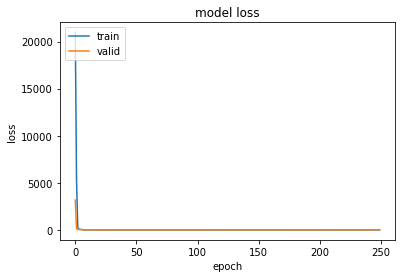

In [37]:
## LEARNING CURVE
## Plot learning curve
import matplotlib.pyplot as plt
hist = model.history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
#plt.savefig(r'//media//ccta//a3ee3238-d74c-4a4f-9c7f-afc98e547c81//Abdelrahman//Centerline_Line_curve_2_150to250')
plt.show()

# ---------------------------------------------------------------------------------------------

# ATTEMPS

# ---------------------------------------------------------------------------------------------

In [61]:
### Get the indices of the model's layers
{i: v for i, v in enumerate(model.layers)}

{0: <tensorflow.python.keras.engine.input_layer.InputLayer at 0x7f7e6db17a00>,
 1: <tensorflow.python.keras.layers.convolutional.Conv3D at 0x7f7e6db17c10>,
 2: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x7f7e979a8580>,
 3: <tensorflow.python.keras.layers.convolutional.Conv3D at 0x7f7e6db0bb50>,
 4: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x7f7e6db251f0>,
 5: <tensorflow.python.keras.layers.convolutional.Conv3D at 0x7f7e6dacf190>,
 6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x7f7e6dac8160>,
 7: <tensorflow.python.keras.layers.convolutional.Conv3D at 0x7f7e6daec7c0>,
 8: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x7f7eba1c5a00>,
 9: <tensorflow.python.keras.layers.convolutional.Conv3D at 0x7f7eba1cb9d0>,
 10: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x7f7d6017c820>,
 11: <tensorflow.python.keras.layers.convolutional.Conv3D at 0x7f7eba2899a0

In [87]:
### Log on tensor board
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [81]:
z[:,120]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.0187862, 2.0187862, 2.0187862, 2.0187862], dtype=float32)>

In [83]:
model.trainable_variables

[<tf.Variable 'first_Conv_layer_5/kernel:0' shape=(3, 3, 3, 1, 32) dtype=float32, numpy=
 array([[[[[ 2.11630017e-02,  5.91779649e-02,  2.21558958e-02,
            -7.39043802e-02,  5.77435642e-03,  1.39779449e-02,
            -4.92379069e-03, -4.95478250e-02,  7.47980773e-02,
             2.05372944e-02, -1.81788132e-02, -7.22322911e-02,
             3.06573808e-02, -2.70405225e-02, -3.40688862e-02,
             5.16837090e-03, -7.17504323e-03, -7.17575699e-02,
            -7.54511803e-02, -7.51582757e-02,  3.76586691e-02,
             2.27745399e-02, -4.07024510e-02, -1.51882246e-02,
            -1.48267671e-02,  3.72423828e-02,  4.17838991e-03,
            -9.51454788e-03, -4.03517894e-02,  8.14992487e-02,
            -7.09882975e-02,  2.47669443e-02]],
 
          [[-4.70330380e-02, -4.11771759e-02,  3.55877057e-02,
             1.38296410e-02,  7.73546249e-02,  5.89482784e-02,
            -1.91790685e-02,  5.51279336e-02, -1.24025792e-02,
             6.45553470e-02,  6.07052445e-

In [99]:
@tf.function
def train_step(input_volume, epoch):
    
    with tf.GradientTape() as Centerline_tape:
        model_output = model(input_volume, training=True)

        reg_loss = regression_loss(true[:,120], model_output[:,120]);
        class_loss = classification_loss(true[:,0:120],model_output[:,0:120]);
        total_loss = class_loss + 10* reg_loss;

    
    gradients = Centerline_tape.gradient(total_loss, model.trainable_variables)
    model_optimizer = optimizer_general.apply_gradients(zip(gradients, model.trainable_variables))
    

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('Regression_Loss', reg_loss, step=epoch)
        tf.summary.scalar('Classification_Loss', class_loss, step=epoch)
        tf.summary.scalar('Total_Loss', total_loss, step=epoch)

In [21]:
root_path = r'/media/ccta/a3ee3238-d74c-4a4f-9c7f-afc98e547c81/Abdelrahman/Center_Line/training'
num_directions_phi = 10;
num_directions_theta = 10;
upper_clip_val = 700
lower_clip_val= -30
Volumes = []
targets = []
for base in sorted(os.listdir(root_path)):
    vessel_list =[]; 
    print(base)
    dicom_folder= "image"+(base.split("set")[1])
    path_to_data = os.path.join(root_path,base);
    path_to_dicom = os.path.join(path_to_data,dicom_folder);
    file_list = os.listdir(path_to_data);
    DICOM = Read_Dicom(path_to_dicom);
    #print(DICOM.dtype)
    
#     print(np.shape(DICOM), "--", np.shape(DICOM_1))
#     print((DICOM[:,:,0]==DICOM_1[:,:,0]).all())
#     plt.imshow(DICOM[:,:,0],cmap='gray')
#     plt.show()
#     plt.imshow(DICOM_1[:,:,0],cmap='gray')
#     plt.show()
    
    for item in file_list:
        if item.find('mhd')>=0:
            mhd_data =sitk.ReadImage(os.path.join(path_to_data,item))
        if item.find('vessel')>=0:
            vessel_list.append(item)
    spacing = np.asarray(mhd_data.GetSpacing())

    
    
     ###### Resampling
        
    vtk_array = numpy_support.numpy_to_vtk(num_array=DICOM.transpose(2, 1, 0).ravel(), 
                                           deep=True,array_type=vtk.VTK_FLOAT)
    vtk_image_data = vtk.vtkImageData()
    vtk_image_data.SetDimensions(DICOM.shape[0],DICOM.shape[1],DICOM.shape[2])
    vtk_image_data.SetExtent(0,DICOM.shape[0]-1,0,DICOM.shape[1]-1,0,DICOM.shape[2]-1)
    vtk_image_data.SetSpacing(spacing[0],spacing[1],spacing[2])  
    vtk_image_data.GetPointData().SetScalars(vtk_array)
    vtk_image_data.SetOrigin(0, 0, 0)
    ## Reslicing filter
    resliceFilter = vtk.vtkImageReslice()
    input_spacing = vtk_image_data.GetSpacing()
    input_extent = vtk_image_data.GetExtent()
    resliceFilter.SetInputData(vtk_image_data)
    resliceFilter.SetInformationInput(vtk_image_data)
    resliceFilter.SetInformation(vtk_image_data.GetInformation())
    resliceFilter.SetResliceAxesDirectionCosines(1,0,0,0,1,0,0,0,1)
    resliceFilter.SetBackgroundLevel(0)
    resliceFilter.SetInterpolationModeToCubic()
    resliceFilter.SetResliceAxesOrigin(vtk_image_data.GetOrigin())
    resliceFilter.SetOutputOrigin(vtk_image_data.GetOrigin())
    resliceFilter.SetOutputSpacing(0.5,0.5,0.5)
    resliceFilter.Update()
    imageResampled = resliceFilter.GetOutput()    
    np_array = numpy_support.vtk_to_numpy(imageResampled.GetPointData().GetScalars())
    Resampled_Volume = np.reshape(np_array,imageResampled.GetDimensions(),order='F').transpose(0,1,2)   
    Resampled_Spacing = imageResampled.GetSpacing()
    
    for vessel_num in sorted(vessel_list):
        
        path_to_reference = os.path.join(path_to_data, vessel_num);
        ### Step 1 - Read File
        reference_data = np.loadtxt(os.path.join(path_to_reference,'reference.txt'));  
           
        ### Step 2 - Use a point
        for i in range(1,len(reference_data),4):
            
            point_current = [reference_data[i,0], reference_data[i,1], reference_data[i,2]];
            pivot_point= np.asarray(point_current).copy() ### For calculations of the center of the patch
            radius = reference_data[i,3]
            ### Calculate the distance between the chosen point and the next
            
            if i ==0: ### Handling the case of the first element 
                for fwd_i in list(range(i+1, len(reference_data)-2)):
                    
                    point_next = [reference_data[fwd_i,0], reference_data[fwd_i,1], reference_data[fwd_i,2]]
                    point_aft_next = [reference_data[fwd_i+1,0], reference_data[fwd_i+1,1], 
                                      reference_data[fwd_i+1,2]];
                    
                    distance_i = math.sqrt(((point_current[0]-point_next[0])**2) + 
                                         ((point_current[1]-point_next[1])**2) + 
                                         ((point_current[2]-point_next[2])**2));
                    
                    distance_i_after = math.sqrt(((point_current[0]-point_aft_next[0])**2) + 
                                         ((point_current[1]-point_aft_next[1])**2) + 
                                         ((point_current[2]-point_aft_next[2])**2));
                    #print(radius,"-",distance_i,"-", distance_i_after)
                    if distance_i < radius and distance_i_after > radius:
                        
                        break_even_points = [point_next, point_aft_next];
                        minimal_distance =np.argmin([distance_i, distance_i_after]);
                        nearest_point = np.asarray(break_even_points[minimal_distance]);
                        
                        ### Chose the point with minimal distance and calculate vector to this point
                        vector = calculate_vector(point_current, break_even_points[minimal_distance]);
                        ### Create Spherical Directions at the reference point
                        ### Calculate dot product between vector and the directions
                        ### Return the index of the maximum dot product
                        probabilities_array = [0]* ((num_directions_phi*num_directions_theta)+20);
                        maximum_prob_direction = dot_product(vector,num_directions_phi, num_directions_theta);
                        
                        probabilities_array[maximum_prob_direction]= 1;
                        ### Voxel Choosing
                        ### World Coordinates >> Voxel Coordinates
                        pivot_point[0]= np.round(pivot_point[0]/ Resampled_Spacing[0])
                        pivot_point[1]= np.round(pivot_point[1]/ Resampled_Spacing[1])
                        pivot_point[2]= np.round(pivot_point[2]/ Resampled_Spacing[2]) 
                        ### Swapping x and y in the reference array to go from image to array coordinates
                        pivot_point[0], pivot_point[1]= pivot_point[1], pivot_point[0];
                        pivot_point = pivot_point.astype('int16');
                        x= pivot_point[0]; y= pivot_point[1]; z=pivot_point[2];
                        ### Sample Volume
                        sample_volume = Resampled_Volume[x-9:x+10, y-9:y+10, z-9:z+10];
                        ### Targets 
                        temp_target = np.hstack((probabilities_array, radius))
                        ### Add to training and testing data
                        Volumes.append(sample_volume);
                        targets.append(temp_target);
                        break;
                    
                        
                              
                        
                        
                        
            elif i != 0 and i != len(reference_data):
                
                probabilities_array = [0]* ((num_directions_phi*num_directions_theta)+20);
                ### Loop over next points
                
                for fwd_i in list(range(i+1, len(reference_data)-1)):
                    
                    point_next = [reference_data[fwd_i,0], reference_data[fwd_i,1], reference_data[fwd_i,2]]
                    point_aft_next = [reference_data[fwd_i+1,0], reference_data[fwd_i+1,1], 
                                      reference_data[fwd_i+1,2]];
                    
                    distance_i = math.sqrt(((point_current[0]-point_next[0])**2) + 
                                         ((point_current[1]-point_next[1])**2) + 
                                         ((point_current[2]-point_next[2])**2));
                    
                    distance_i_after = math.sqrt(((point_current[0]-point_aft_next[0])**2) + 
                                         ((point_current[1]-point_aft_next[1])**2) + 
                                         ((point_current[2]-point_aft_next[2])**2));
                    
                    if distance_i < radius and distance_i_after > radius:
                        
                        break_even_points = [point_next, point_aft_next];
                        minimal_distance =np.argmin([distance_i, distance_i_after]);
                        nearest_point = np.asarray(break_even_points[minimal_distance]);
                        ### Chose the point with minimal distance and calculate vector to this point
                        vector = calculate_vector(point_current, break_even_points[minimal_distance]);
                        ### Create Spherical Directions at the reference point
                        ### Calculate dot product between vector and the directions
                        ### Return the index of the maximum dot product
                        
                        maximum_prob_direction = dot_product(vector,num_directions_phi, num_directions_theta);
                        
                        probabilities_array[maximum_prob_direction]=0.5
                        break;
         
                        
                
                ### Loop over Previous Points        
                for bckwd_i in list(range(i-1, -1, -1)):
                    
                    point_prev = [reference_data[bckwd_i,0], reference_data[bckwd_i,1], reference_data[bckwd_i,2]]
                    point_bef_prev = [reference_data[bckwd_i-1,0], reference_data[bckwd_i-1,1], 
                                      reference_data[bckwd_i-1,2]];
                    
                    distance_i = math.sqrt(((point_current[0]-point_prev[0])**2) + 
                                         ((point_current[1]-point_prev[1])**2) + 
                                         ((point_current[2]-point_prev[2])**2));
                    
                    distance_i_bef = math.sqrt(((point_current[0]-point_bef_prev[0])**2) + 
                                         ((point_current[1]-point_bef_prev[1])**2) + 
                                         ((point_current[2]-point_bef_prev[2])**2));
                    
                    if distance_i < radius and distance_i_bef > radius:
                        
                        break_even_points = [point_prev, point_bef_prev];
                        minimal_distance =np.argmin([distance_i, distance_i_bef]);
                        
                        ### Chose the point with minimal distance and calculate vector to this point
                        vector = calculate_vector(point_current, break_even_points[minimal_distance]);
                        ### Create Spherical Directions at the reference point
                        ### Calculate dot product between vector and the directions
                        ### Return the index of the maximum dot product
                        
                        maximum_prob_direction = dot_product(vector,num_directions_phi, num_directions_theta);
                        
                        probabilities_array[maximum_prob_direction]=0.5
                        break;
                        
                        
                ### Voxel Choosing
                ### World Coordinates >> Voxel Coordinates
                pivot_point[0]= np.round(pivot_point[0]/ Resampled_Spacing[0])
                pivot_point[1]= np.round(pivot_point[1]/ Resampled_Spacing[1])
                pivot_point[2]= np.round(pivot_point[2]/ Resampled_Spacing[2]) 
                ### Swapping x and y in the reference array to go from image to array coordinates
                pivot_point[0], pivot_point[1]= pivot_point[1], pivot_point[0];
                pivot_point = pivot_point.astype('int16');
                x= pivot_point[0]; y= pivot_point[1]; z=pivot_point[2];
                ### Sample Volume
                sample_volume = Resampled_Volume[x-9:x+10, y-9:y+10, z-9:z+10];
                ### Targets 
                temp_target = np.hstack((probabilities_array, radius))
                ### Add to training and testing data
                Volumes.append(sample_volume);
                targets.append(temp_target);
                print(np.shape(np.asarray(Volumes)),"__",np.shape(np.asarray(targets)))            
                
    

dataset00
1992.0 -- -1024.0
(1, 19, 19, 19) __ (1, 121)
(2, 19, 19, 19) __ (2, 121)
(3, 19, 19, 19) __ (3, 121)
(4, 19, 19, 19) __ (4, 121)
(5, 19, 19, 19) __ (5, 121)
(6, 19, 19, 19) __ (6, 121)
(7, 19, 19, 19) __ (7, 121)
(8, 19, 19, 19) __ (8, 121)
(9, 19, 19, 19) __ (9, 121)
(10, 19, 19, 19) __ (10, 121)
(11, 19, 19, 19) __ (11, 121)
(12, 19, 19, 19) __ (12, 121)
(13, 19, 19, 19) __ (13, 121)
(14, 19, 19, 19) __ (14, 121)
(15, 19, 19, 19) __ (15, 121)
(16, 19, 19, 19) __ (16, 121)
(17, 19, 19, 19) __ (17, 121)
(18, 19, 19, 19) __ (18, 121)
(19, 19, 19, 19) __ (19, 121)
(20, 19, 19, 19) __ (20, 121)
(21, 19, 19, 19) __ (21, 121)
(22, 19, 19, 19) __ (22, 121)
(23, 19, 19, 19) __ (23, 121)
(24, 19, 19, 19) __ (24, 121)
(25, 19, 19, 19) __ (25, 121)
(26, 19, 19, 19) __ (26, 121)
(27, 19, 19, 19) __ (27, 121)
(28, 19, 19, 19) __ (28, 121)
(29, 19, 19, 19) __ (29, 121)
(30, 19, 19, 19) __ (30, 121)
(31, 19, 19, 19) __ (31, 121)
(32, 19, 19, 19) __ (32, 121)
(33, 19, 19, 19) __ (33, 121)


(282, 19, 19, 19) __ (282, 121)
(283, 19, 19, 19) __ (283, 121)
(284, 19, 19, 19) __ (284, 121)
(285, 19, 19, 19) __ (285, 121)
(286, 19, 19, 19) __ (286, 121)
(287, 19, 19, 19) __ (287, 121)
(288, 19, 19, 19) __ (288, 121)
(289, 19, 19, 19) __ (289, 121)
(290, 19, 19, 19) __ (290, 121)
(291, 19, 19, 19) __ (291, 121)
(292, 19, 19, 19) __ (292, 121)
(293, 19, 19, 19) __ (293, 121)
(294, 19, 19, 19) __ (294, 121)
(295, 19, 19, 19) __ (295, 121)
(296, 19, 19, 19) __ (296, 121)
(297, 19, 19, 19) __ (297, 121)
(298, 19, 19, 19) __ (298, 121)
(299, 19, 19, 19) __ (299, 121)
(300, 19, 19, 19) __ (300, 121)
(301, 19, 19, 19) __ (301, 121)
(302, 19, 19, 19) __ (302, 121)
(303, 19, 19, 19) __ (303, 121)
(304, 19, 19, 19) __ (304, 121)
(305, 19, 19, 19) __ (305, 121)
(306, 19, 19, 19) __ (306, 121)
(307, 19, 19, 19) __ (307, 121)
(308, 19, 19, 19) __ (308, 121)
(309, 19, 19, 19) __ (309, 121)
(310, 19, 19, 19) __ (310, 121)
(311, 19, 19, 19) __ (311, 121)
(312, 19, 19, 19) __ (312, 121)
(313, 19

(544, 19, 19, 19) __ (544, 121)
(545, 19, 19, 19) __ (545, 121)
(546, 19, 19, 19) __ (546, 121)
(547, 19, 19, 19) __ (547, 121)
(548, 19, 19, 19) __ (548, 121)
(549, 19, 19, 19) __ (549, 121)
(550, 19, 19, 19) __ (550, 121)
(551, 19, 19, 19) __ (551, 121)
(552, 19, 19, 19) __ (552, 121)
(553, 19, 19, 19) __ (553, 121)
(554, 19, 19, 19) __ (554, 121)
(555, 19, 19, 19) __ (555, 121)
(556, 19, 19, 19) __ (556, 121)
(557, 19, 19, 19) __ (557, 121)
(558, 19, 19, 19) __ (558, 121)
(559, 19, 19, 19) __ (559, 121)
(560, 19, 19, 19) __ (560, 121)
(561, 19, 19, 19) __ (561, 121)
(562, 19, 19, 19) __ (562, 121)
(563, 19, 19, 19) __ (563, 121)
(564, 19, 19, 19) __ (564, 121)
(565, 19, 19, 19) __ (565, 121)
(566, 19, 19, 19) __ (566, 121)
(567, 19, 19, 19) __ (567, 121)
(568, 19, 19, 19) __ (568, 121)
(569, 19, 19, 19) __ (569, 121)
(570, 19, 19, 19) __ (570, 121)
(571, 19, 19, 19) __ (571, 121)
(572, 19, 19, 19) __ (572, 121)
(573, 19, 19, 19) __ (573, 121)
(574, 19, 19, 19) __ (574, 121)
(575, 19

(815, 19, 19, 19) __ (815, 121)
(816, 19, 19, 19) __ (816, 121)
(817, 19, 19, 19) __ (817, 121)
(818, 19, 19, 19) __ (818, 121)
(819, 19, 19, 19) __ (819, 121)
(820, 19, 19, 19) __ (820, 121)
(821, 19, 19, 19) __ (821, 121)
(822, 19, 19, 19) __ (822, 121)
(823, 19, 19, 19) __ (823, 121)
(824, 19, 19, 19) __ (824, 121)
(825, 19, 19, 19) __ (825, 121)
(826, 19, 19, 19) __ (826, 121)
(827, 19, 19, 19) __ (827, 121)
(828, 19, 19, 19) __ (828, 121)
(829, 19, 19, 19) __ (829, 121)
(830, 19, 19, 19) __ (830, 121)
(831, 19, 19, 19) __ (831, 121)
(832, 19, 19, 19) __ (832, 121)
(833, 19, 19, 19) __ (833, 121)
(834, 19, 19, 19) __ (834, 121)
(835, 19, 19, 19) __ (835, 121)
(836, 19, 19, 19) __ (836, 121)
(837, 19, 19, 19) __ (837, 121)
(838, 19, 19, 19) __ (838, 121)
(839, 19, 19, 19) __ (839, 121)
(840, 19, 19, 19) __ (840, 121)
(841, 19, 19, 19) __ (841, 121)
(842, 19, 19, 19) __ (842, 121)
(843, 19, 19, 19) __ (843, 121)
(844, 19, 19, 19) __ (844, 121)
(845, 19, 19, 19) __ (845, 121)
(846, 19

(1074, 19, 19, 19) __ (1074, 121)
(1075, 19, 19, 19) __ (1075, 121)
(1076, 19, 19, 19) __ (1076, 121)
(1077, 19, 19, 19) __ (1077, 121)
(1078, 19, 19, 19) __ (1078, 121)
(1079, 19, 19, 19) __ (1079, 121)
(1080, 19, 19, 19) __ (1080, 121)
(1081, 19, 19, 19) __ (1081, 121)
(1082, 19, 19, 19) __ (1082, 121)
(1083, 19, 19, 19) __ (1083, 121)
(1084, 19, 19, 19) __ (1084, 121)
(1085, 19, 19, 19) __ (1085, 121)
(1086, 19, 19, 19) __ (1086, 121)
(1087, 19, 19, 19) __ (1087, 121)
(1088, 19, 19, 19) __ (1088, 121)
(1089, 19, 19, 19) __ (1089, 121)
(1090, 19, 19, 19) __ (1090, 121)
(1091, 19, 19, 19) __ (1091, 121)
(1092, 19, 19, 19) __ (1092, 121)
(1093, 19, 19, 19) __ (1093, 121)
(1094, 19, 19, 19) __ (1094, 121)
(1095, 19, 19, 19) __ (1095, 121)
(1096, 19, 19, 19) __ (1096, 121)
(1097, 19, 19, 19) __ (1097, 121)
(1098, 19, 19, 19) __ (1098, 121)
(1099, 19, 19, 19) __ (1099, 121)
(1100, 19, 19, 19) __ (1100, 121)
(1101, 19, 19, 19) __ (1101, 121)
(1102, 19, 19, 19) __ (1102, 121)
(1103, 19, 19,

(1319, 19, 19, 19) __ (1319, 121)
(1320, 19, 19, 19) __ (1320, 121)
(1321, 19, 19, 19) __ (1321, 121)
(1322, 19, 19, 19) __ (1322, 121)
(1323, 19, 19, 19) __ (1323, 121)
(1324, 19, 19, 19) __ (1324, 121)
(1325, 19, 19, 19) __ (1325, 121)
(1326, 19, 19, 19) __ (1326, 121)
(1327, 19, 19, 19) __ (1327, 121)
(1328, 19, 19, 19) __ (1328, 121)
(1329, 19, 19, 19) __ (1329, 121)
(1330, 19, 19, 19) __ (1330, 121)
(1331, 19, 19, 19) __ (1331, 121)
(1332, 19, 19, 19) __ (1332, 121)
(1333, 19, 19, 19) __ (1333, 121)
(1334, 19, 19, 19) __ (1334, 121)
(1335, 19, 19, 19) __ (1335, 121)
(1336, 19, 19, 19) __ (1336, 121)
(1337, 19, 19, 19) __ (1337, 121)
(1338, 19, 19, 19) __ (1338, 121)
(1339, 19, 19, 19) __ (1339, 121)
(1340, 19, 19, 19) __ (1340, 121)
(1341, 19, 19, 19) __ (1341, 121)
(1342, 19, 19, 19) __ (1342, 121)
(1343, 19, 19, 19) __ (1343, 121)
(1344, 19, 19, 19) __ (1344, 121)
(1345, 19, 19, 19) __ (1345, 121)
(1346, 19, 19, 19) __ (1346, 121)
(1347, 19, 19, 19) __ (1347, 121)
(1348, 19, 19,

(1568, 19, 19, 19) __ (1568, 121)
(1569, 19, 19, 19) __ (1569, 121)
(1570, 19, 19, 19) __ (1570, 121)
(1571, 19, 19, 19) __ (1571, 121)
(1572, 19, 19, 19) __ (1572, 121)
(1573, 19, 19, 19) __ (1573, 121)
(1574, 19, 19, 19) __ (1574, 121)
(1575, 19, 19, 19) __ (1575, 121)
(1576, 19, 19, 19) __ (1576, 121)
(1577, 19, 19, 19) __ (1577, 121)
(1578, 19, 19, 19) __ (1578, 121)
(1579, 19, 19, 19) __ (1579, 121)
(1580, 19, 19, 19) __ (1580, 121)
(1581, 19, 19, 19) __ (1581, 121)
(1582, 19, 19, 19) __ (1582, 121)
(1583, 19, 19, 19) __ (1583, 121)
(1584, 19, 19, 19) __ (1584, 121)
(1585, 19, 19, 19) __ (1585, 121)
(1586, 19, 19, 19) __ (1586, 121)
(1587, 19, 19, 19) __ (1587, 121)
(1588, 19, 19, 19) __ (1588, 121)
(1589, 19, 19, 19) __ (1589, 121)
(1590, 19, 19, 19) __ (1590, 121)
(1591, 19, 19, 19) __ (1591, 121)
(1592, 19, 19, 19) __ (1592, 121)
(1593, 19, 19, 19) __ (1593, 121)
(1594, 19, 19, 19) __ (1594, 121)
(1595, 19, 19, 19) __ (1595, 121)
(1596, 19, 19, 19) __ (1596, 121)
(1597, 19, 19,

(1813, 19, 19, 19) __ (1813, 121)
(1814, 19, 19, 19) __ (1814, 121)
(1815, 19, 19, 19) __ (1815, 121)
(1816, 19, 19, 19) __ (1816, 121)
(1817, 19, 19, 19) __ (1817, 121)
(1818, 19, 19, 19) __ (1818, 121)
(1819, 19, 19, 19) __ (1819, 121)
(1820, 19, 19, 19) __ (1820, 121)
(1821, 19, 19, 19) __ (1821, 121)
(1822, 19, 19, 19) __ (1822, 121)
(1823, 19, 19, 19) __ (1823, 121)
(1824, 19, 19, 19) __ (1824, 121)
(1825, 19, 19, 19) __ (1825, 121)
(1826, 19, 19, 19) __ (1826, 121)
(1827, 19, 19, 19) __ (1827, 121)
(1828, 19, 19, 19) __ (1828, 121)
(1829, 19, 19, 19) __ (1829, 121)
(1830, 19, 19, 19) __ (1830, 121)
(1831, 19, 19, 19) __ (1831, 121)
(1832, 19, 19, 19) __ (1832, 121)
(1833, 19, 19, 19) __ (1833, 121)
(1834, 19, 19, 19) __ (1834, 121)
(1835, 19, 19, 19) __ (1835, 121)
(1836, 19, 19, 19) __ (1836, 121)
(1837, 19, 19, 19) __ (1837, 121)
(1838, 19, 19, 19) __ (1838, 121)
(1839, 19, 19, 19) __ (1839, 121)
(1840, 19, 19, 19) __ (1840, 121)
(1841, 19, 19, 19) __ (1841, 121)
(1842, 19, 19,

(2057, 19, 19, 19) __ (2057, 121)
(2058, 19, 19, 19) __ (2058, 121)
(2059, 19, 19, 19) __ (2059, 121)
(2060, 19, 19, 19) __ (2060, 121)
(2061, 19, 19, 19) __ (2061, 121)
(2062, 19, 19, 19) __ (2062, 121)
(2063, 19, 19, 19) __ (2063, 121)
(2064, 19, 19, 19) __ (2064, 121)
(2065, 19, 19, 19) __ (2065, 121)
(2066, 19, 19, 19) __ (2066, 121)
(2067, 19, 19, 19) __ (2067, 121)
(2068, 19, 19, 19) __ (2068, 121)
(2069, 19, 19, 19) __ (2069, 121)
(2070, 19, 19, 19) __ (2070, 121)
(2071, 19, 19, 19) __ (2071, 121)
(2072, 19, 19, 19) __ (2072, 121)
(2073, 19, 19, 19) __ (2073, 121)
(2074, 19, 19, 19) __ (2074, 121)
(2075, 19, 19, 19) __ (2075, 121)
(2076, 19, 19, 19) __ (2076, 121)
(2077, 19, 19, 19) __ (2077, 121)
(2078, 19, 19, 19) __ (2078, 121)
(2079, 19, 19, 19) __ (2079, 121)
(2080, 19, 19, 19) __ (2080, 121)
(2081, 19, 19, 19) __ (2081, 121)
(2082, 19, 19, 19) __ (2082, 121)
(2083, 19, 19, 19) __ (2083, 121)
(2084, 19, 19, 19) __ (2084, 121)
(2085, 19, 19, 19) __ (2085, 121)
(2086, 19, 19,

(2305, 19, 19, 19) __ (2305, 121)
(2306, 19, 19, 19) __ (2306, 121)
(2307, 19, 19, 19) __ (2307, 121)
(2308, 19, 19, 19) __ (2308, 121)
(2309, 19, 19, 19) __ (2309, 121)
(2310, 19, 19, 19) __ (2310, 121)
(2311, 19, 19, 19) __ (2311, 121)
(2312, 19, 19, 19) __ (2312, 121)
(2313, 19, 19, 19) __ (2313, 121)
(2314, 19, 19, 19) __ (2314, 121)
(2315, 19, 19, 19) __ (2315, 121)
(2316, 19, 19, 19) __ (2316, 121)
(2317, 19, 19, 19) __ (2317, 121)
(2318, 19, 19, 19) __ (2318, 121)
(2319, 19, 19, 19) __ (2319, 121)
(2320, 19, 19, 19) __ (2320, 121)
(2321, 19, 19, 19) __ (2321, 121)
(2322, 19, 19, 19) __ (2322, 121)
(2323, 19, 19, 19) __ (2323, 121)
(2324, 19, 19, 19) __ (2324, 121)
(2325, 19, 19, 19) __ (2325, 121)
(2326, 19, 19, 19) __ (2326, 121)
(2327, 19, 19, 19) __ (2327, 121)
(2328, 19, 19, 19) __ (2328, 121)
(2329, 19, 19, 19) __ (2329, 121)
(2330, 19, 19, 19) __ (2330, 121)
(2331, 19, 19, 19) __ (2331, 121)
(2332, 19, 19, 19) __ (2332, 121)
(2333, 19, 19, 19) __ (2333, 121)
(2334, 19, 19,

(2550, 19, 19, 19) __ (2550, 121)
(2551, 19, 19, 19) __ (2551, 121)
(2552, 19, 19, 19) __ (2552, 121)
(2553, 19, 19, 19) __ (2553, 121)
(2554, 19, 19, 19) __ (2554, 121)
(2555, 19, 19, 19) __ (2555, 121)
(2556, 19, 19, 19) __ (2556, 121)
(2557, 19, 19, 19) __ (2557, 121)
(2558, 19, 19, 19) __ (2558, 121)
(2559, 19, 19, 19) __ (2559, 121)
(2560, 19, 19, 19) __ (2560, 121)
(2561, 19, 19, 19) __ (2561, 121)
(2562, 19, 19, 19) __ (2562, 121)
(2563, 19, 19, 19) __ (2563, 121)
(2564, 19, 19, 19) __ (2564, 121)
(2565, 19, 19, 19) __ (2565, 121)
(2566, 19, 19, 19) __ (2566, 121)
(2567, 19, 19, 19) __ (2567, 121)
(2568, 19, 19, 19) __ (2568, 121)
(2569, 19, 19, 19) __ (2569, 121)
(2570, 19, 19, 19) __ (2570, 121)
(2571, 19, 19, 19) __ (2571, 121)
(2572, 19, 19, 19) __ (2572, 121)
(2573, 19, 19, 19) __ (2573, 121)
(2574, 19, 19, 19) __ (2574, 121)
(2575, 19, 19, 19) __ (2575, 121)
(2576, 19, 19, 19) __ (2576, 121)
(2577, 19, 19, 19) __ (2577, 121)
(2578, 19, 19, 19) __ (2578, 121)
(2579, 19, 19,

(2794, 19, 19, 19) __ (2794, 121)
(2795, 19, 19, 19) __ (2795, 121)
(2796, 19, 19, 19) __ (2796, 121)
(2797, 19, 19, 19) __ (2797, 121)
(2798, 19, 19, 19) __ (2798, 121)
(2799, 19, 19, 19) __ (2799, 121)
(2800, 19, 19, 19) __ (2800, 121)
(2801, 19, 19, 19) __ (2801, 121)
(2802, 19, 19, 19) __ (2802, 121)
(2803, 19, 19, 19) __ (2803, 121)
(2804, 19, 19, 19) __ (2804, 121)
(2805, 19, 19, 19) __ (2805, 121)
(2806, 19, 19, 19) __ (2806, 121)
(2807, 19, 19, 19) __ (2807, 121)
(2808, 19, 19, 19) __ (2808, 121)
(2809, 19, 19, 19) __ (2809, 121)
(2810, 19, 19, 19) __ (2810, 121)
(2811, 19, 19, 19) __ (2811, 121)
(2812, 19, 19, 19) __ (2812, 121)
(2813, 19, 19, 19) __ (2813, 121)
(2814, 19, 19, 19) __ (2814, 121)
(2815, 19, 19, 19) __ (2815, 121)
(2816, 19, 19, 19) __ (2816, 121)
(2817, 19, 19, 19) __ (2817, 121)
(2818, 19, 19, 19) __ (2818, 121)
(2819, 19, 19, 19) __ (2819, 121)
(2820, 19, 19, 19) __ (2820, 121)
(2821, 19, 19, 19) __ (2821, 121)
(2822, 19, 19, 19) __ (2822, 121)
(2823, 19, 19,

(3038, 19, 19, 19) __ (3038, 121)
(3039, 19, 19, 19) __ (3039, 121)
(3040, 19, 19, 19) __ (3040, 121)
(3041, 19, 19, 19) __ (3041, 121)
(3042, 19, 19, 19) __ (3042, 121)
(3043, 19, 19, 19) __ (3043, 121)
(3044, 19, 19, 19) __ (3044, 121)
(3045, 19, 19, 19) __ (3045, 121)
(3046, 19, 19, 19) __ (3046, 121)
(3047, 19, 19, 19) __ (3047, 121)
(3048, 19, 19, 19) __ (3048, 121)
(3049, 19, 19, 19) __ (3049, 121)
(3050, 19, 19, 19) __ (3050, 121)
(3051, 19, 19, 19) __ (3051, 121)
(3052, 19, 19, 19) __ (3052, 121)
(3053, 19, 19, 19) __ (3053, 121)
(3054, 19, 19, 19) __ (3054, 121)
(3055, 19, 19, 19) __ (3055, 121)
(3056, 19, 19, 19) __ (3056, 121)
(3057, 19, 19, 19) __ (3057, 121)
(3058, 19, 19, 19) __ (3058, 121)
(3059, 19, 19, 19) __ (3059, 121)
(3060, 19, 19, 19) __ (3060, 121)
(3061, 19, 19, 19) __ (3061, 121)
(3062, 19, 19, 19) __ (3062, 121)
(3063, 19, 19, 19) __ (3063, 121)
(3064, 19, 19, 19) __ (3064, 121)
(3065, 19, 19, 19) __ (3065, 121)
(3066, 19, 19, 19) __ (3066, 121)
(3067, 19, 19,

(3282, 19, 19, 19) __ (3282, 121)
(3283, 19, 19, 19) __ (3283, 121)
(3284, 19, 19, 19) __ (3284, 121)
(3285, 19, 19, 19) __ (3285, 121)
(3286, 19, 19, 19) __ (3286, 121)
(3287, 19, 19, 19) __ (3287, 121)
(3288, 19, 19, 19) __ (3288, 121)
(3289, 19, 19, 19) __ (3289, 121)
(3290, 19, 19, 19) __ (3290, 121)
(3291, 19, 19, 19) __ (3291, 121)
(3292, 19, 19, 19) __ (3292, 121)
(3293, 19, 19, 19) __ (3293, 121)
(3294, 19, 19, 19) __ (3294, 121)
(3295, 19, 19, 19) __ (3295, 121)
(3296, 19, 19, 19) __ (3296, 121)
(3297, 19, 19, 19) __ (3297, 121)
(3298, 19, 19, 19) __ (3298, 121)
(3299, 19, 19, 19) __ (3299, 121)
(3300, 19, 19, 19) __ (3300, 121)
(3301, 19, 19, 19) __ (3301, 121)
(3302, 19, 19, 19) __ (3302, 121)
(3303, 19, 19, 19) __ (3303, 121)
(3304, 19, 19, 19) __ (3304, 121)
(3305, 19, 19, 19) __ (3305, 121)
(3306, 19, 19, 19) __ (3306, 121)
(3307, 19, 19, 19) __ (3307, 121)
(3308, 19, 19, 19) __ (3308, 121)
(3309, 19, 19, 19) __ (3309, 121)
(3310, 19, 19, 19) __ (3310, 121)
(3311, 19, 19,

(3528, 19, 19, 19) __ (3528, 121)
(3529, 19, 19, 19) __ (3529, 121)
(3530, 19, 19, 19) __ (3530, 121)
(3531, 19, 19, 19) __ (3531, 121)
(3532, 19, 19, 19) __ (3532, 121)
(3533, 19, 19, 19) __ (3533, 121)
(3534, 19, 19, 19) __ (3534, 121)
(3535, 19, 19, 19) __ (3535, 121)
(3536, 19, 19, 19) __ (3536, 121)
(3537, 19, 19, 19) __ (3537, 121)
(3538, 19, 19, 19) __ (3538, 121)
(3539, 19, 19, 19) __ (3539, 121)
(3540, 19, 19, 19) __ (3540, 121)
(3541, 19, 19, 19) __ (3541, 121)
(3542, 19, 19, 19) __ (3542, 121)
(3543, 19, 19, 19) __ (3543, 121)
(3544, 19, 19, 19) __ (3544, 121)
(3545, 19, 19, 19) __ (3545, 121)
(3546, 19, 19, 19) __ (3546, 121)
(3547, 19, 19, 19) __ (3547, 121)
(3548, 19, 19, 19) __ (3548, 121)
(3549, 19, 19, 19) __ (3549, 121)
(3550, 19, 19, 19) __ (3550, 121)
(3551, 19, 19, 19) __ (3551, 121)
(3552, 19, 19, 19) __ (3552, 121)
(3553, 19, 19, 19) __ (3553, 121)
(3554, 19, 19, 19) __ (3554, 121)
(3555, 19, 19, 19) __ (3555, 121)
(3556, 19, 19, 19) __ (3556, 121)
(3557, 19, 19,

(3770, 19, 19, 19) __ (3770, 121)
(3771, 19, 19, 19) __ (3771, 121)
(3772, 19, 19, 19) __ (3772, 121)
(3773, 19, 19, 19) __ (3773, 121)
(3774, 19, 19, 19) __ (3774, 121)
(3775, 19, 19, 19) __ (3775, 121)
(3776, 19, 19, 19) __ (3776, 121)
(3777, 19, 19, 19) __ (3777, 121)
(3778, 19, 19, 19) __ (3778, 121)
(3779, 19, 19, 19) __ (3779, 121)
(3780, 19, 19, 19) __ (3780, 121)
(3781, 19, 19, 19) __ (3781, 121)
(3782, 19, 19, 19) __ (3782, 121)
(3783, 19, 19, 19) __ (3783, 121)
(3784, 19, 19, 19) __ (3784, 121)
(3785, 19, 19, 19) __ (3785, 121)
(3786, 19, 19, 19) __ (3786, 121)
(3787, 19, 19, 19) __ (3787, 121)
(3788, 19, 19, 19) __ (3788, 121)
(3789, 19, 19, 19) __ (3789, 121)
(3790, 19, 19, 19) __ (3790, 121)
(3791, 19, 19, 19) __ (3791, 121)
(3792, 19, 19, 19) __ (3792, 121)
(3793, 19, 19, 19) __ (3793, 121)
(3794, 19, 19, 19) __ (3794, 121)
(3795, 19, 19, 19) __ (3795, 121)
(3796, 19, 19, 19) __ (3796, 121)
(3797, 19, 19, 19) __ (3797, 121)
(3798, 19, 19, 19) __ (3798, 121)
(3799, 19, 19,

(4011, 19, 19, 19) __ (4011, 121)
(4012, 19, 19, 19) __ (4012, 121)
(4013, 19, 19, 19) __ (4013, 121)
(4014, 19, 19, 19) __ (4014, 121)
(4015, 19, 19, 19) __ (4015, 121)
(4016, 19, 19, 19) __ (4016, 121)
(4017, 19, 19, 19) __ (4017, 121)
(4018, 19, 19, 19) __ (4018, 121)
(4019, 19, 19, 19) __ (4019, 121)
(4020, 19, 19, 19) __ (4020, 121)
(4021, 19, 19, 19) __ (4021, 121)
(4022, 19, 19, 19) __ (4022, 121)
(4023, 19, 19, 19) __ (4023, 121)
(4024, 19, 19, 19) __ (4024, 121)
(4025, 19, 19, 19) __ (4025, 121)
(4026, 19, 19, 19) __ (4026, 121)
(4027, 19, 19, 19) __ (4027, 121)
(4028, 19, 19, 19) __ (4028, 121)
(4029, 19, 19, 19) __ (4029, 121)
(4030, 19, 19, 19) __ (4030, 121)
(4031, 19, 19, 19) __ (4031, 121)
(4032, 19, 19, 19) __ (4032, 121)
(4033, 19, 19, 19) __ (4033, 121)
(4034, 19, 19, 19) __ (4034, 121)
(4035, 19, 19, 19) __ (4035, 121)
(4036, 19, 19, 19) __ (4036, 121)
(4037, 19, 19, 19) __ (4037, 121)
(4038, 19, 19, 19) __ (4038, 121)
(4039, 19, 19, 19) __ (4039, 121)
(4040, 19, 19,

(4256, 19, 19, 19) __ (4256, 121)
(4257, 19, 19, 19) __ (4257, 121)
(4258, 19, 19, 19) __ (4258, 121)
(4259, 19, 19, 19) __ (4259, 121)
(4260, 19, 19, 19) __ (4260, 121)
(4261, 19, 19, 19) __ (4261, 121)
(4262, 19, 19, 19) __ (4262, 121)
(4263, 19, 19, 19) __ (4263, 121)
(4264, 19, 19, 19) __ (4264, 121)
(4265, 19, 19, 19) __ (4265, 121)
(4266, 19, 19, 19) __ (4266, 121)
(4267, 19, 19, 19) __ (4267, 121)
(4268, 19, 19, 19) __ (4268, 121)
(4269, 19, 19, 19) __ (4269, 121)
(4270, 19, 19, 19) __ (4270, 121)
(4271, 19, 19, 19) __ (4271, 121)
(4272, 19, 19, 19) __ (4272, 121)
(4273, 19, 19, 19) __ (4273, 121)
(4274, 19, 19, 19) __ (4274, 121)
(4275, 19, 19, 19) __ (4275, 121)
dataset01
1413.0 -- -1024.0
(4276, 19, 19, 19) __ (4276, 121)
(4277, 19, 19, 19) __ (4277, 121)
(4278, 19, 19, 19) __ (4278, 121)
(4279, 19, 19, 19) __ (4279, 121)
(4280, 19, 19, 19) __ (4280, 121)
(4281, 19, 19, 19) __ (4281, 121)
(4282, 19, 19, 19) __ (4282, 121)
(4283, 19, 19, 19) __ (4283, 121)
(4284, 19, 19, 19) _

(4501, 19, 19, 19) __ (4501, 121)
(4502, 19, 19, 19) __ (4502, 121)
(4503, 19, 19, 19) __ (4503, 121)
(4504, 19, 19, 19) __ (4504, 121)
(4505, 19, 19, 19) __ (4505, 121)
(4506, 19, 19, 19) __ (4506, 121)
(4507, 19, 19, 19) __ (4507, 121)
(4508, 19, 19, 19) __ (4508, 121)
(4509, 19, 19, 19) __ (4509, 121)
(4510, 19, 19, 19) __ (4510, 121)
(4511, 19, 19, 19) __ (4511, 121)
(4512, 19, 19, 19) __ (4512, 121)
(4513, 19, 19, 19) __ (4513, 121)
(4514, 19, 19, 19) __ (4514, 121)
(4515, 19, 19, 19) __ (4515, 121)
(4516, 19, 19, 19) __ (4516, 121)
(4517, 19, 19, 19) __ (4517, 121)
(4518, 19, 19, 19) __ (4518, 121)
(4519, 19, 19, 19) __ (4519, 121)
(4520, 19, 19, 19) __ (4520, 121)
(4521, 19, 19, 19) __ (4521, 121)
(4522, 19, 19, 19) __ (4522, 121)
(4523, 19, 19, 19) __ (4523, 121)
(4524, 19, 19, 19) __ (4524, 121)
(4525, 19, 19, 19) __ (4525, 121)
(4526, 19, 19, 19) __ (4526, 121)
(4527, 19, 19, 19) __ (4527, 121)
(4528, 19, 19, 19) __ (4528, 121)
(4529, 19, 19, 19) __ (4529, 121)
(4530, 19, 19,

(4744, 19, 19, 19) __ (4744, 121)
(4745, 19, 19, 19) __ (4745, 121)
(4746, 19, 19, 19) __ (4746, 121)
(4747, 19, 19, 19) __ (4747, 121)
(4748, 19, 19, 19) __ (4748, 121)
(4749, 19, 19, 19) __ (4749, 121)
(4750, 19, 19, 19) __ (4750, 121)
(4751, 19, 19, 19) __ (4751, 121)
(4752, 19, 19, 19) __ (4752, 121)
(4753, 19, 19, 19) __ (4753, 121)
(4754, 19, 19, 19) __ (4754, 121)
(4755, 19, 19, 19) __ (4755, 121)
(4756, 19, 19, 19) __ (4756, 121)
(4757, 19, 19, 19) __ (4757, 121)
(4758, 19, 19, 19) __ (4758, 121)
(4759, 19, 19, 19) __ (4759, 121)
(4760, 19, 19, 19) __ (4760, 121)
(4761, 19, 19, 19) __ (4761, 121)
(4762, 19, 19, 19) __ (4762, 121)
(4763, 19, 19, 19) __ (4763, 121)
(4764, 19, 19, 19) __ (4764, 121)
(4765, 19, 19, 19) __ (4765, 121)
(4766, 19, 19, 19) __ (4766, 121)
(4767, 19, 19, 19) __ (4767, 121)
(4768, 19, 19, 19) __ (4768, 121)
(4769, 19, 19, 19) __ (4769, 121)
(4770, 19, 19, 19) __ (4770, 121)
(4771, 19, 19, 19) __ (4771, 121)
(4772, 19, 19, 19) __ (4772, 121)
(4773, 19, 19,

(4988, 19, 19, 19) __ (4988, 121)
(4989, 19, 19, 19) __ (4989, 121)
(4990, 19, 19, 19) __ (4990, 121)
(4991, 19, 19, 19) __ (4991, 121)
(4992, 19, 19, 19) __ (4992, 121)
(4993, 19, 19, 19) __ (4993, 121)
(4994, 19, 19, 19) __ (4994, 121)
(4995, 19, 19, 19) __ (4995, 121)
(4996, 19, 19, 19) __ (4996, 121)
(4997, 19, 19, 19) __ (4997, 121)
(4998, 19, 19, 19) __ (4998, 121)
(4999, 19, 19, 19) __ (4999, 121)
(5000, 19, 19, 19) __ (5000, 121)
(5001, 19, 19, 19) __ (5001, 121)
(5002, 19, 19, 19) __ (5002, 121)
(5003, 19, 19, 19) __ (5003, 121)
(5004, 19, 19, 19) __ (5004, 121)
(5005, 19, 19, 19) __ (5005, 121)
(5006, 19, 19, 19) __ (5006, 121)
(5007, 19, 19, 19) __ (5007, 121)
(5008, 19, 19, 19) __ (5008, 121)
(5009, 19, 19, 19) __ (5009, 121)
(5010, 19, 19, 19) __ (5010, 121)
(5011, 19, 19, 19) __ (5011, 121)
(5012, 19, 19, 19) __ (5012, 121)
(5013, 19, 19, 19) __ (5013, 121)
(5014, 19, 19, 19) __ (5014, 121)
(5015, 19, 19, 19) __ (5015, 121)
(5016, 19, 19, 19) __ (5016, 121)
(5017, 19, 19,

(5232, 19, 19, 19) __ (5232, 121)
(5233, 19, 19, 19) __ (5233, 121)
(5234, 19, 19, 19) __ (5234, 121)
(5235, 19, 19, 19) __ (5235, 121)
(5236, 19, 19, 19) __ (5236, 121)
(5237, 19, 19, 19) __ (5237, 121)
(5238, 19, 19, 19) __ (5238, 121)
(5239, 19, 19, 19) __ (5239, 121)
(5240, 19, 19, 19) __ (5240, 121)
(5241, 19, 19, 19) __ (5241, 121)
(5242, 19, 19, 19) __ (5242, 121)
(5243, 19, 19, 19) __ (5243, 121)
(5244, 19, 19, 19) __ (5244, 121)
(5245, 19, 19, 19) __ (5245, 121)
(5246, 19, 19, 19) __ (5246, 121)
(5247, 19, 19, 19) __ (5247, 121)
(5248, 19, 19, 19) __ (5248, 121)
(5249, 19, 19, 19) __ (5249, 121)
(5250, 19, 19, 19) __ (5250, 121)
(5251, 19, 19, 19) __ (5251, 121)
(5252, 19, 19, 19) __ (5252, 121)
(5253, 19, 19, 19) __ (5253, 121)
(5254, 19, 19, 19) __ (5254, 121)
(5255, 19, 19, 19) __ (5255, 121)
(5256, 19, 19, 19) __ (5256, 121)
(5257, 19, 19, 19) __ (5257, 121)
(5258, 19, 19, 19) __ (5258, 121)
(5259, 19, 19, 19) __ (5259, 121)
(5260, 19, 19, 19) __ (5260, 121)
(5261, 19, 19,

(5476, 19, 19, 19) __ (5476, 121)
(5477, 19, 19, 19) __ (5477, 121)
(5478, 19, 19, 19) __ (5478, 121)
(5479, 19, 19, 19) __ (5479, 121)
(5480, 19, 19, 19) __ (5480, 121)
(5481, 19, 19, 19) __ (5481, 121)
(5482, 19, 19, 19) __ (5482, 121)
(5483, 19, 19, 19) __ (5483, 121)
(5484, 19, 19, 19) __ (5484, 121)
(5485, 19, 19, 19) __ (5485, 121)
(5486, 19, 19, 19) __ (5486, 121)
(5487, 19, 19, 19) __ (5487, 121)
(5488, 19, 19, 19) __ (5488, 121)
(5489, 19, 19, 19) __ (5489, 121)
(5490, 19, 19, 19) __ (5490, 121)
(5491, 19, 19, 19) __ (5491, 121)
(5492, 19, 19, 19) __ (5492, 121)
(5493, 19, 19, 19) __ (5493, 121)
(5494, 19, 19, 19) __ (5494, 121)
(5495, 19, 19, 19) __ (5495, 121)
(5496, 19, 19, 19) __ (5496, 121)
(5497, 19, 19, 19) __ (5497, 121)
(5498, 19, 19, 19) __ (5498, 121)
(5499, 19, 19, 19) __ (5499, 121)
(5500, 19, 19, 19) __ (5500, 121)
(5501, 19, 19, 19) __ (5501, 121)
(5502, 19, 19, 19) __ (5502, 121)
(5503, 19, 19, 19) __ (5503, 121)
(5504, 19, 19, 19) __ (5504, 121)
(5505, 19, 19,

(5720, 19, 19, 19) __ (5720, 121)
(5721, 19, 19, 19) __ (5721, 121)
(5722, 19, 19, 19) __ (5722, 121)
(5723, 19, 19, 19) __ (5723, 121)
(5724, 19, 19, 19) __ (5724, 121)
(5725, 19, 19, 19) __ (5725, 121)
(5726, 19, 19, 19) __ (5726, 121)
(5727, 19, 19, 19) __ (5727, 121)
(5728, 19, 19, 19) __ (5728, 121)
(5729, 19, 19, 19) __ (5729, 121)
(5730, 19, 19, 19) __ (5730, 121)
(5731, 19, 19, 19) __ (5731, 121)
(5732, 19, 19, 19) __ (5732, 121)
(5733, 19, 19, 19) __ (5733, 121)
(5734, 19, 19, 19) __ (5734, 121)
(5735, 19, 19, 19) __ (5735, 121)
(5736, 19, 19, 19) __ (5736, 121)
(5737, 19, 19, 19) __ (5737, 121)
(5738, 19, 19, 19) __ (5738, 121)
(5739, 19, 19, 19) __ (5739, 121)
(5740, 19, 19, 19) __ (5740, 121)
(5741, 19, 19, 19) __ (5741, 121)
(5742, 19, 19, 19) __ (5742, 121)
(5743, 19, 19, 19) __ (5743, 121)
(5744, 19, 19, 19) __ (5744, 121)
(5745, 19, 19, 19) __ (5745, 121)
(5746, 19, 19, 19) __ (5746, 121)
(5747, 19, 19, 19) __ (5747, 121)
(5748, 19, 19, 19) __ (5748, 121)
(5749, 19, 19,

(5964, 19, 19, 19) __ (5964, 121)
(5965, 19, 19, 19) __ (5965, 121)
(5966, 19, 19, 19) __ (5966, 121)
(5967, 19, 19, 19) __ (5967, 121)
(5968, 19, 19, 19) __ (5968, 121)
(5969, 19, 19, 19) __ (5969, 121)
(5970, 19, 19, 19) __ (5970, 121)
(5971, 19, 19, 19) __ (5971, 121)
(5972, 19, 19, 19) __ (5972, 121)
(5973, 19, 19, 19) __ (5973, 121)
(5974, 19, 19, 19) __ (5974, 121)
(5975, 19, 19, 19) __ (5975, 121)
(5976, 19, 19, 19) __ (5976, 121)
(5977, 19, 19, 19) __ (5977, 121)
(5978, 19, 19, 19) __ (5978, 121)
(5979, 19, 19, 19) __ (5979, 121)
(5980, 19, 19, 19) __ (5980, 121)
(5981, 19, 19, 19) __ (5981, 121)
(5982, 19, 19, 19) __ (5982, 121)
(5983, 19, 19, 19) __ (5983, 121)
(5984, 19, 19, 19) __ (5984, 121)
(5985, 19, 19, 19) __ (5985, 121)
(5986, 19, 19, 19) __ (5986, 121)
(5987, 19, 19, 19) __ (5987, 121)
(5988, 19, 19, 19) __ (5988, 121)
(5989, 19, 19, 19) __ (5989, 121)
(5990, 19, 19, 19) __ (5990, 121)
(5991, 19, 19, 19) __ (5991, 121)
(5992, 19, 19, 19) __ (5992, 121)
(5993, 19, 19,

(6207, 19, 19, 19) __ (6207, 121)
(6208, 19, 19, 19) __ (6208, 121)
(6209, 19, 19, 19) __ (6209, 121)
(6210, 19, 19, 19) __ (6210, 121)
(6211, 19, 19, 19) __ (6211, 121)
(6212, 19, 19, 19) __ (6212, 121)
(6213, 19, 19, 19) __ (6213, 121)
(6214, 19, 19, 19) __ (6214, 121)
(6215, 19, 19, 19) __ (6215, 121)
(6216, 19, 19, 19) __ (6216, 121)
(6217, 19, 19, 19) __ (6217, 121)
(6218, 19, 19, 19) __ (6218, 121)
(6219, 19, 19, 19) __ (6219, 121)
(6220, 19, 19, 19) __ (6220, 121)
(6221, 19, 19, 19) __ (6221, 121)
(6222, 19, 19, 19) __ (6222, 121)
(6223, 19, 19, 19) __ (6223, 121)
(6224, 19, 19, 19) __ (6224, 121)
(6225, 19, 19, 19) __ (6225, 121)
(6226, 19, 19, 19) __ (6226, 121)
(6227, 19, 19, 19) __ (6227, 121)
(6228, 19, 19, 19) __ (6228, 121)
(6229, 19, 19, 19) __ (6229, 121)
(6230, 19, 19, 19) __ (6230, 121)
(6231, 19, 19, 19) __ (6231, 121)
(6232, 19, 19, 19) __ (6232, 121)
(6233, 19, 19, 19) __ (6233, 121)
(6234, 19, 19, 19) __ (6234, 121)
(6235, 19, 19, 19) __ (6235, 121)
(6236, 19, 19,

(6451, 19, 19, 19) __ (6451, 121)
(6452, 19, 19, 19) __ (6452, 121)
(6453, 19, 19, 19) __ (6453, 121)
(6454, 19, 19, 19) __ (6454, 121)
(6455, 19, 19, 19) __ (6455, 121)
(6456, 19, 19, 19) __ (6456, 121)
(6457, 19, 19, 19) __ (6457, 121)
(6458, 19, 19, 19) __ (6458, 121)
(6459, 19, 19, 19) __ (6459, 121)
(6460, 19, 19, 19) __ (6460, 121)
(6461, 19, 19, 19) __ (6461, 121)
(6462, 19, 19, 19) __ (6462, 121)
(6463, 19, 19, 19) __ (6463, 121)
(6464, 19, 19, 19) __ (6464, 121)
(6465, 19, 19, 19) __ (6465, 121)
(6466, 19, 19, 19) __ (6466, 121)
(6467, 19, 19, 19) __ (6467, 121)
(6468, 19, 19, 19) __ (6468, 121)
(6469, 19, 19, 19) __ (6469, 121)
(6470, 19, 19, 19) __ (6470, 121)
(6471, 19, 19, 19) __ (6471, 121)
(6472, 19, 19, 19) __ (6472, 121)
(6473, 19, 19, 19) __ (6473, 121)
(6474, 19, 19, 19) __ (6474, 121)
(6475, 19, 19, 19) __ (6475, 121)
(6476, 19, 19, 19) __ (6476, 121)
(6477, 19, 19, 19) __ (6477, 121)
(6478, 19, 19, 19) __ (6478, 121)
(6479, 19, 19, 19) __ (6479, 121)
(6480, 19, 19,

(6694, 19, 19, 19) __ (6694, 121)
(6695, 19, 19, 19) __ (6695, 121)
(6696, 19, 19, 19) __ (6696, 121)
(6697, 19, 19, 19) __ (6697, 121)
(6698, 19, 19, 19) __ (6698, 121)
(6699, 19, 19, 19) __ (6699, 121)
(6700, 19, 19, 19) __ (6700, 121)
(6701, 19, 19, 19) __ (6701, 121)
(6702, 19, 19, 19) __ (6702, 121)
(6703, 19, 19, 19) __ (6703, 121)
(6704, 19, 19, 19) __ (6704, 121)
(6705, 19, 19, 19) __ (6705, 121)
(6706, 19, 19, 19) __ (6706, 121)
(6707, 19, 19, 19) __ (6707, 121)
(6708, 19, 19, 19) __ (6708, 121)
(6709, 19, 19, 19) __ (6709, 121)
(6710, 19, 19, 19) __ (6710, 121)
(6711, 19, 19, 19) __ (6711, 121)
(6712, 19, 19, 19) __ (6712, 121)
(6713, 19, 19, 19) __ (6713, 121)
(6714, 19, 19, 19) __ (6714, 121)
(6715, 19, 19, 19) __ (6715, 121)
(6716, 19, 19, 19) __ (6716, 121)
(6717, 19, 19, 19) __ (6717, 121)
(6718, 19, 19, 19) __ (6718, 121)
(6719, 19, 19, 19) __ (6719, 121)
(6720, 19, 19, 19) __ (6720, 121)
(6721, 19, 19, 19) __ (6721, 121)
(6722, 19, 19, 19) __ (6722, 121)
(6723, 19, 19,

(6935, 19, 19, 19) __ (6935, 121)
(6936, 19, 19, 19) __ (6936, 121)
(6937, 19, 19, 19) __ (6937, 121)
(6938, 19, 19, 19) __ (6938, 121)
(6939, 19, 19, 19) __ (6939, 121)
(6940, 19, 19, 19) __ (6940, 121)
(6941, 19, 19, 19) __ (6941, 121)
(6942, 19, 19, 19) __ (6942, 121)
(6943, 19, 19, 19) __ (6943, 121)
(6944, 19, 19, 19) __ (6944, 121)
(6945, 19, 19, 19) __ (6945, 121)
(6946, 19, 19, 19) __ (6946, 121)
(6947, 19, 19, 19) __ (6947, 121)
(6948, 19, 19, 19) __ (6948, 121)
(6949, 19, 19, 19) __ (6949, 121)
(6950, 19, 19, 19) __ (6950, 121)
(6951, 19, 19, 19) __ (6951, 121)
(6952, 19, 19, 19) __ (6952, 121)
(6953, 19, 19, 19) __ (6953, 121)
(6954, 19, 19, 19) __ (6954, 121)
(6955, 19, 19, 19) __ (6955, 121)
(6956, 19, 19, 19) __ (6956, 121)
(6957, 19, 19, 19) __ (6957, 121)
(6958, 19, 19, 19) __ (6958, 121)
(6959, 19, 19, 19) __ (6959, 121)
(6960, 19, 19, 19) __ (6960, 121)
(6961, 19, 19, 19) __ (6961, 121)
(6962, 19, 19, 19) __ (6962, 121)
(6963, 19, 19, 19) __ (6963, 121)
(6964, 19, 19,

(7178, 19, 19, 19) __ (7178, 121)
(7179, 19, 19, 19) __ (7179, 121)
(7180, 19, 19, 19) __ (7180, 121)
(7181, 19, 19, 19) __ (7181, 121)
(7182, 19, 19, 19) __ (7182, 121)
(7183, 19, 19, 19) __ (7183, 121)
(7184, 19, 19, 19) __ (7184, 121)
(7185, 19, 19, 19) __ (7185, 121)
(7186, 19, 19, 19) __ (7186, 121)
(7187, 19, 19, 19) __ (7187, 121)
(7188, 19, 19, 19) __ (7188, 121)
(7189, 19, 19, 19) __ (7189, 121)
(7190, 19, 19, 19) __ (7190, 121)
(7191, 19, 19, 19) __ (7191, 121)
(7192, 19, 19, 19) __ (7192, 121)
(7193, 19, 19, 19) __ (7193, 121)
(7194, 19, 19, 19) __ (7194, 121)
(7195, 19, 19, 19) __ (7195, 121)
(7196, 19, 19, 19) __ (7196, 121)
(7197, 19, 19, 19) __ (7197, 121)
(7198, 19, 19, 19) __ (7198, 121)
(7199, 19, 19, 19) __ (7199, 121)
(7200, 19, 19, 19) __ (7200, 121)
(7201, 19, 19, 19) __ (7201, 121)
(7202, 19, 19, 19) __ (7202, 121)
(7203, 19, 19, 19) __ (7203, 121)
(7204, 19, 19, 19) __ (7204, 121)
(7205, 19, 19, 19) __ (7205, 121)
(7206, 19, 19, 19) __ (7206, 121)
(7207, 19, 19,

(7421, 19, 19, 19) __ (7421, 121)
(7422, 19, 19, 19) __ (7422, 121)
(7423, 19, 19, 19) __ (7423, 121)
(7424, 19, 19, 19) __ (7424, 121)
(7425, 19, 19, 19) __ (7425, 121)
(7426, 19, 19, 19) __ (7426, 121)
(7427, 19, 19, 19) __ (7427, 121)
(7428, 19, 19, 19) __ (7428, 121)
(7429, 19, 19, 19) __ (7429, 121)
(7430, 19, 19, 19) __ (7430, 121)
(7431, 19, 19, 19) __ (7431, 121)
(7432, 19, 19, 19) __ (7432, 121)
(7433, 19, 19, 19) __ (7433, 121)
(7434, 19, 19, 19) __ (7434, 121)
(7435, 19, 19, 19) __ (7435, 121)
(7436, 19, 19, 19) __ (7436, 121)
(7437, 19, 19, 19) __ (7437, 121)
(7438, 19, 19, 19) __ (7438, 121)
(7439, 19, 19, 19) __ (7439, 121)
(7440, 19, 19, 19) __ (7440, 121)
(7441, 19, 19, 19) __ (7441, 121)
(7442, 19, 19, 19) __ (7442, 121)
(7443, 19, 19, 19) __ (7443, 121)
(7444, 19, 19, 19) __ (7444, 121)
(7445, 19, 19, 19) __ (7445, 121)
(7446, 19, 19, 19) __ (7446, 121)
(7447, 19, 19, 19) __ (7447, 121)
(7448, 19, 19, 19) __ (7448, 121)
(7449, 19, 19, 19) __ (7449, 121)
(7450, 19, 19,

(7664, 19, 19, 19) __ (7664, 121)
(7665, 19, 19, 19) __ (7665, 121)
(7666, 19, 19, 19) __ (7666, 121)
(7667, 19, 19, 19) __ (7667, 121)
(7668, 19, 19, 19) __ (7668, 121)
(7669, 19, 19, 19) __ (7669, 121)
(7670, 19, 19, 19) __ (7670, 121)
(7671, 19, 19, 19) __ (7671, 121)
(7672, 19, 19, 19) __ (7672, 121)
(7673, 19, 19, 19) __ (7673, 121)
(7674, 19, 19, 19) __ (7674, 121)
(7675, 19, 19, 19) __ (7675, 121)
(7676, 19, 19, 19) __ (7676, 121)
(7677, 19, 19, 19) __ (7677, 121)
(7678, 19, 19, 19) __ (7678, 121)
(7679, 19, 19, 19) __ (7679, 121)
(7680, 19, 19, 19) __ (7680, 121)
(7681, 19, 19, 19) __ (7681, 121)
(7682, 19, 19, 19) __ (7682, 121)
(7683, 19, 19, 19) __ (7683, 121)
(7684, 19, 19, 19) __ (7684, 121)
(7685, 19, 19, 19) __ (7685, 121)
(7686, 19, 19, 19) __ (7686, 121)
(7687, 19, 19, 19) __ (7687, 121)
(7688, 19, 19, 19) __ (7688, 121)
(7689, 19, 19, 19) __ (7689, 121)
(7690, 19, 19, 19) __ (7690, 121)
(7691, 19, 19, 19) __ (7691, 121)
(7692, 19, 19, 19) __ (7692, 121)
(7693, 19, 19,

(7907, 19, 19, 19) __ (7907, 121)
(7908, 19, 19, 19) __ (7908, 121)
(7909, 19, 19, 19) __ (7909, 121)
(7910, 19, 19, 19) __ (7910, 121)
(7911, 19, 19, 19) __ (7911, 121)
(7912, 19, 19, 19) __ (7912, 121)
(7913, 19, 19, 19) __ (7913, 121)
(7914, 19, 19, 19) __ (7914, 121)
(7915, 19, 19, 19) __ (7915, 121)
(7916, 19, 19, 19) __ (7916, 121)
(7917, 19, 19, 19) __ (7917, 121)
(7918, 19, 19, 19) __ (7918, 121)
(7919, 19, 19, 19) __ (7919, 121)
(7920, 19, 19, 19) __ (7920, 121)
(7921, 19, 19, 19) __ (7921, 121)
(7922, 19, 19, 19) __ (7922, 121)
(7923, 19, 19, 19) __ (7923, 121)
(7924, 19, 19, 19) __ (7924, 121)
(7925, 19, 19, 19) __ (7925, 121)
(7926, 19, 19, 19) __ (7926, 121)
(7927, 19, 19, 19) __ (7927, 121)
(7928, 19, 19, 19) __ (7928, 121)
(7929, 19, 19, 19) __ (7929, 121)
(7930, 19, 19, 19) __ (7930, 121)
(7931, 19, 19, 19) __ (7931, 121)
(7932, 19, 19, 19) __ (7932, 121)
(7933, 19, 19, 19) __ (7933, 121)
(7934, 19, 19, 19) __ (7934, 121)
(7935, 19, 19, 19) __ (7935, 121)
(7936, 19, 19,

(8150, 19, 19, 19) __ (8150, 121)
(8151, 19, 19, 19) __ (8151, 121)
(8152, 19, 19, 19) __ (8152, 121)
(8153, 19, 19, 19) __ (8153, 121)
(8154, 19, 19, 19) __ (8154, 121)
(8155, 19, 19, 19) __ (8155, 121)
(8156, 19, 19, 19) __ (8156, 121)
(8157, 19, 19, 19) __ (8157, 121)
(8158, 19, 19, 19) __ (8158, 121)
(8159, 19, 19, 19) __ (8159, 121)
(8160, 19, 19, 19) __ (8160, 121)
(8161, 19, 19, 19) __ (8161, 121)
(8162, 19, 19, 19) __ (8162, 121)
(8163, 19, 19, 19) __ (8163, 121)
(8164, 19, 19, 19) __ (8164, 121)
(8165, 19, 19, 19) __ (8165, 121)
(8166, 19, 19, 19) __ (8166, 121)
(8167, 19, 19, 19) __ (8167, 121)
(8168, 19, 19, 19) __ (8168, 121)
(8169, 19, 19, 19) __ (8169, 121)
(8170, 19, 19, 19) __ (8170, 121)
(8171, 19, 19, 19) __ (8171, 121)
(8172, 19, 19, 19) __ (8172, 121)
(8173, 19, 19, 19) __ (8173, 121)
(8174, 19, 19, 19) __ (8174, 121)
(8175, 19, 19, 19) __ (8175, 121)
(8176, 19, 19, 19) __ (8176, 121)
(8177, 19, 19, 19) __ (8177, 121)
(8178, 19, 19, 19) __ (8178, 121)
(8179, 19, 19,

(8393, 19, 19, 19) __ (8393, 121)
(8394, 19, 19, 19) __ (8394, 121)
(8395, 19, 19, 19) __ (8395, 121)
(8396, 19, 19, 19) __ (8396, 121)
(8397, 19, 19, 19) __ (8397, 121)
(8398, 19, 19, 19) __ (8398, 121)
(8399, 19, 19, 19) __ (8399, 121)
(8400, 19, 19, 19) __ (8400, 121)
(8401, 19, 19, 19) __ (8401, 121)
(8402, 19, 19, 19) __ (8402, 121)
(8403, 19, 19, 19) __ (8403, 121)
(8404, 19, 19, 19) __ (8404, 121)
(8405, 19, 19, 19) __ (8405, 121)
(8406, 19, 19, 19) __ (8406, 121)
(8407, 19, 19, 19) __ (8407, 121)
(8408, 19, 19, 19) __ (8408, 121)
(8409, 19, 19, 19) __ (8409, 121)
(8410, 19, 19, 19) __ (8410, 121)
(8411, 19, 19, 19) __ (8411, 121)
(8412, 19, 19, 19) __ (8412, 121)
(8413, 19, 19, 19) __ (8413, 121)
(8414, 19, 19, 19) __ (8414, 121)
(8415, 19, 19, 19) __ (8415, 121)
(8416, 19, 19, 19) __ (8416, 121)
(8417, 19, 19, 19) __ (8417, 121)
(8418, 19, 19, 19) __ (8418, 121)
(8419, 19, 19, 19) __ (8419, 121)
(8420, 19, 19, 19) __ (8420, 121)
(8421, 19, 19, 19) __ (8421, 121)
(8422, 19, 19,

(8636, 19, 19, 19) __ (8636, 121)
(8637, 19, 19, 19) __ (8637, 121)
(8638, 19, 19, 19) __ (8638, 121)
(8639, 19, 19, 19) __ (8639, 121)
(8640, 19, 19, 19) __ (8640, 121)
(8641, 19, 19, 19) __ (8641, 121)
(8642, 19, 19, 19) __ (8642, 121)
(8643, 19, 19, 19) __ (8643, 121)
(8644, 19, 19, 19) __ (8644, 121)
(8645, 19, 19, 19) __ (8645, 121)
(8646, 19, 19, 19) __ (8646, 121)
(8647, 19, 19, 19) __ (8647, 121)
(8648, 19, 19, 19) __ (8648, 121)
(8649, 19, 19, 19) __ (8649, 121)
(8650, 19, 19, 19) __ (8650, 121)
(8651, 19, 19, 19) __ (8651, 121)
(8652, 19, 19, 19) __ (8652, 121)
(8653, 19, 19, 19) __ (8653, 121)
(8654, 19, 19, 19) __ (8654, 121)
(8655, 19, 19, 19) __ (8655, 121)
(8656, 19, 19, 19) __ (8656, 121)
(8657, 19, 19, 19) __ (8657, 121)
(8658, 19, 19, 19) __ (8658, 121)
(8659, 19, 19, 19) __ (8659, 121)
(8660, 19, 19, 19) __ (8660, 121)
(8661, 19, 19, 19) __ (8661, 121)
(8662, 19, 19, 19) __ (8662, 121)
(8663, 19, 19, 19) __ (8663, 121)
(8664, 19, 19, 19) __ (8664, 121)
(8665, 19, 19,

(8879, 19, 19, 19) __ (8879, 121)
(8880, 19, 19, 19) __ (8880, 121)
(8881, 19, 19, 19) __ (8881, 121)
(8882, 19, 19, 19) __ (8882, 121)
(8883, 19, 19, 19) __ (8883, 121)
(8884, 19, 19, 19) __ (8884, 121)
(8885, 19, 19, 19) __ (8885, 121)
(8886, 19, 19, 19) __ (8886, 121)
(8887, 19, 19, 19) __ (8887, 121)
(8888, 19, 19, 19) __ (8888, 121)
(8889, 19, 19, 19) __ (8889, 121)
(8890, 19, 19, 19) __ (8890, 121)
(8891, 19, 19, 19) __ (8891, 121)
(8892, 19, 19, 19) __ (8892, 121)
(8893, 19, 19, 19) __ (8893, 121)
(8894, 19, 19, 19) __ (8894, 121)
(8895, 19, 19, 19) __ (8895, 121)
(8896, 19, 19, 19) __ (8896, 121)
(8897, 19, 19, 19) __ (8897, 121)
(8898, 19, 19, 19) __ (8898, 121)
(8899, 19, 19, 19) __ (8899, 121)
(8900, 19, 19, 19) __ (8900, 121)
(8901, 19, 19, 19) __ (8901, 121)
(8902, 19, 19, 19) __ (8902, 121)
(8903, 19, 19, 19) __ (8903, 121)
(8904, 19, 19, 19) __ (8904, 121)
(8905, 19, 19, 19) __ (8905, 121)
(8906, 19, 19, 19) __ (8906, 121)
(8907, 19, 19, 19) __ (8907, 121)
(8908, 19, 19,

(9122, 19, 19, 19) __ (9122, 121)
(9123, 19, 19, 19) __ (9123, 121)
(9124, 19, 19, 19) __ (9124, 121)
(9125, 19, 19, 19) __ (9125, 121)
(9126, 19, 19, 19) __ (9126, 121)
(9127, 19, 19, 19) __ (9127, 121)
(9128, 19, 19, 19) __ (9128, 121)
(9129, 19, 19, 19) __ (9129, 121)
(9130, 19, 19, 19) __ (9130, 121)
(9131, 19, 19, 19) __ (9131, 121)
(9132, 19, 19, 19) __ (9132, 121)
(9133, 19, 19, 19) __ (9133, 121)
(9134, 19, 19, 19) __ (9134, 121)
(9135, 19, 19, 19) __ (9135, 121)
(9136, 19, 19, 19) __ (9136, 121)
(9137, 19, 19, 19) __ (9137, 121)
(9138, 19, 19, 19) __ (9138, 121)
(9139, 19, 19, 19) __ (9139, 121)
(9140, 19, 19, 19) __ (9140, 121)
(9141, 19, 19, 19) __ (9141, 121)
(9142, 19, 19, 19) __ (9142, 121)
(9143, 19, 19, 19) __ (9143, 121)
(9144, 19, 19, 19) __ (9144, 121)
(9145, 19, 19, 19) __ (9145, 121)
(9146, 19, 19, 19) __ (9146, 121)
(9147, 19, 19, 19) __ (9147, 121)
(9148, 19, 19, 19) __ (9148, 121)
(9149, 19, 19, 19) __ (9149, 121)
(9150, 19, 19, 19) __ (9150, 121)
(9151, 19, 19,

(9365, 19, 19, 19) __ (9365, 121)
(9366, 19, 19, 19) __ (9366, 121)
(9367, 19, 19, 19) __ (9367, 121)
(9368, 19, 19, 19) __ (9368, 121)
(9369, 19, 19, 19) __ (9369, 121)
(9370, 19, 19, 19) __ (9370, 121)
(9371, 19, 19, 19) __ (9371, 121)
(9372, 19, 19, 19) __ (9372, 121)
(9373, 19, 19, 19) __ (9373, 121)
(9374, 19, 19, 19) __ (9374, 121)
dataset02
1896.0 -- -1024.0
(9375, 19, 19, 19) __ (9375, 121)
(9376, 19, 19, 19) __ (9376, 121)
(9377, 19, 19, 19) __ (9377, 121)
(9378, 19, 19, 19) __ (9378, 121)
(9379, 19, 19, 19) __ (9379, 121)
(9380, 19, 19, 19) __ (9380, 121)
(9381, 19, 19, 19) __ (9381, 121)
(9382, 19, 19, 19) __ (9382, 121)
(9383, 19, 19, 19) __ (9383, 121)
(9384, 19, 19, 19) __ (9384, 121)
(9385, 19, 19, 19) __ (9385, 121)
(9386, 19, 19, 19) __ (9386, 121)
(9387, 19, 19, 19) __ (9387, 121)
(9388, 19, 19, 19) __ (9388, 121)
(9389, 19, 19, 19) __ (9389, 121)
(9390, 19, 19, 19) __ (9390, 121)
(9391, 19, 19, 19) __ (9391, 121)
(9392, 19, 19, 19) __ (9392, 121)
(9393, 19, 19, 19) _

(9606, 19, 19, 19) __ (9606, 121)
(9607, 19, 19, 19) __ (9607, 121)
(9608, 19, 19, 19) __ (9608, 121)
(9609, 19, 19, 19) __ (9609, 121)
(9610, 19, 19, 19) __ (9610, 121)
(9611, 19, 19, 19) __ (9611, 121)
(9612, 19, 19, 19) __ (9612, 121)
(9613, 19, 19, 19) __ (9613, 121)
(9614, 19, 19, 19) __ (9614, 121)
(9615, 19, 19, 19) __ (9615, 121)
(9616, 19, 19, 19) __ (9616, 121)
(9617, 19, 19, 19) __ (9617, 121)
(9618, 19, 19, 19) __ (9618, 121)
(9619, 19, 19, 19) __ (9619, 121)
(9620, 19, 19, 19) __ (9620, 121)
(9621, 19, 19, 19) __ (9621, 121)
(9622, 19, 19, 19) __ (9622, 121)
(9623, 19, 19, 19) __ (9623, 121)
(9624, 19, 19, 19) __ (9624, 121)
(9625, 19, 19, 19) __ (9625, 121)
(9626, 19, 19, 19) __ (9626, 121)
(9627, 19, 19, 19) __ (9627, 121)
(9628, 19, 19, 19) __ (9628, 121)
(9629, 19, 19, 19) __ (9629, 121)
(9630, 19, 19, 19) __ (9630, 121)
(9631, 19, 19, 19) __ (9631, 121)
(9632, 19, 19, 19) __ (9632, 121)
(9633, 19, 19, 19) __ (9633, 121)
(9634, 19, 19, 19) __ (9634, 121)
(9635, 19, 19,

(9849, 19, 19, 19) __ (9849, 121)
(9850, 19, 19, 19) __ (9850, 121)
(9851, 19, 19, 19) __ (9851, 121)
(9852, 19, 19, 19) __ (9852, 121)
(9853, 19, 19, 19) __ (9853, 121)
(9854, 19, 19, 19) __ (9854, 121)
(9855, 19, 19, 19) __ (9855, 121)
(9856, 19, 19, 19) __ (9856, 121)
(9857, 19, 19, 19) __ (9857, 121)
(9858, 19, 19, 19) __ (9858, 121)
(9859, 19, 19, 19) __ (9859, 121)
(9860, 19, 19, 19) __ (9860, 121)
(9861, 19, 19, 19) __ (9861, 121)
(9862, 19, 19, 19) __ (9862, 121)
(9863, 19, 19, 19) __ (9863, 121)
(9864, 19, 19, 19) __ (9864, 121)
(9865, 19, 19, 19) __ (9865, 121)
(9866, 19, 19, 19) __ (9866, 121)
(9867, 19, 19, 19) __ (9867, 121)
(9868, 19, 19, 19) __ (9868, 121)
(9869, 19, 19, 19) __ (9869, 121)
(9870, 19, 19, 19) __ (9870, 121)
(9871, 19, 19, 19) __ (9871, 121)
(9872, 19, 19, 19) __ (9872, 121)
(9873, 19, 19, 19) __ (9873, 121)
(9874, 19, 19, 19) __ (9874, 121)
(9875, 19, 19, 19) __ (9875, 121)
(9876, 19, 19, 19) __ (9876, 121)
(9877, 19, 19, 19) __ (9877, 121)
(9878, 19, 19,

(10086, 19, 19, 19) __ (10086, 121)
(10087, 19, 19, 19) __ (10087, 121)
(10088, 19, 19, 19) __ (10088, 121)
(10089, 19, 19, 19) __ (10089, 121)
(10090, 19, 19, 19) __ (10090, 121)
(10091, 19, 19, 19) __ (10091, 121)
(10092, 19, 19, 19) __ (10092, 121)
(10093, 19, 19, 19) __ (10093, 121)
(10094, 19, 19, 19) __ (10094, 121)
(10095, 19, 19, 19) __ (10095, 121)
(10096, 19, 19, 19) __ (10096, 121)
(10097, 19, 19, 19) __ (10097, 121)
(10098, 19, 19, 19) __ (10098, 121)
(10099, 19, 19, 19) __ (10099, 121)
(10100, 19, 19, 19) __ (10100, 121)
(10101, 19, 19, 19) __ (10101, 121)
(10102, 19, 19, 19) __ (10102, 121)
(10103, 19, 19, 19) __ (10103, 121)
(10104, 19, 19, 19) __ (10104, 121)
(10105, 19, 19, 19) __ (10105, 121)
(10106, 19, 19, 19) __ (10106, 121)
(10107, 19, 19, 19) __ (10107, 121)
(10108, 19, 19, 19) __ (10108, 121)
(10109, 19, 19, 19) __ (10109, 121)
(10110, 19, 19, 19) __ (10110, 121)
(10111, 19, 19, 19) __ (10111, 121)
(10112, 19, 19, 19) __ (10112, 121)
(10113, 19, 19, 19) __ (1011

(10316, 19, 19, 19) __ (10316, 121)
(10317, 19, 19, 19) __ (10317, 121)
(10318, 19, 19, 19) __ (10318, 121)
(10319, 19, 19, 19) __ (10319, 121)
(10320, 19, 19, 19) __ (10320, 121)
(10321, 19, 19, 19) __ (10321, 121)
(10322, 19, 19, 19) __ (10322, 121)
(10323, 19, 19, 19) __ (10323, 121)
(10324, 19, 19, 19) __ (10324, 121)
(10325, 19, 19, 19) __ (10325, 121)
(10326, 19, 19, 19) __ (10326, 121)
(10327, 19, 19, 19) __ (10327, 121)
(10328, 19, 19, 19) __ (10328, 121)
(10329, 19, 19, 19) __ (10329, 121)
(10330, 19, 19, 19) __ (10330, 121)
(10331, 19, 19, 19) __ (10331, 121)
(10332, 19, 19, 19) __ (10332, 121)
(10333, 19, 19, 19) __ (10333, 121)
(10334, 19, 19, 19) __ (10334, 121)
(10335, 19, 19, 19) __ (10335, 121)
(10336, 19, 19, 19) __ (10336, 121)
(10337, 19, 19, 19) __ (10337, 121)
(10338, 19, 19, 19) __ (10338, 121)
(10339, 19, 19, 19) __ (10339, 121)
(10340, 19, 19, 19) __ (10340, 121)
(10341, 19, 19, 19) __ (10341, 121)
(10342, 19, 19, 19) __ (10342, 121)
(10343, 19, 19, 19) __ (1034

(10545, 19, 19, 19) __ (10545, 121)
(10546, 19, 19, 19) __ (10546, 121)
(10547, 19, 19, 19) __ (10547, 121)
(10548, 19, 19, 19) __ (10548, 121)
(10549, 19, 19, 19) __ (10549, 121)
(10550, 19, 19, 19) __ (10550, 121)
(10551, 19, 19, 19) __ (10551, 121)
(10552, 19, 19, 19) __ (10552, 121)
(10553, 19, 19, 19) __ (10553, 121)
(10554, 19, 19, 19) __ (10554, 121)
(10555, 19, 19, 19) __ (10555, 121)
(10556, 19, 19, 19) __ (10556, 121)
(10557, 19, 19, 19) __ (10557, 121)
(10558, 19, 19, 19) __ (10558, 121)
(10559, 19, 19, 19) __ (10559, 121)
(10560, 19, 19, 19) __ (10560, 121)
(10561, 19, 19, 19) __ (10561, 121)
(10562, 19, 19, 19) __ (10562, 121)
(10563, 19, 19, 19) __ (10563, 121)
(10564, 19, 19, 19) __ (10564, 121)
(10565, 19, 19, 19) __ (10565, 121)
(10566, 19, 19, 19) __ (10566, 121)
(10567, 19, 19, 19) __ (10567, 121)
(10568, 19, 19, 19) __ (10568, 121)
(10569, 19, 19, 19) __ (10569, 121)
(10570, 19, 19, 19) __ (10570, 121)
(10571, 19, 19, 19) __ (10571, 121)
(10572, 19, 19, 19) __ (1057

(10773, 19, 19, 19) __ (10773, 121)
(10774, 19, 19, 19) __ (10774, 121)
(10775, 19, 19, 19) __ (10775, 121)
(10776, 19, 19, 19) __ (10776, 121)
(10777, 19, 19, 19) __ (10777, 121)
(10778, 19, 19, 19) __ (10778, 121)
(10779, 19, 19, 19) __ (10779, 121)
(10780, 19, 19, 19) __ (10780, 121)
(10781, 19, 19, 19) __ (10781, 121)
(10782, 19, 19, 19) __ (10782, 121)
(10783, 19, 19, 19) __ (10783, 121)
(10784, 19, 19, 19) __ (10784, 121)
(10785, 19, 19, 19) __ (10785, 121)
(10786, 19, 19, 19) __ (10786, 121)
(10787, 19, 19, 19) __ (10787, 121)
(10788, 19, 19, 19) __ (10788, 121)
(10789, 19, 19, 19) __ (10789, 121)
(10790, 19, 19, 19) __ (10790, 121)
(10791, 19, 19, 19) __ (10791, 121)
(10792, 19, 19, 19) __ (10792, 121)
(10793, 19, 19, 19) __ (10793, 121)
(10794, 19, 19, 19) __ (10794, 121)
(10795, 19, 19, 19) __ (10795, 121)
(10796, 19, 19, 19) __ (10796, 121)
(10797, 19, 19, 19) __ (10797, 121)
(10798, 19, 19, 19) __ (10798, 121)
(10799, 19, 19, 19) __ (10799, 121)
(10800, 19, 19, 19) __ (1080

(11001, 19, 19, 19) __ (11001, 121)
(11002, 19, 19, 19) __ (11002, 121)
(11003, 19, 19, 19) __ (11003, 121)
(11004, 19, 19, 19) __ (11004, 121)
(11005, 19, 19, 19) __ (11005, 121)
(11006, 19, 19, 19) __ (11006, 121)
(11007, 19, 19, 19) __ (11007, 121)
(11008, 19, 19, 19) __ (11008, 121)
(11009, 19, 19, 19) __ (11009, 121)
(11010, 19, 19, 19) __ (11010, 121)
(11011, 19, 19, 19) __ (11011, 121)
(11012, 19, 19, 19) __ (11012, 121)
(11013, 19, 19, 19) __ (11013, 121)
(11014, 19, 19, 19) __ (11014, 121)
(11015, 19, 19, 19) __ (11015, 121)
(11016, 19, 19, 19) __ (11016, 121)
(11017, 19, 19, 19) __ (11017, 121)
(11018, 19, 19, 19) __ (11018, 121)
(11019, 19, 19, 19) __ (11019, 121)
(11020, 19, 19, 19) __ (11020, 121)
(11021, 19, 19, 19) __ (11021, 121)
(11022, 19, 19, 19) __ (11022, 121)
(11023, 19, 19, 19) __ (11023, 121)
(11024, 19, 19, 19) __ (11024, 121)
(11025, 19, 19, 19) __ (11025, 121)
(11026, 19, 19, 19) __ (11026, 121)
(11027, 19, 19, 19) __ (11027, 121)
(11028, 19, 19, 19) __ (1102

(11229, 19, 19, 19) __ (11229, 121)
(11230, 19, 19, 19) __ (11230, 121)
(11231, 19, 19, 19) __ (11231, 121)
(11232, 19, 19, 19) __ (11232, 121)
(11233, 19, 19, 19) __ (11233, 121)
(11234, 19, 19, 19) __ (11234, 121)
(11235, 19, 19, 19) __ (11235, 121)
(11236, 19, 19, 19) __ (11236, 121)
(11237, 19, 19, 19) __ (11237, 121)
(11238, 19, 19, 19) __ (11238, 121)
(11239, 19, 19, 19) __ (11239, 121)
(11240, 19, 19, 19) __ (11240, 121)
(11241, 19, 19, 19) __ (11241, 121)
(11242, 19, 19, 19) __ (11242, 121)
(11243, 19, 19, 19) __ (11243, 121)
(11244, 19, 19, 19) __ (11244, 121)
(11245, 19, 19, 19) __ (11245, 121)
(11246, 19, 19, 19) __ (11246, 121)
(11247, 19, 19, 19) __ (11247, 121)
(11248, 19, 19, 19) __ (11248, 121)
(11249, 19, 19, 19) __ (11249, 121)
(11250, 19, 19, 19) __ (11250, 121)
(11251, 19, 19, 19) __ (11251, 121)
(11252, 19, 19, 19) __ (11252, 121)
(11253, 19, 19, 19) __ (11253, 121)
(11254, 19, 19, 19) __ (11254, 121)
(11255, 19, 19, 19) __ (11255, 121)
(11256, 19, 19, 19) __ (1125

(11457, 19, 19, 19) __ (11457, 121)
(11458, 19, 19, 19) __ (11458, 121)
(11459, 19, 19, 19) __ (11459, 121)
(11460, 19, 19, 19) __ (11460, 121)
(11461, 19, 19, 19) __ (11461, 121)
(11462, 19, 19, 19) __ (11462, 121)
(11463, 19, 19, 19) __ (11463, 121)
(11464, 19, 19, 19) __ (11464, 121)
(11465, 19, 19, 19) __ (11465, 121)
(11466, 19, 19, 19) __ (11466, 121)
(11467, 19, 19, 19) __ (11467, 121)
(11468, 19, 19, 19) __ (11468, 121)
(11469, 19, 19, 19) __ (11469, 121)
(11470, 19, 19, 19) __ (11470, 121)
(11471, 19, 19, 19) __ (11471, 121)
(11472, 19, 19, 19) __ (11472, 121)
(11473, 19, 19, 19) __ (11473, 121)
(11474, 19, 19, 19) __ (11474, 121)
(11475, 19, 19, 19) __ (11475, 121)
(11476, 19, 19, 19) __ (11476, 121)
(11477, 19, 19, 19) __ (11477, 121)
(11478, 19, 19, 19) __ (11478, 121)
(11479, 19, 19, 19) __ (11479, 121)
(11480, 19, 19, 19) __ (11480, 121)
(11481, 19, 19, 19) __ (11481, 121)
(11482, 19, 19, 19) __ (11482, 121)
(11483, 19, 19, 19) __ (11483, 121)
(11484, 19, 19, 19) __ (1148

(11685, 19, 19, 19) __ (11685, 121)
(11686, 19, 19, 19) __ (11686, 121)
(11687, 19, 19, 19) __ (11687, 121)
(11688, 19, 19, 19) __ (11688, 121)
(11689, 19, 19, 19) __ (11689, 121)
(11690, 19, 19, 19) __ (11690, 121)
(11691, 19, 19, 19) __ (11691, 121)
(11692, 19, 19, 19) __ (11692, 121)
(11693, 19, 19, 19) __ (11693, 121)
(11694, 19, 19, 19) __ (11694, 121)
(11695, 19, 19, 19) __ (11695, 121)
(11696, 19, 19, 19) __ (11696, 121)
(11697, 19, 19, 19) __ (11697, 121)
(11698, 19, 19, 19) __ (11698, 121)
(11699, 19, 19, 19) __ (11699, 121)
(11700, 19, 19, 19) __ (11700, 121)
(11701, 19, 19, 19) __ (11701, 121)
(11702, 19, 19, 19) __ (11702, 121)
(11703, 19, 19, 19) __ (11703, 121)
(11704, 19, 19, 19) __ (11704, 121)
(11705, 19, 19, 19) __ (11705, 121)
(11706, 19, 19, 19) __ (11706, 121)
(11707, 19, 19, 19) __ (11707, 121)
(11708, 19, 19, 19) __ (11708, 121)
(11709, 19, 19, 19) __ (11709, 121)
(11710, 19, 19, 19) __ (11710, 121)
(11711, 19, 19, 19) __ (11711, 121)
(11712, 19, 19, 19) __ (1171

(11913, 19, 19, 19) __ (11913, 121)
(11914, 19, 19, 19) __ (11914, 121)
(11915, 19, 19, 19) __ (11915, 121)
(11916, 19, 19, 19) __ (11916, 121)
(11917, 19, 19, 19) __ (11917, 121)
(11918, 19, 19, 19) __ (11918, 121)
(11919, 19, 19, 19) __ (11919, 121)
(11920, 19, 19, 19) __ (11920, 121)
(11921, 19, 19, 19) __ (11921, 121)
(11922, 19, 19, 19) __ (11922, 121)
(11923, 19, 19, 19) __ (11923, 121)
(11924, 19, 19, 19) __ (11924, 121)
(11925, 19, 19, 19) __ (11925, 121)
(11926, 19, 19, 19) __ (11926, 121)
(11927, 19, 19, 19) __ (11927, 121)
(11928, 19, 19, 19) __ (11928, 121)
(11929, 19, 19, 19) __ (11929, 121)
(11930, 19, 19, 19) __ (11930, 121)
(11931, 19, 19, 19) __ (11931, 121)
(11932, 19, 19, 19) __ (11932, 121)
(11933, 19, 19, 19) __ (11933, 121)
(11934, 19, 19, 19) __ (11934, 121)
(11935, 19, 19, 19) __ (11935, 121)
(11936, 19, 19, 19) __ (11936, 121)
(11937, 19, 19, 19) __ (11937, 121)
(11938, 19, 19, 19) __ (11938, 121)
(11939, 19, 19, 19) __ (11939, 121)
(11940, 19, 19, 19) __ (1194

(12141, 19, 19, 19) __ (12141, 121)
(12142, 19, 19, 19) __ (12142, 121)
(12143, 19, 19, 19) __ (12143, 121)
(12144, 19, 19, 19) __ (12144, 121)
(12145, 19, 19, 19) __ (12145, 121)
(12146, 19, 19, 19) __ (12146, 121)
(12147, 19, 19, 19) __ (12147, 121)
(12148, 19, 19, 19) __ (12148, 121)
(12149, 19, 19, 19) __ (12149, 121)
(12150, 19, 19, 19) __ (12150, 121)
(12151, 19, 19, 19) __ (12151, 121)
(12152, 19, 19, 19) __ (12152, 121)
(12153, 19, 19, 19) __ (12153, 121)
(12154, 19, 19, 19) __ (12154, 121)
(12155, 19, 19, 19) __ (12155, 121)
(12156, 19, 19, 19) __ (12156, 121)
(12157, 19, 19, 19) __ (12157, 121)
(12158, 19, 19, 19) __ (12158, 121)
(12159, 19, 19, 19) __ (12159, 121)
(12160, 19, 19, 19) __ (12160, 121)
(12161, 19, 19, 19) __ (12161, 121)
(12162, 19, 19, 19) __ (12162, 121)
(12163, 19, 19, 19) __ (12163, 121)
(12164, 19, 19, 19) __ (12164, 121)
(12165, 19, 19, 19) __ (12165, 121)
(12166, 19, 19, 19) __ (12166, 121)
(12167, 19, 19, 19) __ (12167, 121)
(12168, 19, 19, 19) __ (1216

(12369, 19, 19, 19) __ (12369, 121)
(12370, 19, 19, 19) __ (12370, 121)
(12371, 19, 19, 19) __ (12371, 121)
(12372, 19, 19, 19) __ (12372, 121)
(12373, 19, 19, 19) __ (12373, 121)
(12374, 19, 19, 19) __ (12374, 121)
(12375, 19, 19, 19) __ (12375, 121)
(12376, 19, 19, 19) __ (12376, 121)
(12377, 19, 19, 19) __ (12377, 121)
(12378, 19, 19, 19) __ (12378, 121)
(12379, 19, 19, 19) __ (12379, 121)
(12380, 19, 19, 19) __ (12380, 121)
(12381, 19, 19, 19) __ (12381, 121)
(12382, 19, 19, 19) __ (12382, 121)
(12383, 19, 19, 19) __ (12383, 121)
(12384, 19, 19, 19) __ (12384, 121)
(12385, 19, 19, 19) __ (12385, 121)
(12386, 19, 19, 19) __ (12386, 121)
(12387, 19, 19, 19) __ (12387, 121)
(12388, 19, 19, 19) __ (12388, 121)
(12389, 19, 19, 19) __ (12389, 121)
(12390, 19, 19, 19) __ (12390, 121)
(12391, 19, 19, 19) __ (12391, 121)
(12392, 19, 19, 19) __ (12392, 121)
(12393, 19, 19, 19) __ (12393, 121)
(12394, 19, 19, 19) __ (12394, 121)
(12395, 19, 19, 19) __ (12395, 121)
(12396, 19, 19, 19) __ (1239

(12597, 19, 19, 19) __ (12597, 121)
(12598, 19, 19, 19) __ (12598, 121)
(12599, 19, 19, 19) __ (12599, 121)
(12600, 19, 19, 19) __ (12600, 121)
(12601, 19, 19, 19) __ (12601, 121)
(12602, 19, 19, 19) __ (12602, 121)
(12603, 19, 19, 19) __ (12603, 121)
(12604, 19, 19, 19) __ (12604, 121)
(12605, 19, 19, 19) __ (12605, 121)
(12606, 19, 19, 19) __ (12606, 121)
(12607, 19, 19, 19) __ (12607, 121)
(12608, 19, 19, 19) __ (12608, 121)
(12609, 19, 19, 19) __ (12609, 121)
(12610, 19, 19, 19) __ (12610, 121)
(12611, 19, 19, 19) __ (12611, 121)
(12612, 19, 19, 19) __ (12612, 121)
(12613, 19, 19, 19) __ (12613, 121)
(12614, 19, 19, 19) __ (12614, 121)
(12615, 19, 19, 19) __ (12615, 121)
(12616, 19, 19, 19) __ (12616, 121)
(12617, 19, 19, 19) __ (12617, 121)
(12618, 19, 19, 19) __ (12618, 121)
(12619, 19, 19, 19) __ (12619, 121)
(12620, 19, 19, 19) __ (12620, 121)
(12621, 19, 19, 19) __ (12621, 121)
(12622, 19, 19, 19) __ (12622, 121)
(12623, 19, 19, 19) __ (12623, 121)
(12624, 19, 19, 19) __ (1262

(12825, 19, 19, 19) __ (12825, 121)
(12826, 19, 19, 19) __ (12826, 121)
(12827, 19, 19, 19) __ (12827, 121)
(12828, 19, 19, 19) __ (12828, 121)
(12829, 19, 19, 19) __ (12829, 121)
(12830, 19, 19, 19) __ (12830, 121)
(12831, 19, 19, 19) __ (12831, 121)
(12832, 19, 19, 19) __ (12832, 121)
(12833, 19, 19, 19) __ (12833, 121)
(12834, 19, 19, 19) __ (12834, 121)
(12835, 19, 19, 19) __ (12835, 121)
(12836, 19, 19, 19) __ (12836, 121)
(12837, 19, 19, 19) __ (12837, 121)
(12838, 19, 19, 19) __ (12838, 121)
(12839, 19, 19, 19) __ (12839, 121)
(12840, 19, 19, 19) __ (12840, 121)
(12841, 19, 19, 19) __ (12841, 121)
(12842, 19, 19, 19) __ (12842, 121)
(12843, 19, 19, 19) __ (12843, 121)
(12844, 19, 19, 19) __ (12844, 121)
(12845, 19, 19, 19) __ (12845, 121)
(12846, 19, 19, 19) __ (12846, 121)
(12847, 19, 19, 19) __ (12847, 121)
(12848, 19, 19, 19) __ (12848, 121)
(12849, 19, 19, 19) __ (12849, 121)
(12850, 19, 19, 19) __ (12850, 121)
(12851, 19, 19, 19) __ (12851, 121)
(12852, 19, 19, 19) __ (1285

(13053, 19, 19, 19) __ (13053, 121)
(13054, 19, 19, 19) __ (13054, 121)
(13055, 19, 19, 19) __ (13055, 121)
(13056, 19, 19, 19) __ (13056, 121)
(13057, 19, 19, 19) __ (13057, 121)
(13058, 19, 19, 19) __ (13058, 121)
(13059, 19, 19, 19) __ (13059, 121)
(13060, 19, 19, 19) __ (13060, 121)
(13061, 19, 19, 19) __ (13061, 121)
(13062, 19, 19, 19) __ (13062, 121)
(13063, 19, 19, 19) __ (13063, 121)
(13064, 19, 19, 19) __ (13064, 121)
(13065, 19, 19, 19) __ (13065, 121)
(13066, 19, 19, 19) __ (13066, 121)
(13067, 19, 19, 19) __ (13067, 121)
(13068, 19, 19, 19) __ (13068, 121)
(13069, 19, 19, 19) __ (13069, 121)
(13070, 19, 19, 19) __ (13070, 121)
(13071, 19, 19, 19) __ (13071, 121)
(13072, 19, 19, 19) __ (13072, 121)
(13073, 19, 19, 19) __ (13073, 121)
(13074, 19, 19, 19) __ (13074, 121)
(13075, 19, 19, 19) __ (13075, 121)
(13076, 19, 19, 19) __ (13076, 121)
(13077, 19, 19, 19) __ (13077, 121)
(13078, 19, 19, 19) __ (13078, 121)
(13079, 19, 19, 19) __ (13079, 121)
(13080, 19, 19, 19) __ (1308

(13281, 19, 19, 19) __ (13281, 121)
(13282, 19, 19, 19) __ (13282, 121)
(13283, 19, 19, 19) __ (13283, 121)
(13284, 19, 19, 19) __ (13284, 121)
(13285, 19, 19, 19) __ (13285, 121)
(13286, 19, 19, 19) __ (13286, 121)
(13287, 19, 19, 19) __ (13287, 121)
(13288, 19, 19, 19) __ (13288, 121)
(13289, 19, 19, 19) __ (13289, 121)
(13290, 19, 19, 19) __ (13290, 121)
(13291, 19, 19, 19) __ (13291, 121)
(13292, 19, 19, 19) __ (13292, 121)
(13293, 19, 19, 19) __ (13293, 121)
(13294, 19, 19, 19) __ (13294, 121)
(13295, 19, 19, 19) __ (13295, 121)
(13296, 19, 19, 19) __ (13296, 121)
(13297, 19, 19, 19) __ (13297, 121)
(13298, 19, 19, 19) __ (13298, 121)
(13299, 19, 19, 19) __ (13299, 121)
(13300, 19, 19, 19) __ (13300, 121)
(13301, 19, 19, 19) __ (13301, 121)
(13302, 19, 19, 19) __ (13302, 121)
(13303, 19, 19, 19) __ (13303, 121)
(13304, 19, 19, 19) __ (13304, 121)
(13305, 19, 19, 19) __ (13305, 121)
(13306, 19, 19, 19) __ (13306, 121)
(13307, 19, 19, 19) __ (13307, 121)
(13308, 19, 19, 19) __ (1330

(13508, 19, 19, 19) __ (13508, 121)
(13509, 19, 19, 19) __ (13509, 121)
(13510, 19, 19, 19) __ (13510, 121)
(13511, 19, 19, 19) __ (13511, 121)
(13512, 19, 19, 19) __ (13512, 121)
(13513, 19, 19, 19) __ (13513, 121)
(13514, 19, 19, 19) __ (13514, 121)
(13515, 19, 19, 19) __ (13515, 121)
(13516, 19, 19, 19) __ (13516, 121)
(13517, 19, 19, 19) __ (13517, 121)
(13518, 19, 19, 19) __ (13518, 121)
(13519, 19, 19, 19) __ (13519, 121)
(13520, 19, 19, 19) __ (13520, 121)
(13521, 19, 19, 19) __ (13521, 121)
(13522, 19, 19, 19) __ (13522, 121)
(13523, 19, 19, 19) __ (13523, 121)
(13524, 19, 19, 19) __ (13524, 121)
(13525, 19, 19, 19) __ (13525, 121)
(13526, 19, 19, 19) __ (13526, 121)
(13527, 19, 19, 19) __ (13527, 121)
(13528, 19, 19, 19) __ (13528, 121)
(13529, 19, 19, 19) __ (13529, 121)
(13530, 19, 19, 19) __ (13530, 121)
(13531, 19, 19, 19) __ (13531, 121)
(13532, 19, 19, 19) __ (13532, 121)
(13533, 19, 19, 19) __ (13533, 121)
(13534, 19, 19, 19) __ (13534, 121)
(13535, 19, 19, 19) __ (1353

(13736, 19, 19, 19) __ (13736, 121)
(13737, 19, 19, 19) __ (13737, 121)
(13738, 19, 19, 19) __ (13738, 121)
(13739, 19, 19, 19) __ (13739, 121)
(13740, 19, 19, 19) __ (13740, 121)
(13741, 19, 19, 19) __ (13741, 121)
(13742, 19, 19, 19) __ (13742, 121)
(13743, 19, 19, 19) __ (13743, 121)
(13744, 19, 19, 19) __ (13744, 121)
(13745, 19, 19, 19) __ (13745, 121)
(13746, 19, 19, 19) __ (13746, 121)
(13747, 19, 19, 19) __ (13747, 121)
(13748, 19, 19, 19) __ (13748, 121)
(13749, 19, 19, 19) __ (13749, 121)
(13750, 19, 19, 19) __ (13750, 121)
(13751, 19, 19, 19) __ (13751, 121)
(13752, 19, 19, 19) __ (13752, 121)
(13753, 19, 19, 19) __ (13753, 121)
(13754, 19, 19, 19) __ (13754, 121)
(13755, 19, 19, 19) __ (13755, 121)
(13756, 19, 19, 19) __ (13756, 121)
(13757, 19, 19, 19) __ (13757, 121)
(13758, 19, 19, 19) __ (13758, 121)
(13759, 19, 19, 19) __ (13759, 121)
(13760, 19, 19, 19) __ (13760, 121)
(13761, 19, 19, 19) __ (13761, 121)
(13762, 19, 19, 19) __ (13762, 121)
(13763, 19, 19, 19) __ (1376

(13964, 19, 19, 19) __ (13964, 121)
(13965, 19, 19, 19) __ (13965, 121)
(13966, 19, 19, 19) __ (13966, 121)
(13967, 19, 19, 19) __ (13967, 121)
(13968, 19, 19, 19) __ (13968, 121)
(13969, 19, 19, 19) __ (13969, 121)
(13970, 19, 19, 19) __ (13970, 121)
(13971, 19, 19, 19) __ (13971, 121)
(13972, 19, 19, 19) __ (13972, 121)
(13973, 19, 19, 19) __ (13973, 121)
(13974, 19, 19, 19) __ (13974, 121)
(13975, 19, 19, 19) __ (13975, 121)
(13976, 19, 19, 19) __ (13976, 121)
(13977, 19, 19, 19) __ (13977, 121)
(13978, 19, 19, 19) __ (13978, 121)
(13979, 19, 19, 19) __ (13979, 121)
(13980, 19, 19, 19) __ (13980, 121)
(13981, 19, 19, 19) __ (13981, 121)
(13982, 19, 19, 19) __ (13982, 121)
(13983, 19, 19, 19) __ (13983, 121)
(13984, 19, 19, 19) __ (13984, 121)
(13985, 19, 19, 19) __ (13985, 121)
(13986, 19, 19, 19) __ (13986, 121)
(13987, 19, 19, 19) __ (13987, 121)
(13988, 19, 19, 19) __ (13988, 121)
(13989, 19, 19, 19) __ (13989, 121)
(13990, 19, 19, 19) __ (13990, 121)
(13991, 19, 19, 19) __ (1399

(14192, 19, 19, 19) __ (14192, 121)
(14193, 19, 19, 19) __ (14193, 121)
(14194, 19, 19, 19) __ (14194, 121)
(14195, 19, 19, 19) __ (14195, 121)
(14196, 19, 19, 19) __ (14196, 121)
(14197, 19, 19, 19) __ (14197, 121)
(14198, 19, 19, 19) __ (14198, 121)
(14199, 19, 19, 19) __ (14199, 121)
(14200, 19, 19, 19) __ (14200, 121)
(14201, 19, 19, 19) __ (14201, 121)
(14202, 19, 19, 19) __ (14202, 121)
(14203, 19, 19, 19) __ (14203, 121)
(14204, 19, 19, 19) __ (14204, 121)
(14205, 19, 19, 19) __ (14205, 121)
(14206, 19, 19, 19) __ (14206, 121)
(14207, 19, 19, 19) __ (14207, 121)
(14208, 19, 19, 19) __ (14208, 121)
(14209, 19, 19, 19) __ (14209, 121)
(14210, 19, 19, 19) __ (14210, 121)
(14211, 19, 19, 19) __ (14211, 121)
(14212, 19, 19, 19) __ (14212, 121)
(14213, 19, 19, 19) __ (14213, 121)
(14214, 19, 19, 19) __ (14214, 121)
(14215, 19, 19, 19) __ (14215, 121)
(14216, 19, 19, 19) __ (14216, 121)
(14217, 19, 19, 19) __ (14217, 121)
(14218, 19, 19, 19) __ (14218, 121)
(14219, 19, 19, 19) __ (1421

(14420, 19, 19, 19) __ (14420, 121)
(14421, 19, 19, 19) __ (14421, 121)
(14422, 19, 19, 19) __ (14422, 121)
(14423, 19, 19, 19) __ (14423, 121)
(14424, 19, 19, 19) __ (14424, 121)
(14425, 19, 19, 19) __ (14425, 121)
(14426, 19, 19, 19) __ (14426, 121)
(14427, 19, 19, 19) __ (14427, 121)
(14428, 19, 19, 19) __ (14428, 121)
(14429, 19, 19, 19) __ (14429, 121)
(14430, 19, 19, 19) __ (14430, 121)
(14431, 19, 19, 19) __ (14431, 121)
(14432, 19, 19, 19) __ (14432, 121)
(14433, 19, 19, 19) __ (14433, 121)
(14434, 19, 19, 19) __ (14434, 121)
(14435, 19, 19, 19) __ (14435, 121)
(14436, 19, 19, 19) __ (14436, 121)
(14437, 19, 19, 19) __ (14437, 121)
(14438, 19, 19, 19) __ (14438, 121)
(14439, 19, 19, 19) __ (14439, 121)
(14440, 19, 19, 19) __ (14440, 121)
(14441, 19, 19, 19) __ (14441, 121)
(14442, 19, 19, 19) __ (14442, 121)
(14443, 19, 19, 19) __ (14443, 121)
(14444, 19, 19, 19) __ (14444, 121)
(14445, 19, 19, 19) __ (14445, 121)
(14446, 19, 19, 19) __ (14446, 121)
(14447, 19, 19, 19) __ (1444

(14648, 19, 19, 19) __ (14648, 121)
(14649, 19, 19, 19) __ (14649, 121)
(14650, 19, 19, 19) __ (14650, 121)
(14651, 19, 19, 19) __ (14651, 121)
(14652, 19, 19, 19) __ (14652, 121)
(14653, 19, 19, 19) __ (14653, 121)
(14654, 19, 19, 19) __ (14654, 121)
(14655, 19, 19, 19) __ (14655, 121)
(14656, 19, 19, 19) __ (14656, 121)
(14657, 19, 19, 19) __ (14657, 121)
(14658, 19, 19, 19) __ (14658, 121)
(14659, 19, 19, 19) __ (14659, 121)
(14660, 19, 19, 19) __ (14660, 121)
(14661, 19, 19, 19) __ (14661, 121)
(14662, 19, 19, 19) __ (14662, 121)
(14663, 19, 19, 19) __ (14663, 121)
(14664, 19, 19, 19) __ (14664, 121)
(14665, 19, 19, 19) __ (14665, 121)
(14666, 19, 19, 19) __ (14666, 121)
(14667, 19, 19, 19) __ (14667, 121)
(14668, 19, 19, 19) __ (14668, 121)
(14669, 19, 19, 19) __ (14669, 121)
(14670, 19, 19, 19) __ (14670, 121)
(14671, 19, 19, 19) __ (14671, 121)
(14672, 19, 19, 19) __ (14672, 121)
(14673, 19, 19, 19) __ (14673, 121)
(14674, 19, 19, 19) __ (14674, 121)
(14675, 19, 19, 19) __ (1467

(14876, 19, 19, 19) __ (14876, 121)
(14877, 19, 19, 19) __ (14877, 121)
(14878, 19, 19, 19) __ (14878, 121)
(14879, 19, 19, 19) __ (14879, 121)
(14880, 19, 19, 19) __ (14880, 121)
(14881, 19, 19, 19) __ (14881, 121)
(14882, 19, 19, 19) __ (14882, 121)
(14883, 19, 19, 19) __ (14883, 121)
(14884, 19, 19, 19) __ (14884, 121)
(14885, 19, 19, 19) __ (14885, 121)
(14886, 19, 19, 19) __ (14886, 121)
(14887, 19, 19, 19) __ (14887, 121)
(14888, 19, 19, 19) __ (14888, 121)
(14889, 19, 19, 19) __ (14889, 121)
(14890, 19, 19, 19) __ (14890, 121)
(14891, 19, 19, 19) __ (14891, 121)
(14892, 19, 19, 19) __ (14892, 121)
(14893, 19, 19, 19) __ (14893, 121)
(14894, 19, 19, 19) __ (14894, 121)
(14895, 19, 19, 19) __ (14895, 121)
(14896, 19, 19, 19) __ (14896, 121)
(14897, 19, 19, 19) __ (14897, 121)
(14898, 19, 19, 19) __ (14898, 121)
(14899, 19, 19, 19) __ (14899, 121)
(14900, 19, 19, 19) __ (14900, 121)
(14901, 19, 19, 19) __ (14901, 121)
(14902, 19, 19, 19) __ (14902, 121)
(14903, 19, 19, 19) __ (1490

KeyboardInterrupt: 

In [104]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait=True)

#         for example_input, example_target in test_ds.take(1):
#             generate_images(generator, example_input, example_target)
#         print("Epoch: ", epoch)

        # Train
        for n, (input_volume) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_volume, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

In [101]:
BUFFER_SIZE = 400
BATCH_SIZE = 5
train_dataset = tf.data.Dataset.from_tensor_slices((X[0:600], Y[0:600]))
test_dataset = tf.data.Dataset.from_tensor_slices((X[600::], Y[600::]))

In [102]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [105]:
EPOCHS = 20
fit(train_dataset, EPOCHS, test_dataset)

.

NameError: in user code:

    <ipython-input-99-eb0ac0fa1953>:7 train_step  *
        reg_loss = regression_loss(true[:,120], model_output[:,120]);

    NameError: name 'true' is not defined
